# How to use the dataset: time series
In this notebook, we show examples of usage for dataset structured as time series. The objective is to detect attack sequences by detecting one of the attack datapoint that compose it as soon as possible. The ideal to have a early detection of attacks would be to detect the first data point in a sequence (as it is the one that first occur in time)  
- We prepare attacks and normal behaviour sequence of data points.
-

In [2]:
import pandas as pd
import numpy as np

In [3]:
features = np.load('/data/puccetti/space_data/usable_features.npy')

In [4]:
features = list(features)

In [5]:
features.append('attack')
features.append('timestamp')

In [6]:
df = pd.read_csv('/data/puccetti/space_data/usable_temp_nan.csv', usecols=features)

/tmp/ipykernel_12277/2750896049.py:1: DtypeWarning: Columns (11,18,32,42,63,66,226,229,230) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/data/puccetti/space_data/usable_temp_nan.csv', usecols=features)


In [7]:
print(df.shape)

(30247050, 62)


## Prepare the data for ML
In this section, we prepare the data to be processed by ML algorithms. In particular, we perform the following steps:
- <strong>Sort by timestamp </strong>: we want to compose time-ordered sequence of normal and attack data points. 
- <strong>Convert Label to Numeric</strong>: We substitute label values with numeric values. Then, we create two versions of the dataset: with  binary labels (attack, normal), and with multiple labels (one label for each attack).
- <strong>Convert String To Numeric</strong>: we convert the string values to numbers using categorical encoding. This technique assigns a unique number to any unique string values of a feature.
- <strong>Create sequences of normal and attack istances: we alterante sequences of normal and attack data point</strong>:
- <strong>Split the dataset in Training and Test sets</strong>: after removing labels and timestamps columns, we split the dataframe in training and test sets with a 60/40 split.


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'],
               format='%Y-%m-%d %H:%M:%S.%f')

In [9]:
df = df.sort_values('timestamp')

In [10]:
print(df['timestamp'])

0          2023-03-16 14:22:23.903192576
1          2023-03-16 14:22:23.903765248
2          2023-03-16 14:22:23.904402432
3          2023-03-16 14:22:23.904744448
4          2023-03-16 14:22:23.905764096
                        ...             
30247045   2023-06-16 19:58:12.266677760
30247046   2023-06-16 19:58:12.267390208
30247047   2023-06-16 19:58:12.267472640
30247048   2023-06-16 19:58:12.267490048
30247049   2023-06-16 19:58:12.309100288
Name: timestamp, Length: 30247050, dtype: datetime64[ns]


In [11]:
def convert_dtype(x):
    if not x:
        return ''
    try:
        return str(x)   
    except:        
        return ''
    
def convert_hex(x):
    if not x:
        return 0
    try:
        return literal_eval(x)
    except:        
        return 0

In [12]:
#Indexes of the columns to be converted
to_convert = [11,18,32,42]

In [13]:
#Convert
for i in to_convert:
    df[df.columns[i]] = df[df.columns[i]].apply(lambda x: convert_dtype(x))

### Convert Label columns to Numeric values
We substitute label values with numeric values. We create two version of the dataset:
- binary classification
- multiple label classification

In [14]:
mutli_atk_label = df['attack']

df['attack'] = df['attack'].replace('metasploit SYN flood', 1) 
df['attack'] = df['attack'].replace('nmap discovery', 2)
df['attack'] = df['attack'].replace('nmap SYN flood', 3) 
df['attack'] = df['attack'].replace('ros2 node crashing', 4)
df['attack'] = df['attack'].replace('ros2 reconnaissance', 5)
df['attack'] = df['attack'].replace('ros2 reflection', 6)
df['attack'] = df['attack'].replace('observe', 0)

df['attack'] = pd.to_numeric(df['attack'])

df['attack'].unique(), df['attack'].nunique()

(array([0, 2, 5, 6, 4, 3, 1]), 7)

In [15]:
print(df['attack'].value_counts())

1    14696890
3     7993846
0     6645324
2      500000
5      401494
4        5743
6        3753
Name: attack, dtype: int64


In [16]:
df['attack'] = df['attack'].replace(2, 1)
df['attack'] = df['attack'].replace(3, 1) 
df['attack'] = df['attack'].replace(4, 1)
df['attack'] = df['attack'].replace(5, 1)
df['attack'] = df['attack'].replace(6, 1)

In [ ]:
df.to_csv('/data/puccetti/space_data/bin_final_reduced.csv')

In [ ]:
df = pd.read_csv('/data/puccetti/space_data/bin_final_reduced.csv')

### Convert String to Numeric

In [17]:
list_column_string=df.select_dtypes(exclude=[np.number])

for i in list_column_string:
    if i != 'timestamp':
        df[i] = pd.Categorical(df[i])

In [18]:
for i in list_column_string:
    if i != 'timestamp':
        df[i] = df[i].cat.codes

## Create blocks of Attack and Normal datapoints
- We split the dataframe to have a list of blocks composed by a sequence of data points. Each block contains exclusively attack or normal datapoints.

In [19]:
#Find consecutive sequences of the same value
sequences = []
sequence_value = None
sequence_start_index = None

for index, row in df.iterrows():
    if row['attack'] == sequence_value:
        continue  # Continue the current sequence
    else:
        if sequence_value is not None:
            sequences.append((sequence_value, sequence_start_index, index - 1))
        sequence_value = row['attack']
        sequence_start_index = index

# Append the last sequence
if sequence_value is not None:
    sequences.append((sequence_value, sequence_start_index, len(df) - 1))

# Retrieve indices for each sequence
sequence_indices = []
for seq_value, start_idx, end_idx in sequences:
    indices = df.index[start_idx:end_idx + 1].tolist()
    sequence_indices.append((seq_value, indices))

In [20]:
sequence_indices = np.array(sequence_indices,dtype=object)

In [21]:
np.save('/data/puccetti/space_data/sequences_index.npy', sequence_indices)

In [ ]:
sequence_indices = np.load('/data/puccetti/space_data/sequences_index_5ml.npy', allow_pickle=True)

In [ ]:
print(sequence_indices.shape)

In [ ]:
print(sequence_indices[0][1])

In [ ]:
print(df.iloc[0])
print(df.iloc[12196])

In [ ]:
print(sequence_indices[1][1])

In [ ]:

print(df.iloc[12197])
print(df.iloc[17589])

In [ ]:
print(len(sequence_indices))

In [22]:
from datetime import datetime
tot_delta = 0

print(tot_delta)
for block in sequence_indices:
    first = df.iloc[block[1][0]]
    last = df.iloc[block[1][len(block[1]) - 1]]
    print(last['timestamp']-first['timestamp'])
    delta = last['timestamp']-first['timestamp']
    tot_delta = tot_delta + delta.total_seconds()
    print(tot_delta)

0
0 days 00:00:29.968583936
29.968583
0 days 00:00:24.659021824
54.627604
0 days 00:00:29.995751936
84.623355
0 days 00:00:23.024443136
107.64779800000001
0 days 00:00:30.006166528
137.653964
0 days 00:00:21.876401920
159.53036500000002
0 days 00:00:29.952431872
189.482796
0 days 00:00:22.087529984
211.570325
0 days 00:00:29.928455936
241.49878
0 days 00:00:22.943530240
264.44231
0 days 00:00:29.972819968
294.41512900000004
0 days 00:00:21.047045888
315.46217400000006
0 days 00:00:29.767504640
345.22967800000004
0 days 00:00:20.664383744
365.894061
0 days 00:00:30.000857856
395.894918
0 days 00:00:20.954331648
416.84924900000004
0 days 00:00:29.972609280
446.821858
0 days 00:00:22.809736704
469.631594
0 days 00:00:30.000954368
499.632548
0 days 00:00:23.073699840
522.706247
0 days 00:00:29.887668736
552.5939149999999
0 days 00:00:21.116257792
573.710172
0 days 00:00:29.751553536
603.4617249999999
0 days 00:00:20.724747264
624.1864719999999
0 days 00:00:30.001614848
654.1880859999999
0 

In [23]:
tot_delta/len(sequence_indices)

3294.1589825645433

### Convert the Pandas Dataframe to numpy

In [24]:
Y=df['attack'].to_numpy()

In [25]:
df = df.drop('attack', axis=1)

In [26]:
print(df['timestamp'].dtype)

datetime64[ns]


In [27]:
timestamp = df['timestamp']

In [28]:
print(timestamp)

0          2023-03-16 14:22:23.903192576
1          2023-03-16 14:22:23.903765248
2          2023-03-16 14:22:23.904402432
3          2023-03-16 14:22:23.904744448
4          2023-03-16 14:22:23.905764096
                        ...             
30247045   2023-06-16 19:58:12.266677760
30247046   2023-06-16 19:58:12.267390208
30247047   2023-06-16 19:58:12.267472640
30247048   2023-06-16 19:58:12.267490048
30247049   2023-06-16 19:58:12.309100288
Name: timestamp, Length: 30247050, dtype: datetime64[ns]


In [29]:
df['timestamp'] = pd.Categorical(df['timestamp'])
df['timestamp'] = df['timestamp'].cat.codes

In [30]:
X=df.to_numpy()

In [31]:
print(Y.shape)
print(X.shape)

(30247050,)
(30247050, 61)


In [32]:
len(sequence_indices)

2347

In [33]:
x_total=[]
y_total=[]
time_total=[]
multi_total=[]

is_atk = sequence_indices[0][0]

for i in range(0, len(sequence_indices)): 
    #print(X[sequence_indices[i][1]].shape)
    #print(Y[sequence_indices[i][1]].shape)
    #print(timestamp[sequence_indices[i][1]].shape)
    if is_atk == sequence_indices[i][0]:
        continue
        
    x_data_block=np.vstack([X[sequence_indices[i-1][1]], X[sequence_indices[i][1]]])
    y_data_block=np.vstack([Y[sequence_indices[i-1][1], None], Y[sequence_indices[i][1], None]])
    #print(x_data_block)
    #print(timestamp[sequence_indices[i][1]])
    #print(timestamp[sequence_indices[i-1][1]])
    time_data_block=np.vstack([timestamp[sequence_indices[i-1][1], None], timestamp[sequence_indices[i][1], None]])
    multi_lab_block=np.vstack([mutli_atk_label[sequence_indices[i-1][1], None], mutli_atk_label[sequence_indices[i][1], None]])
    #print(x_data_block.shape)
    #print(y_data_block.shape)
    #print(time_data_block.shape)
    print(time_data_block)
    x_total.extend([x_data_block])    
    y_total.extend([y_data_block])
    time_total.extend([time_data_block])
    multi_total.extend([multi_lab_block])
    is_atk == sequence_indices[i][0]

[['2023-03-16T14:22:23.903192576']
 ['2023-03-16T14:22:23.903765248']
 ['2023-03-16T14:22:23.904402432']
 ...
 ['2023-03-16T14:23:18.540268544']
 ['2023-03-16T14:23:18.563179520']
 ['2023-03-16T14:23:18.563205632']]
[['2023-03-16T14:23:28.580209152']
 ['2023-03-16T14:23:28.632623616']
 ['2023-03-16T14:23:28.633302528']
 ...
 ['2023-03-16T14:24:21.646625536']
 ['2023-03-16T14:24:21.646642688']
 ['2023-03-16T14:24:21.679753472']]
[['2023-03-16T14:24:31.732421632']
 ['2023-03-16T14:24:31.732648960']
 ['2023-03-16T14:24:31.734450944']
 ...
 ['2023-03-16T14:25:23.661082112']
 ['2023-03-16T14:25:23.662321152']
 ['2023-03-16T14:25:23.662425856']]
[['2023-03-16T14:25:33.801012736']
 ['2023-03-16T14:25:33.801276160']
 ['2023-03-16T14:25:33.826880512']
 ...
 ['2023-03-16T14:26:25.533147136']
 ['2023-03-16T14:26:25.774574592']
 ['2023-03-16T14:26:25.876340480']]
[['2023-03-16T14:26:35.970211584']
 ['2023-03-16T14:26:35.970276352']
 ['2023-03-16T14:26:35.973608704']
 ...
 ['2023-03-16T14:27:28.613

/tmp/ipykernel_12277/4269914171.py:20: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  time_data_block=np.vstack([timestamp[sequence_indices[i-1][1], None], timestamp[sequence_indices[i][1], None]])
/tmp/ipykernel_12277/4269914171.py:21: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  multi_lab_block=np.vstack([mutli_atk_label[sequence_indices[i-1][1], None], mutli_atk_label[sequence_indices[i][1], None]])


[['2023-03-16T15:32:52.669258240']
 ['2023-03-16T15:32:52.669282560']
 ['2023-03-16T15:32:52.670958848']
 ...
 ['2023-03-16T15:33:43.283637248']
 ['2023-03-16T15:33:43.670807040']
 ['2023-03-16T15:33:43.688450048']]
[['2023-03-16T15:33:53.807828992']
 ['2023-03-16T15:33:53.807851520']
 ['2023-03-16T15:33:54.011406336']
 ...
 ['2023-03-16T15:34:44.439241216']
 ['2023-03-16T15:34:44.492552704']
 ['2023-03-16T15:34:44.641485568']]
[['2023-03-16T15:34:54.789435648']
 ['2023-03-16T15:34:54.789453312']
 ['2023-03-16T15:34:54.800555264']
 ...
 ['2023-03-16T15:35:45.793204224']
 ['2023-03-16T15:35:45.797308672']
 ['2023-03-16T15:35:45.801907968']]
[['2023-03-16T15:35:55.920476416']
 ['2023-03-16T15:35:55.920495360']
 ['2023-03-16T15:35:56.057839104']
 ...
 ['2023-03-16T15:36:48.739369984']
 ['2023-03-16T15:36:48.828425984']
 ['2023-03-16T15:36:48.828482816']]
[['2023-03-16T15:36:59.060090880']
 ['2023-03-16T15:36:59.060141056']
 ['2023-03-16T15:36:59.068796928']
 ...
 ['2023-03-16T15:37:51.830

In [34]:
print(len(time_total))

1173


In [35]:
len(x_total)

1173

In [36]:
x_total[0]

array([[0.0000e+00, 4.0000e+00, 1.0000e+00, ..., 1.0000e+00, 8.0000e+00,
        6.0000e+00],
       [1.0000e+00, 0.0000e+00, 1.0000e+00, ..., 1.0000e+00, 8.0000e+00,
        6.0000e+00],
       [2.0000e+00, 4.0000e+00, 1.0000e+00, ..., 1.0000e+00, 8.0000e+00,
        6.0000e+00],
       ...,
       [1.7553e+04, 4.0000e+00, 1.0000e+00, ..., 1.0000e+00, 8.0000e+00,
        6.0000e+00],
       [1.7554e+04, 0.0000e+00, 7.7200e+02, ..., 1.0000e+00, 6.0000e+00,
        1.0420e+04],
       [1.7555e+04, 0.0000e+00, 7.7200e+02, ..., 1.0000e+00, 6.0000e+00,
        1.0420e+04]])

### Train / Test Split

In [37]:
#xtrain and xtest split
import random
PERCENTAGE_SPLIT=0.6

random_values=int(np.round(PERCENTAGE_SPLIT * len(y_total)))
indexes=random.sample(range(0, len(x_total)),random_values)

x_train=[x_total[i] for i in indexes]
y_train=[y_total[i] for i in indexes]
time_train=[time_total[i] for i in indexes]
multi_train=[multi_total[i] for i in indexes]

x_test=[x_total[i] for i in range(0, len(x_total)) if i not in indexes]
y_test=[y_total[i] for i in range(0, len(x_total)) if i not in indexes]
time_test=[time_total[i] for i in range(0, len(x_total)) if i not in indexes]
multi_test=[multi_total[i] for i in range(0, len(x_total)) if i not in indexes]

In [38]:
len(x_train), len(y_train), len(time_train)

(704, 704, 704)

In [39]:
#e ora mi rimane da rimettere tutto in fila per bene
X_train_sequence=np.vstack(x_train)
X_test_sequence=np.vstack(x_test)
y_train_sequence=np.vstack(y_train)
y_test_sequence=np.vstack(y_test)
time_test_sequence=np.vstack(time_test)
time_train_sequence=np.vstack(time_train)

In [40]:
y_train_sequence.shape, X_train_sequence.shape, time_train_sequence.shape

((20009391, 1), (20009391, 61), (20009391, 1))

In [41]:
y_train_sequence.reshape(y_train_sequence.shape[0],)

array([0, 0, 0, ..., 1, 1, 1])

In [42]:
print(y_train_sequence.shape)

(20009391, 1)


In [43]:
y_train_sequence.shape, X_train_sequence.shape, X_test_sequence.shape, y_test_sequence.shape

((20009391, 1), (20009391, 61), (10233192, 61), (10233192, 1))

In [44]:
np.unique(y_train_sequence, return_counts=True), np.unique(y_test_sequence, return_counts=True)

((array([0, 1]), array([ 4121007, 15888384])),
 (array([0, 1]), array([2519850, 7713342])))

In [45]:
from xgboost import XGBClassifier

In [46]:
bst = XGBClassifier(n_estimators=10, max_depth=20, learning_rate=1.0, objective='binary:logistic')
# fit model
bst.fit(X_train_sequence, y_train_sequence)
# make predictions
preds = bst.predict(X_test_sequence)

In [47]:
import sklearn
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [48]:
acc=sklearn.metrics.accuracy_score(y_test_sequence, preds)
tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test_sequence, preds).ravel()
print("usual accuracy and confusion matrix tn, fp, fn, tp")
acc, tn, fp, fn, tp

usual accuracy and confusion matrix tn, fp, fn, tp


(0.9180675980671524, 2085218, 434632, 403798, 7309544)

In [49]:
fposr = fp / (tp + fp)
print(fposr)

0.05612372446080771


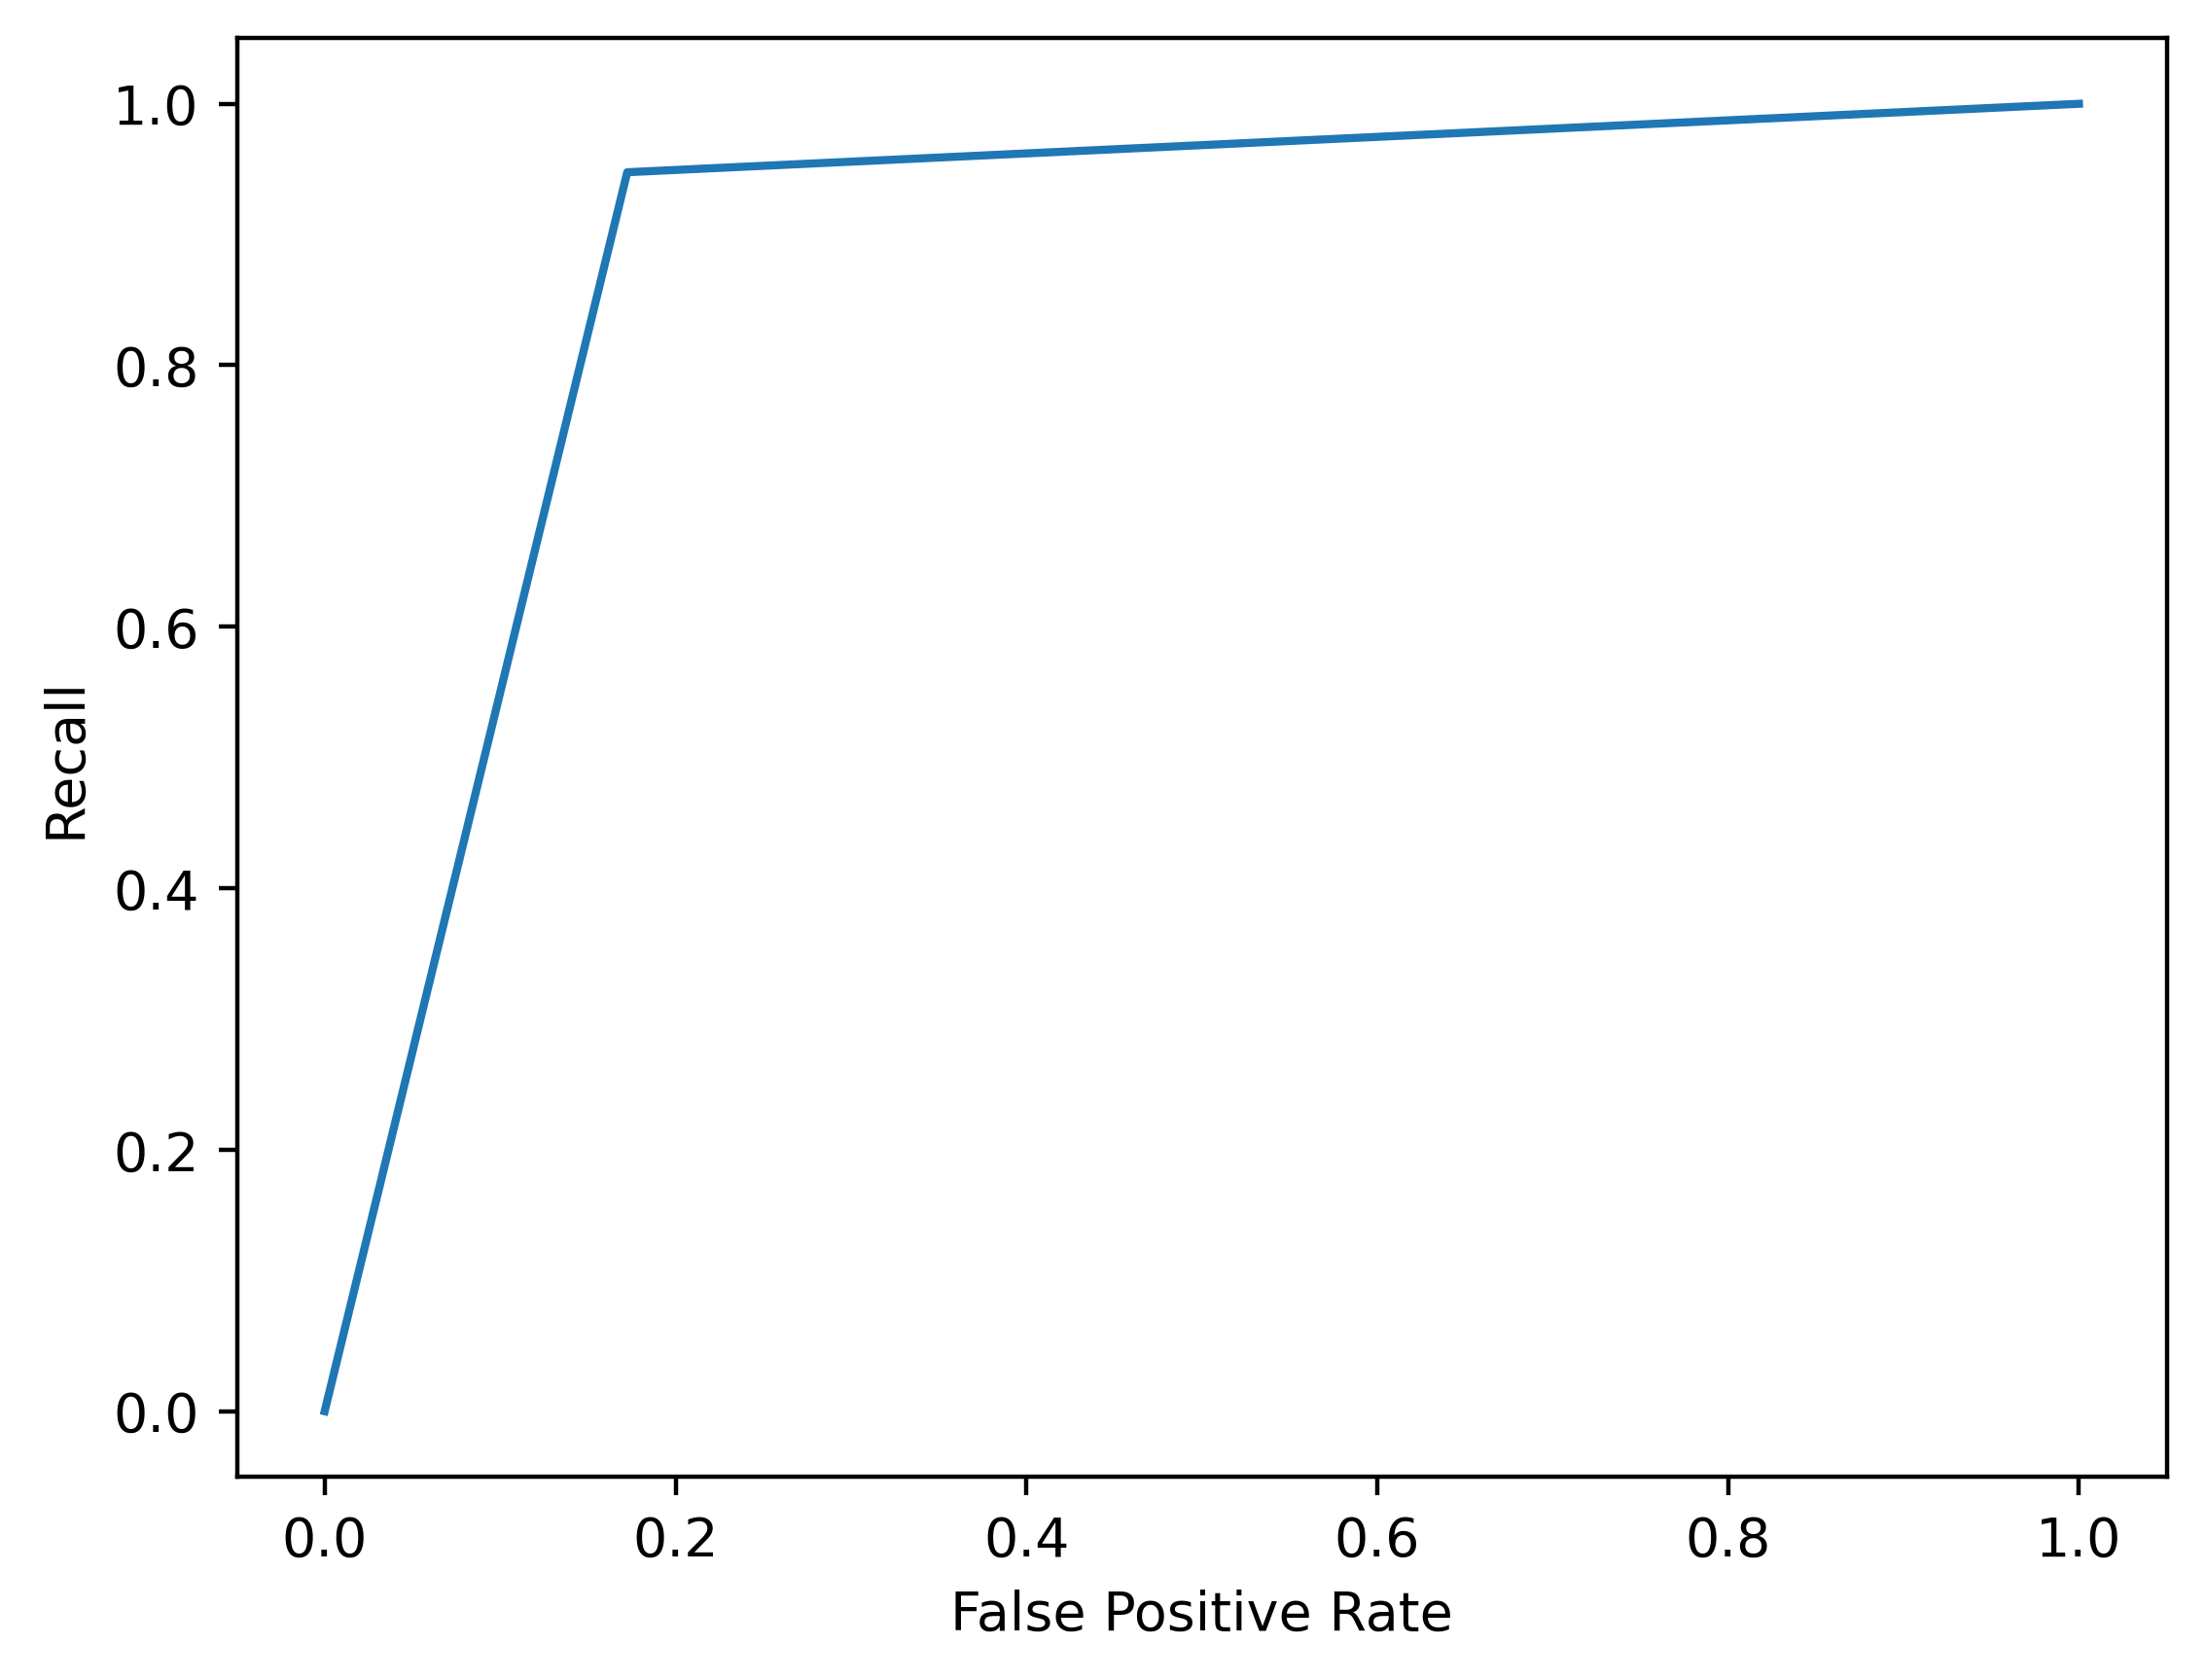

In [50]:
plt.figure(dpi=400)
fpr, tpr, _ = metrics.roc_curve(y_test_sequence,  preds)
plt.plot(fpr,tpr)
plt.ylabel('Recall')
plt.xlabel('False Positive Rate')
plt.show()

In [51]:
pr = sklearn.metrics.precision_score(y_test_sequence, preds)
rec = sklearn.metrics.recall_score(y_test_sequence, preds)
print(pr, rec)

0.9438762755391923 0.9476494105927107


In [52]:
precision, recall, thr = metrics.precision_recall_curve(y_test_sequence,  preds)

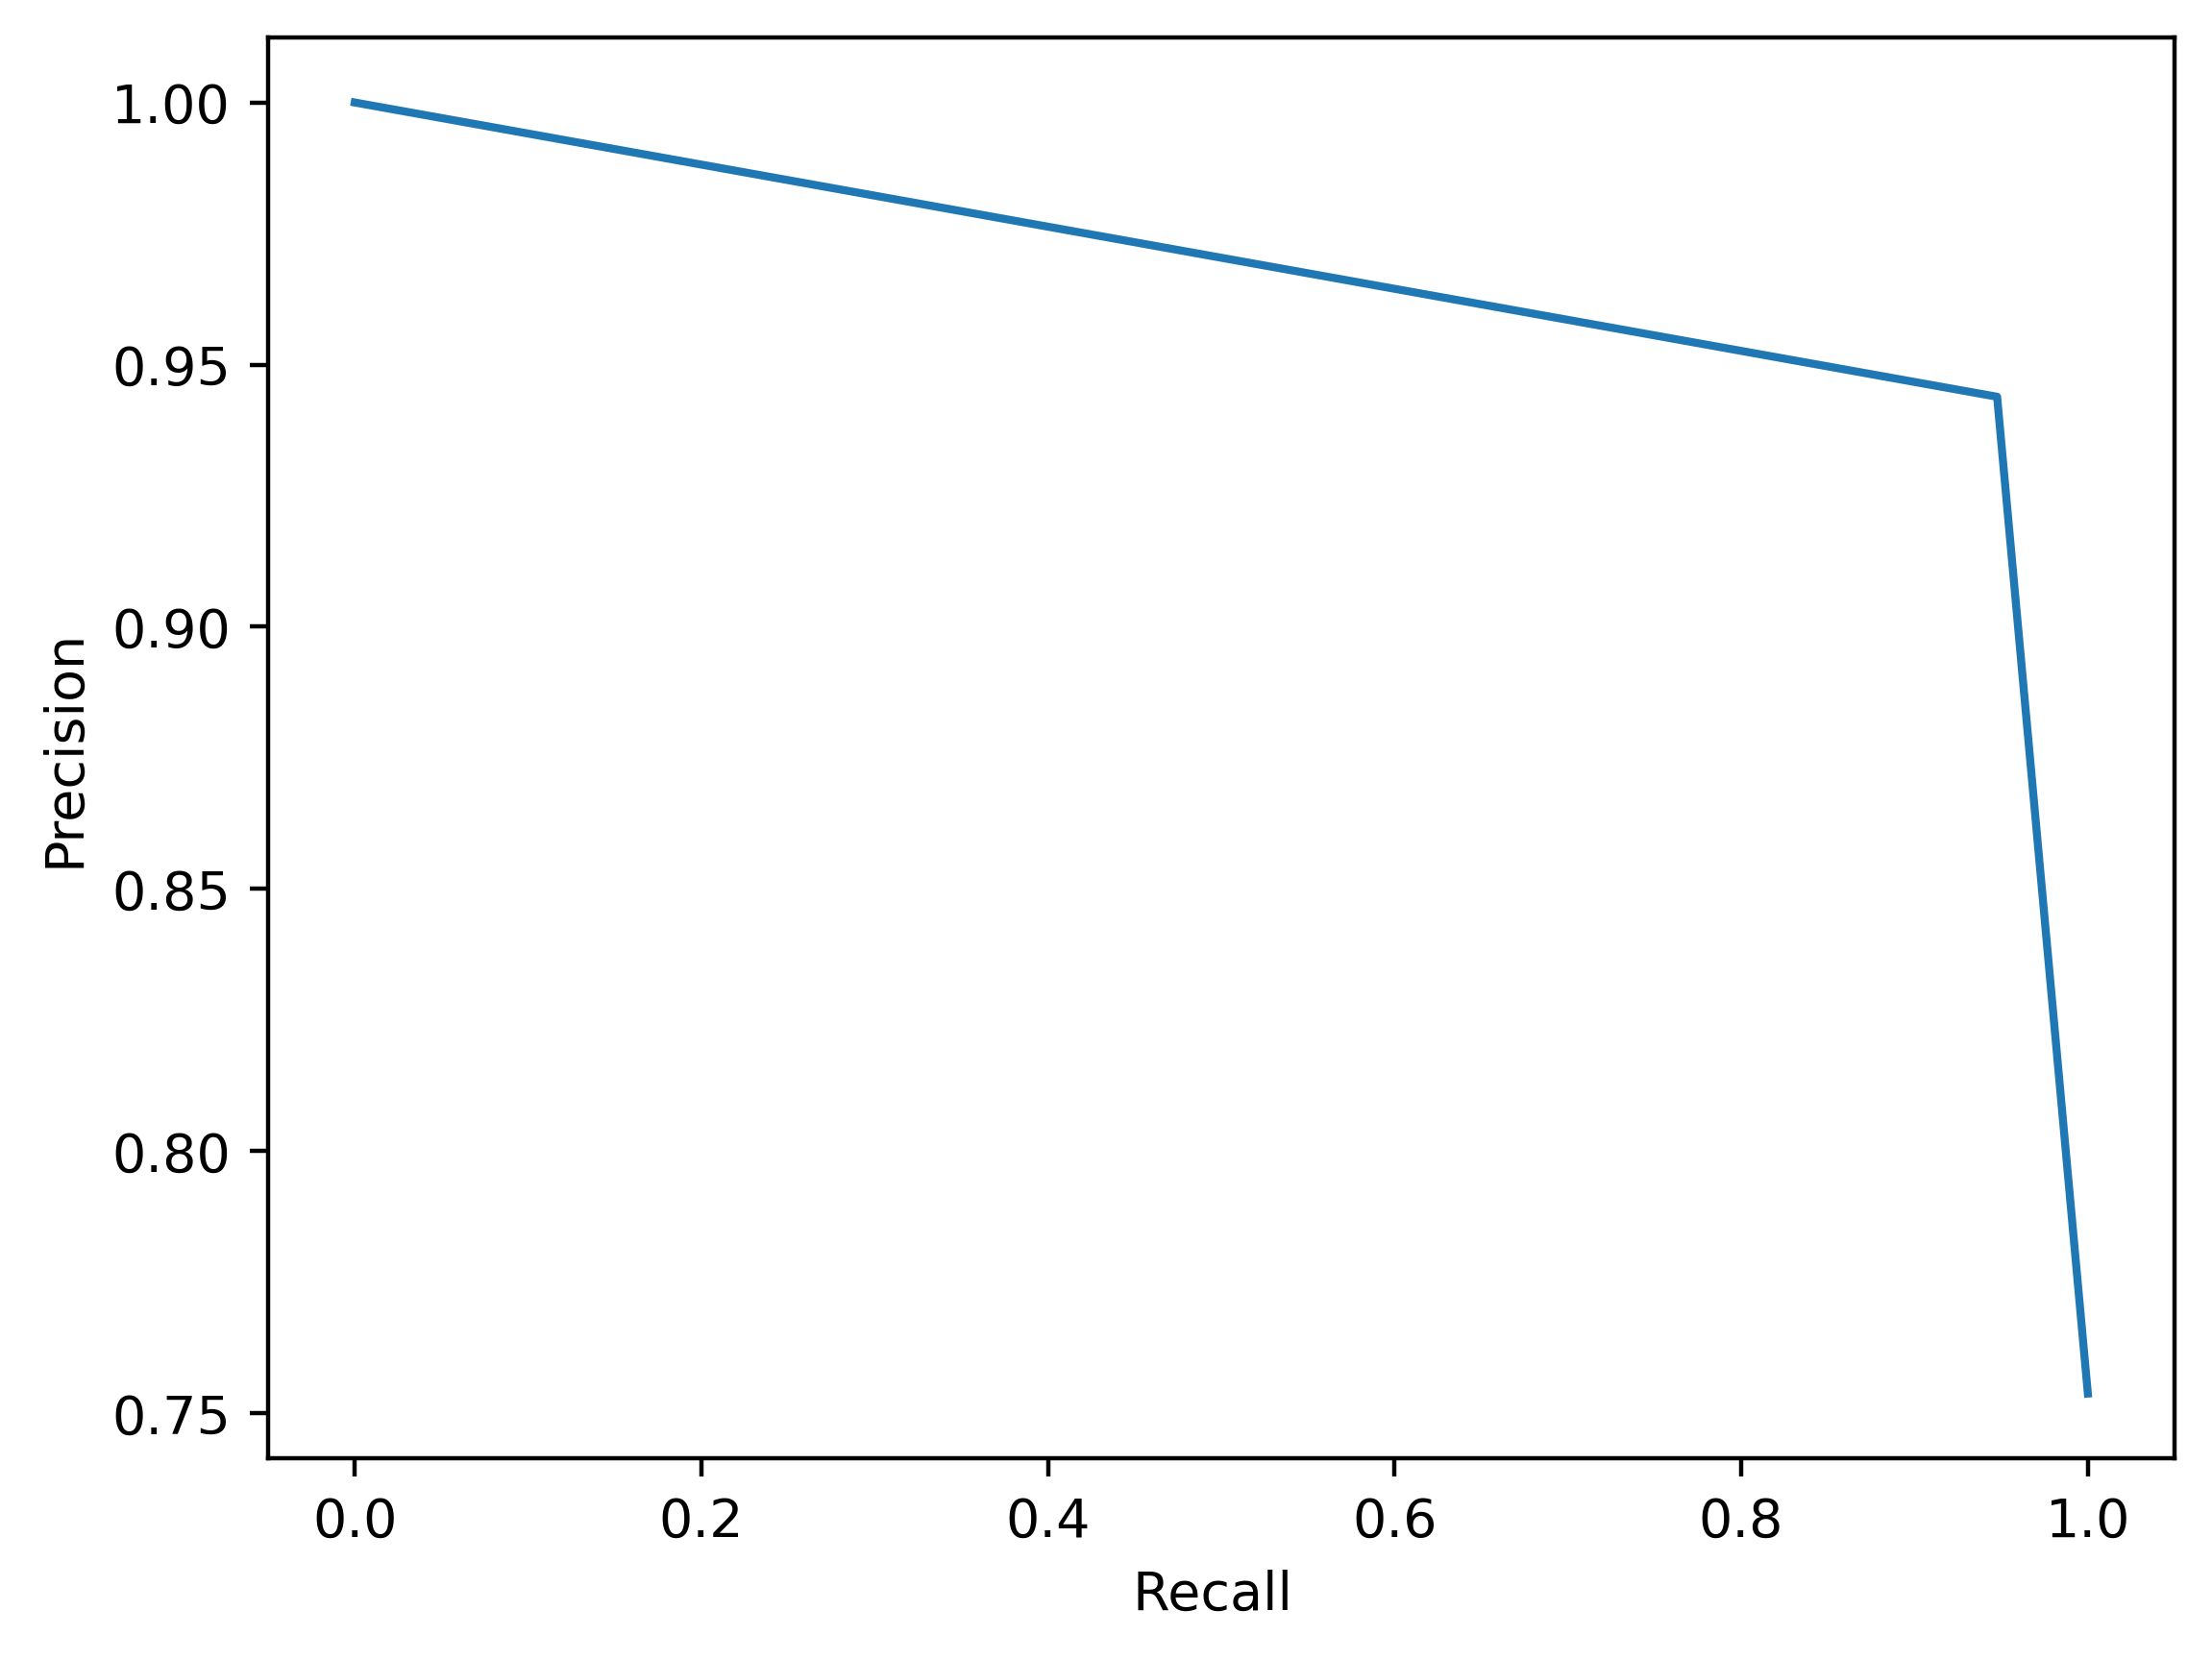

In [53]:
plt.figure(dpi=400)
plt.plot(recall, precision)
plt.ylabel('Precision')
plt.xlabel('Recall ')
plt.show()

In [54]:
print("TRUE NEGATIVE RATE tn/(tn+fp)")
tn/(tn+fp)

TRUE NEGATIVE RATE tn/(tn+fp)


0.8275167172649166

In [55]:
print("FALSE NEGATIVE RATE fn/(fn+tp)")
fn/(fn+tp)

FALSE NEGATIVE RATE fn/(fn+tp)


0.052350589407289344

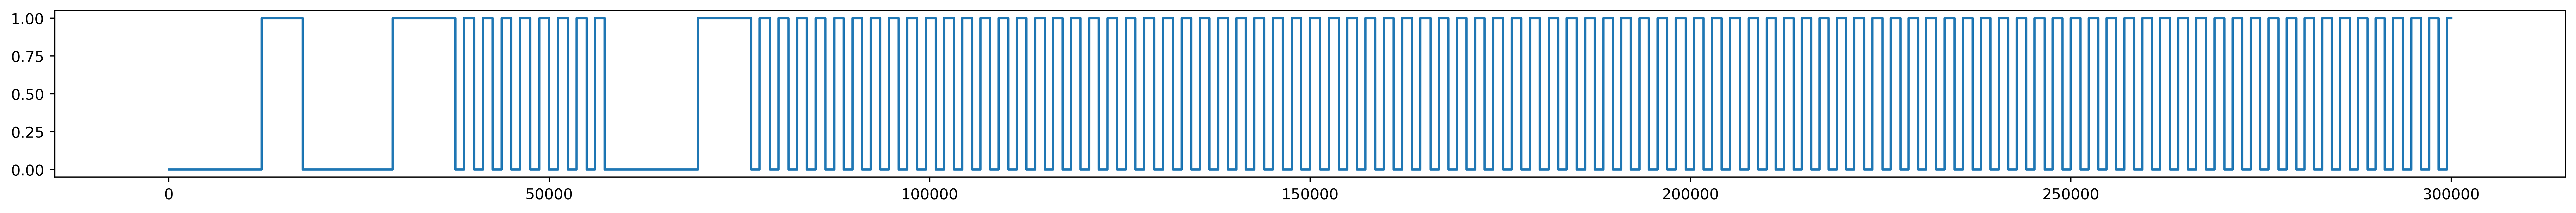

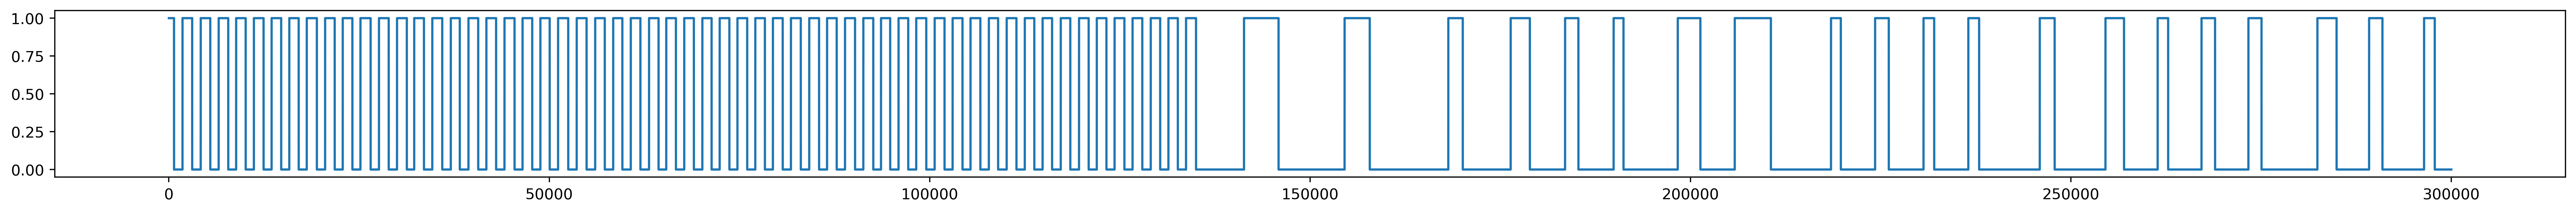

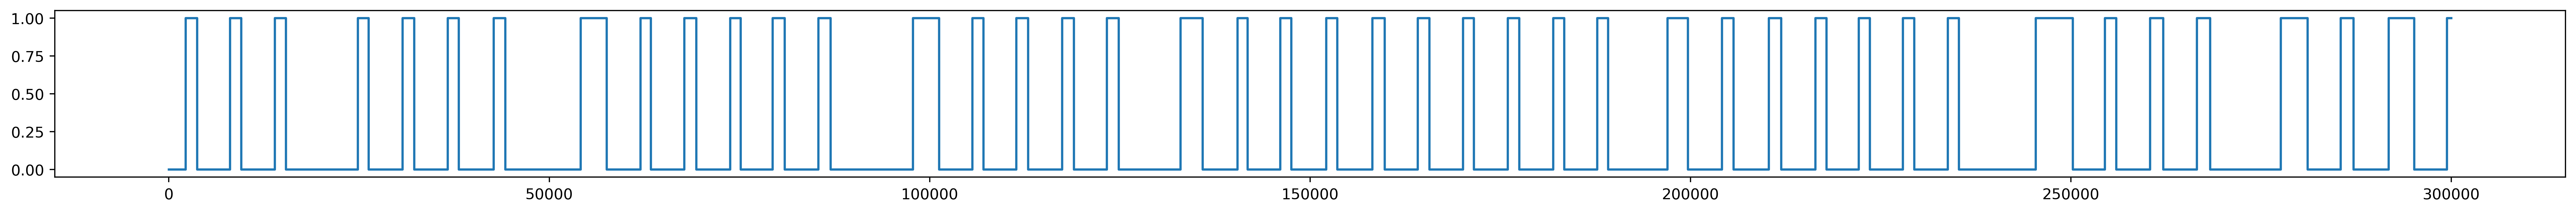

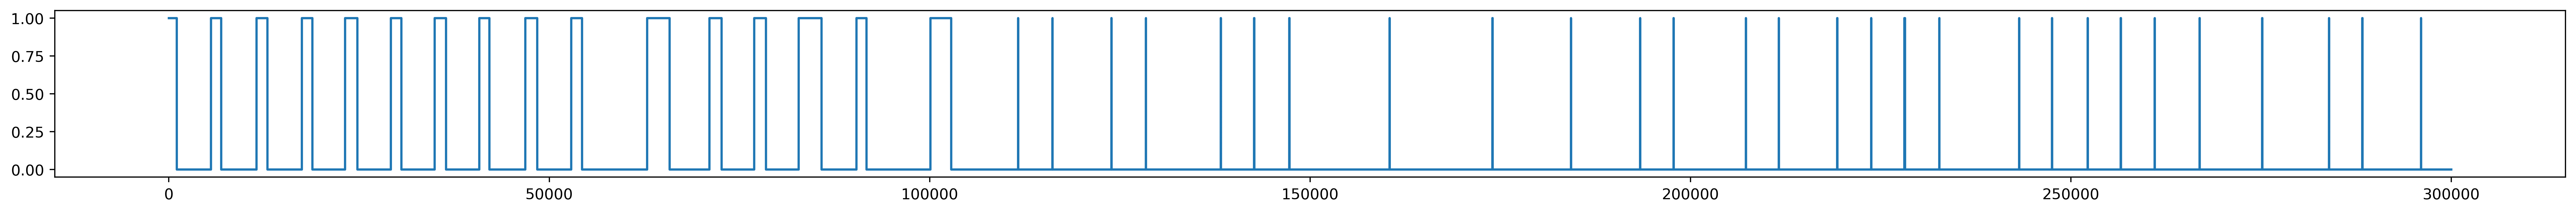

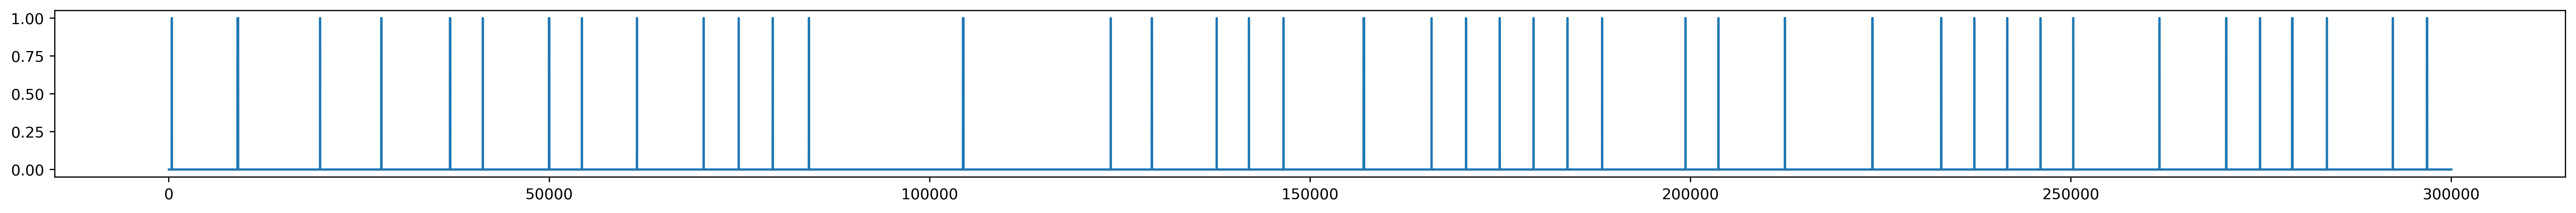

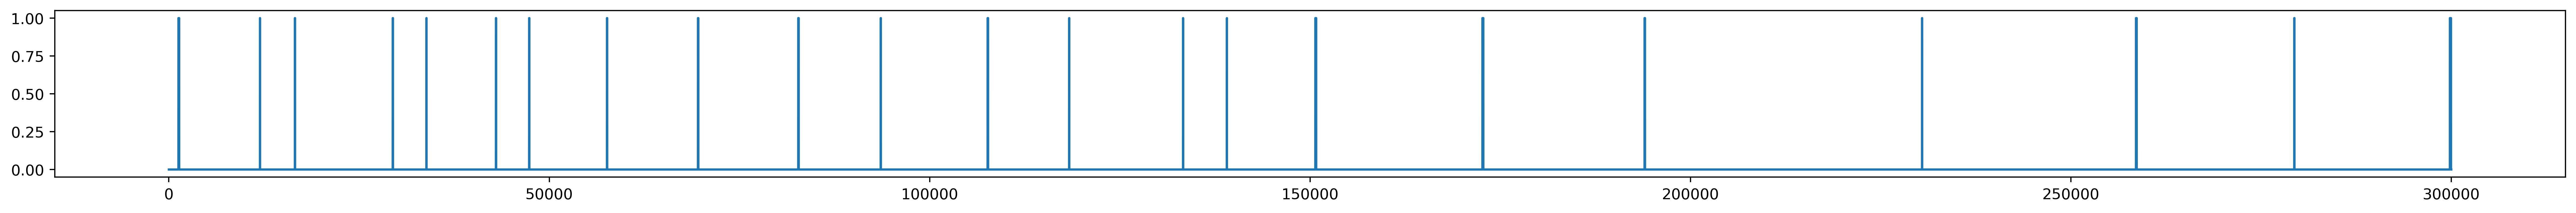

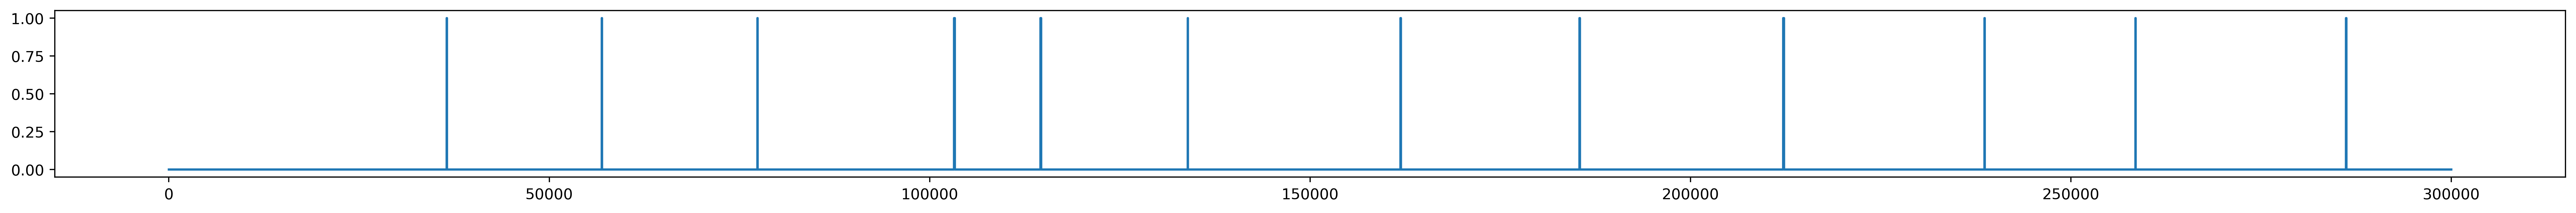

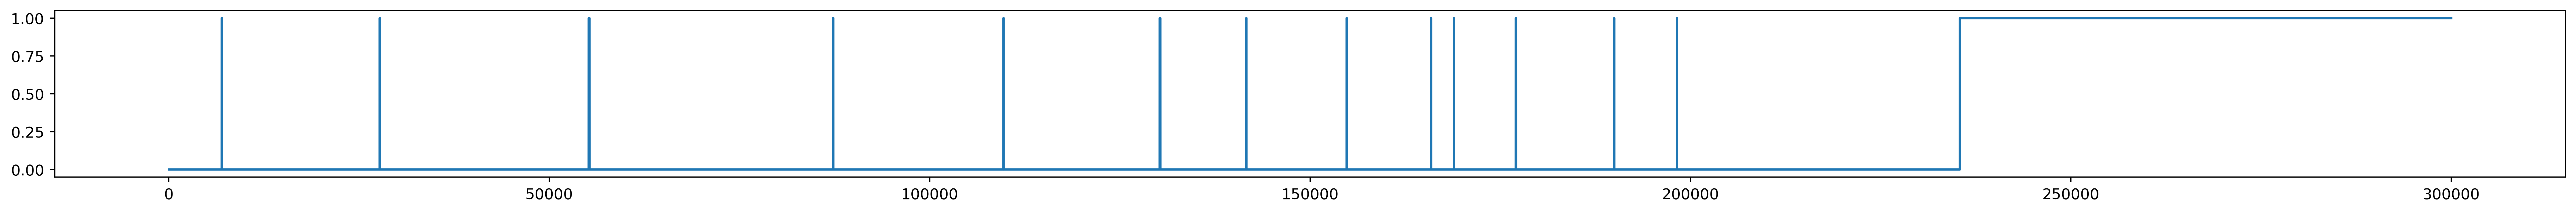

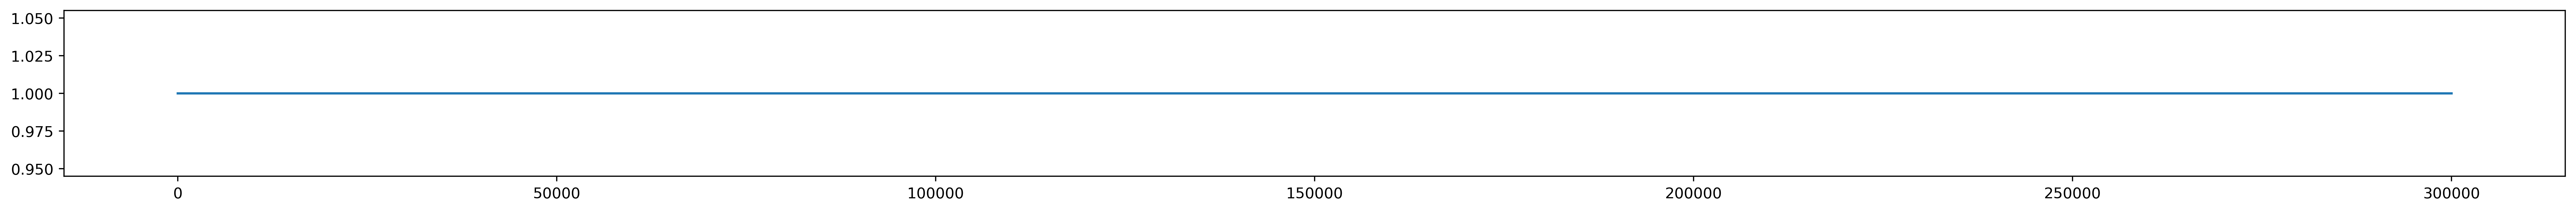

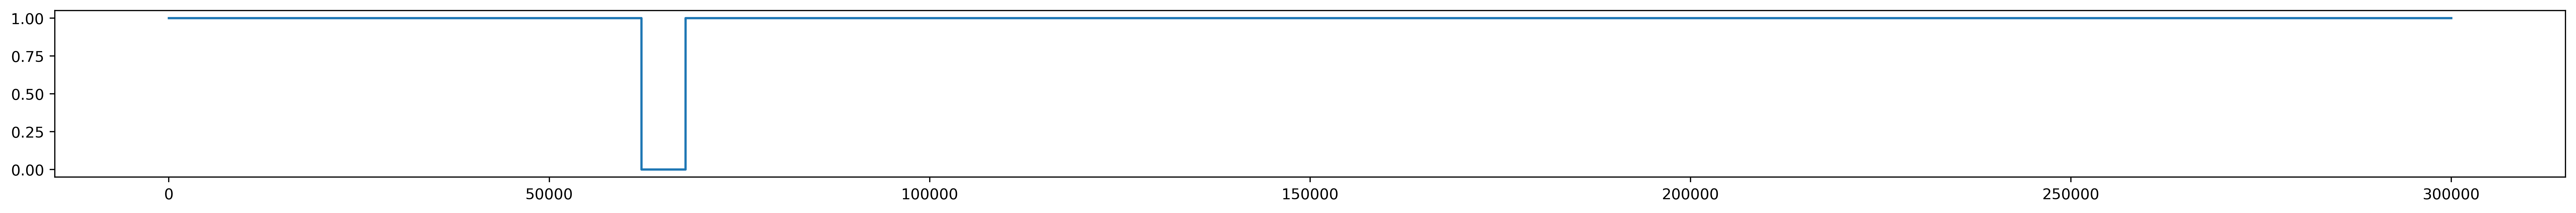

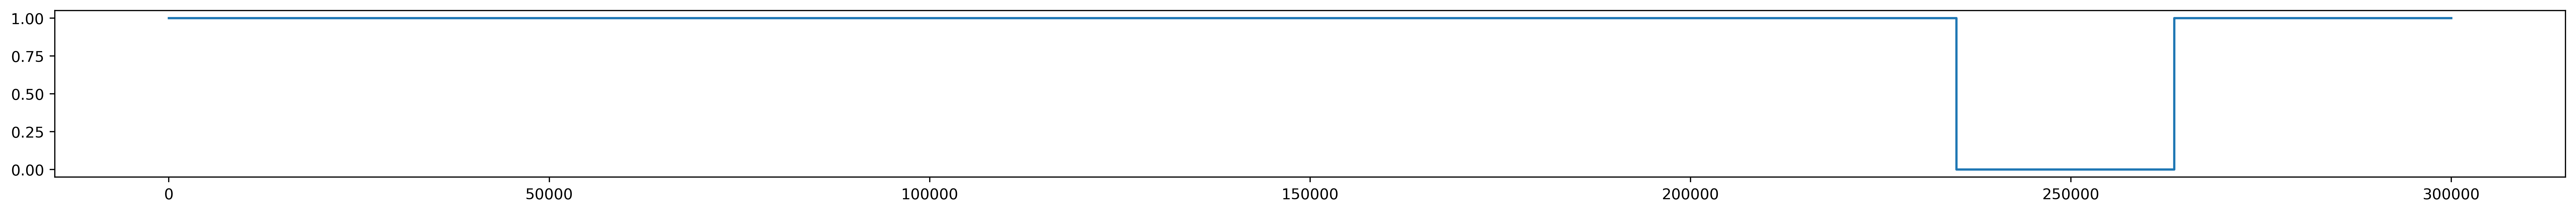

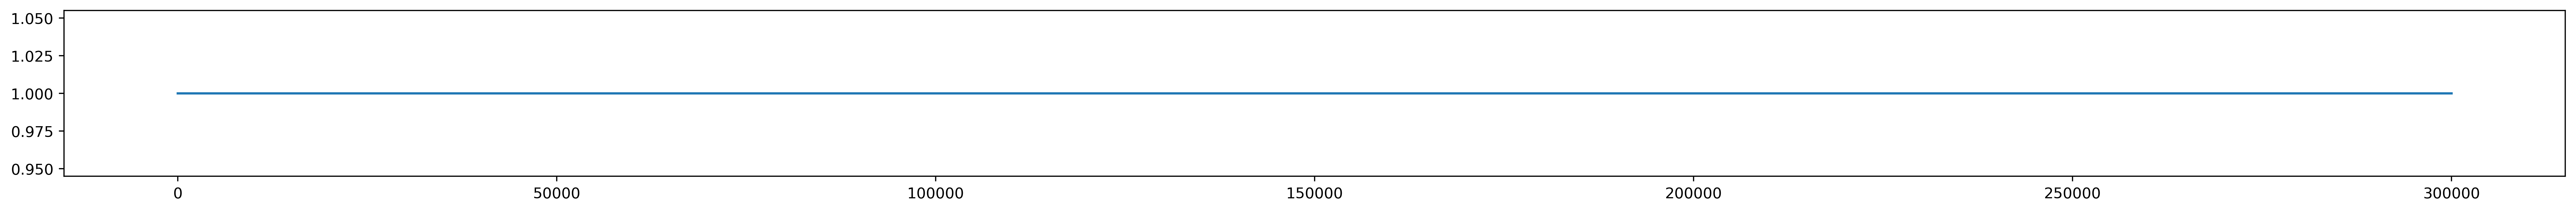

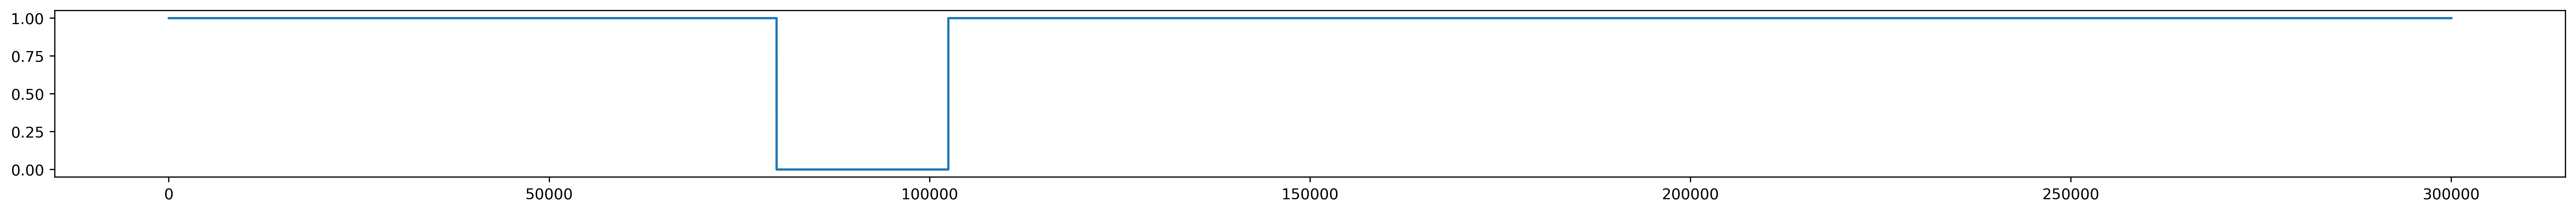

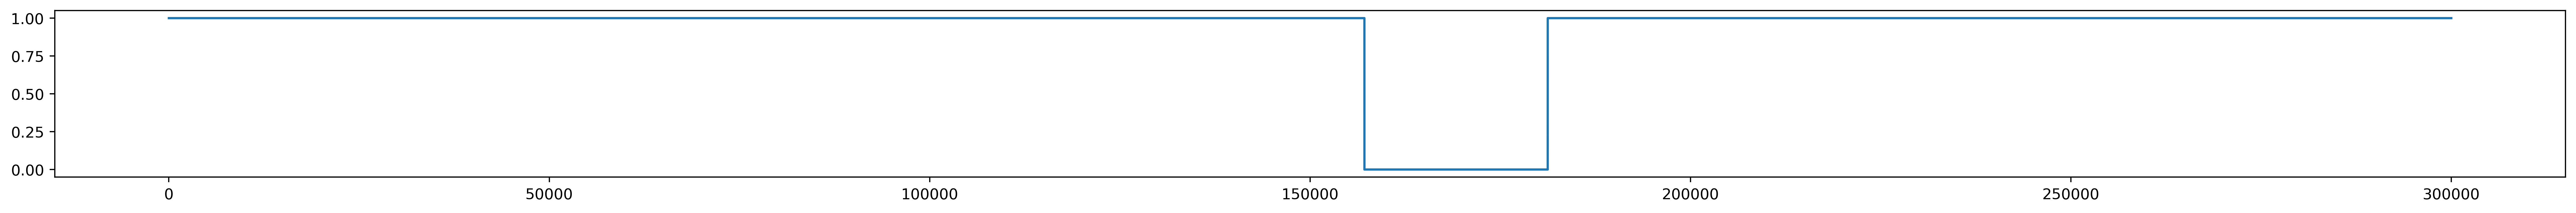

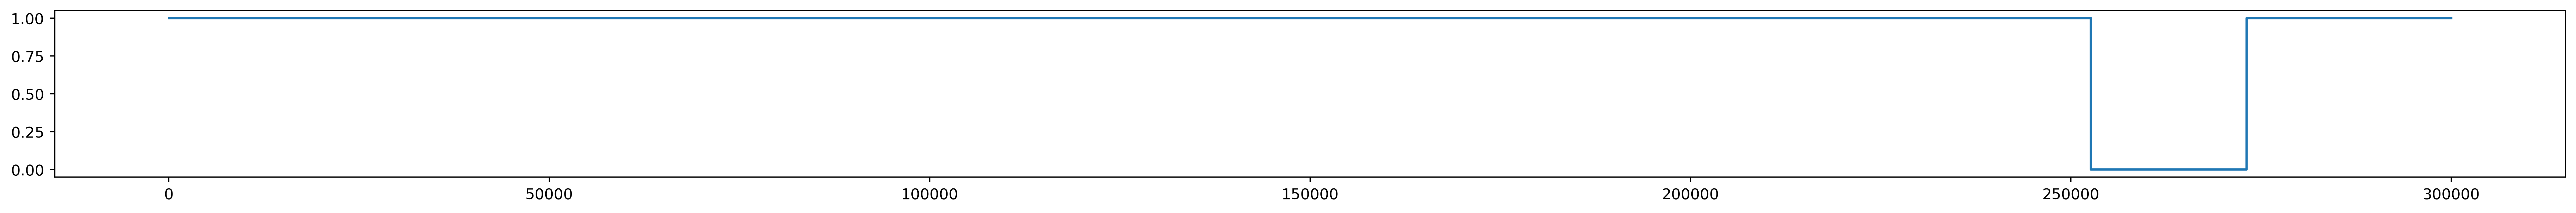

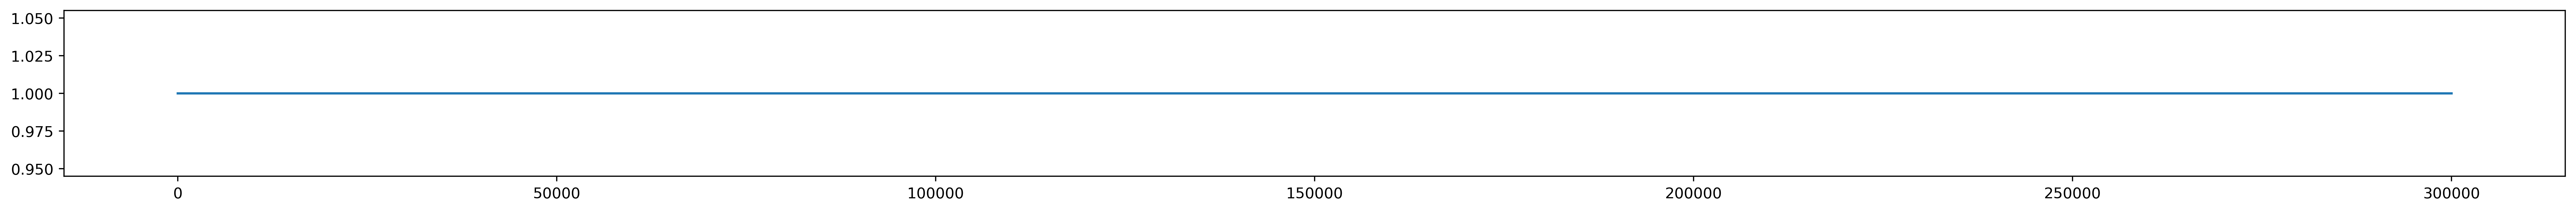

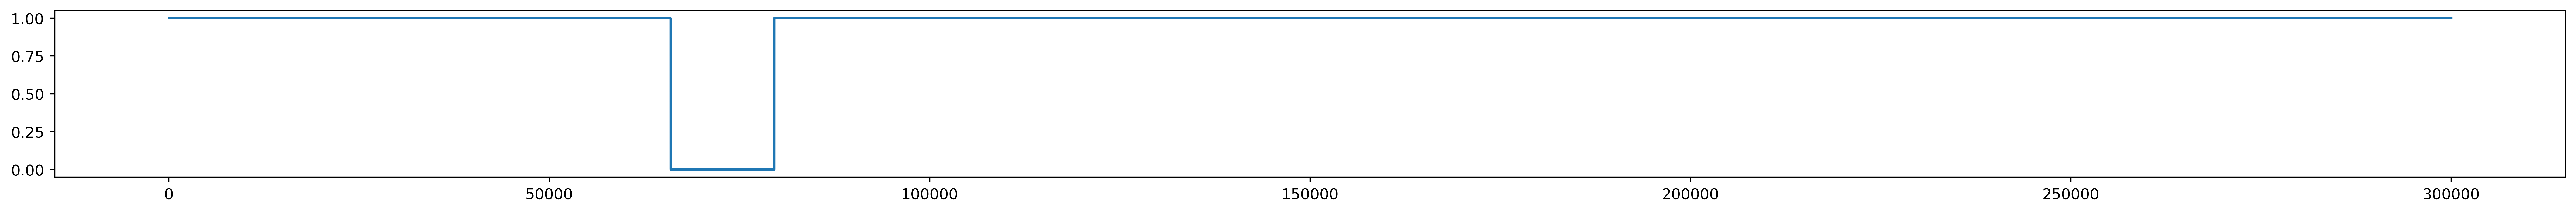

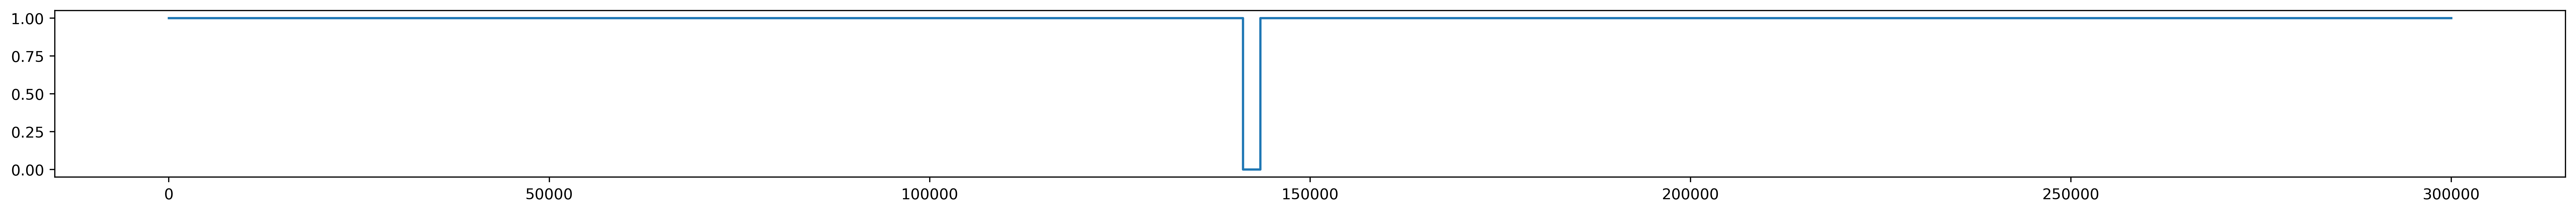

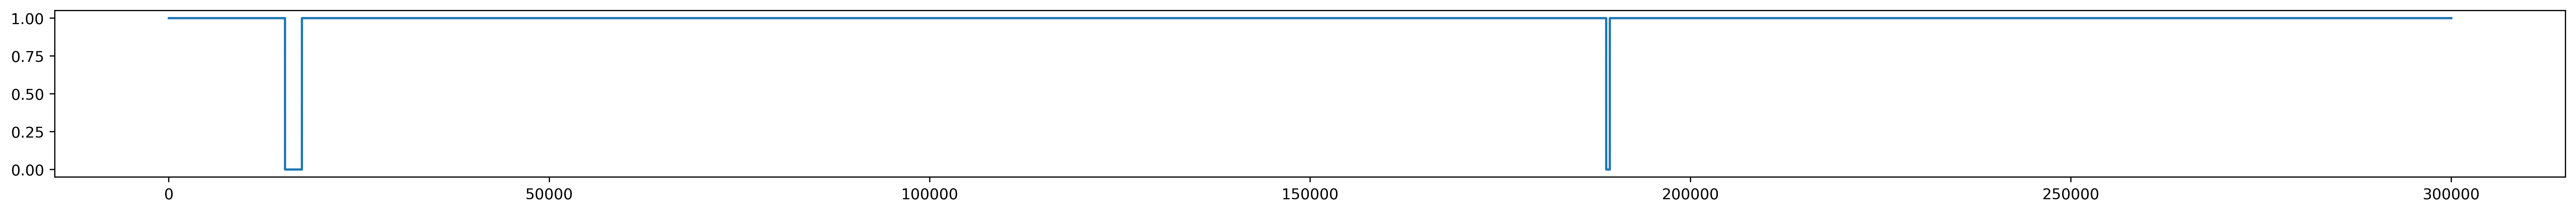

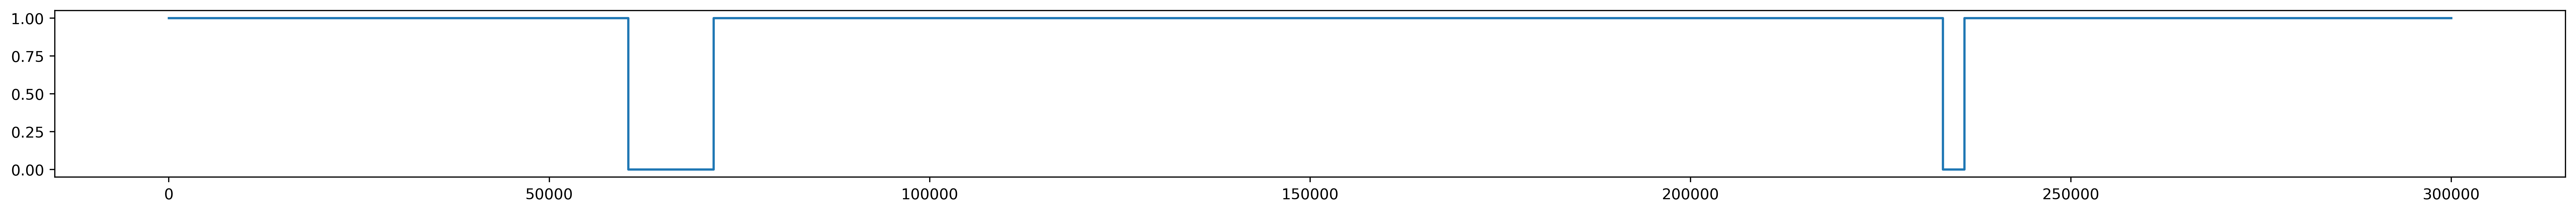

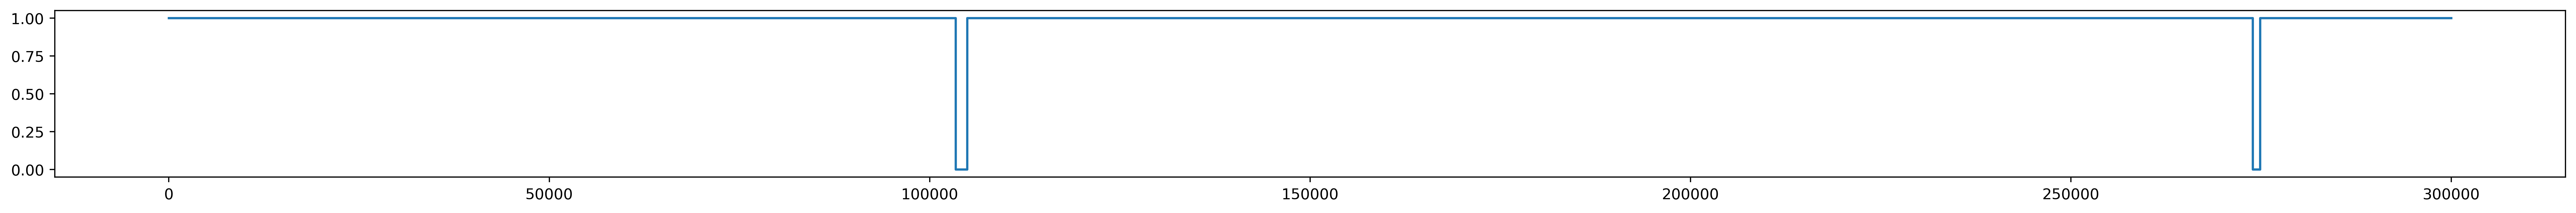

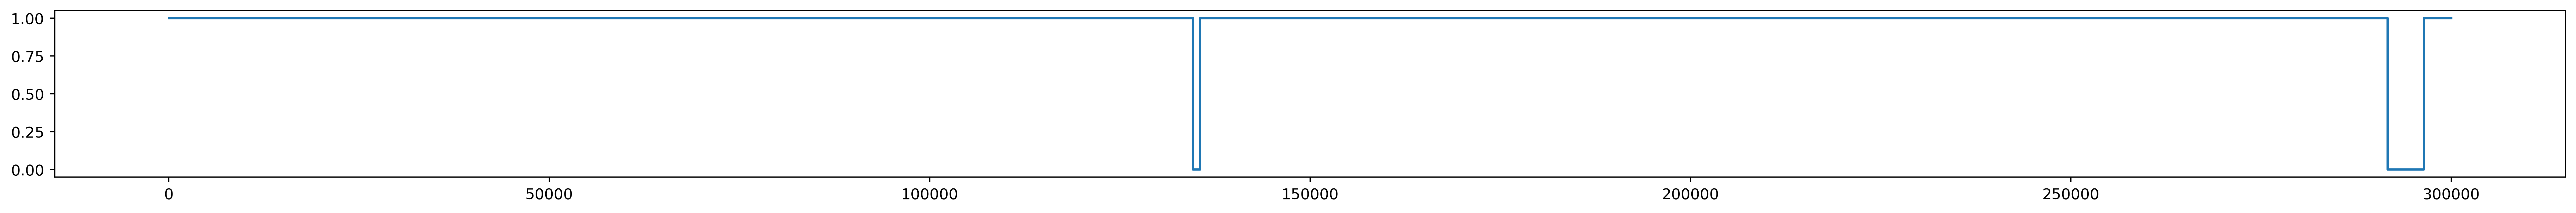

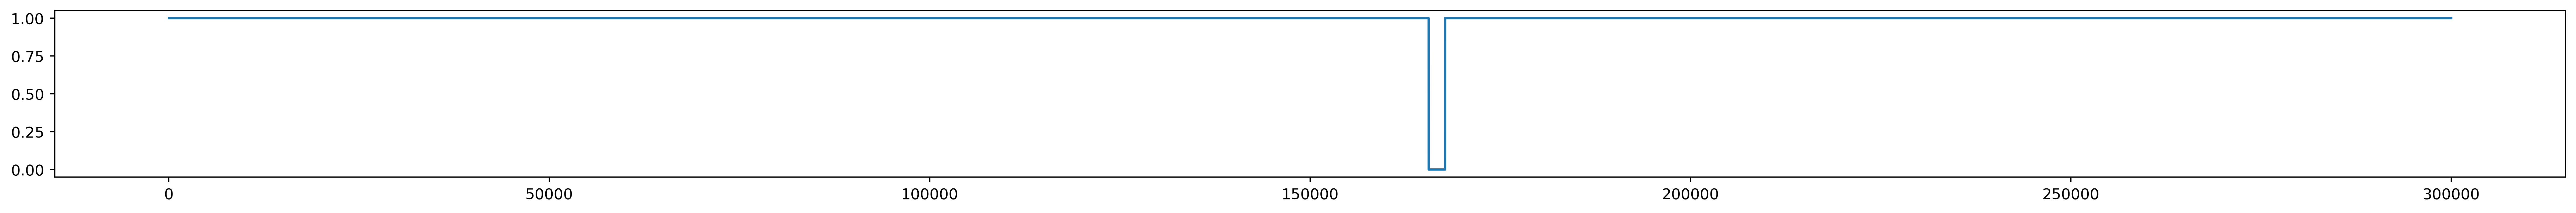

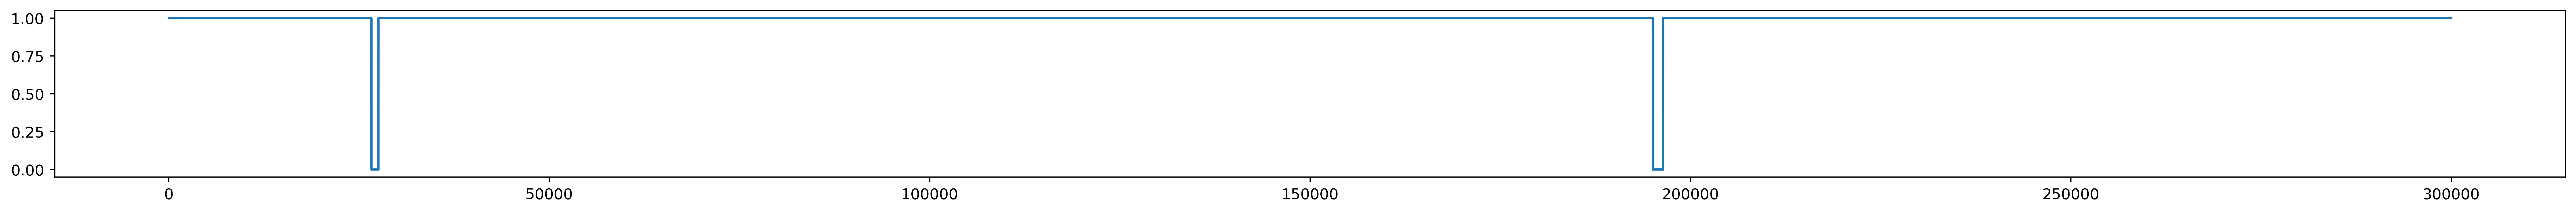

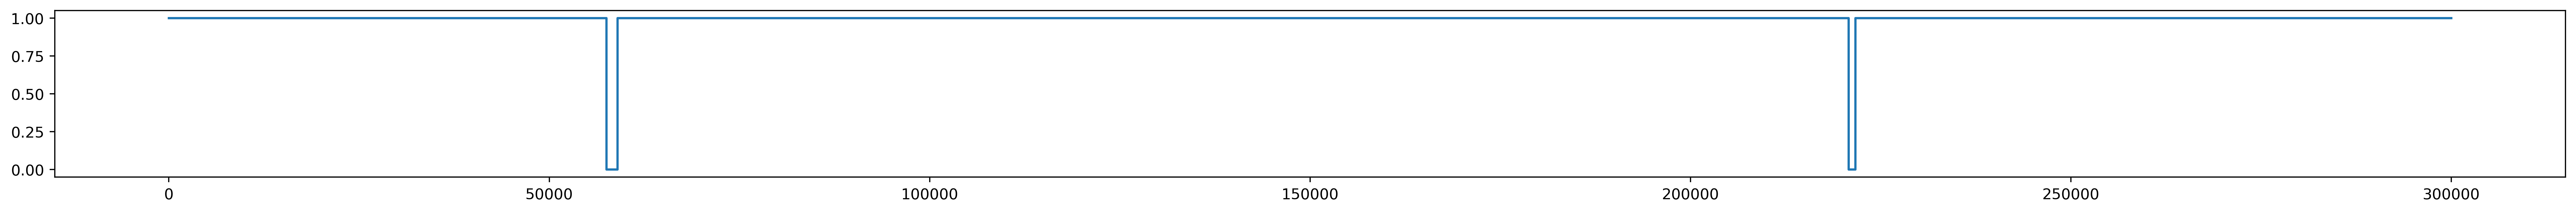

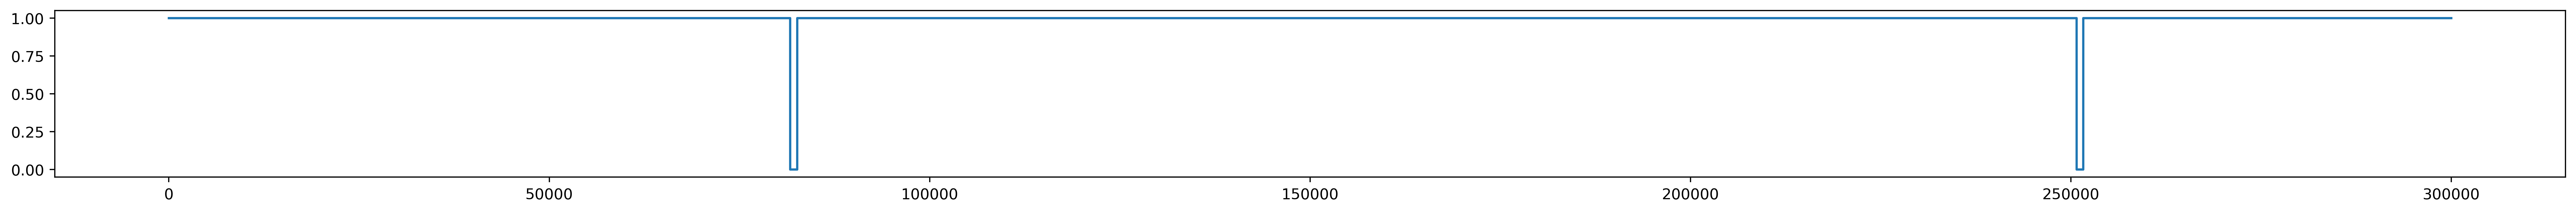

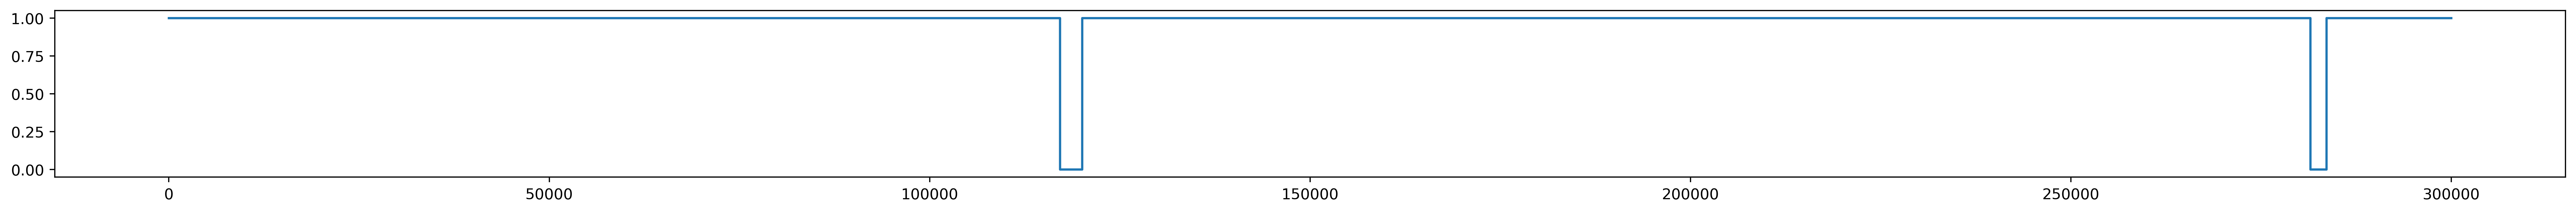

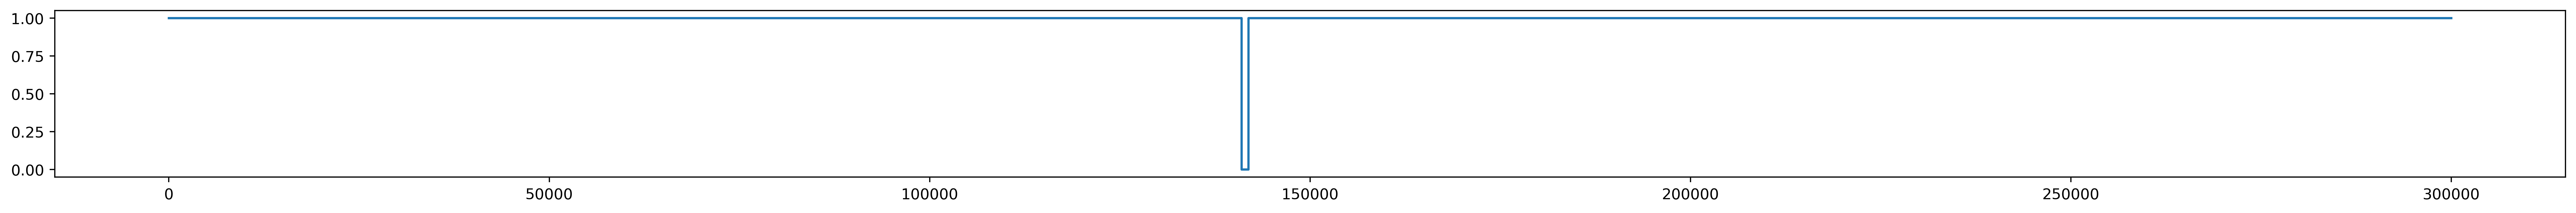

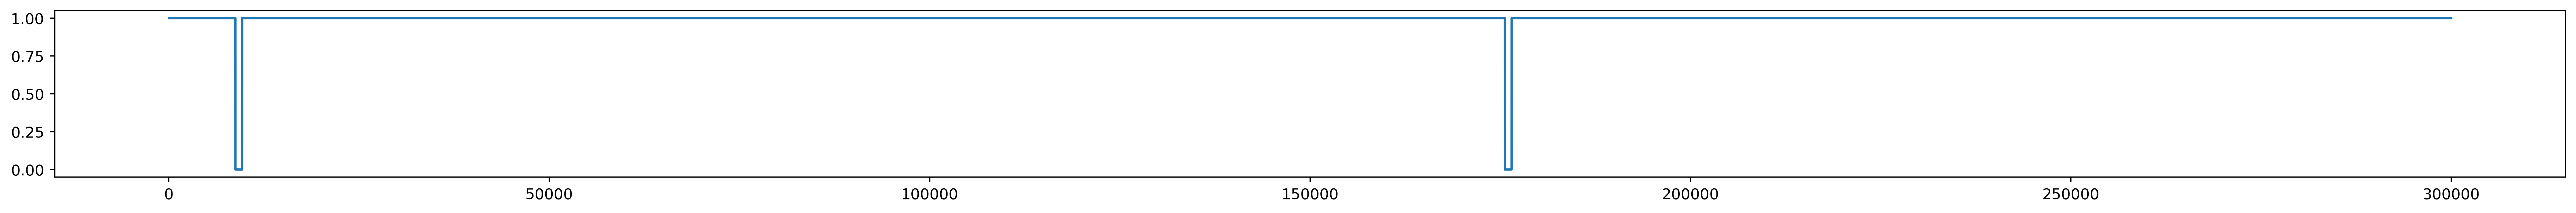

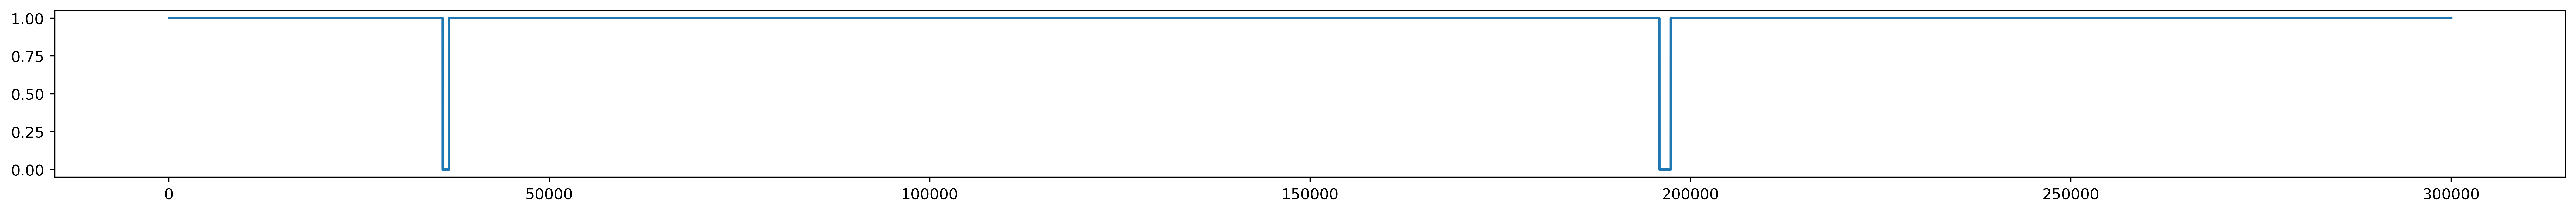

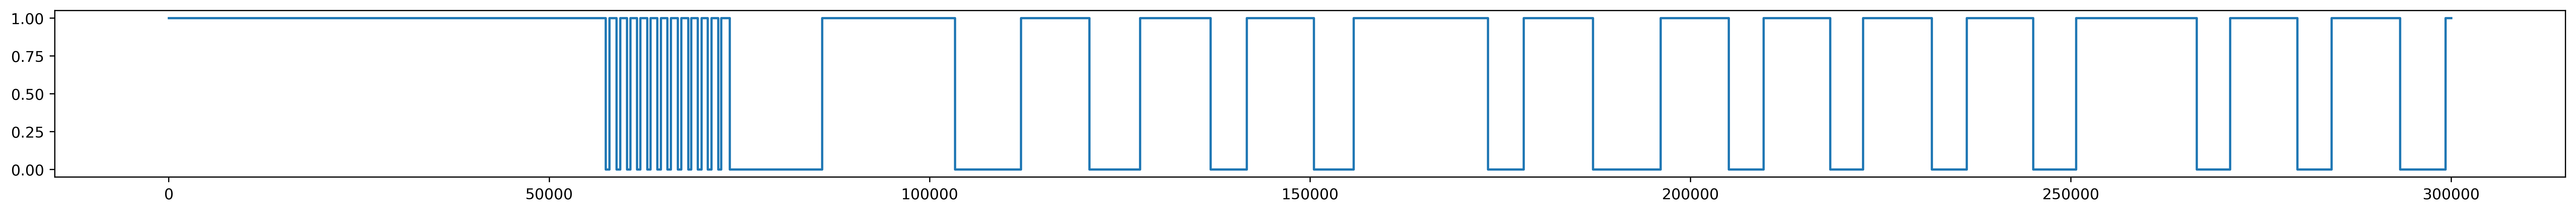

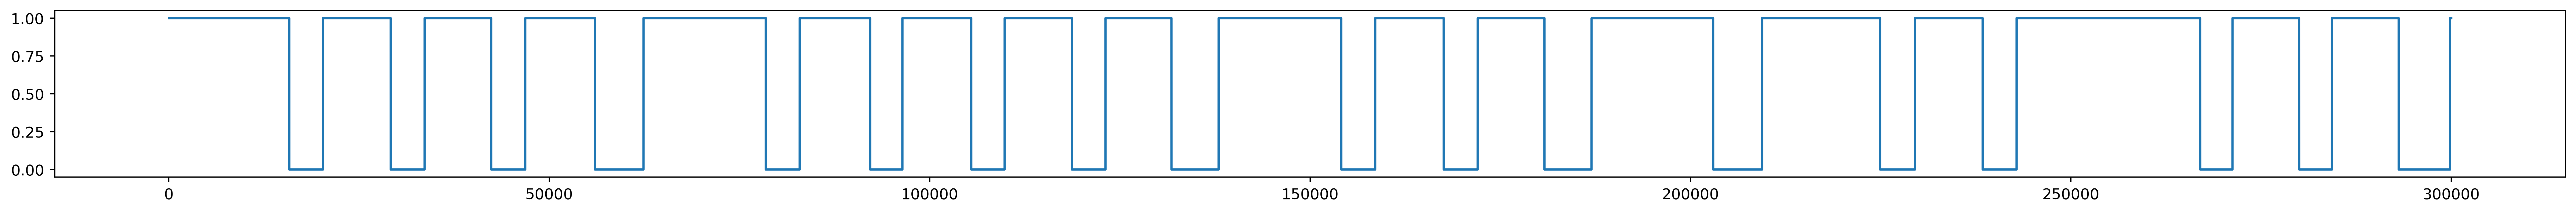

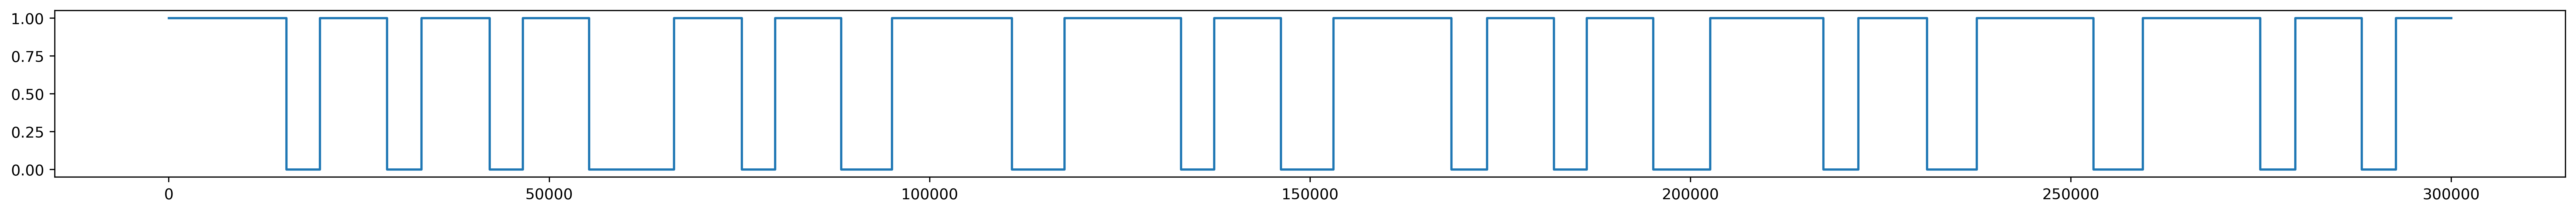

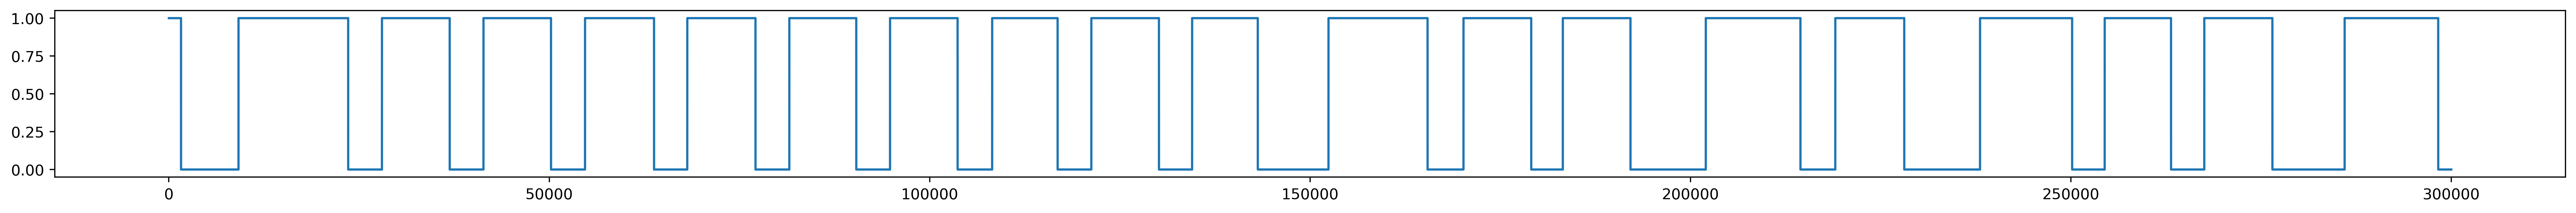

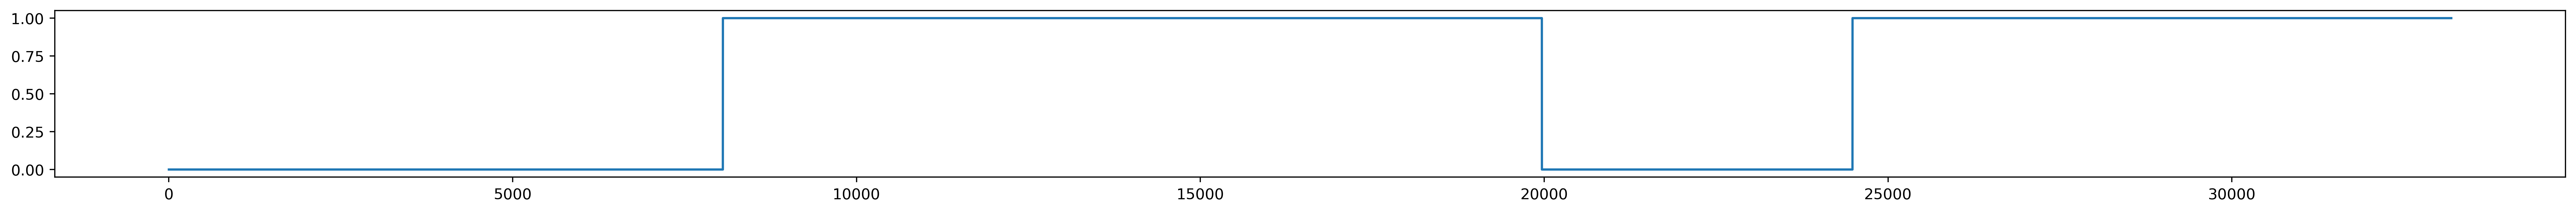

In [56]:
i=0
while(i < y_test_sequence.shape[0]):
    figure(figsize=(30, 2), dpi=400)
    plt.plot(y_test_sequence[i:i+300000])
    plt.show()
    i=i+300000

In [ ]:
i=0
while(i < y_test_sequence.shape[0]):
    figure(figsize=(15, 2), dpi=200)
    plt.plot(y_test_sequence[i:i+100000])
    plt.show()
    i=i+100000

In [ ]:
i=0
while(i < preds.shape[0]):
    figure(figsize=(15, 2), dpi=40)
    plt.plot(preds[i:i+300000])
    plt.show()
    i=i+300000

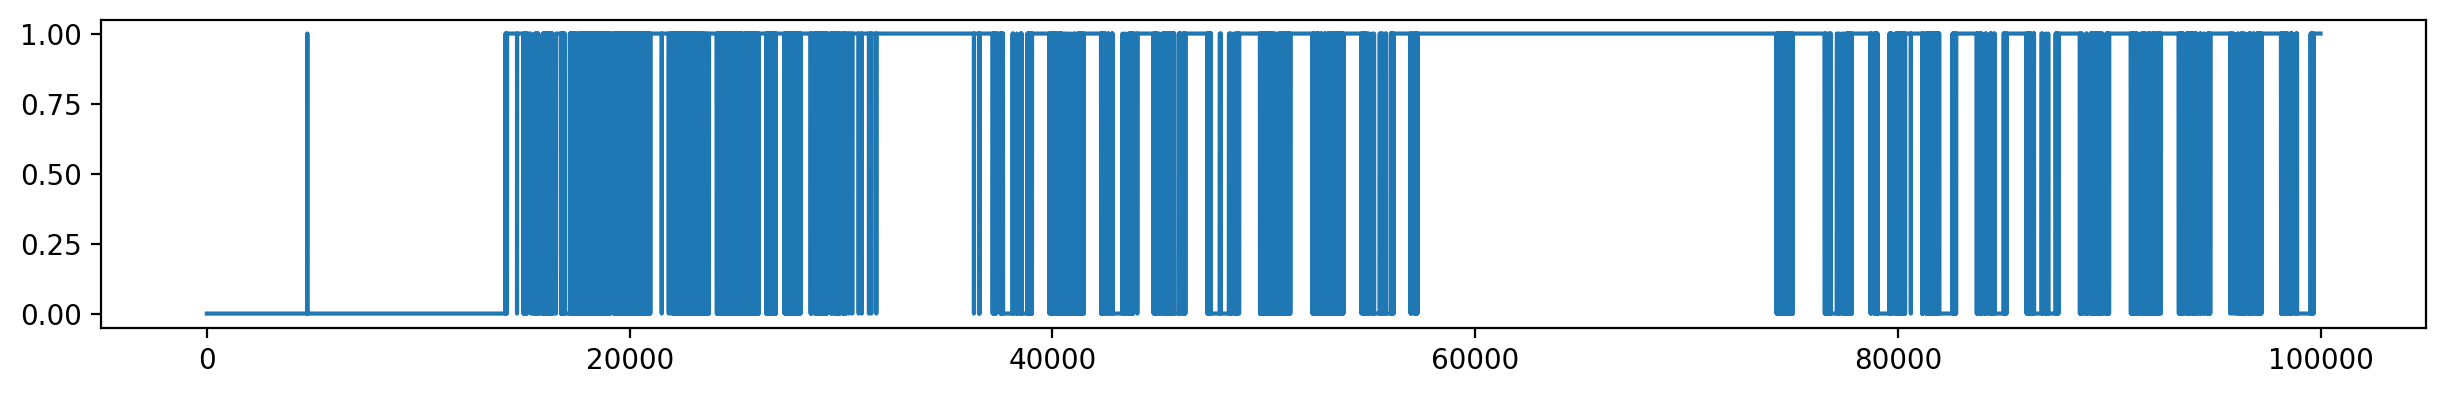

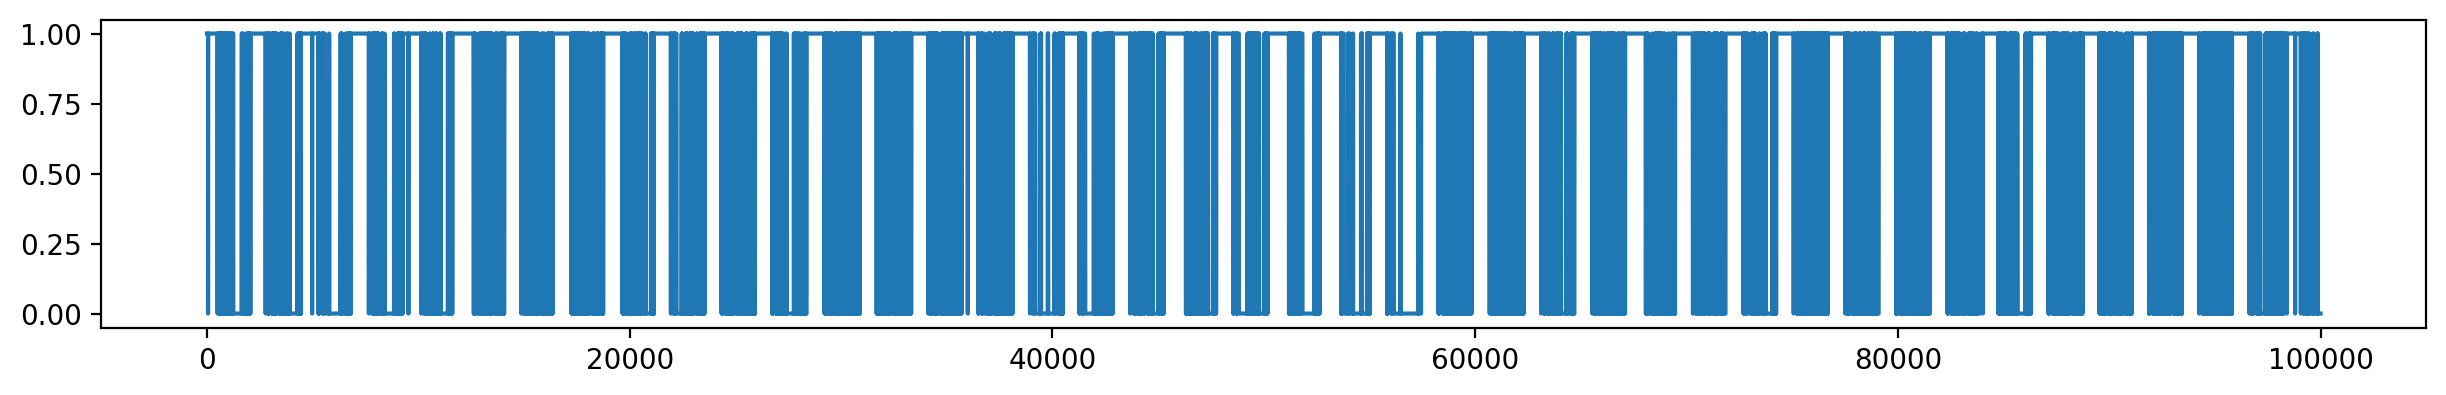

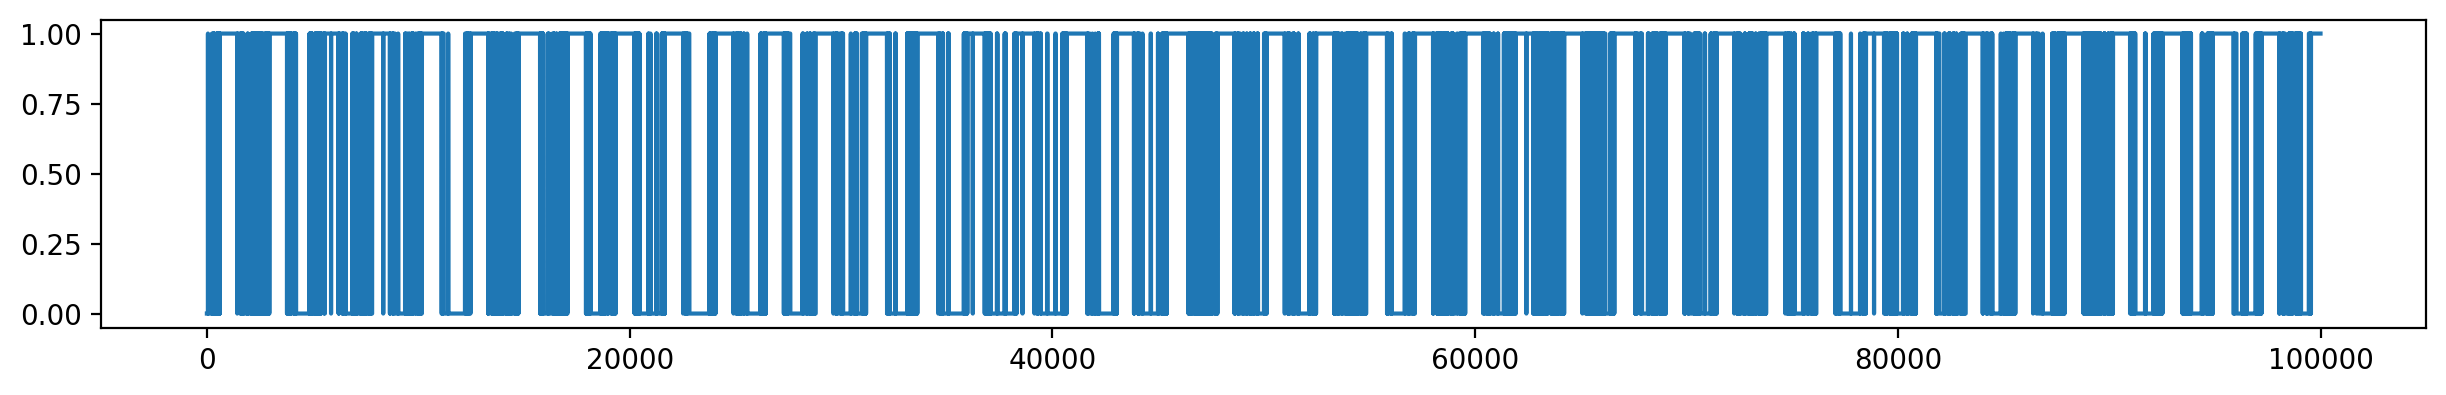

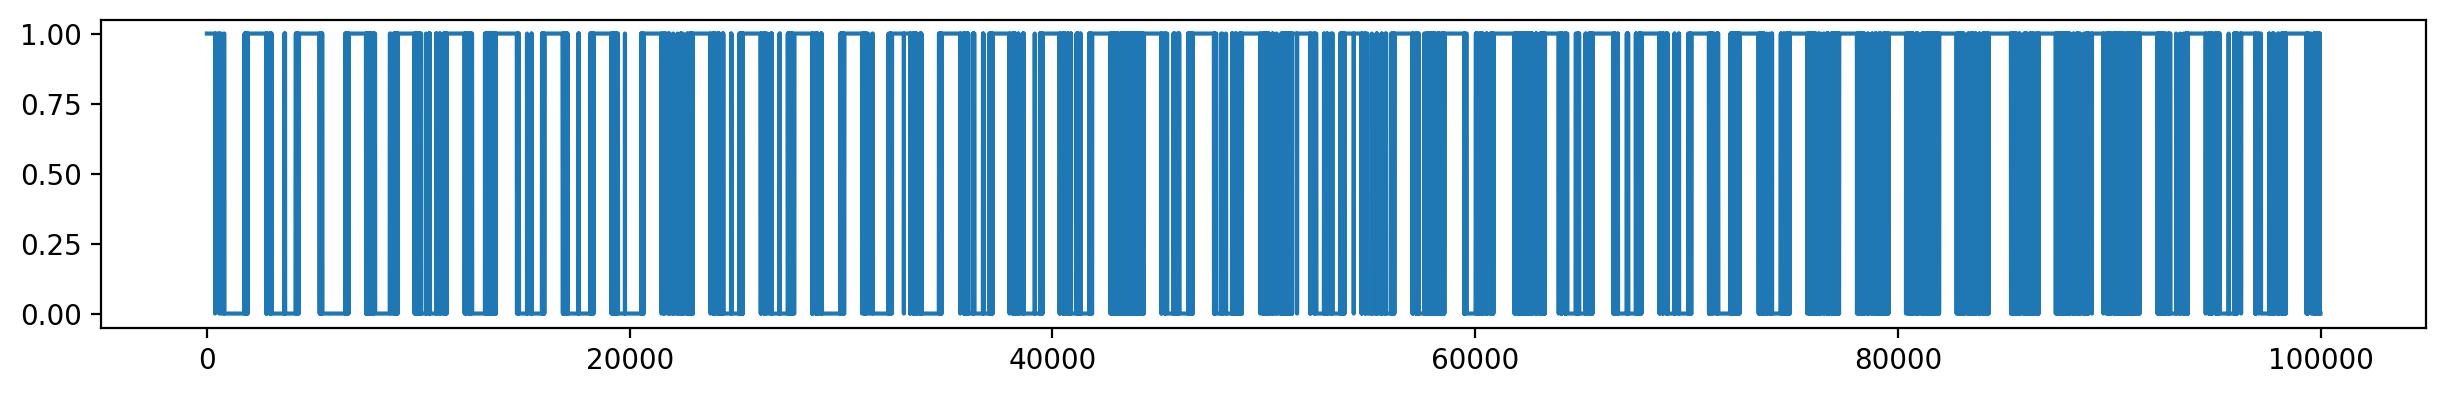

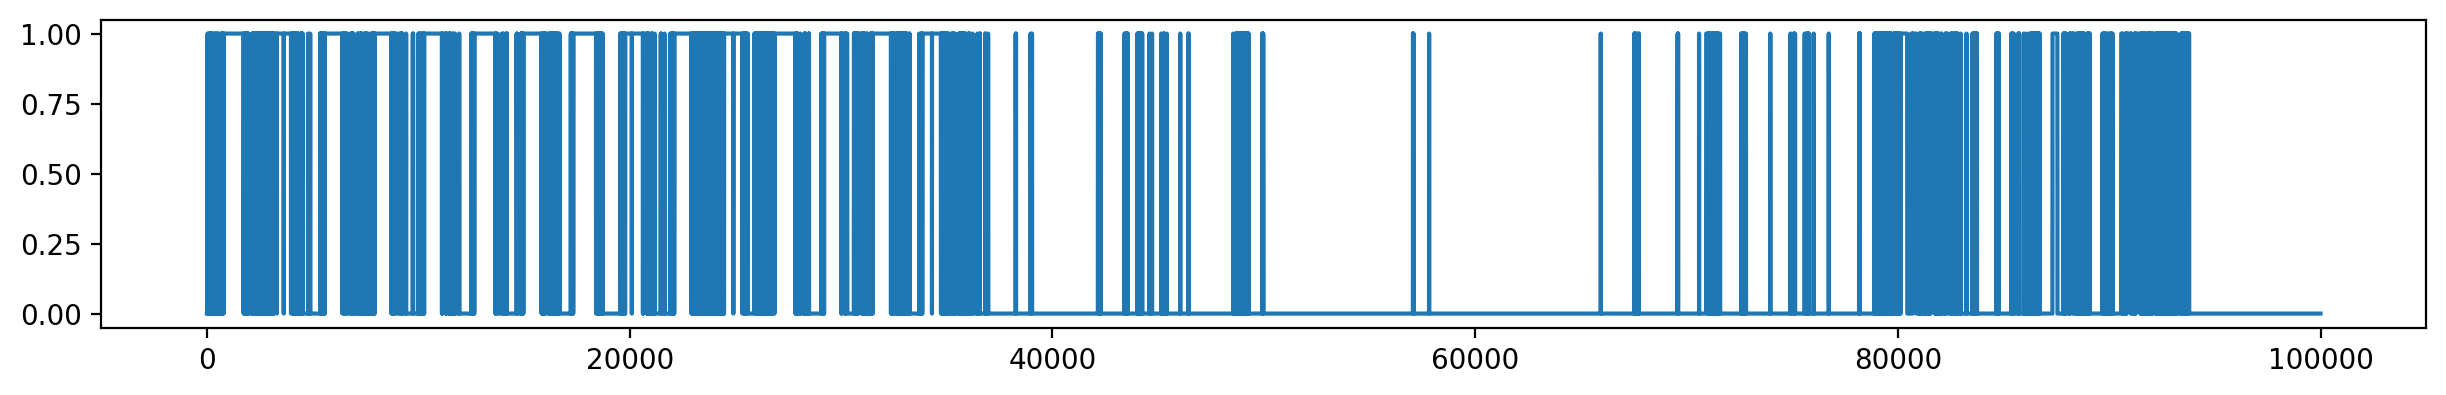

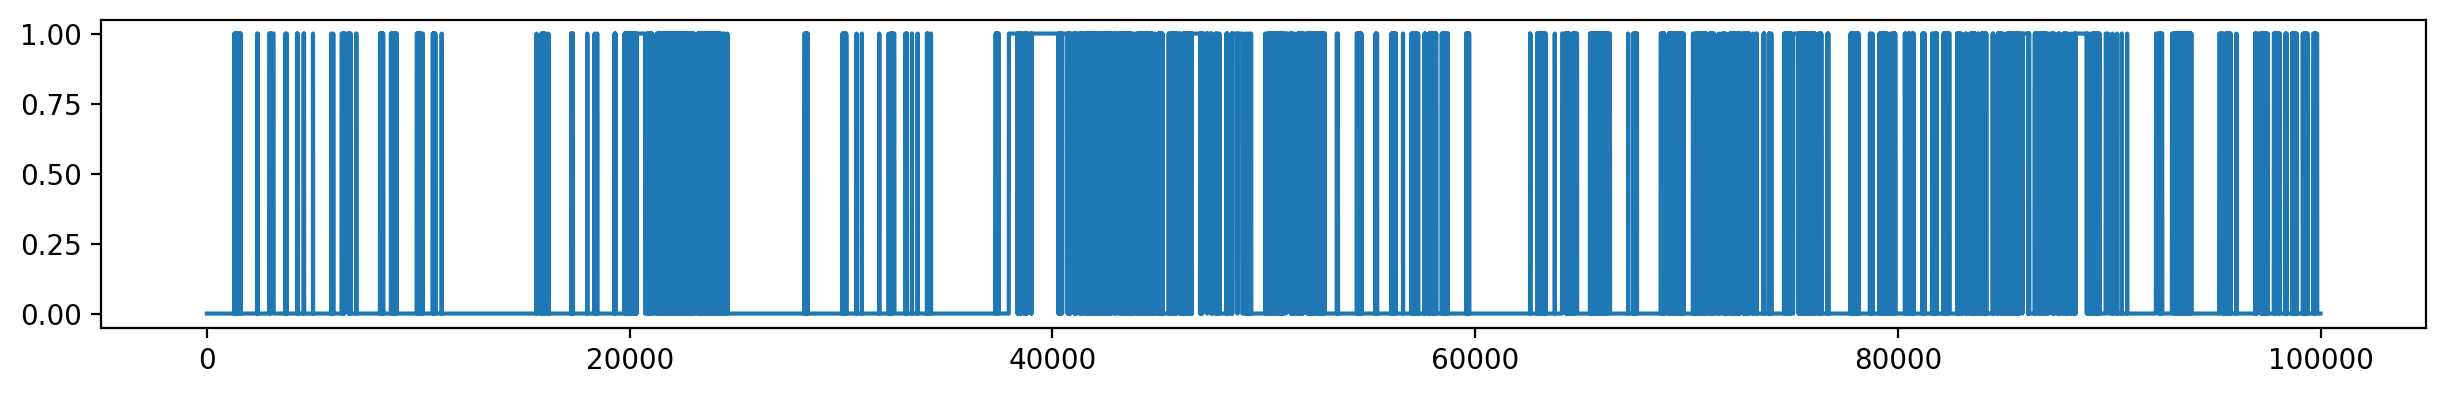

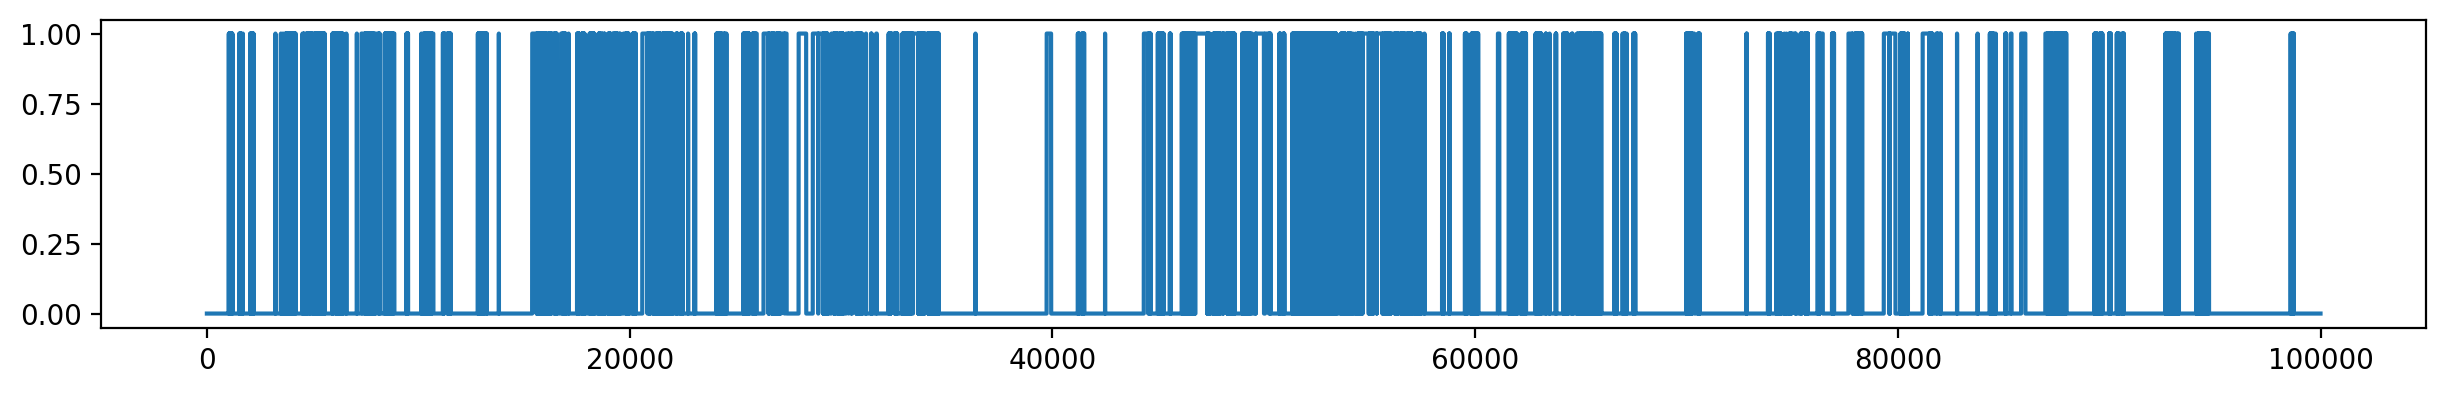

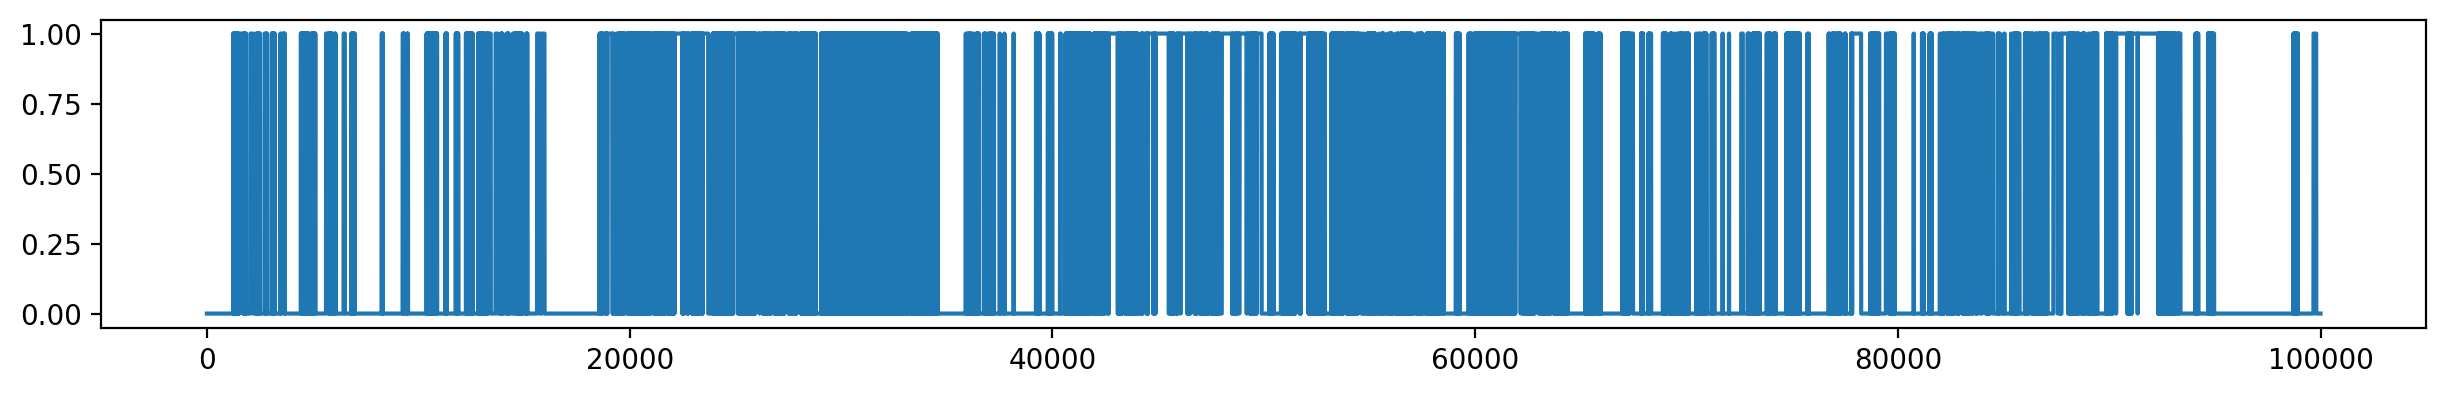

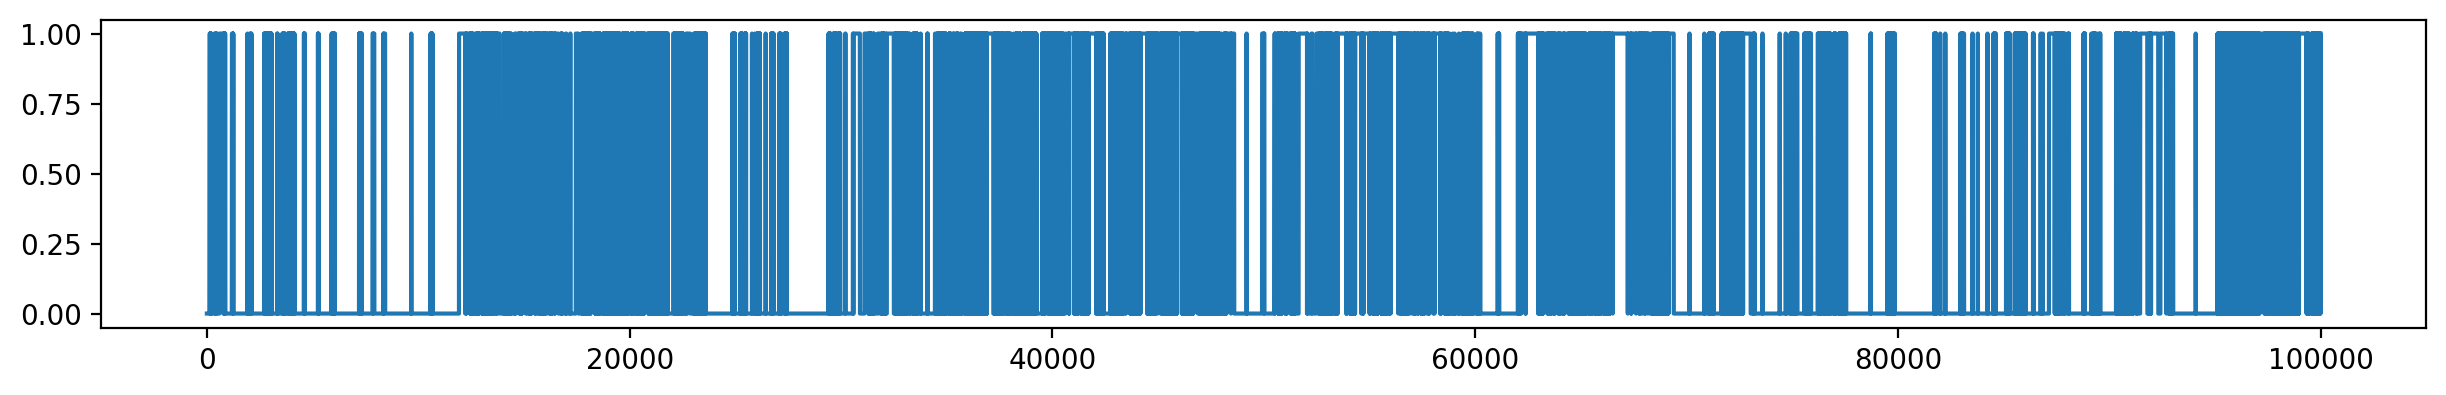

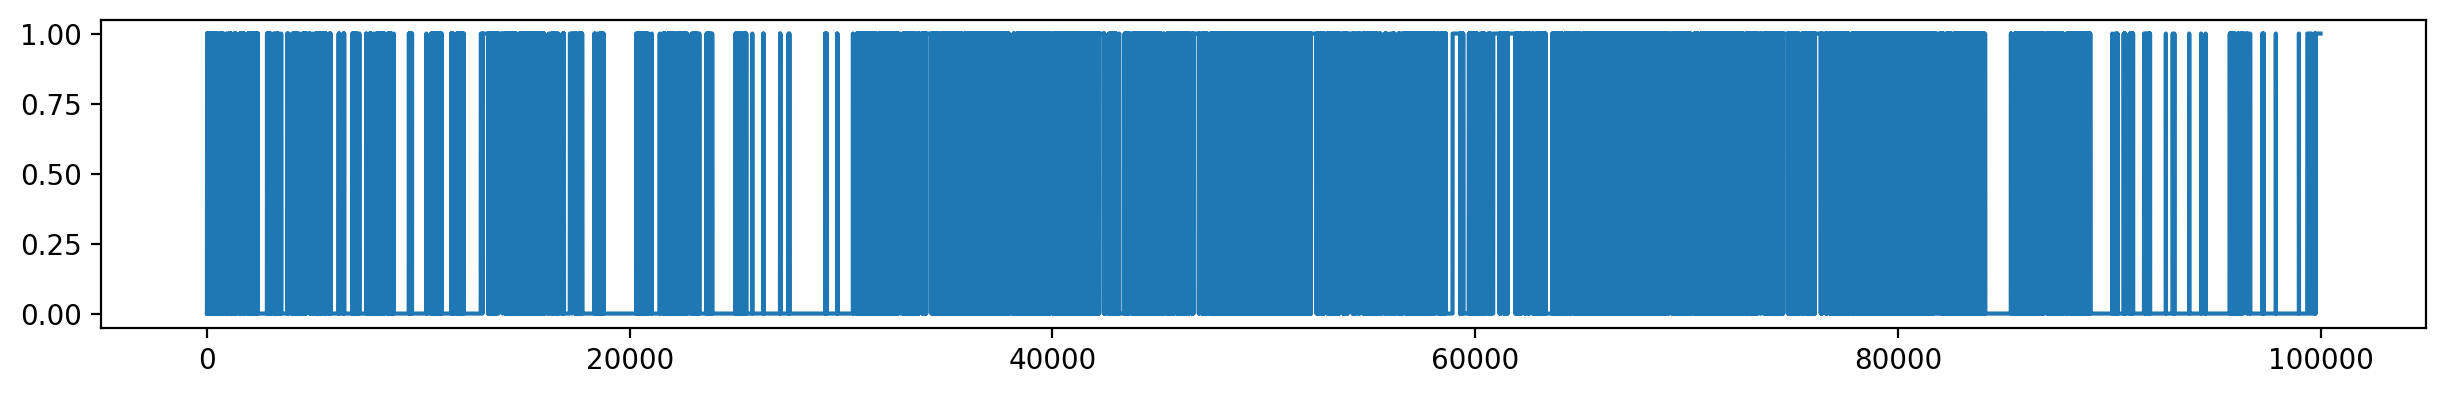

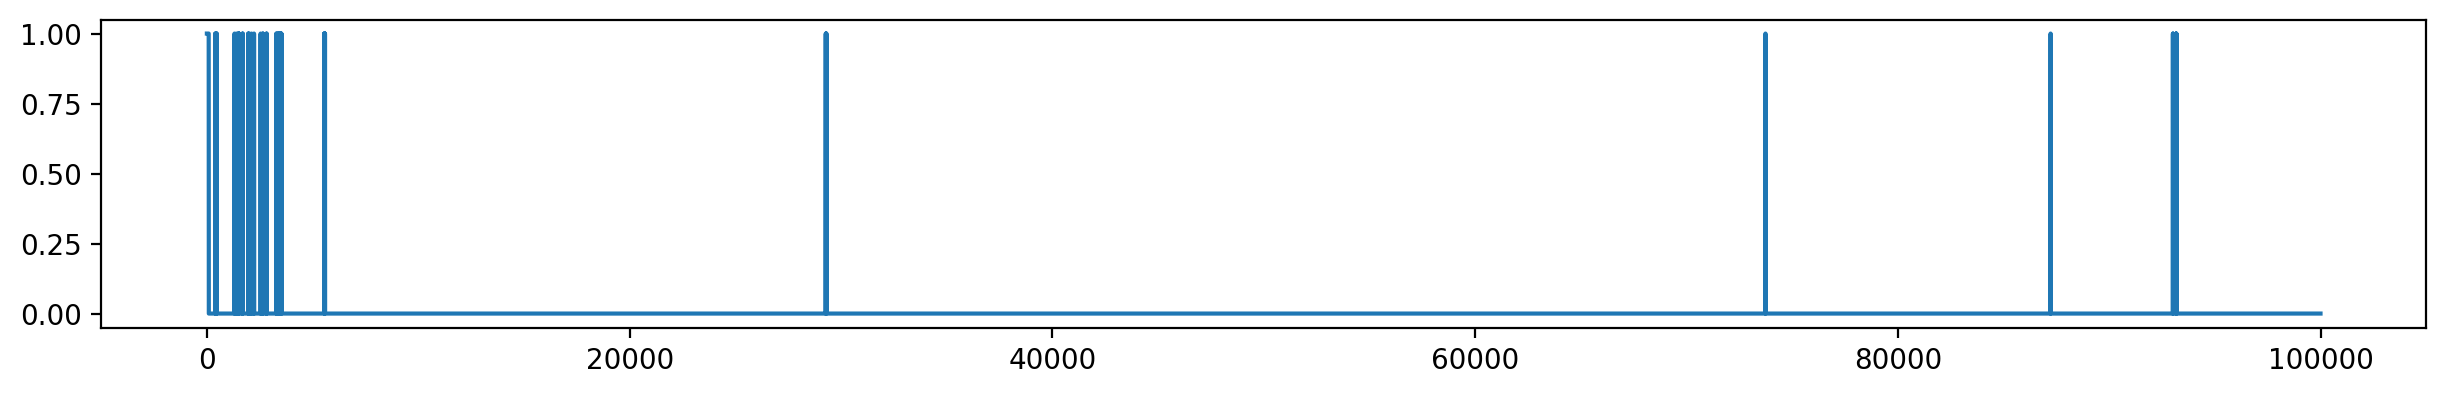

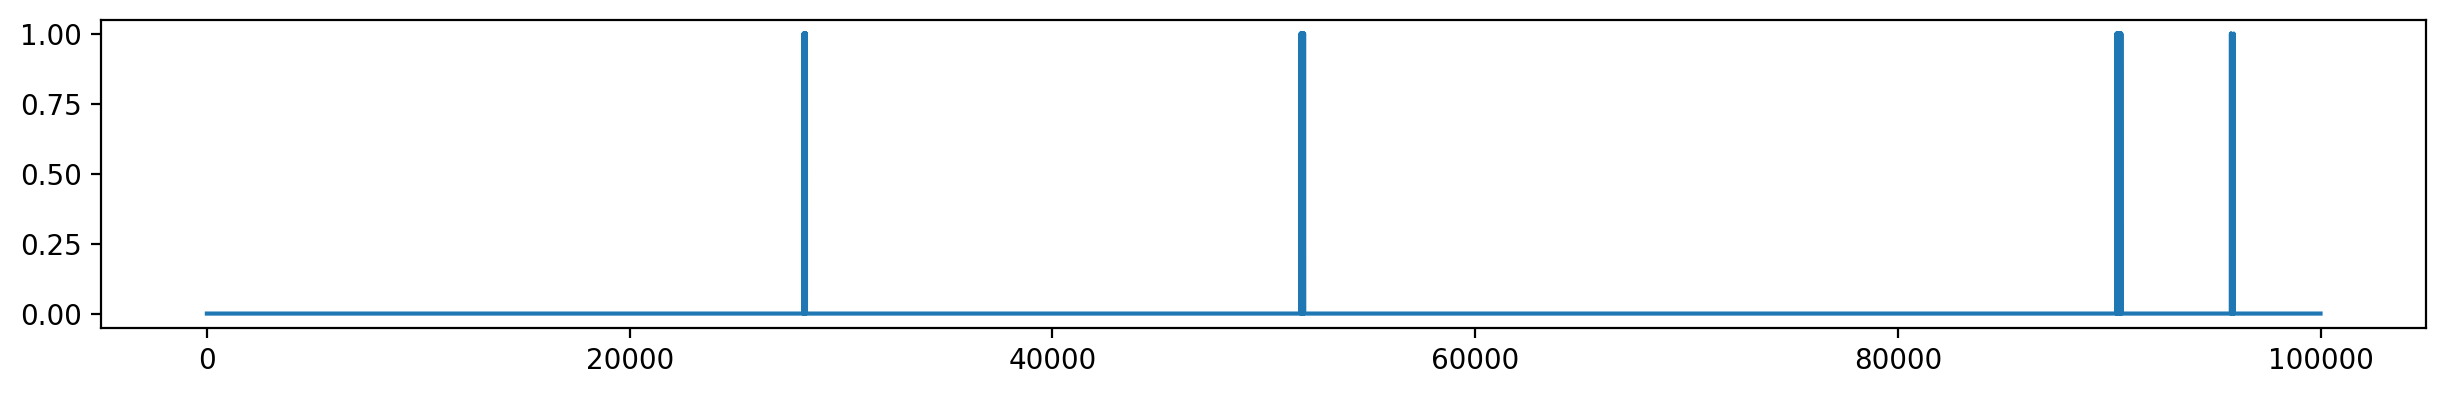

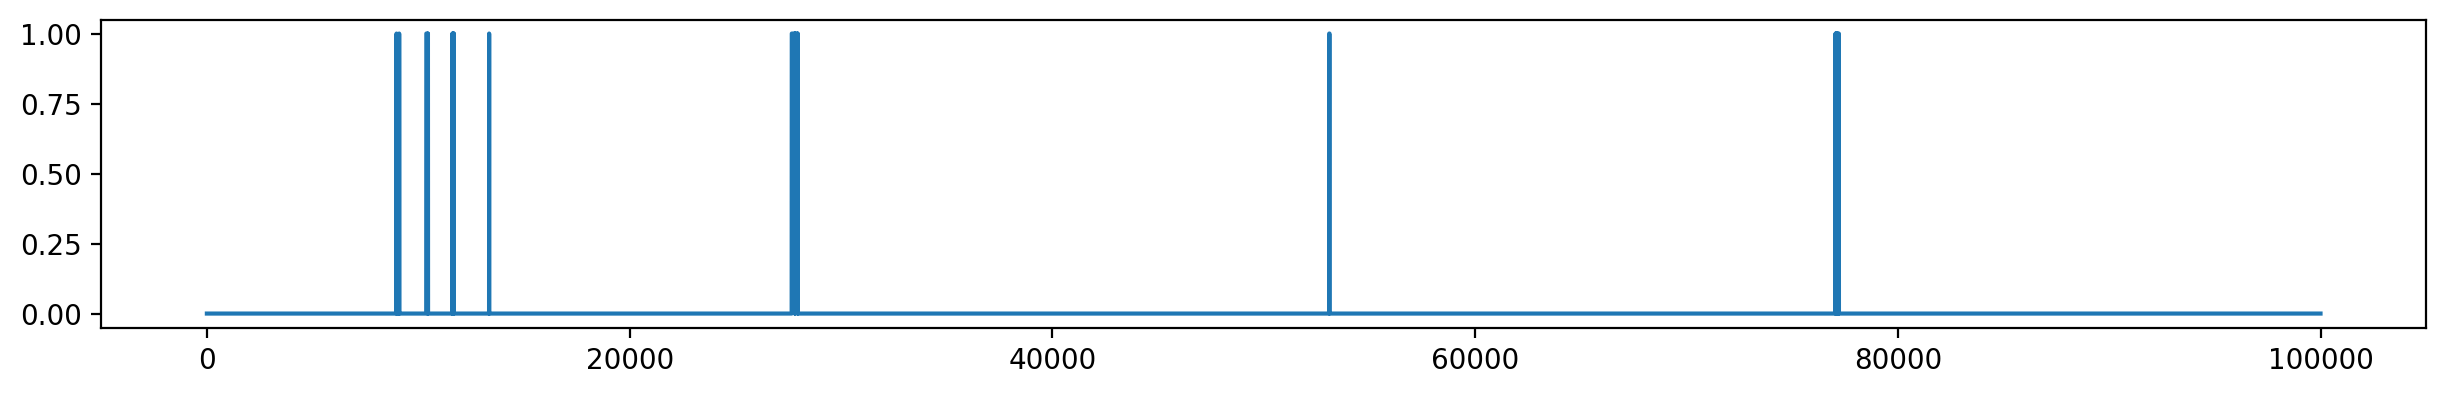

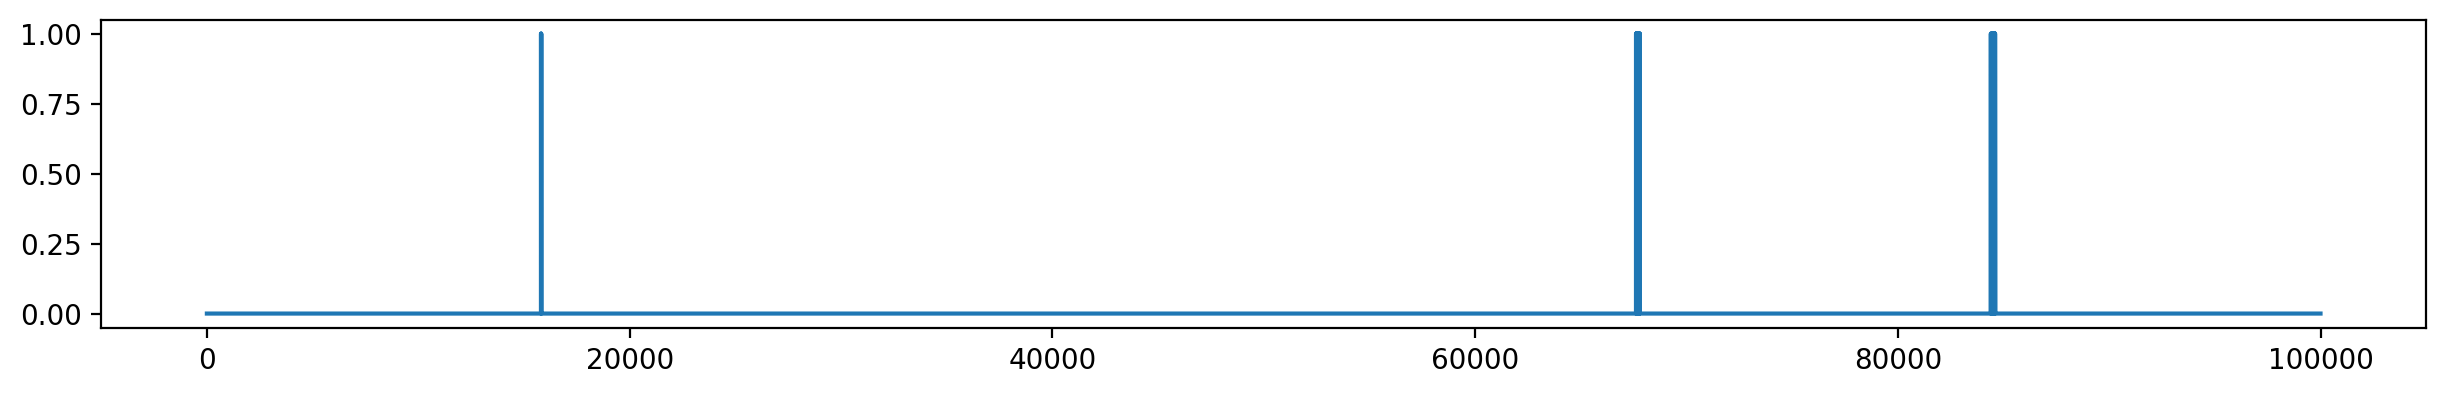

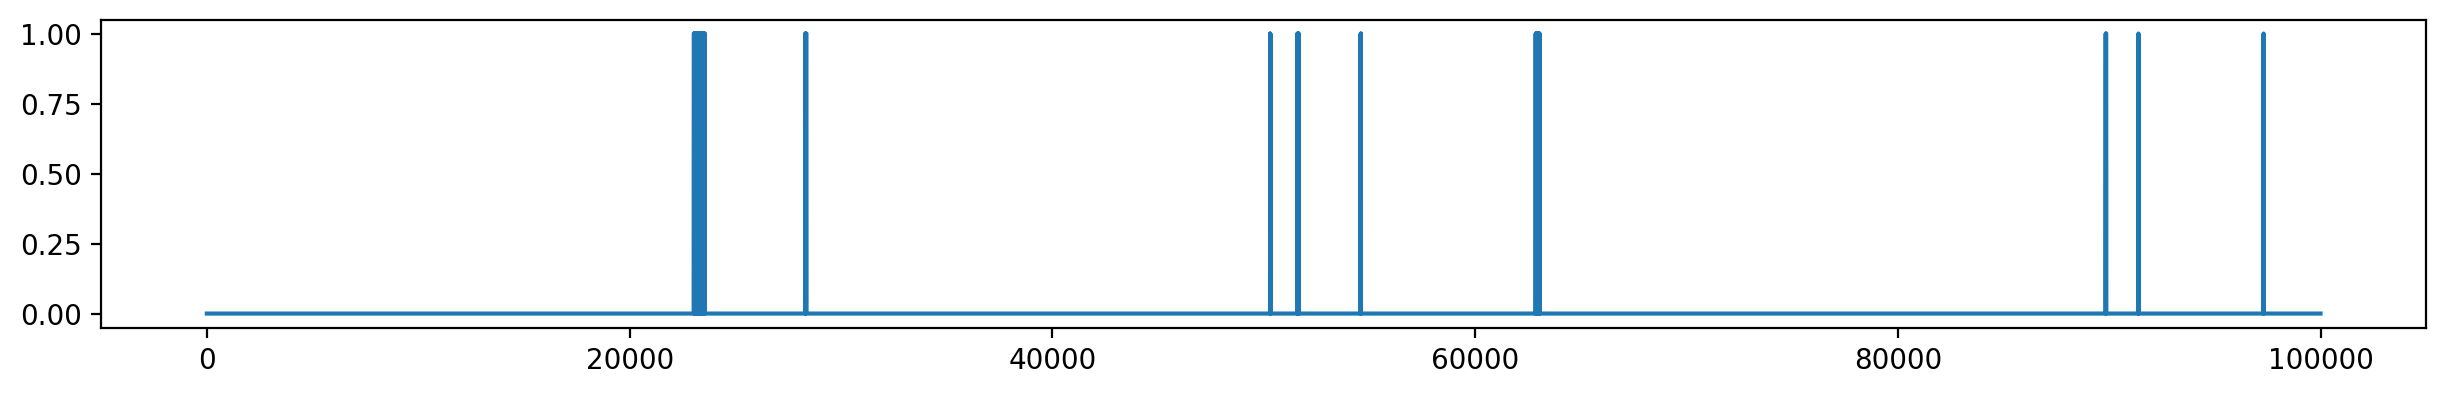

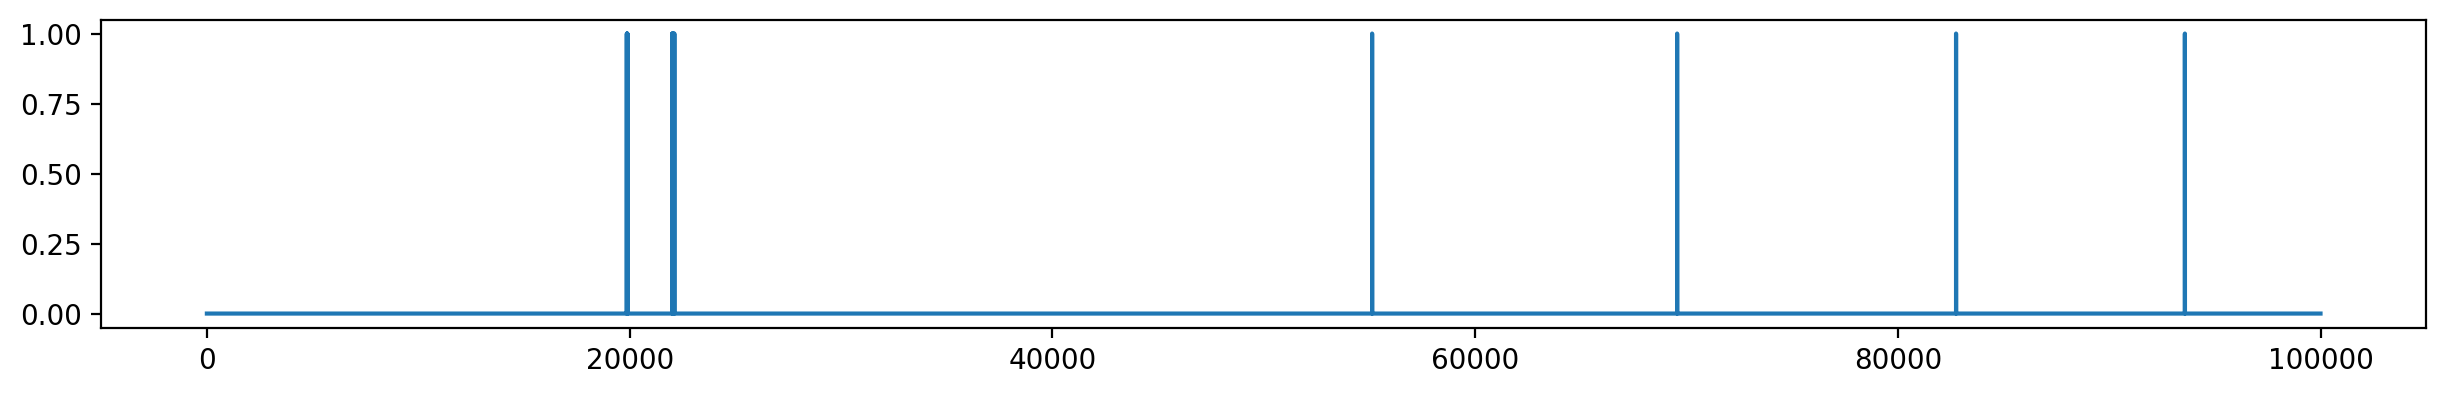

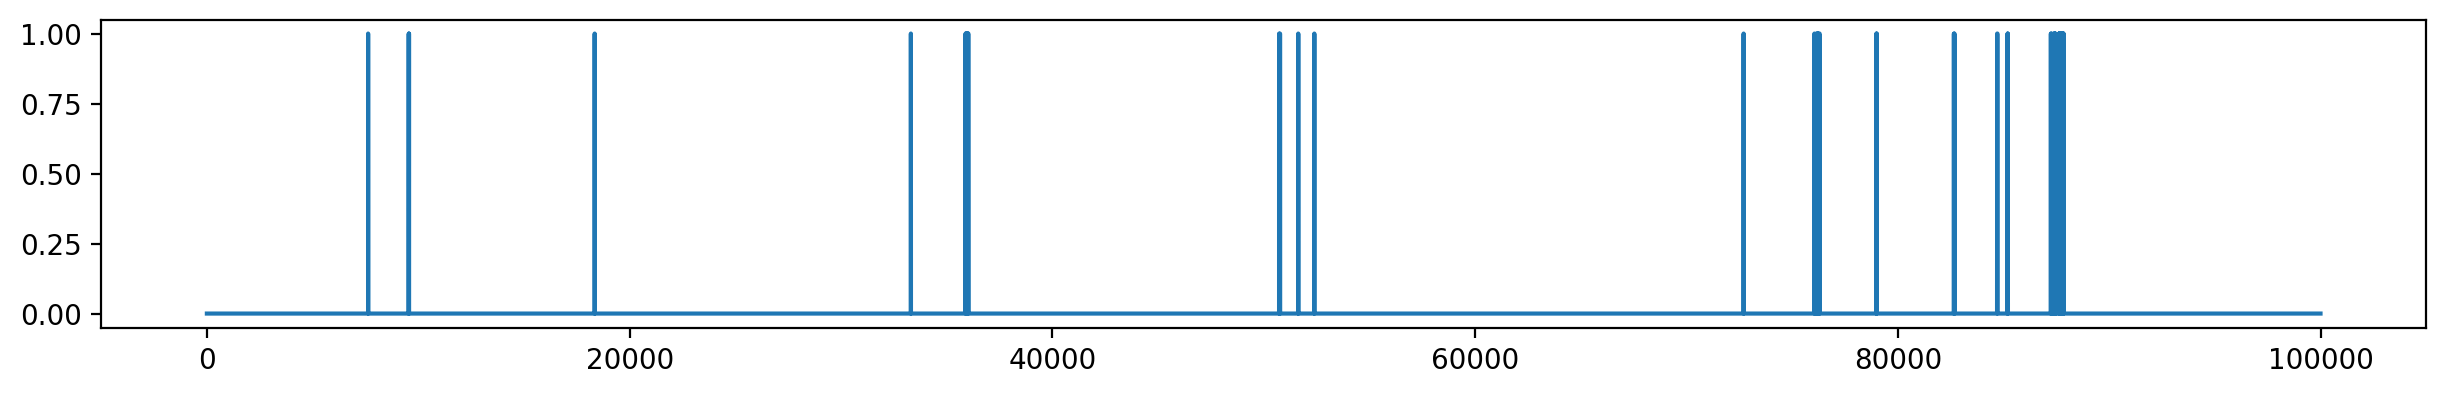

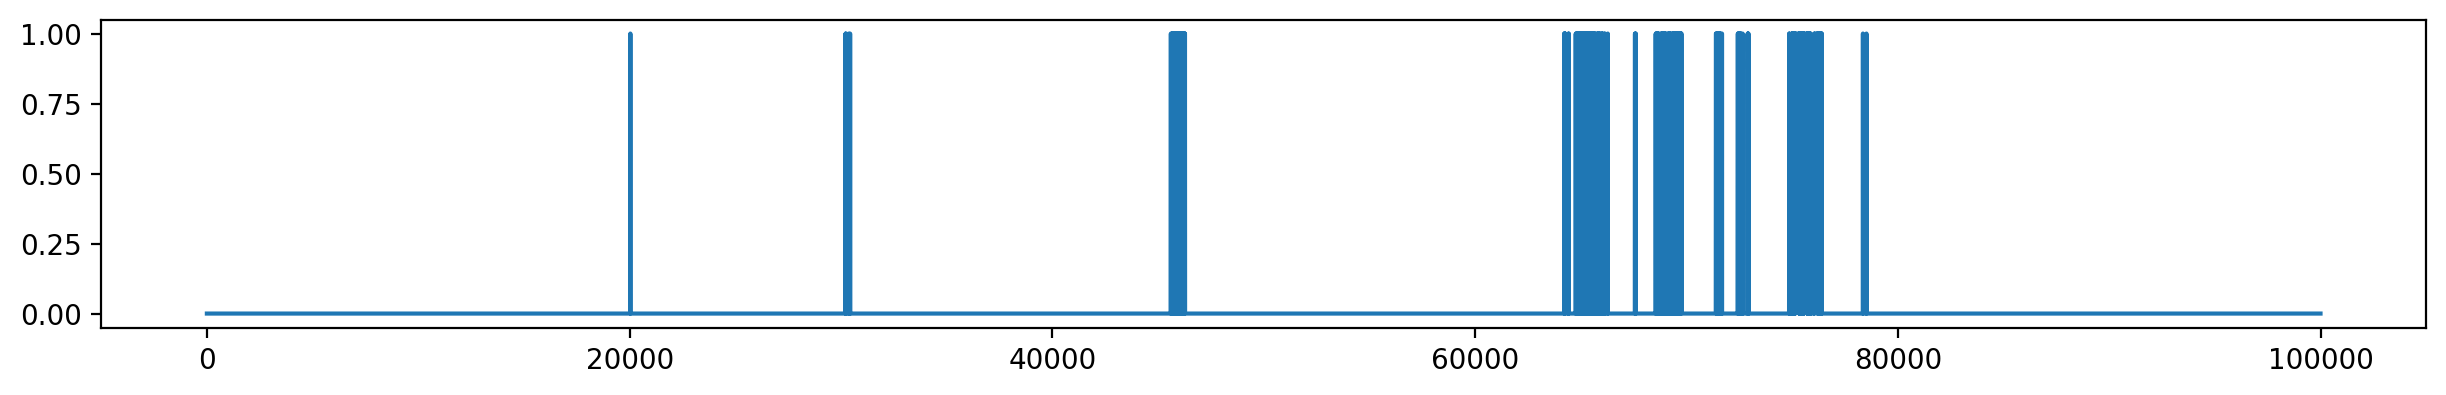

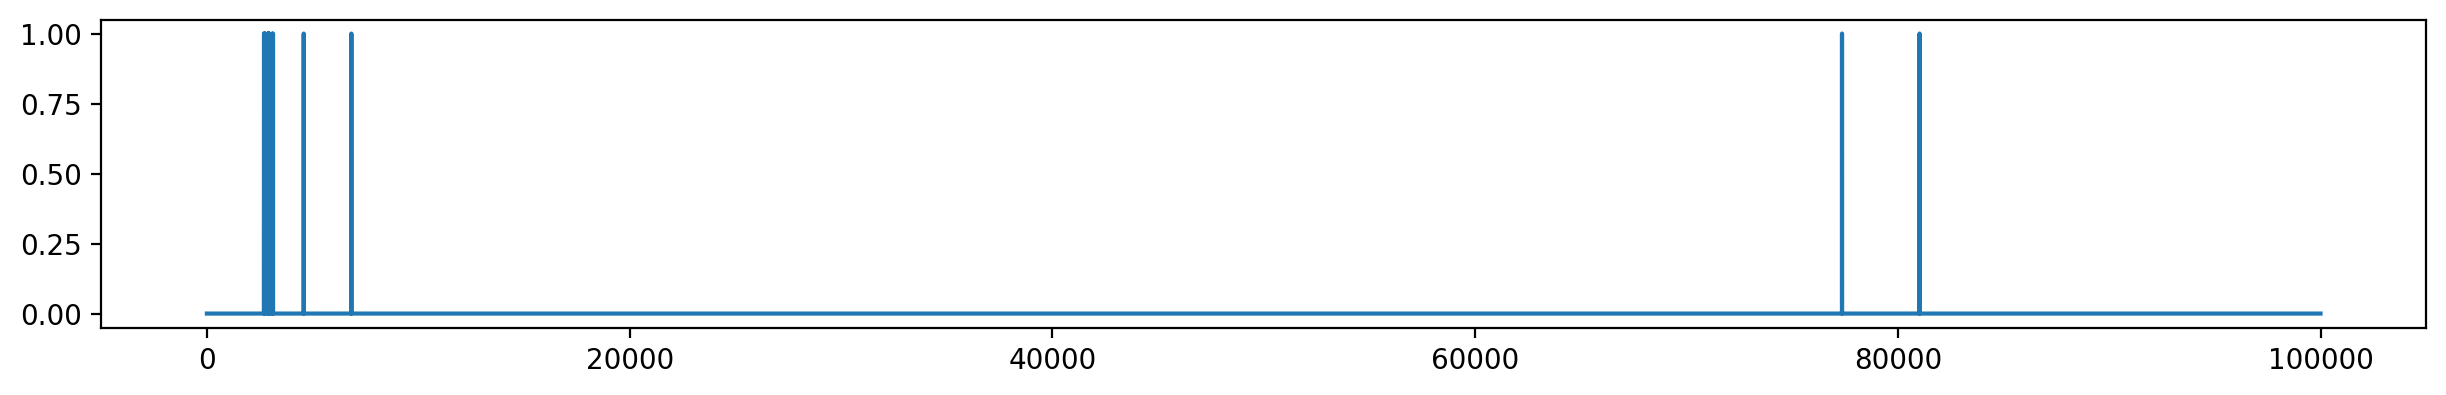

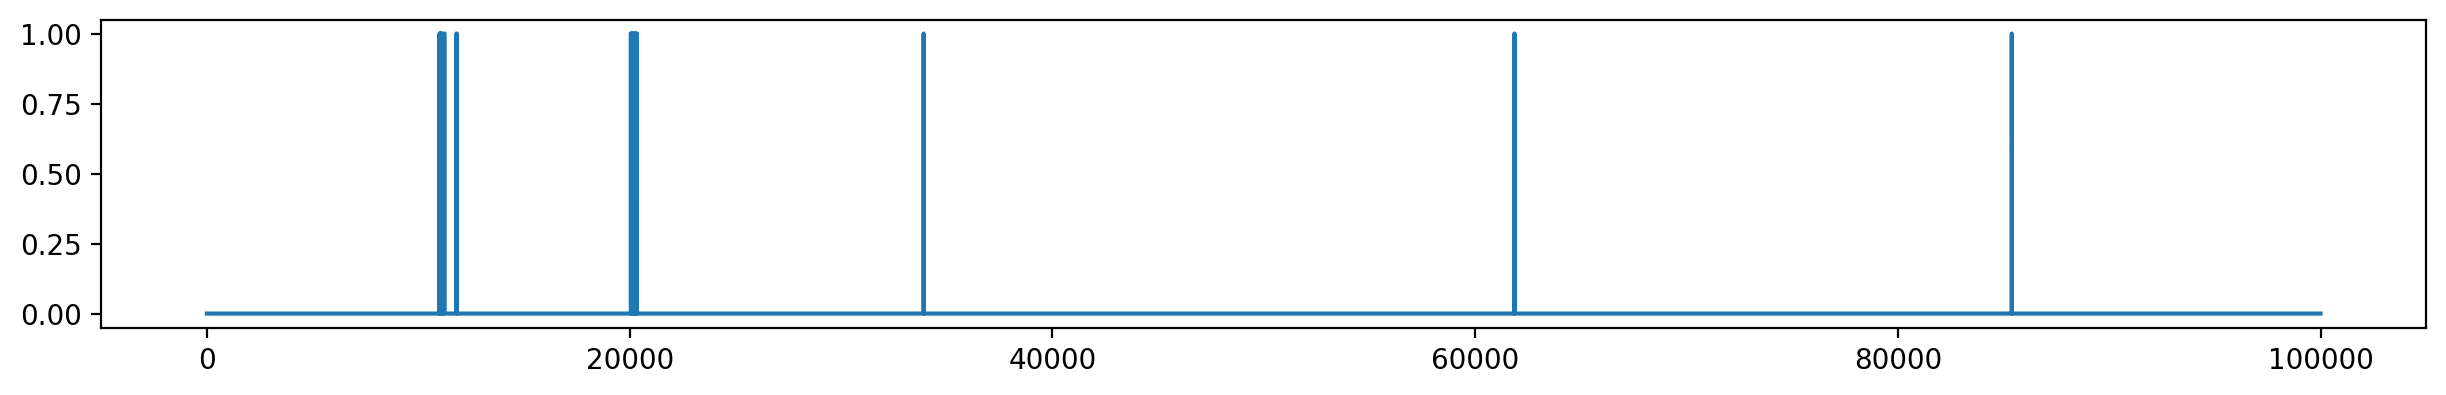

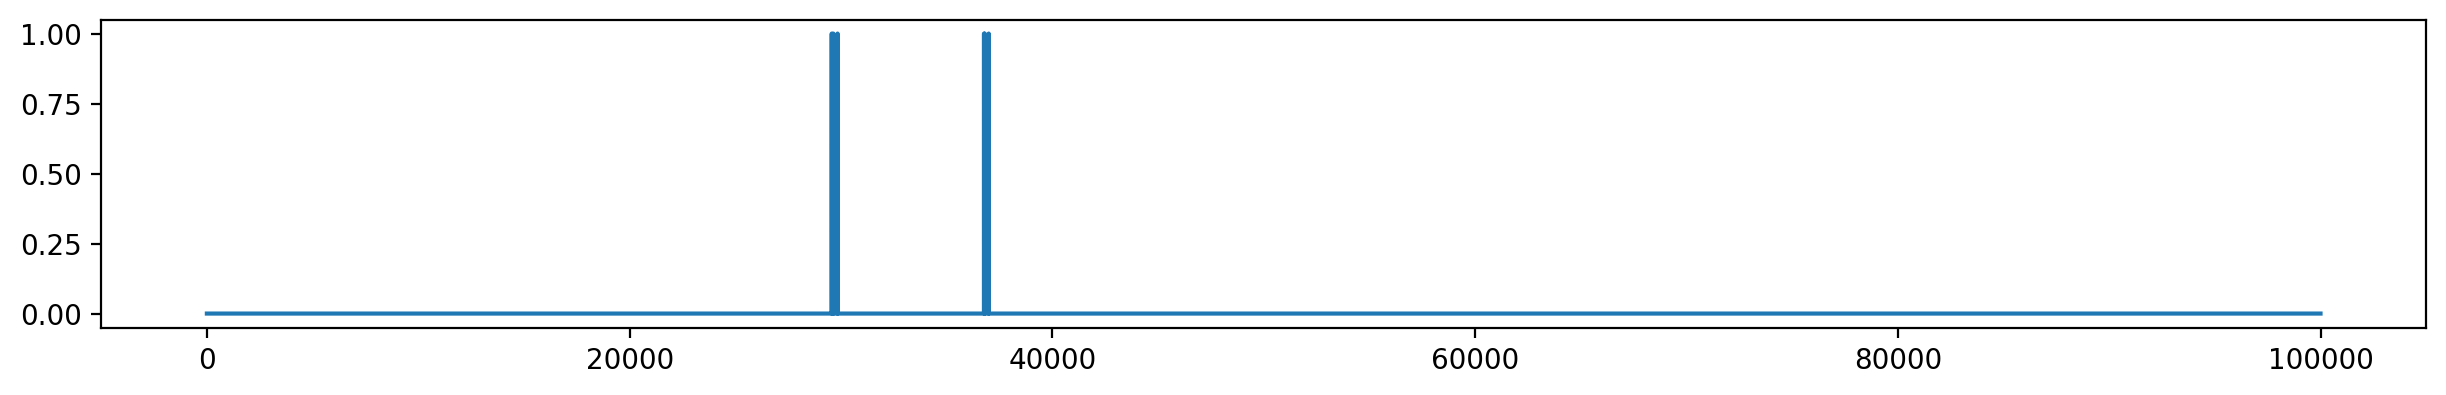

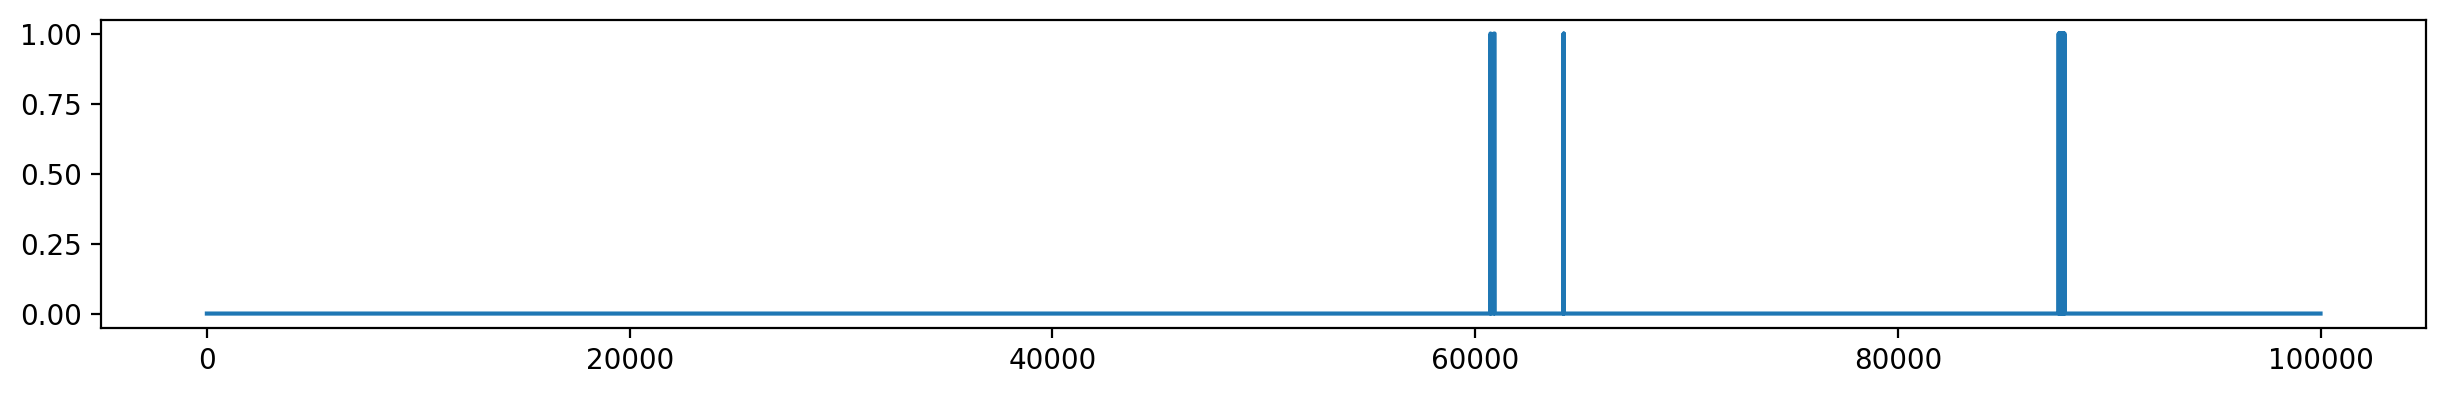

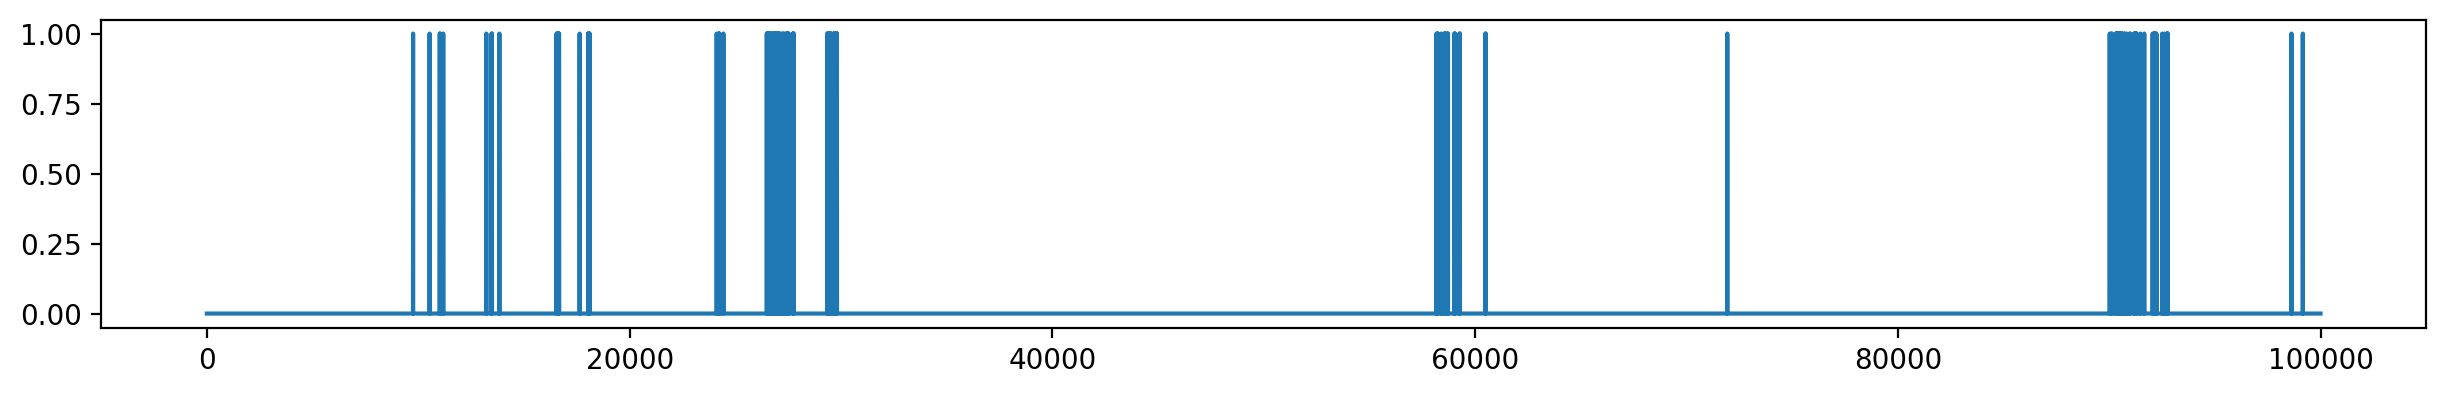

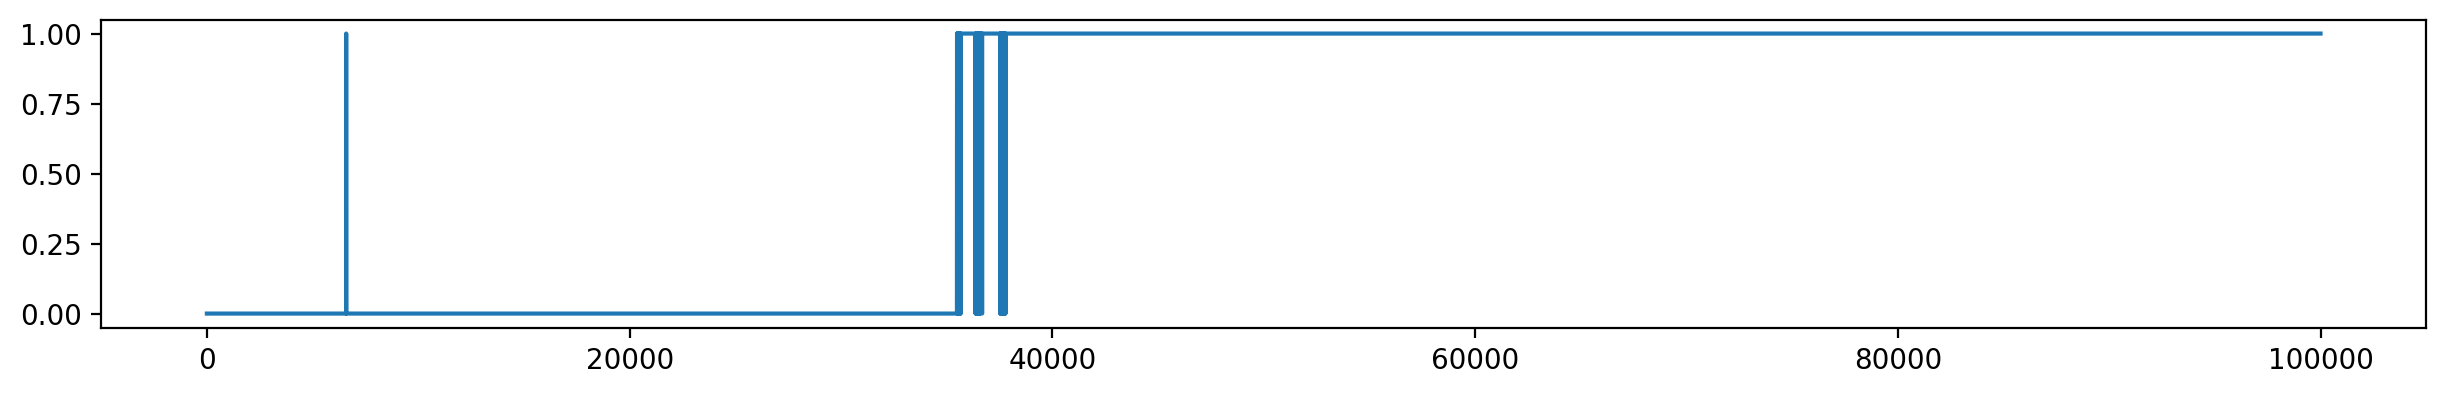

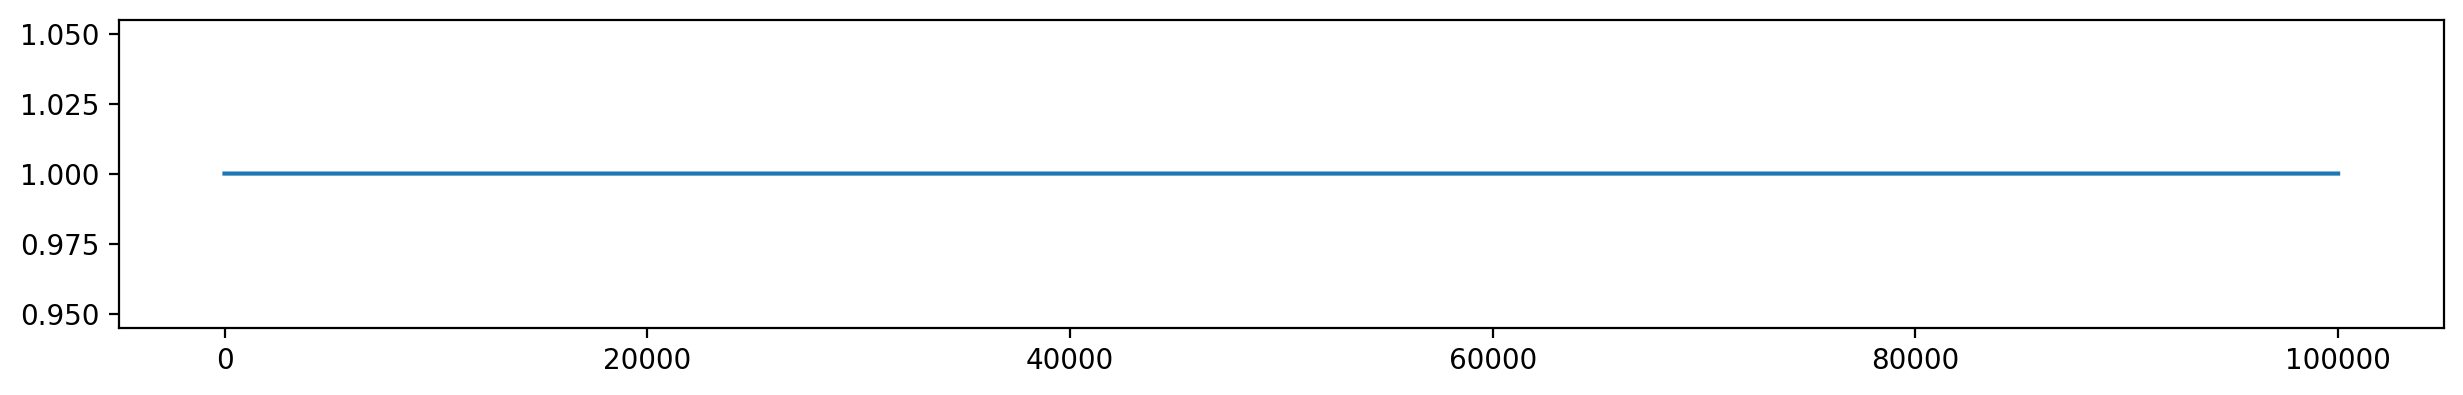

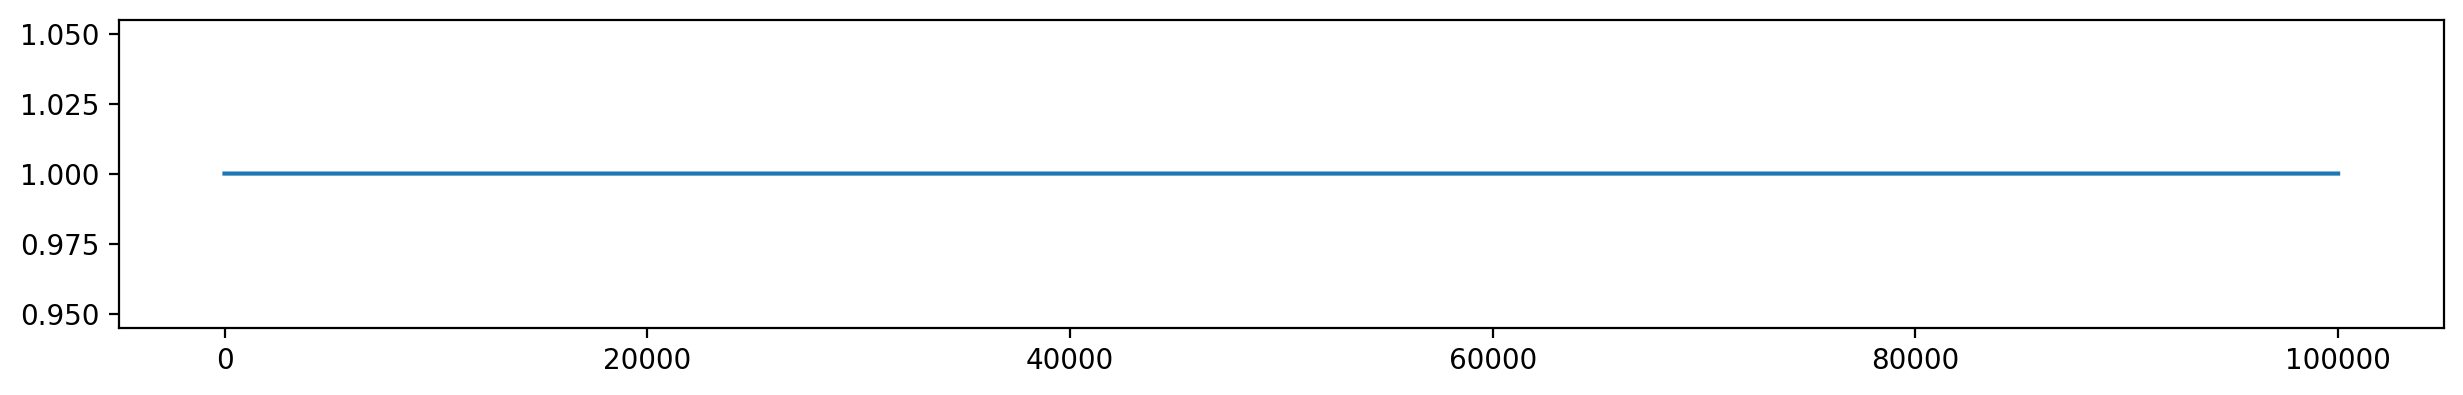

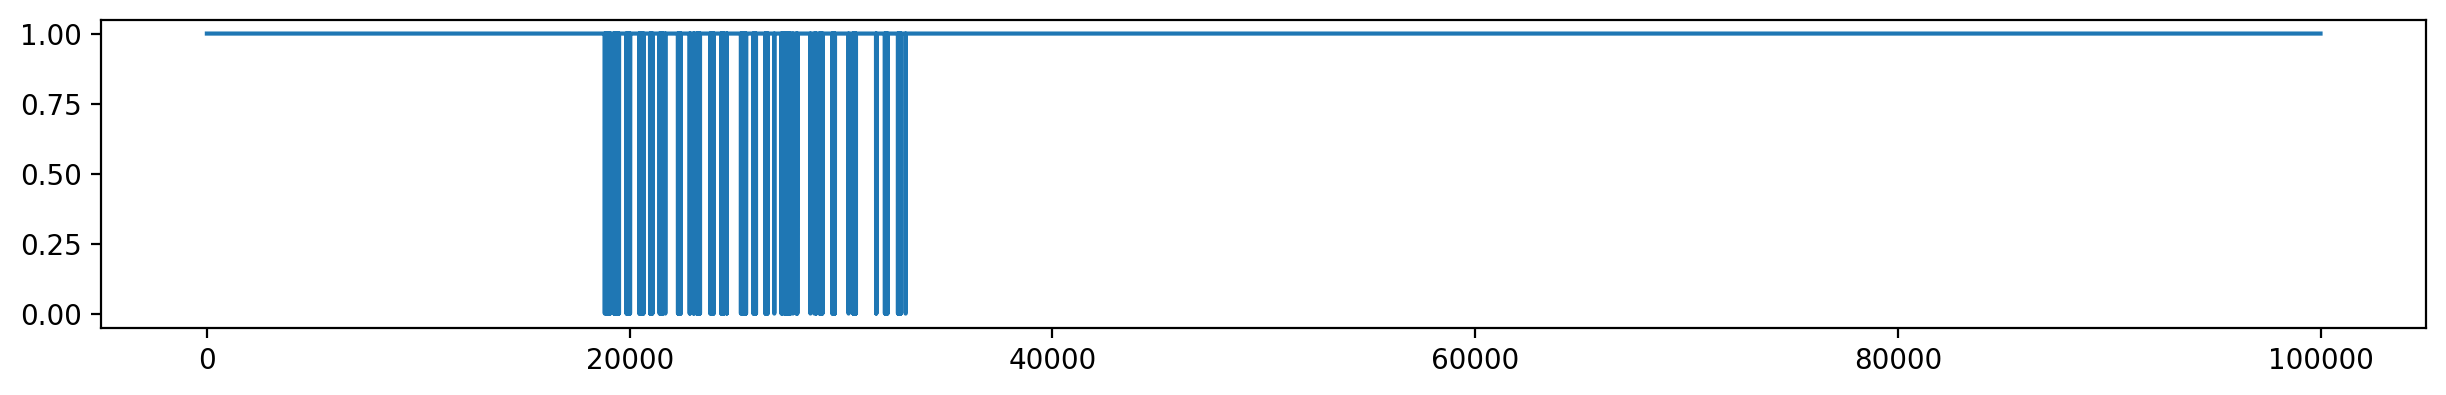

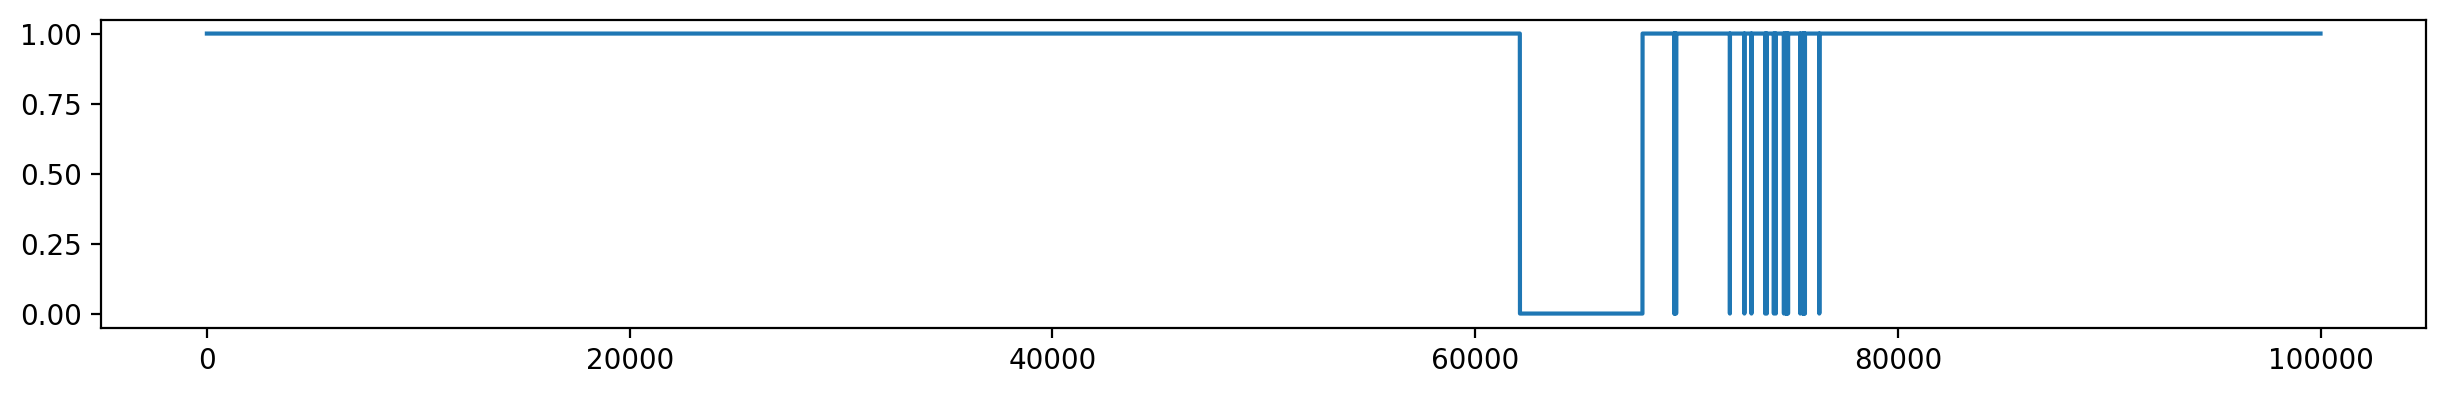

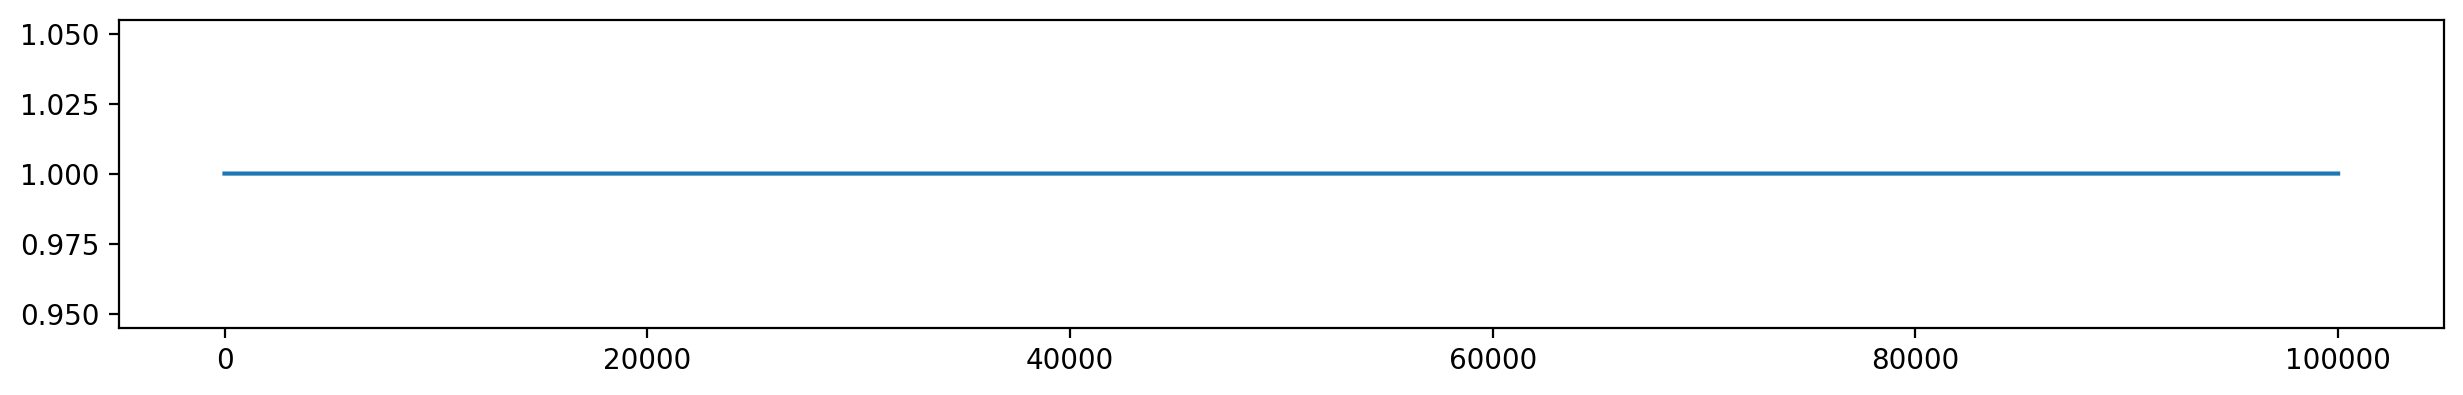

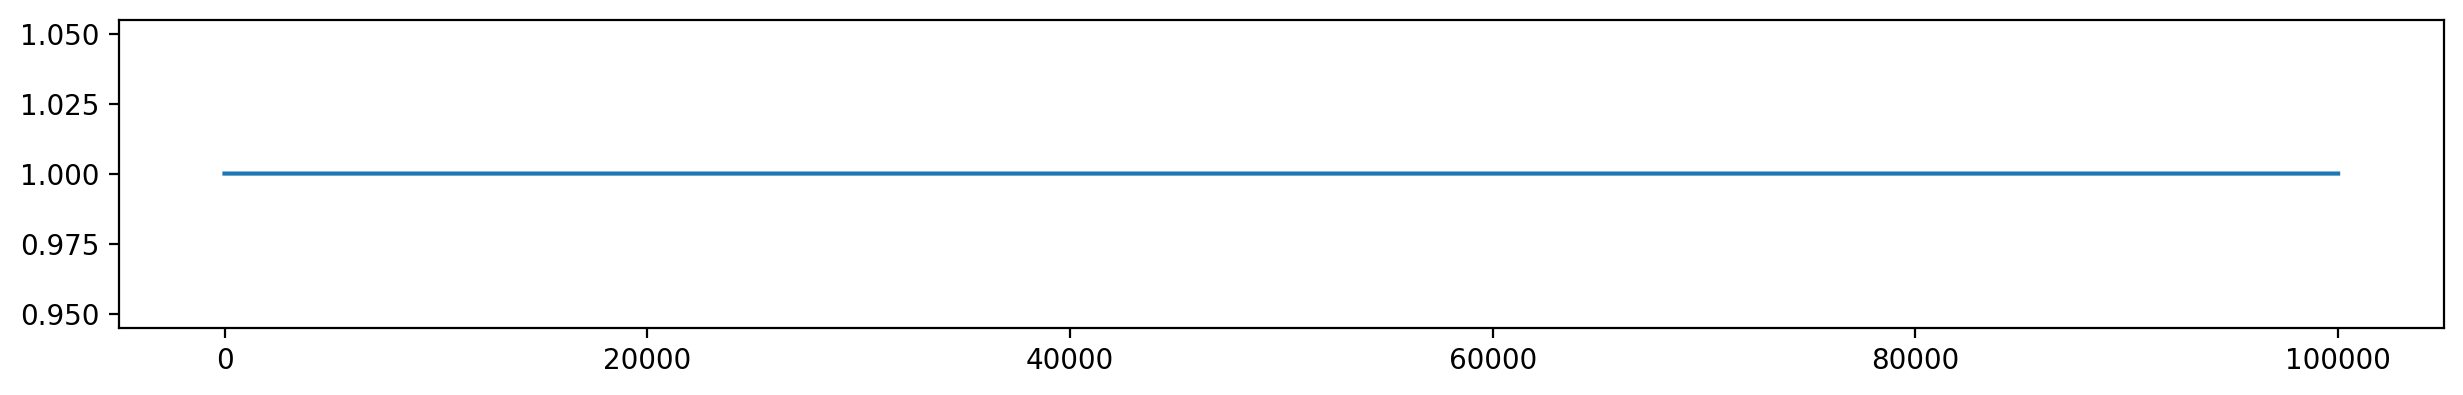

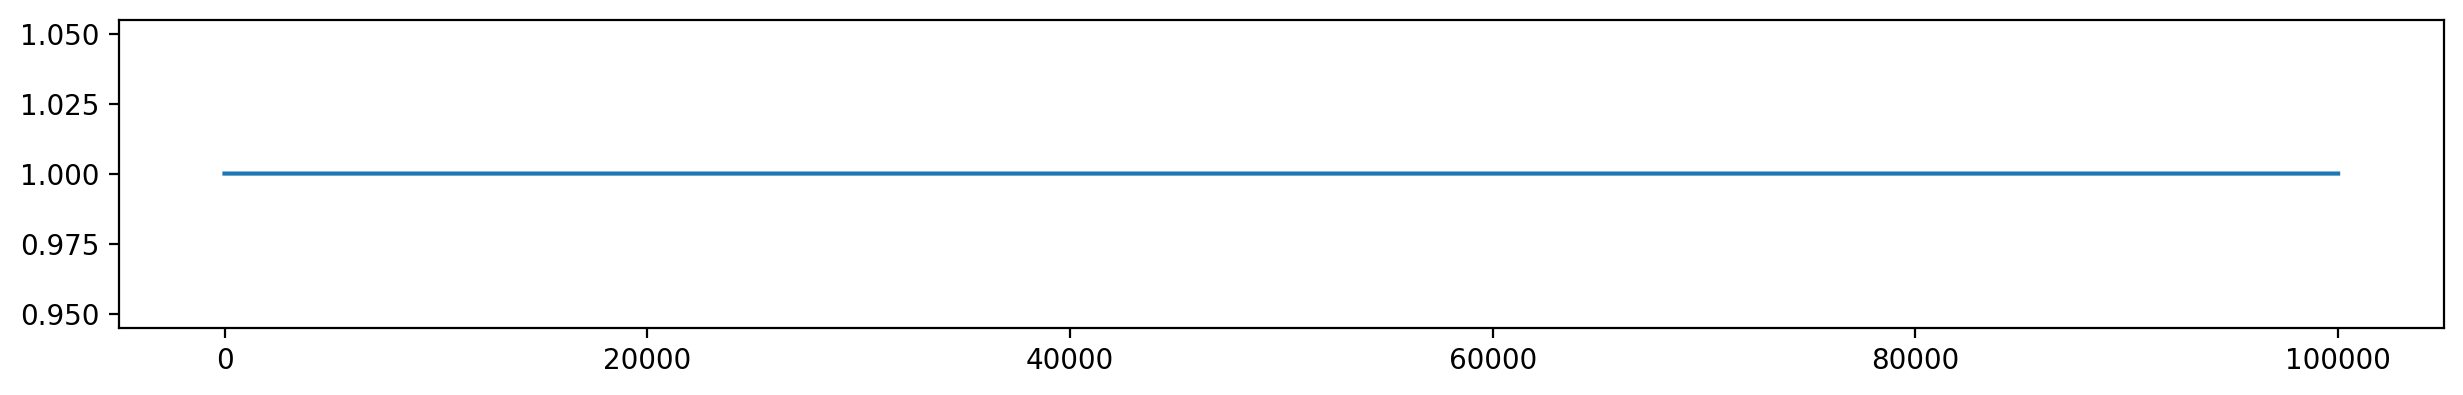

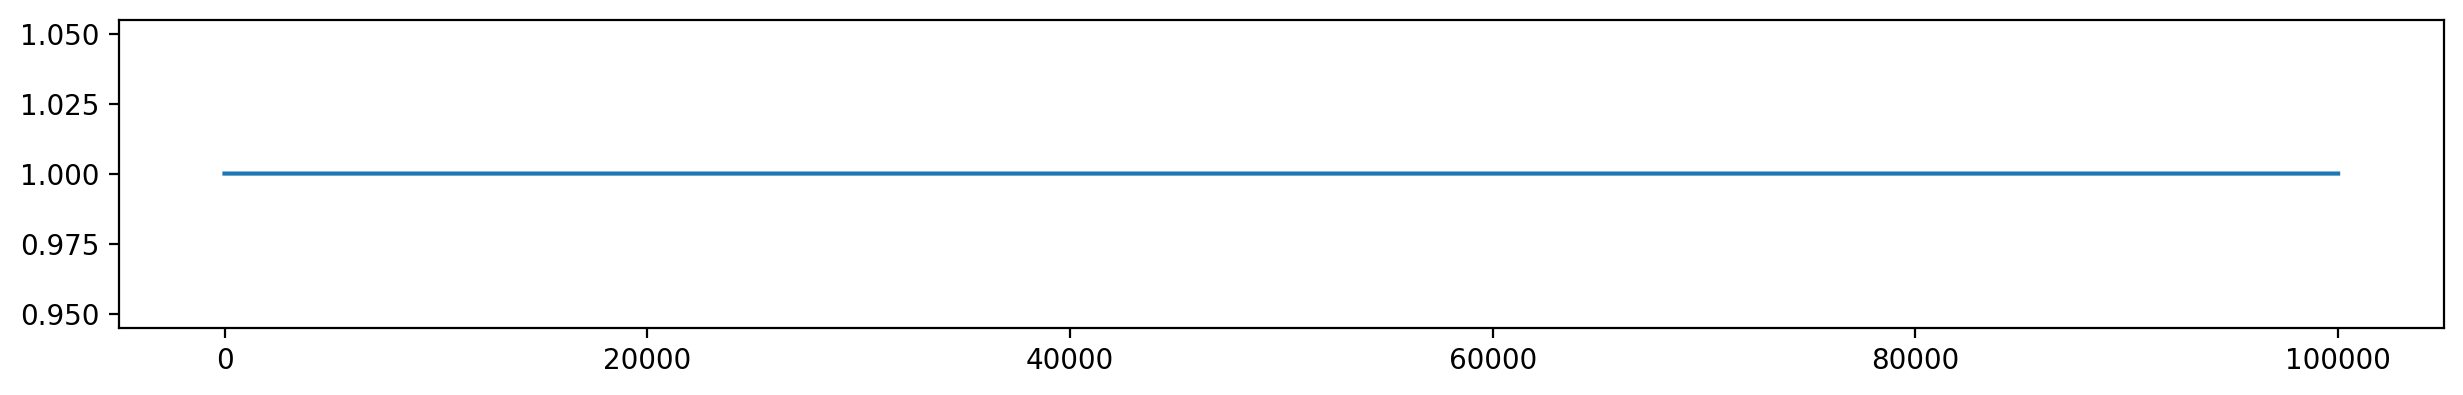

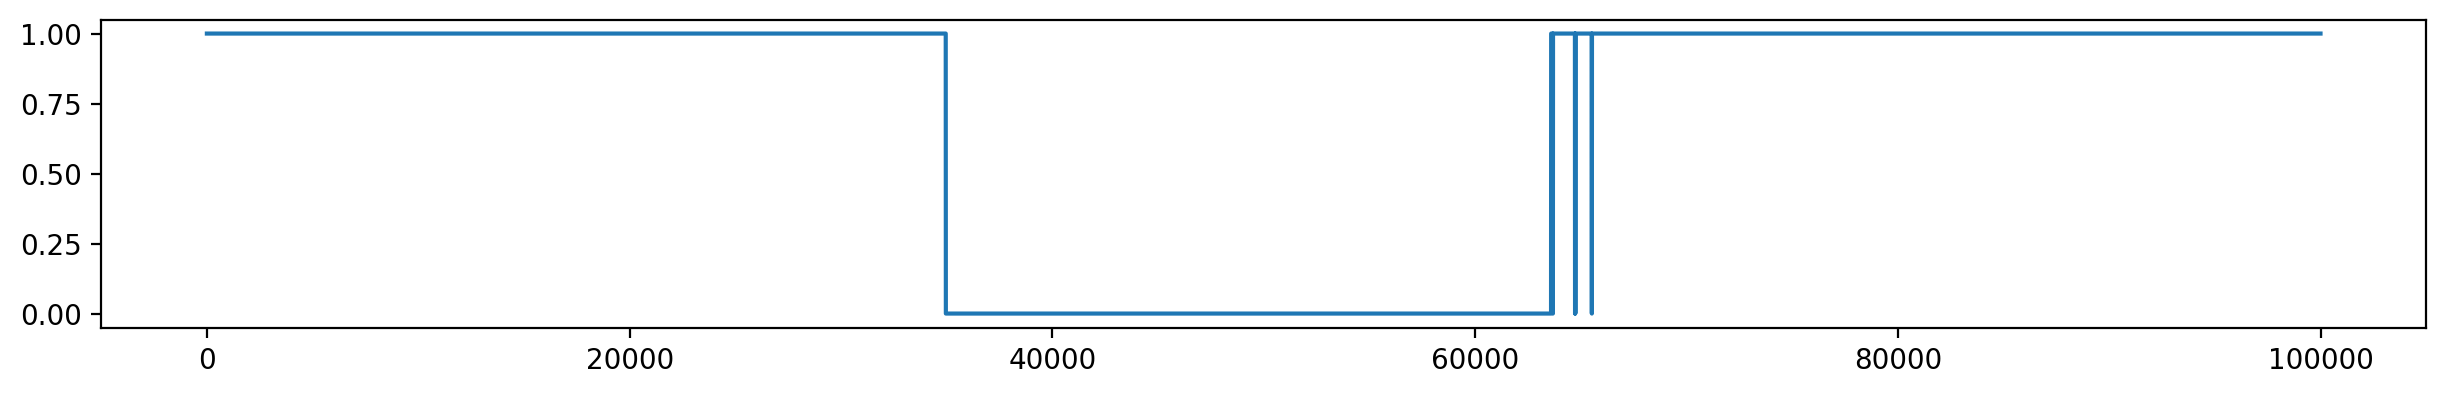

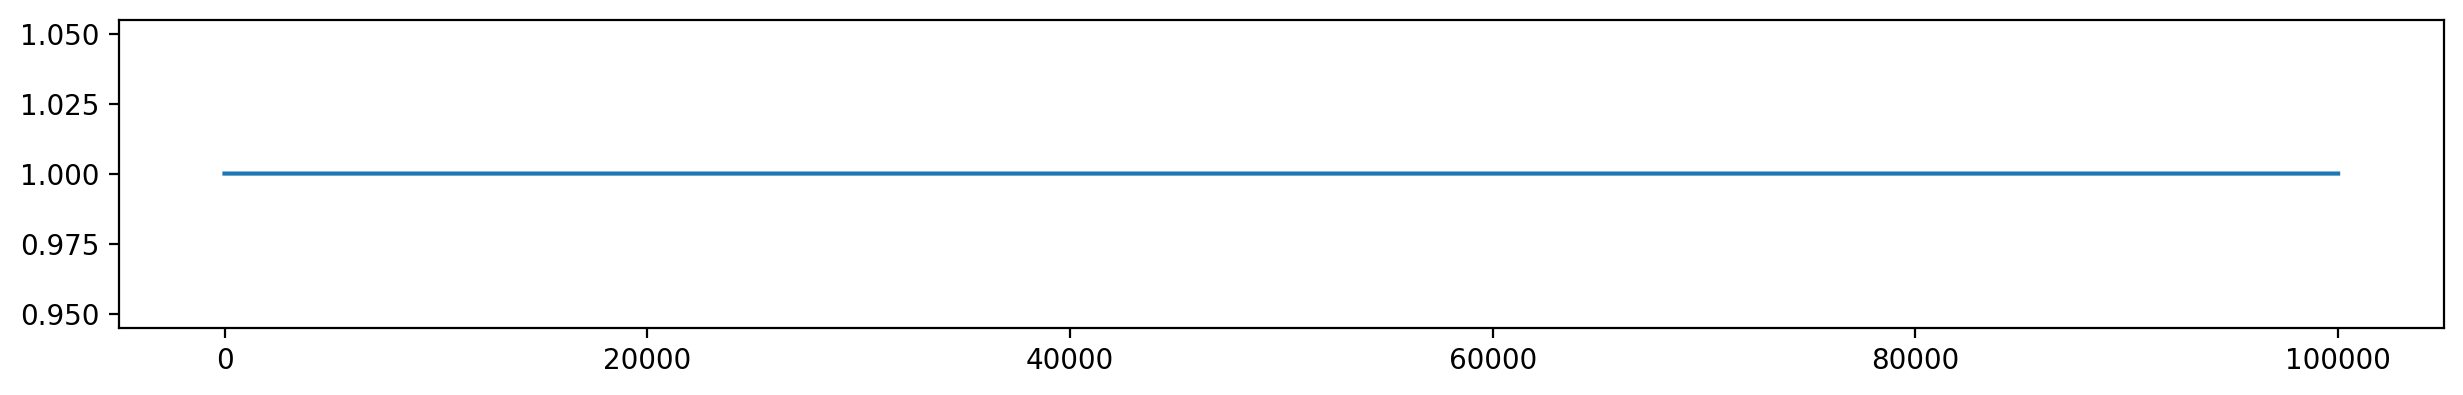

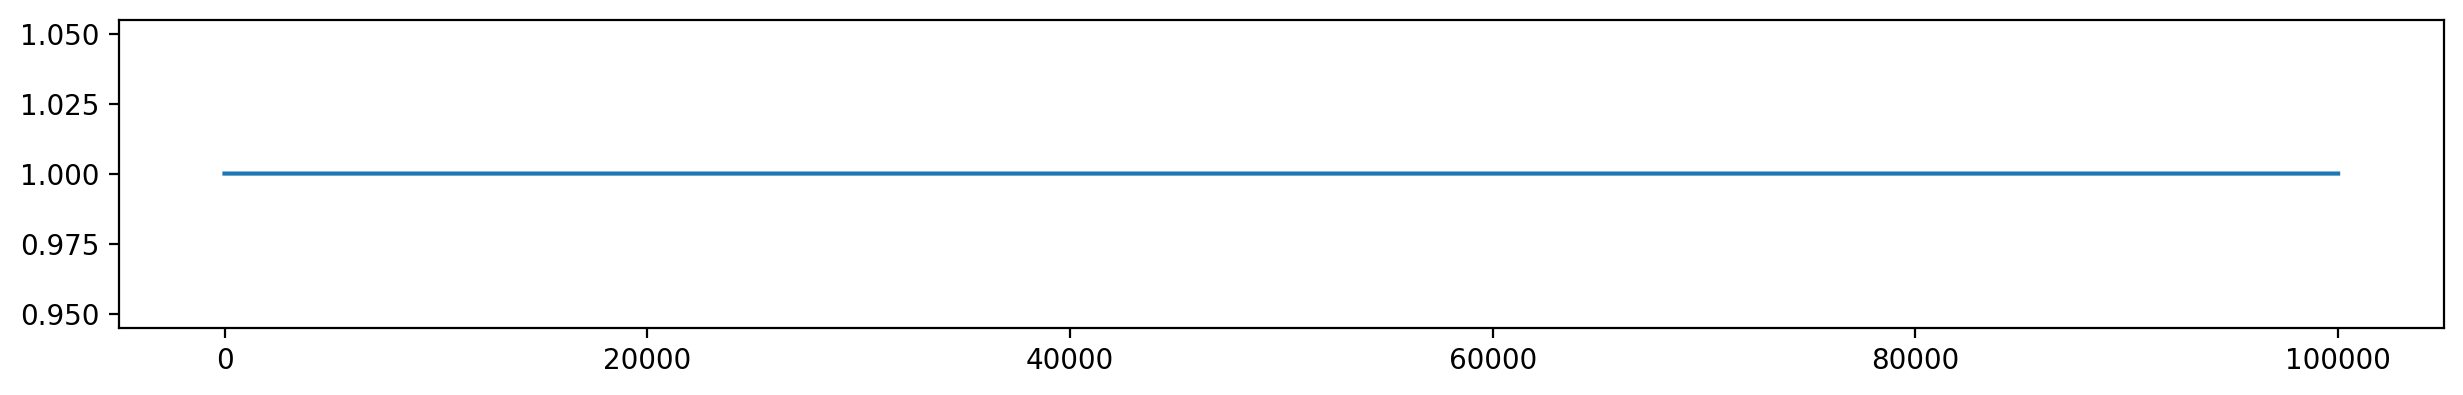

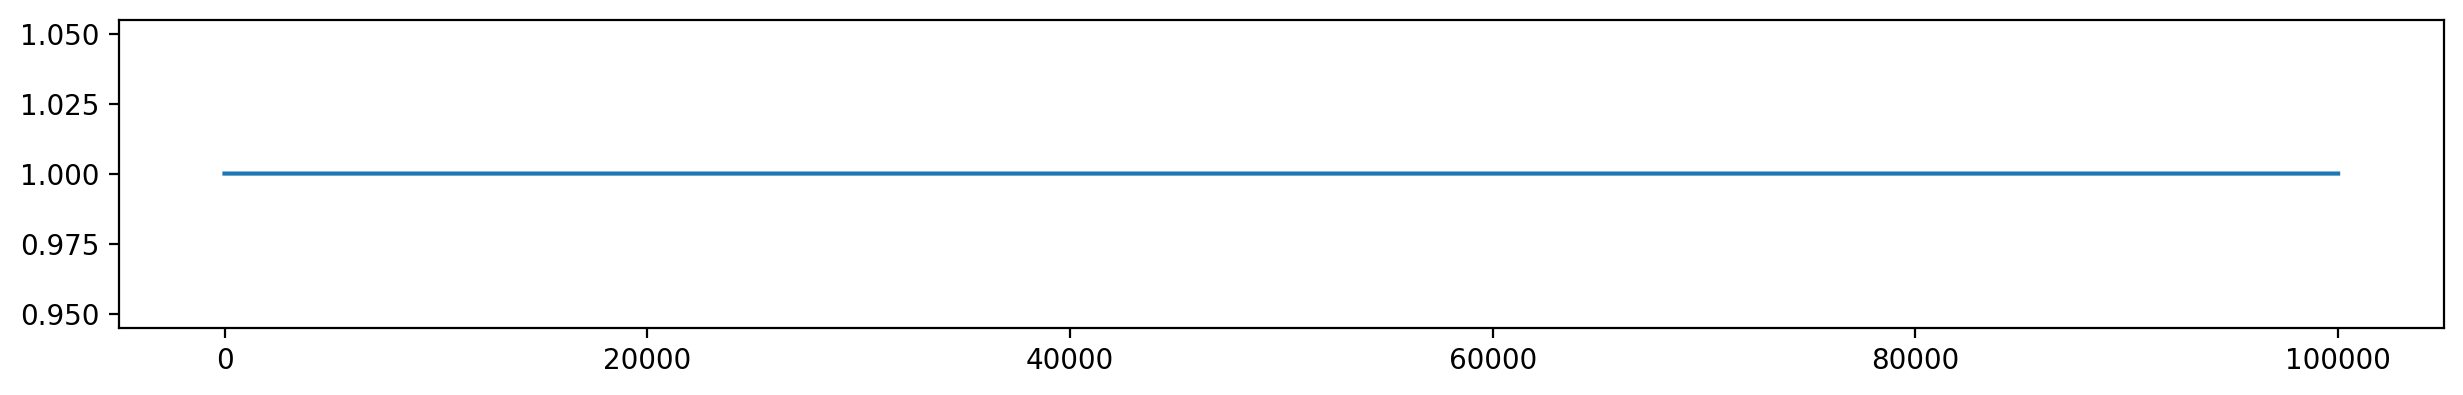

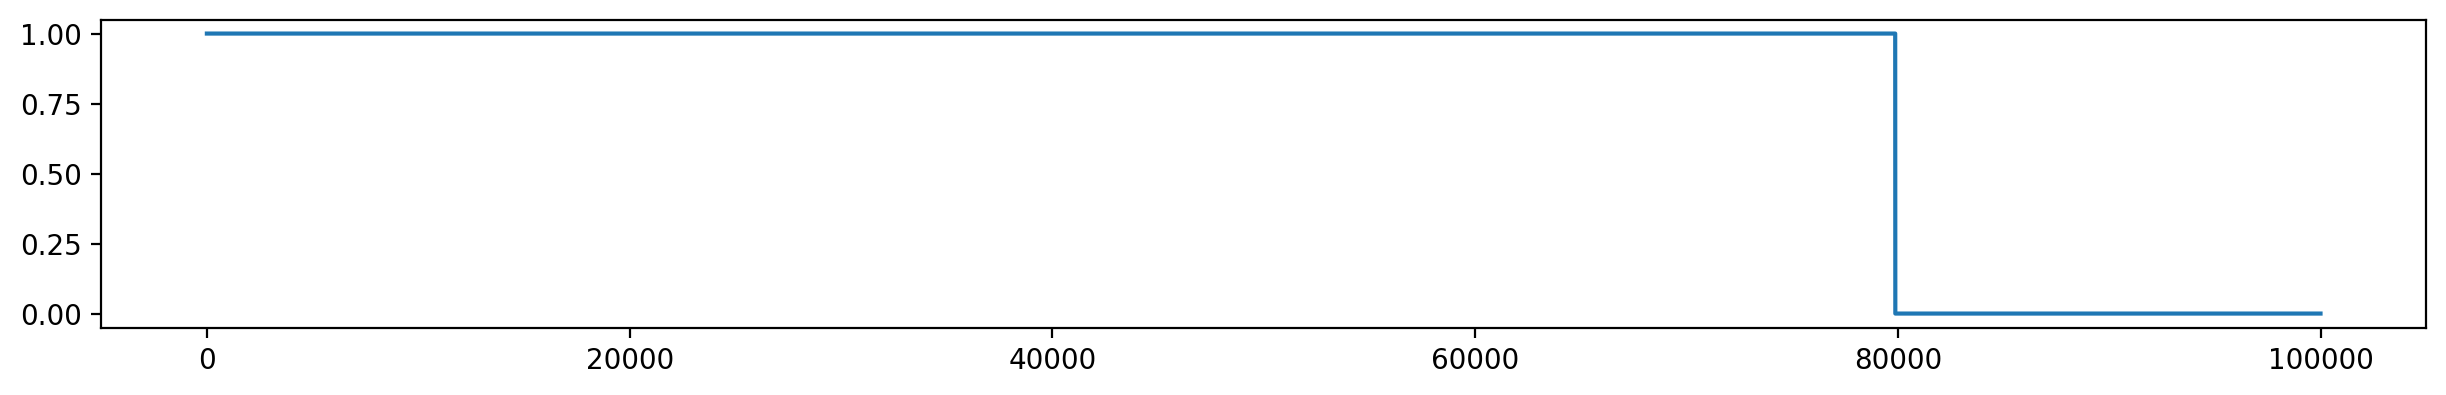

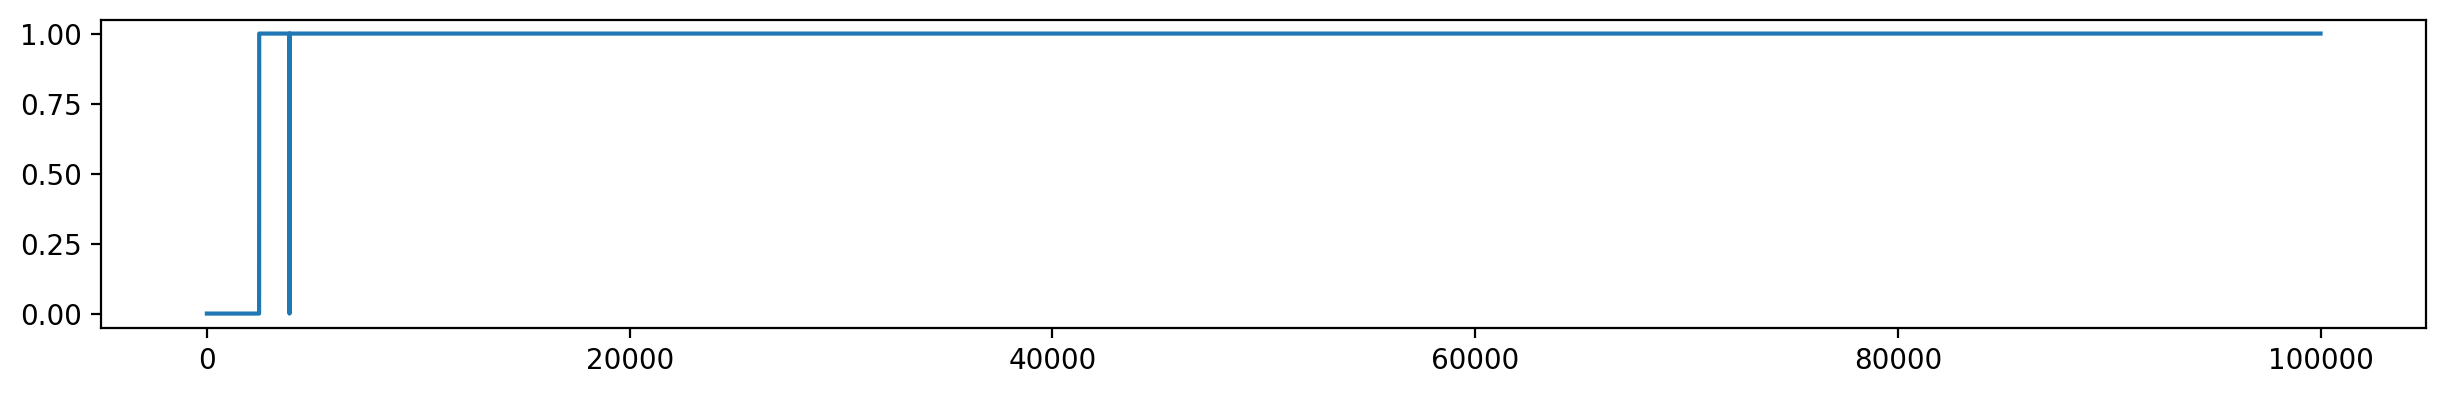

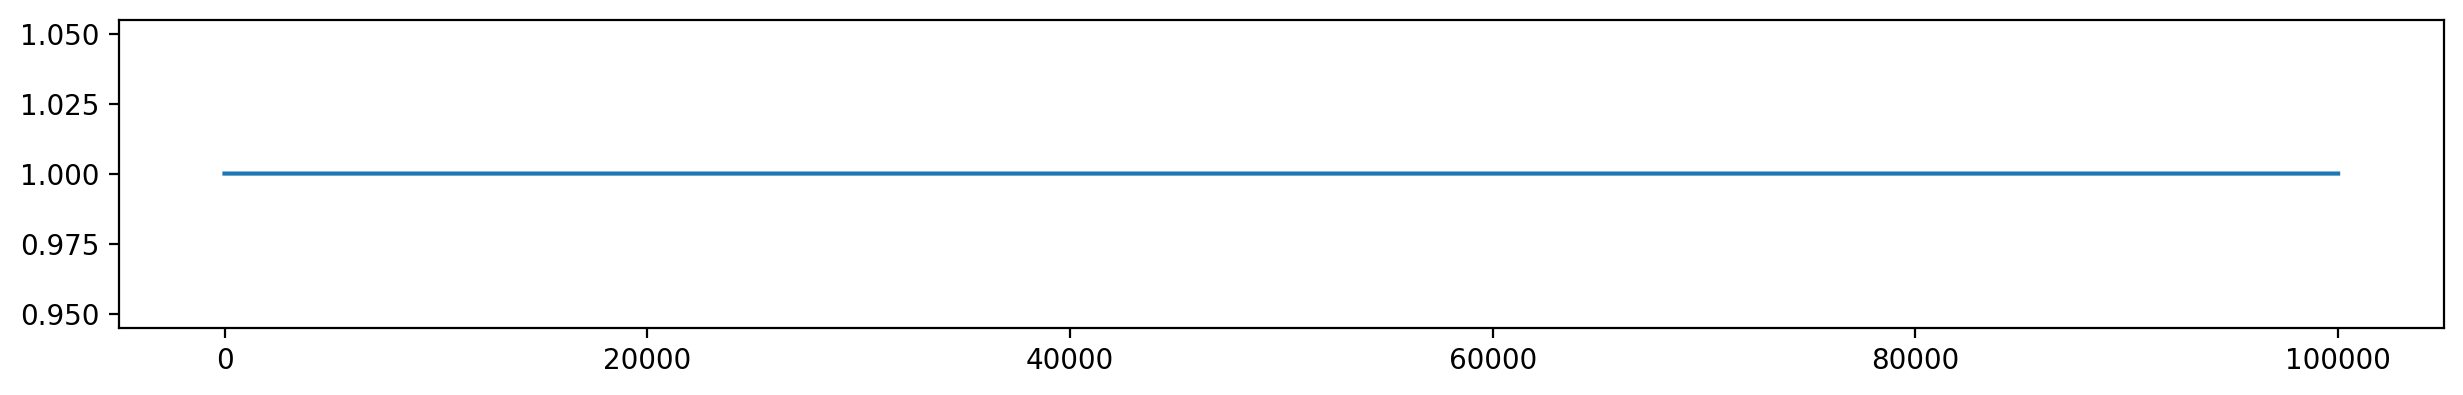

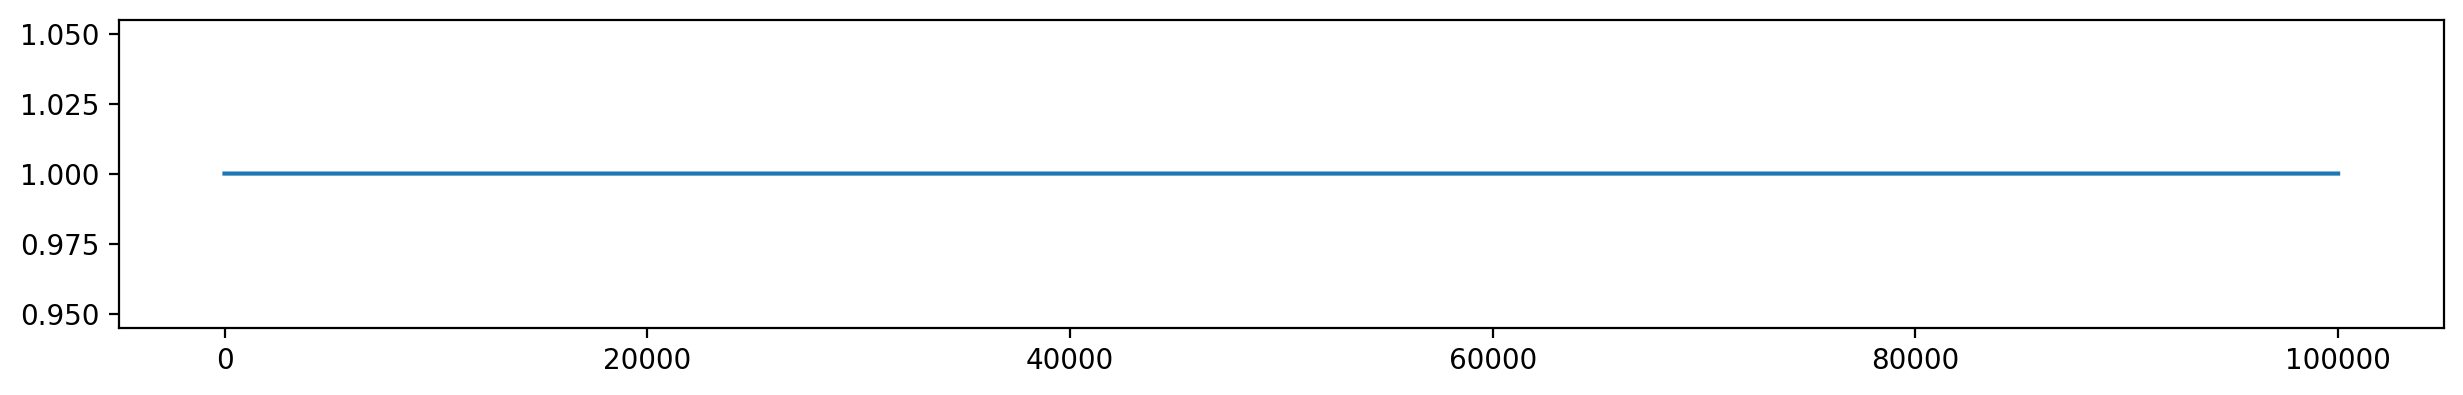

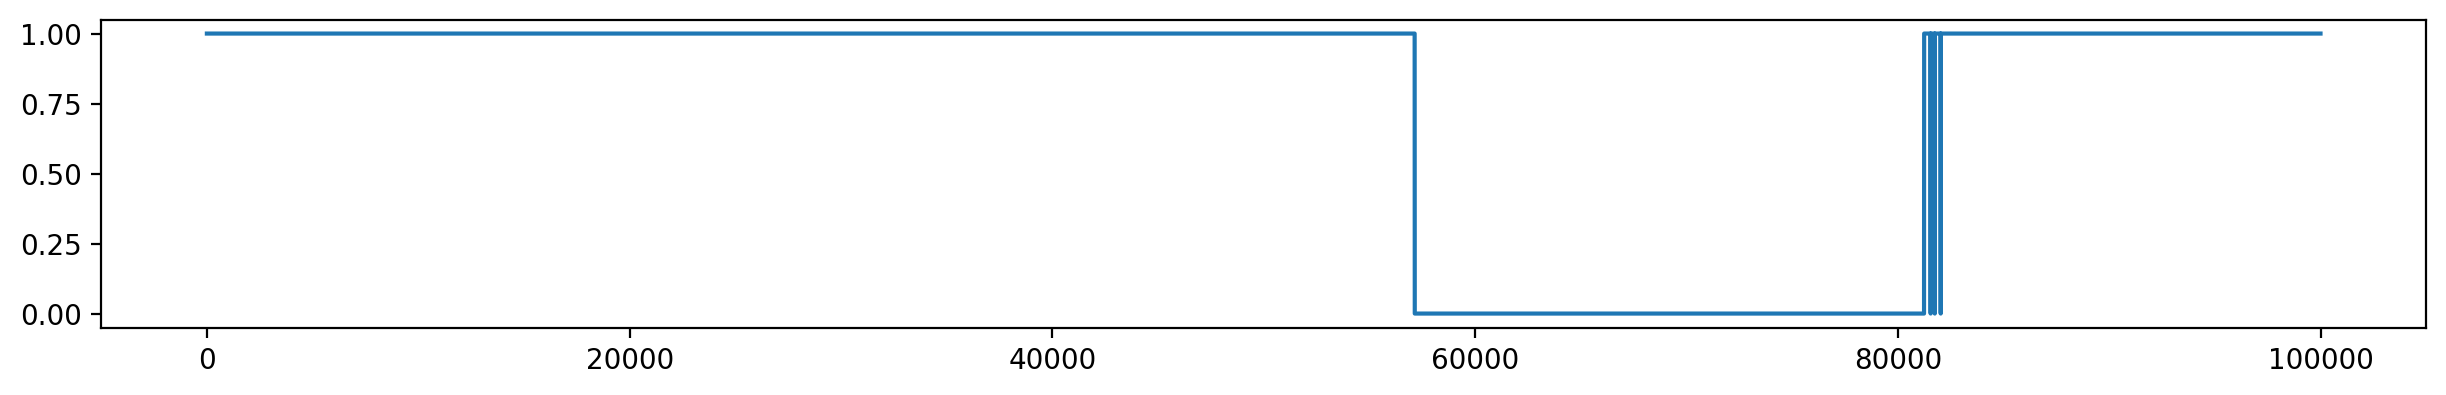

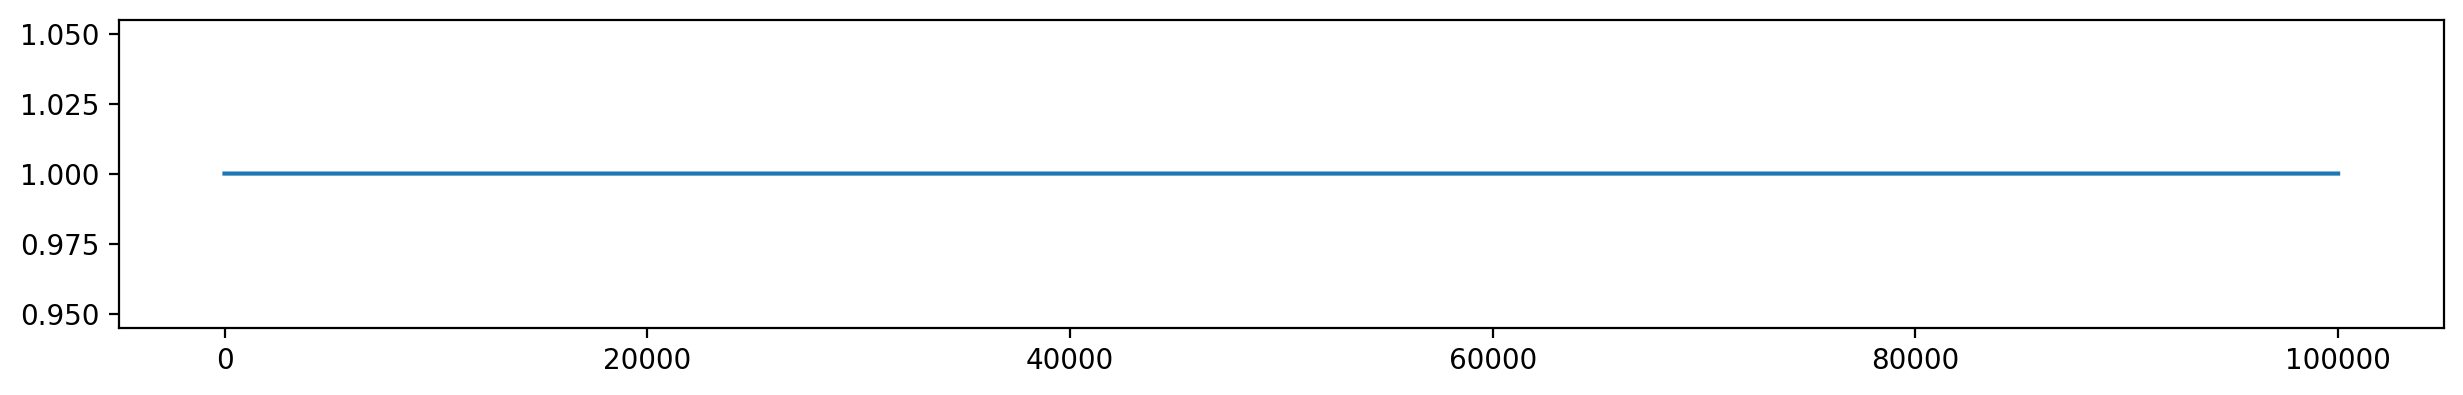

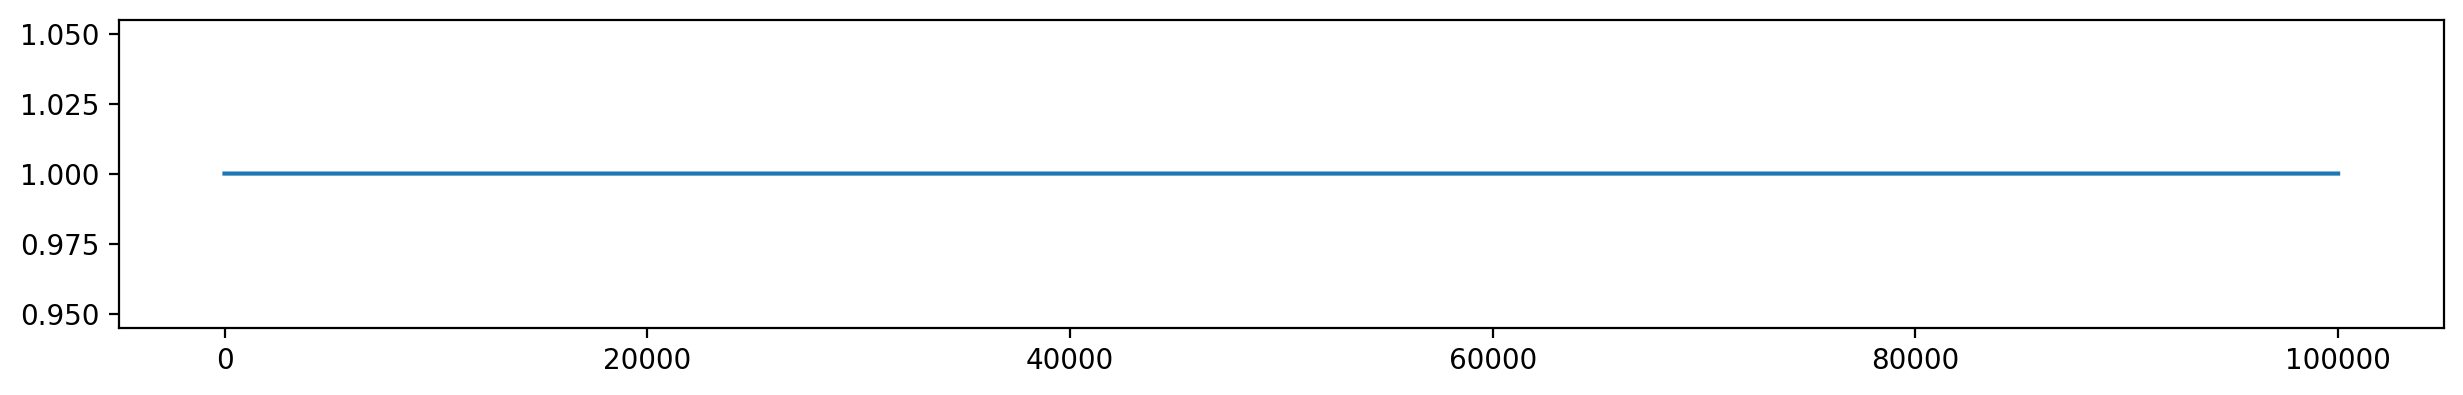

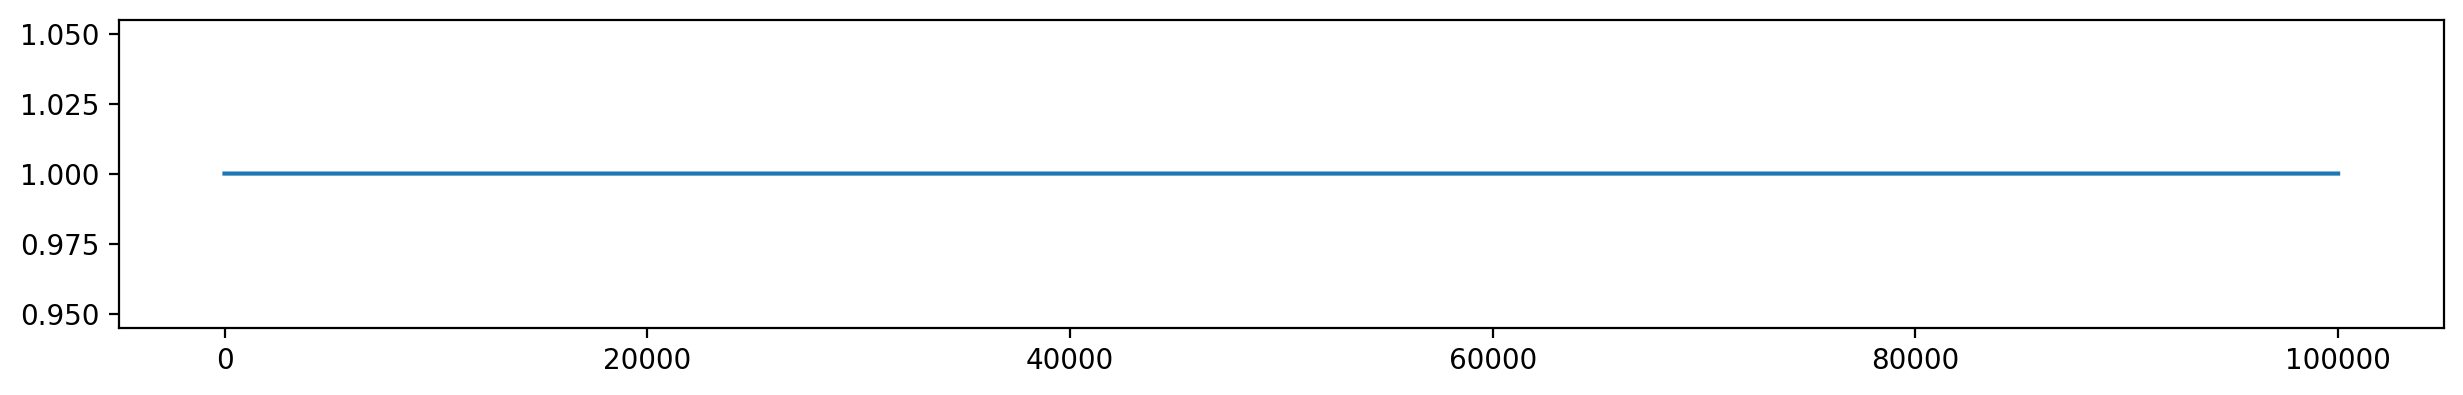

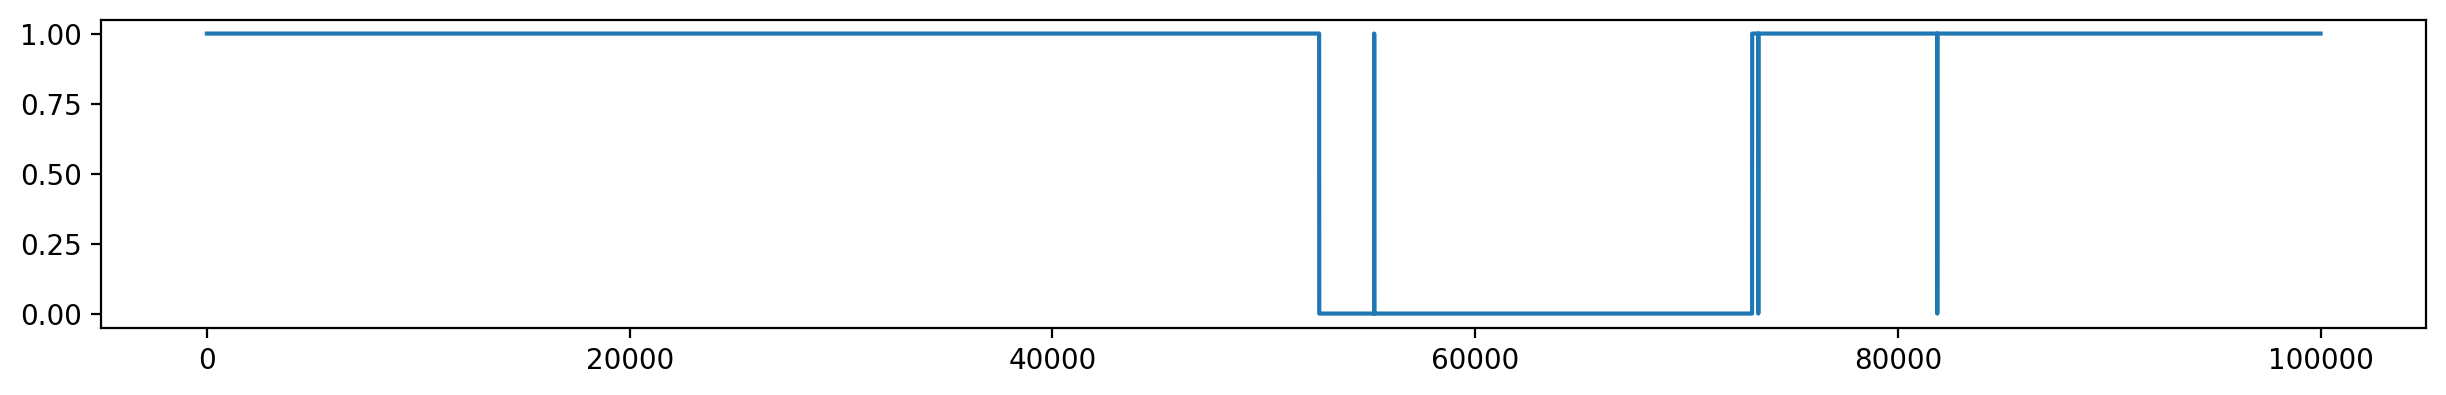

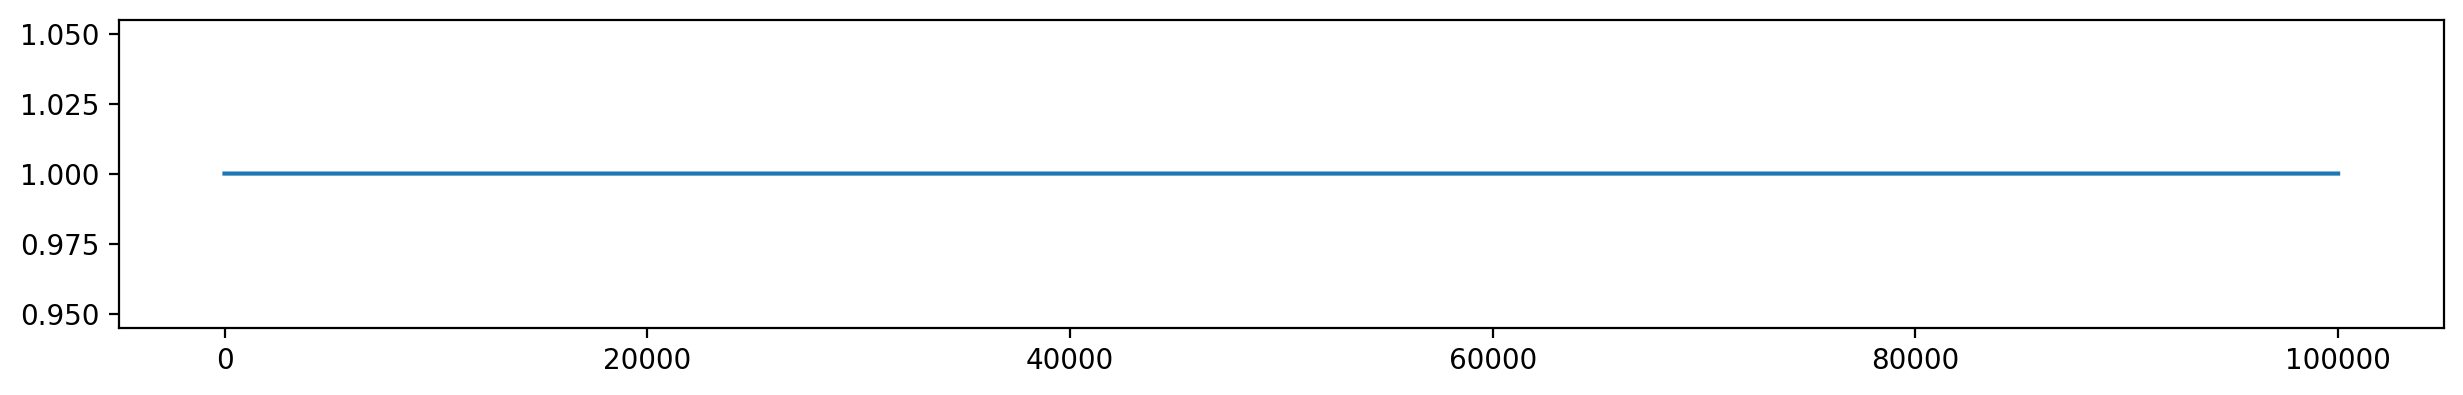

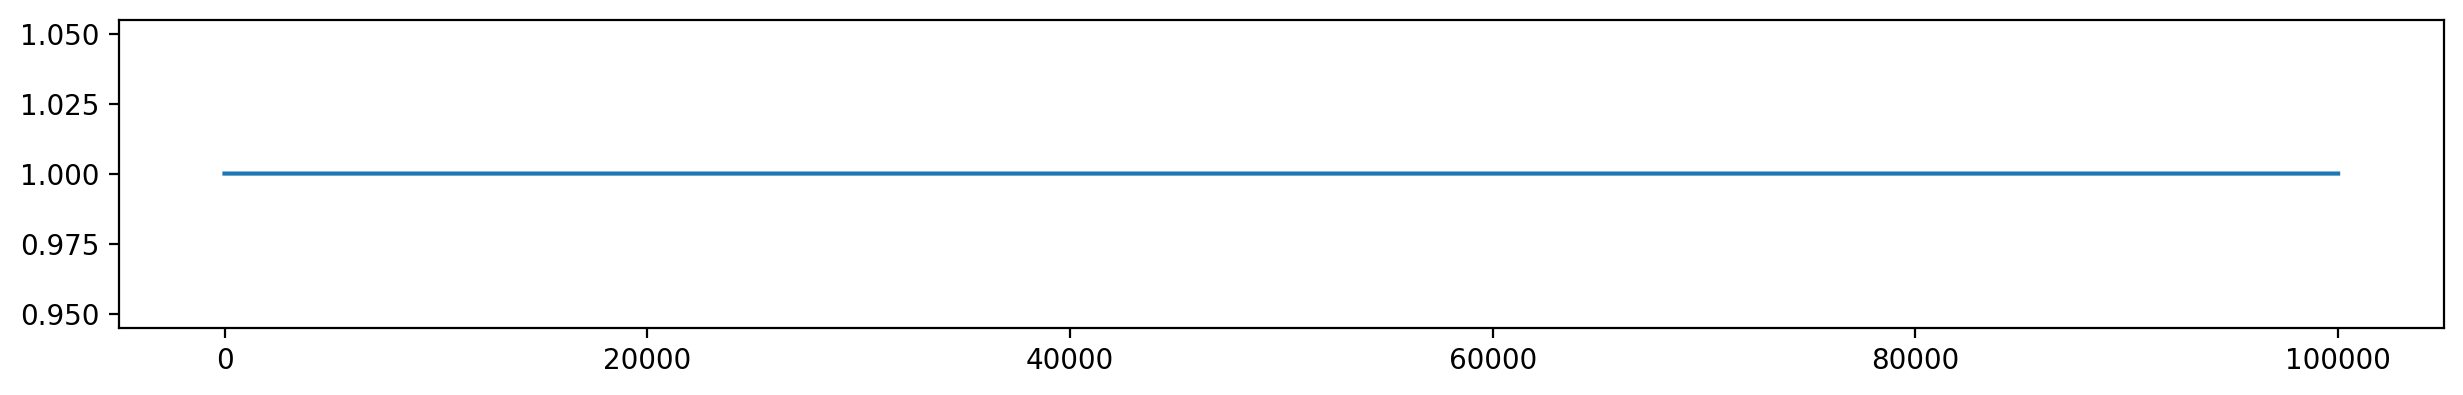

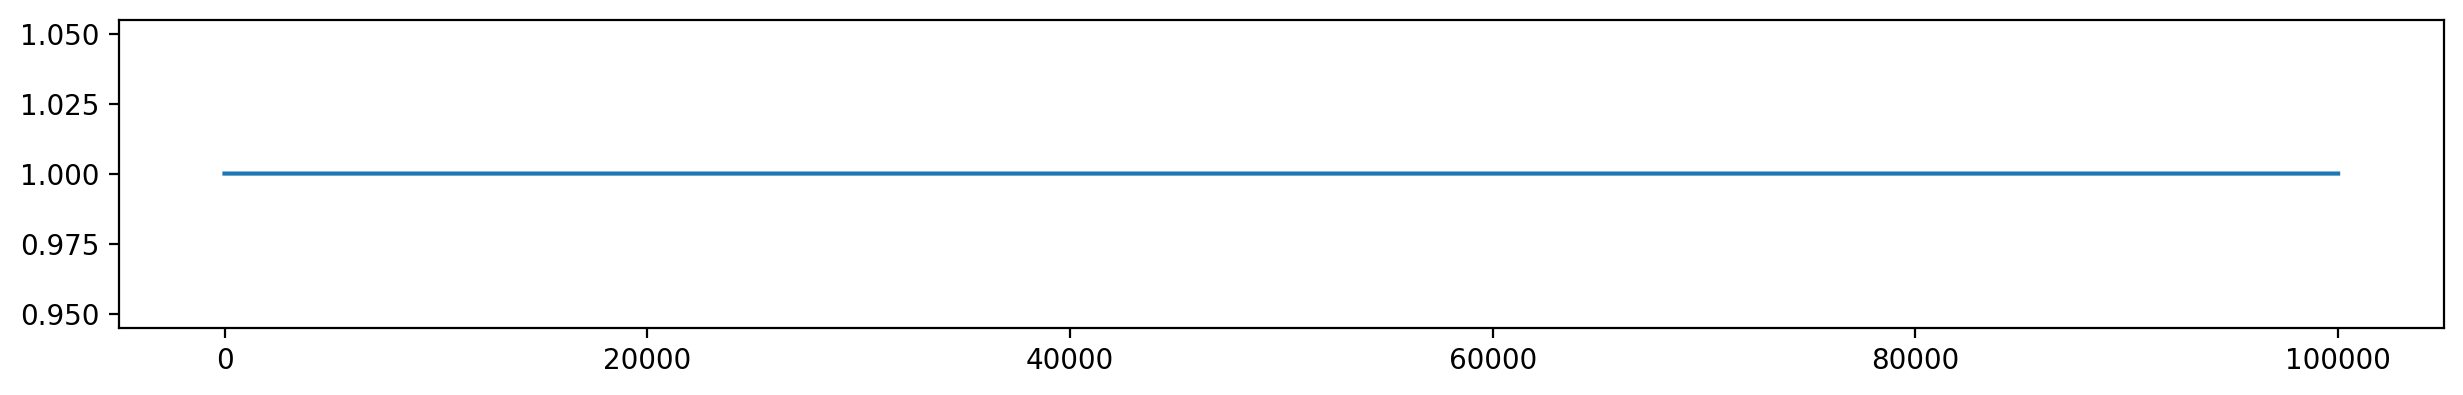

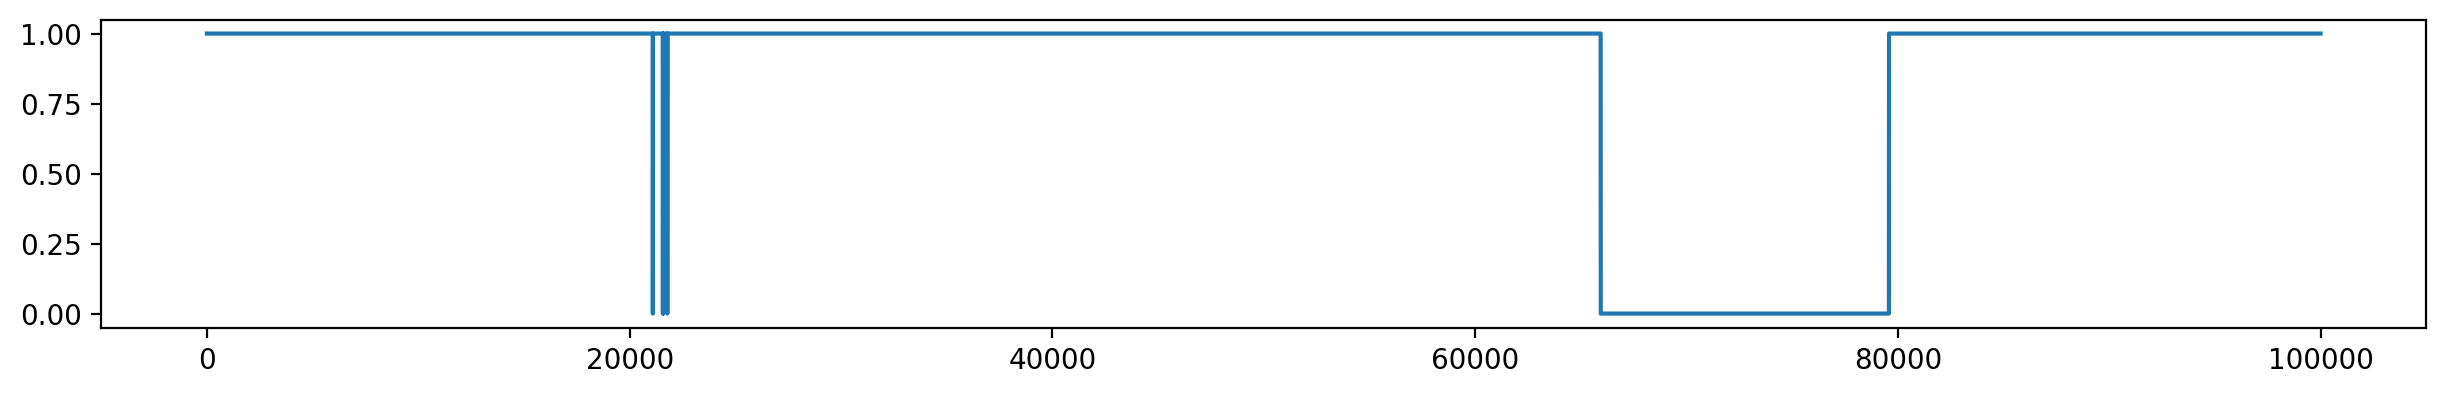

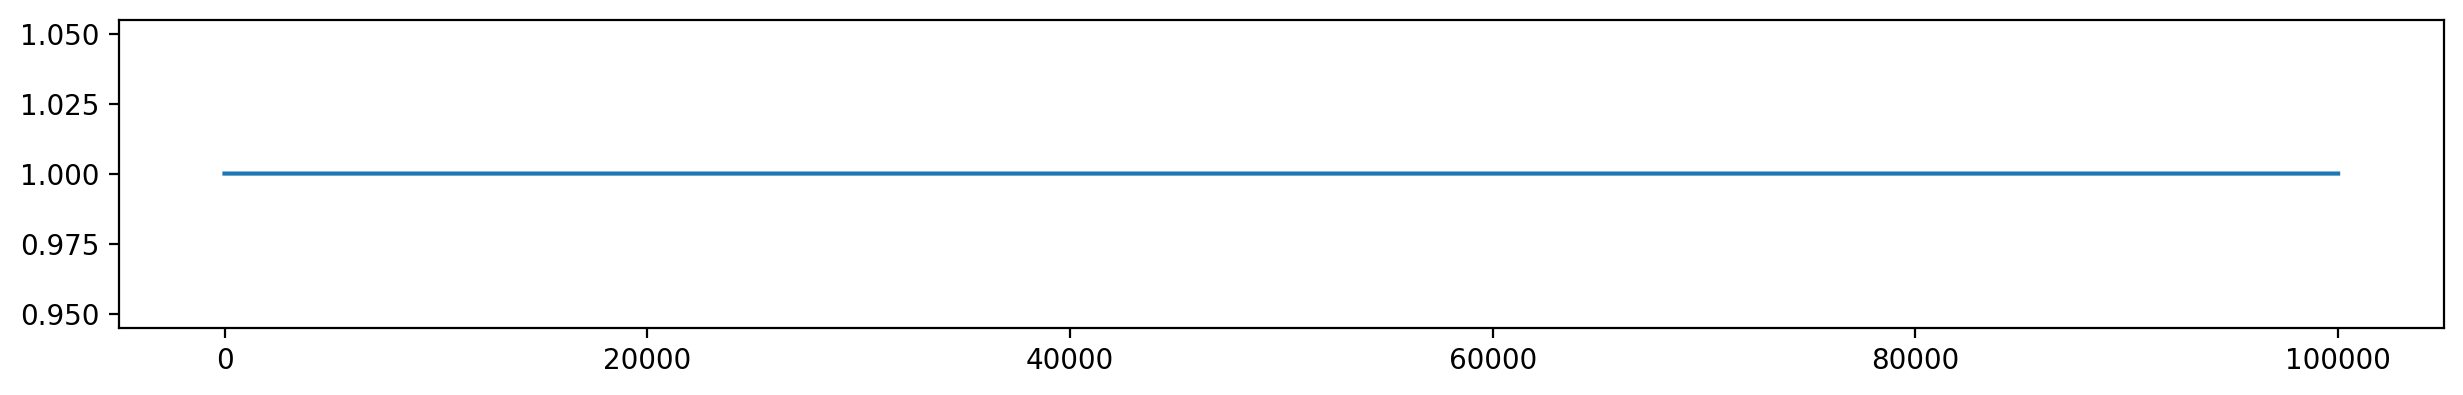

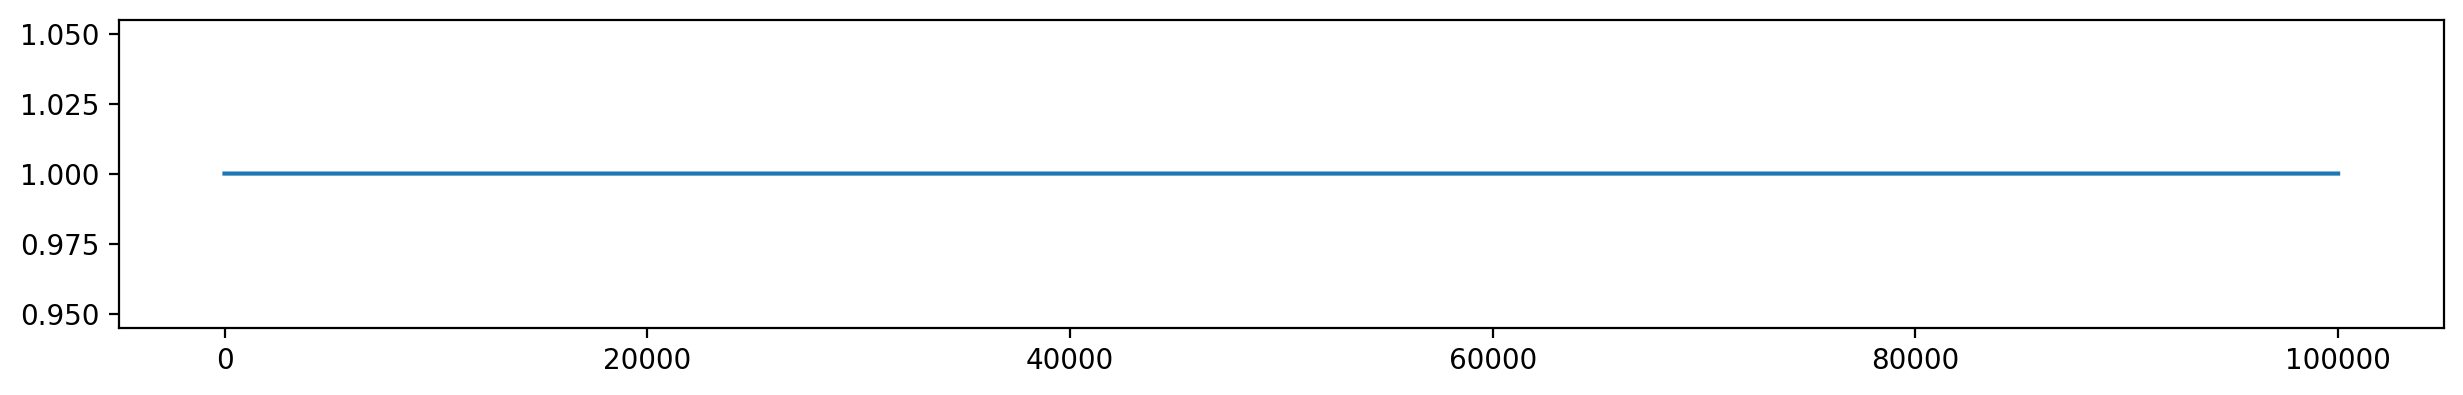

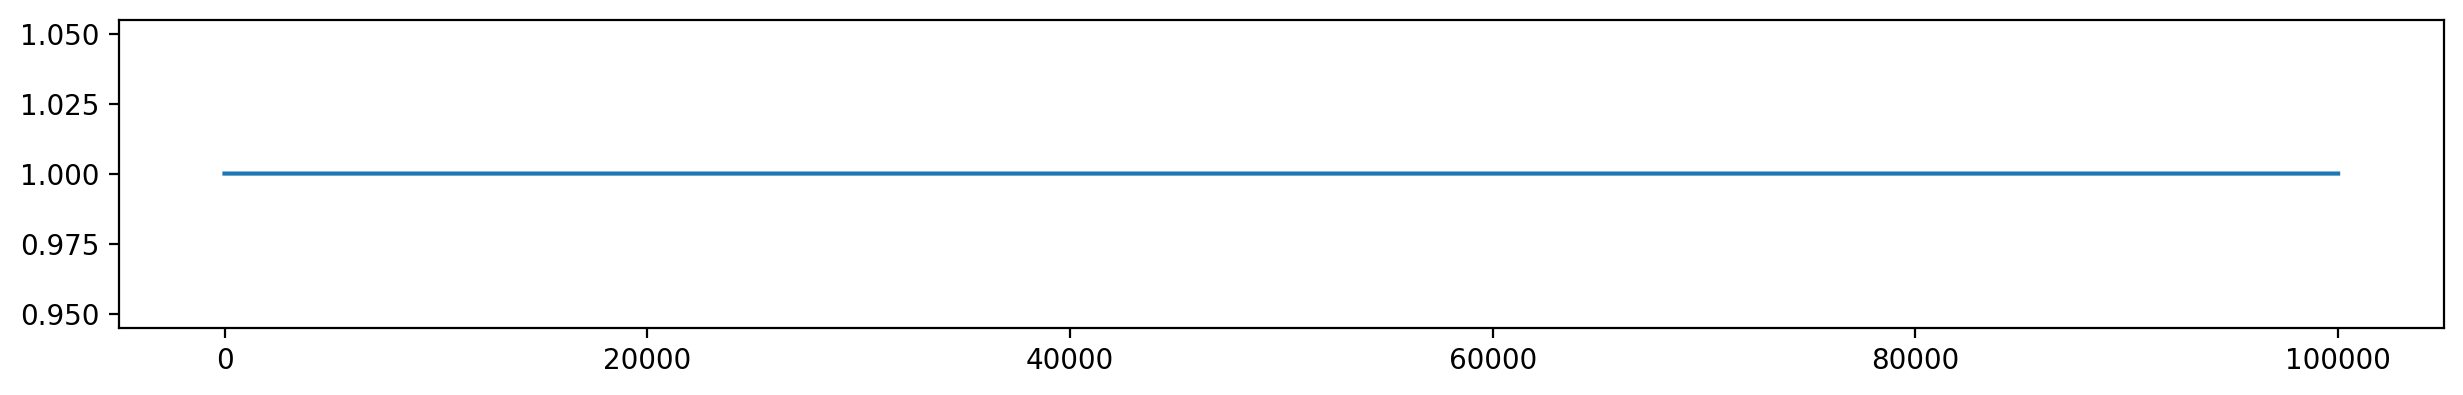

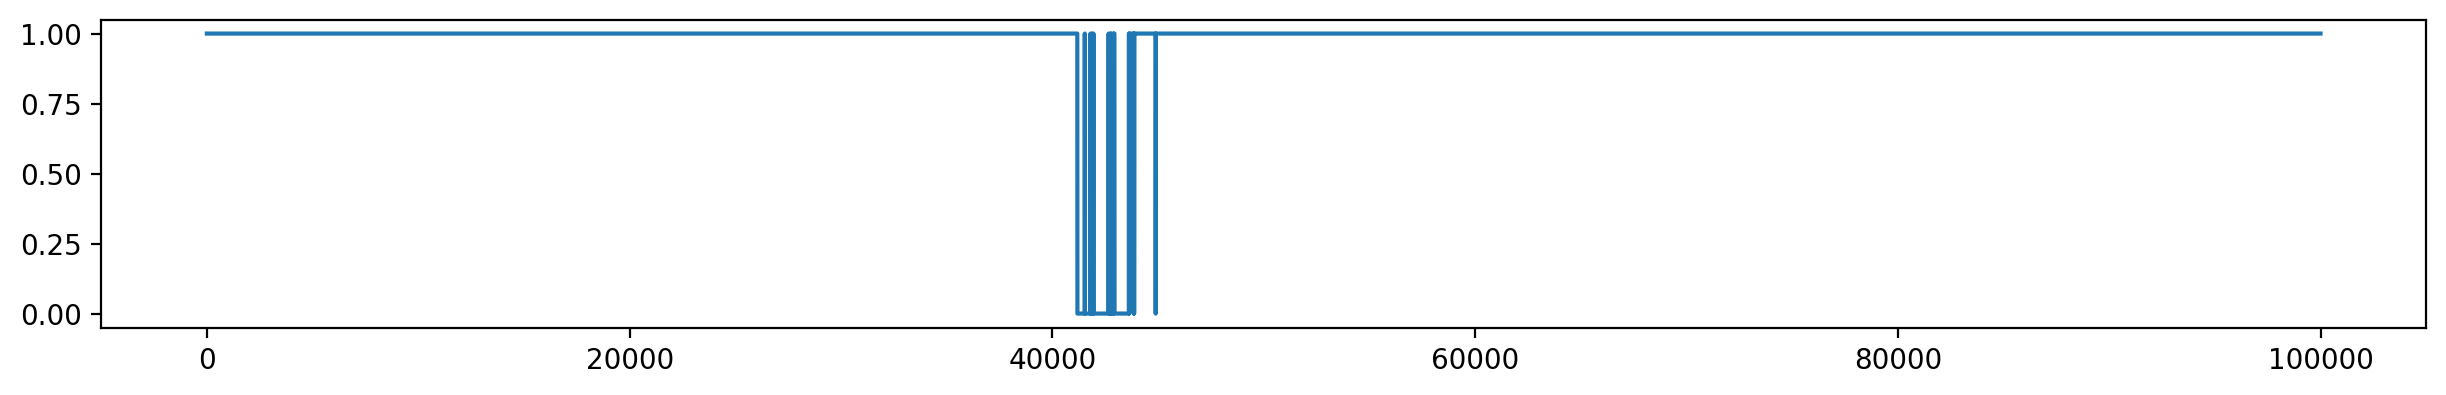

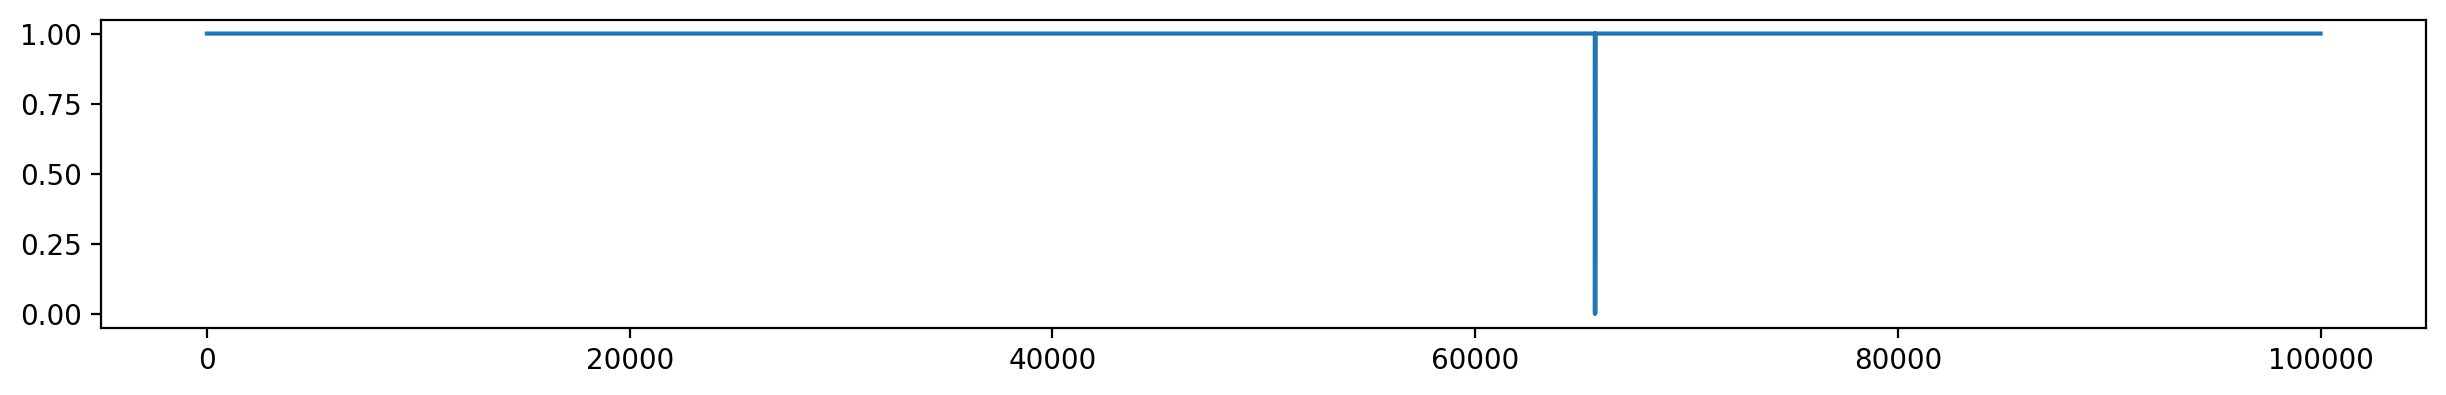

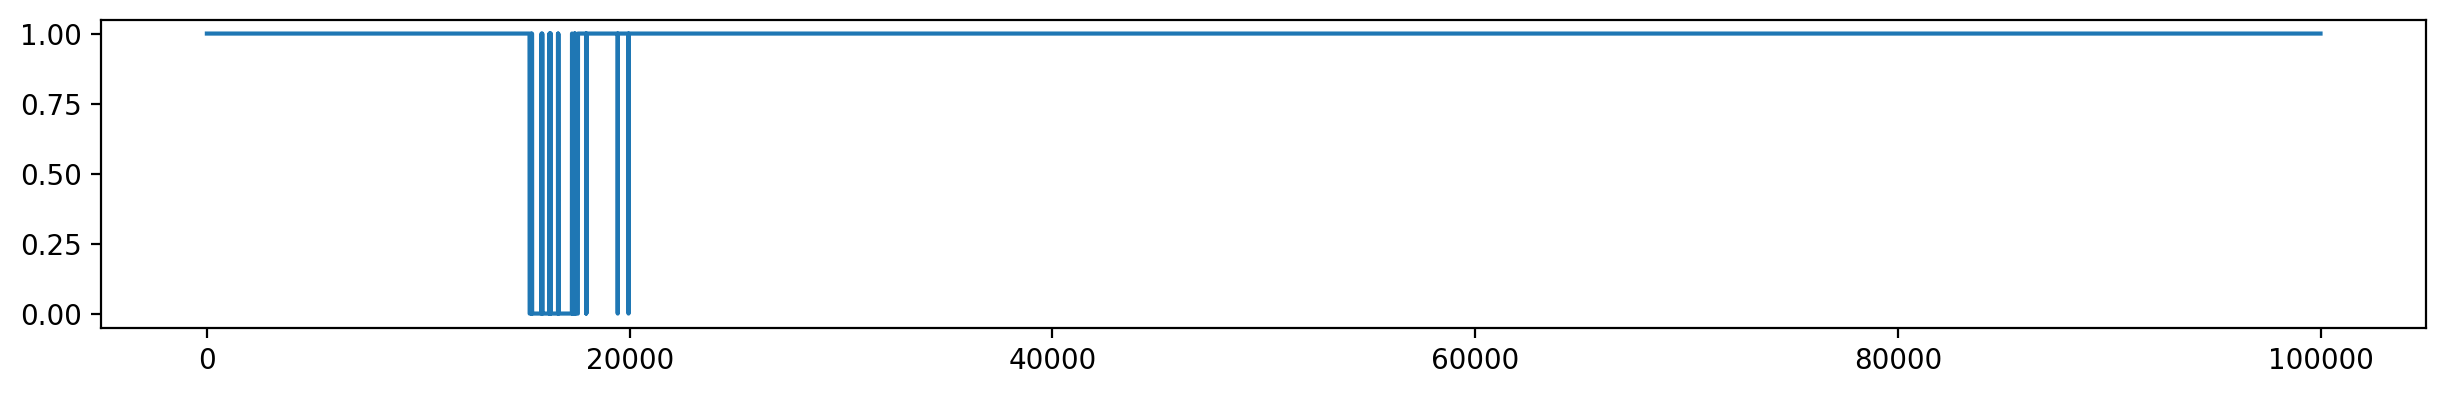

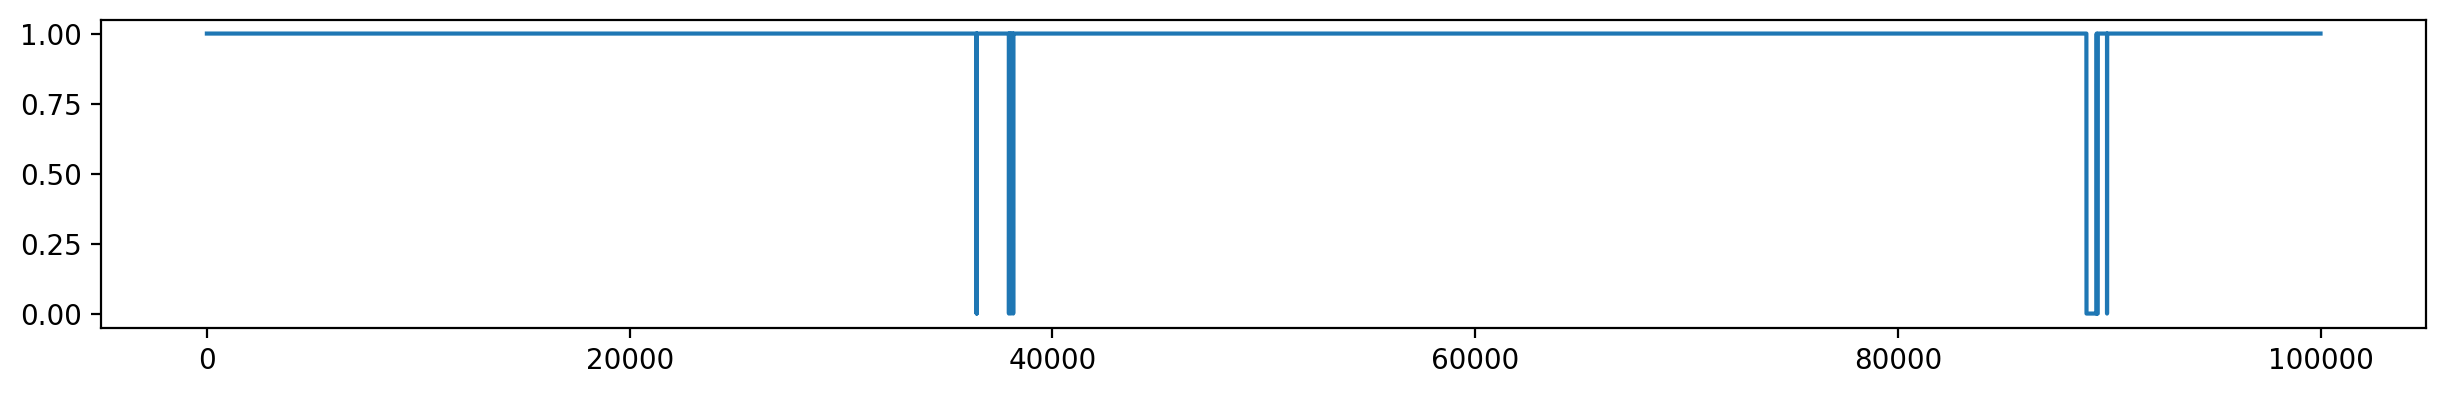

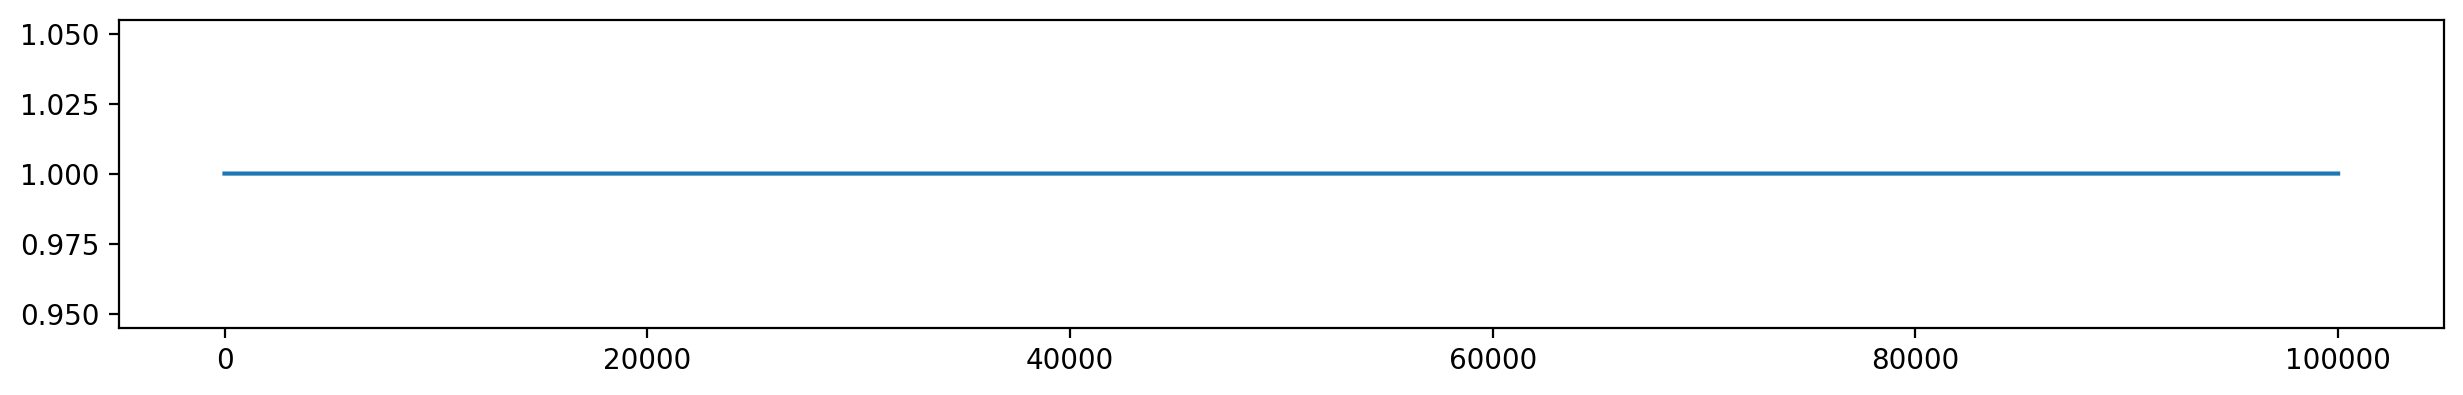

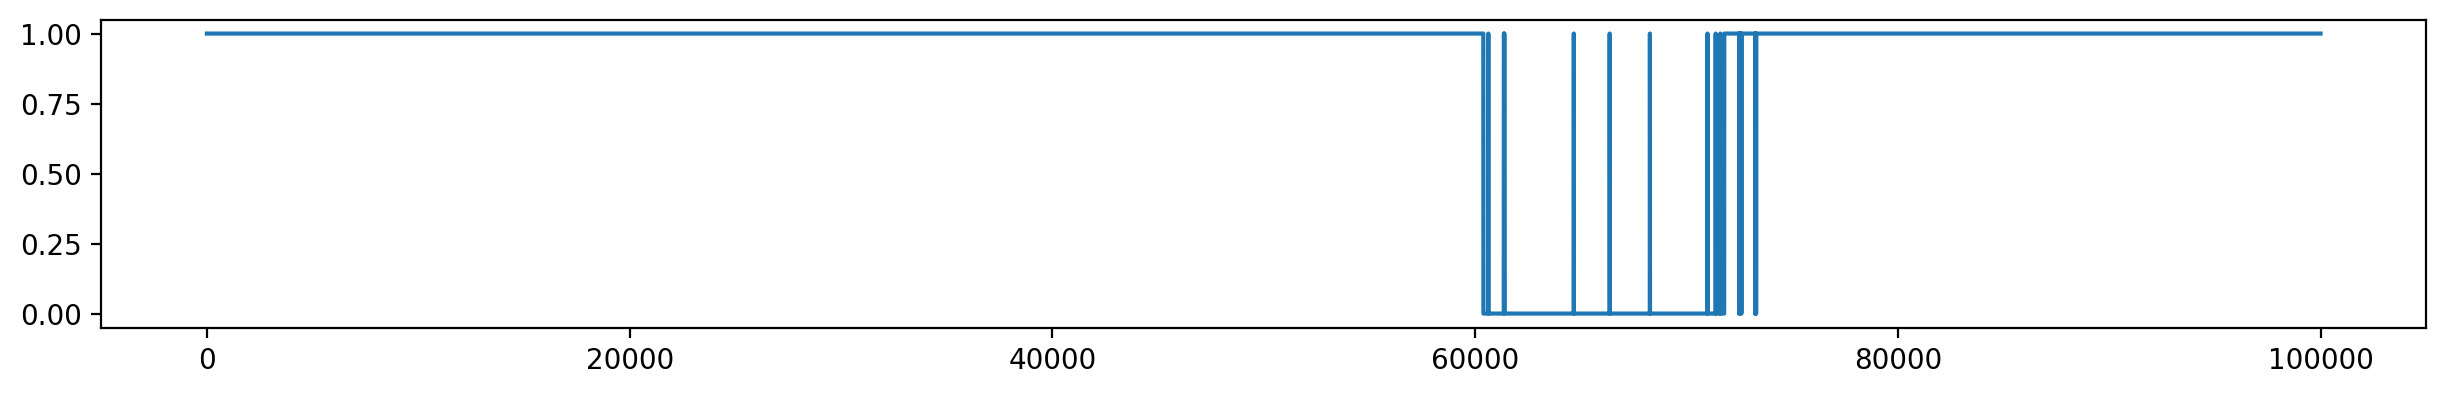

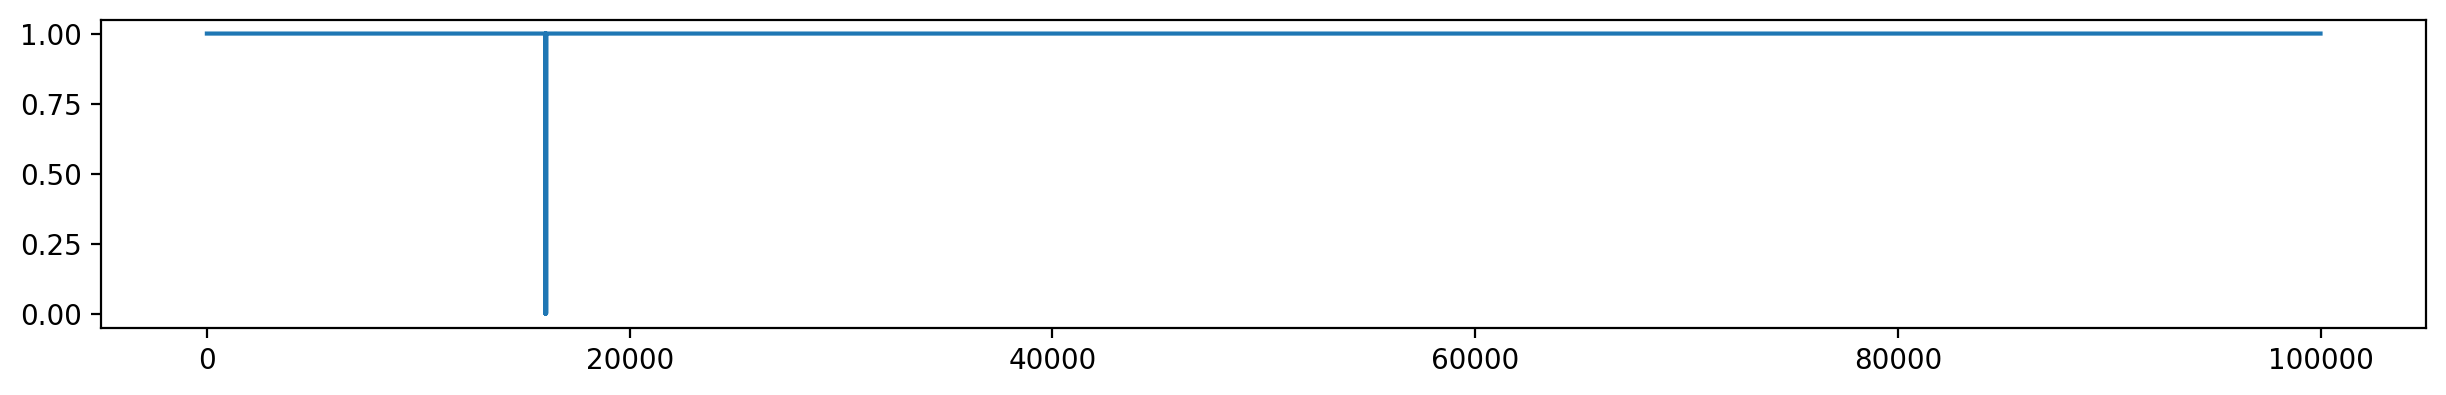

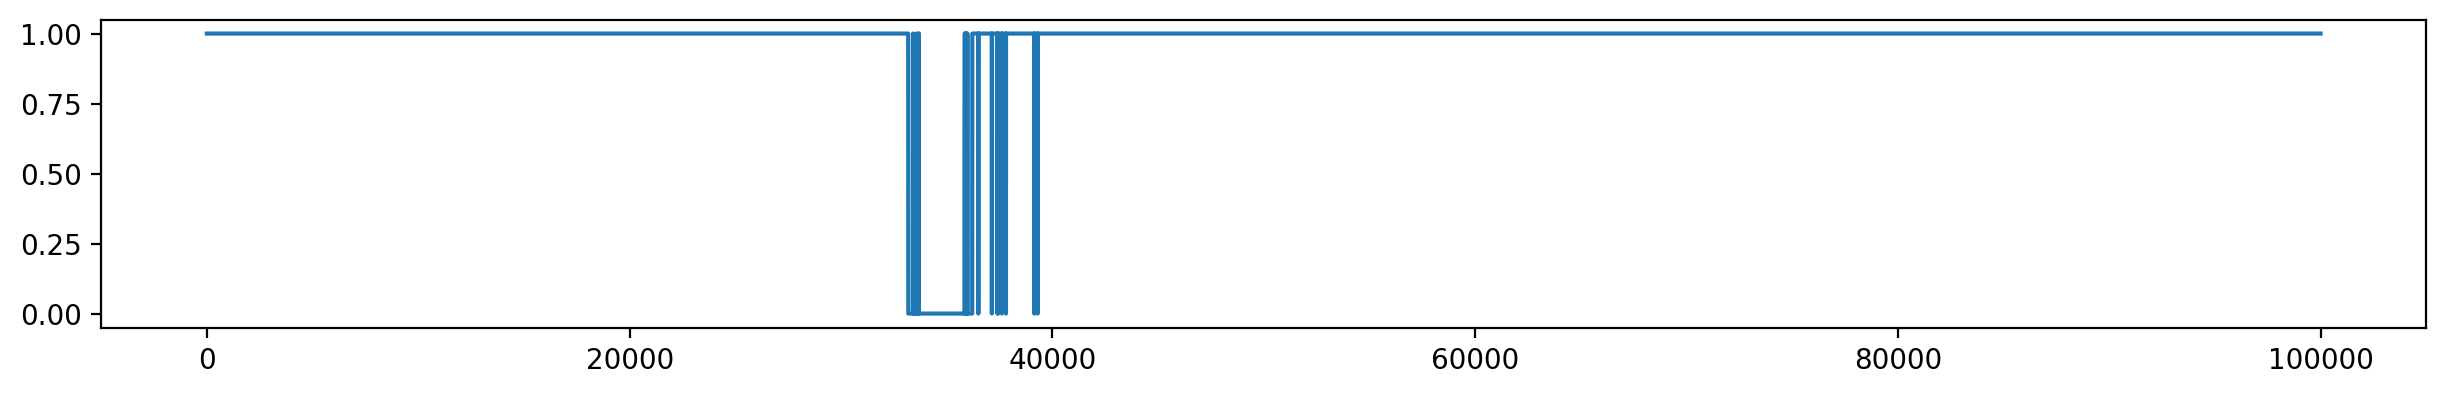

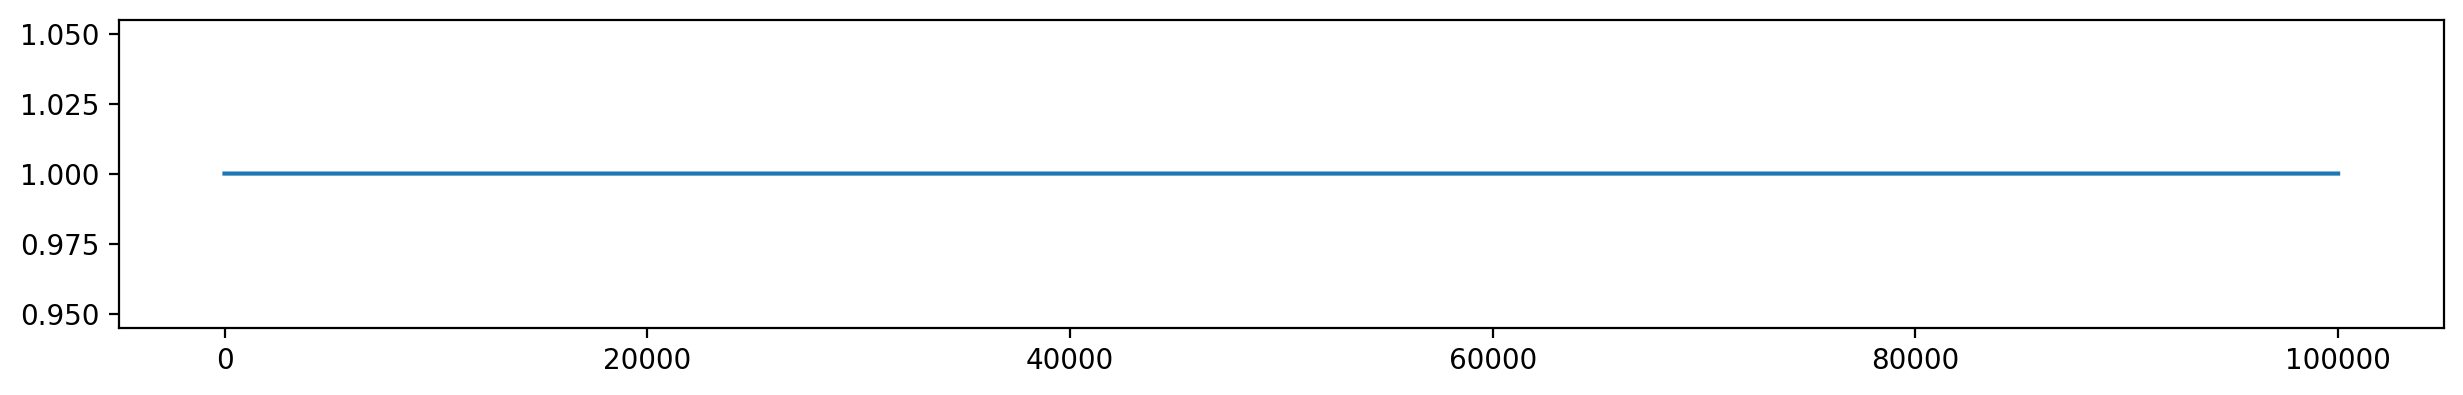

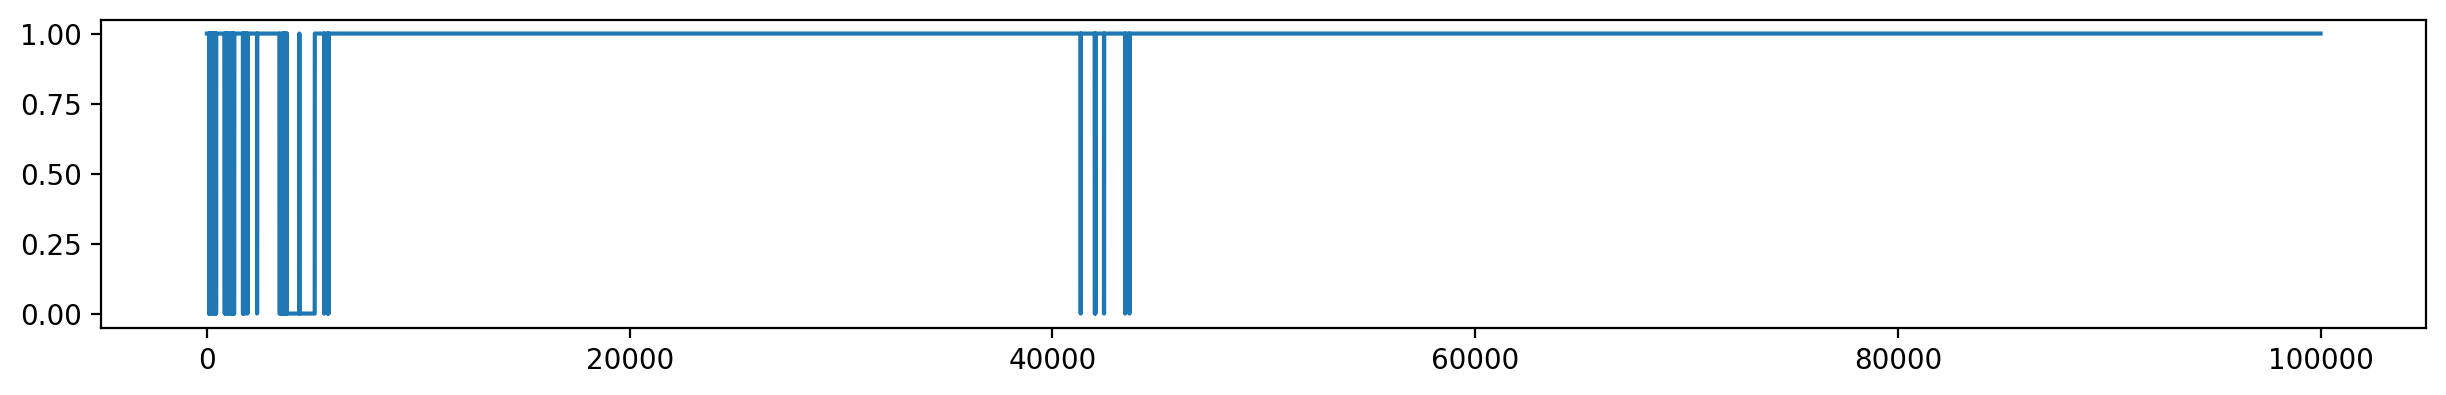

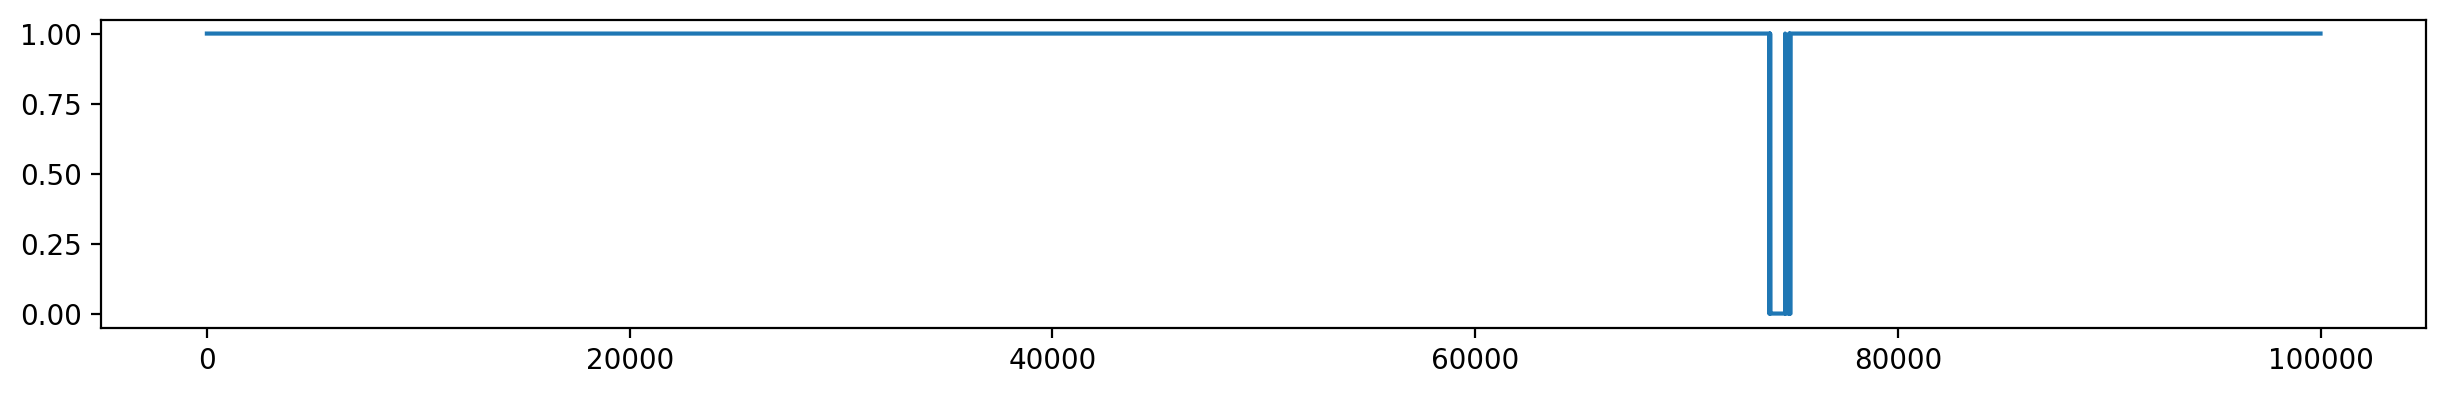

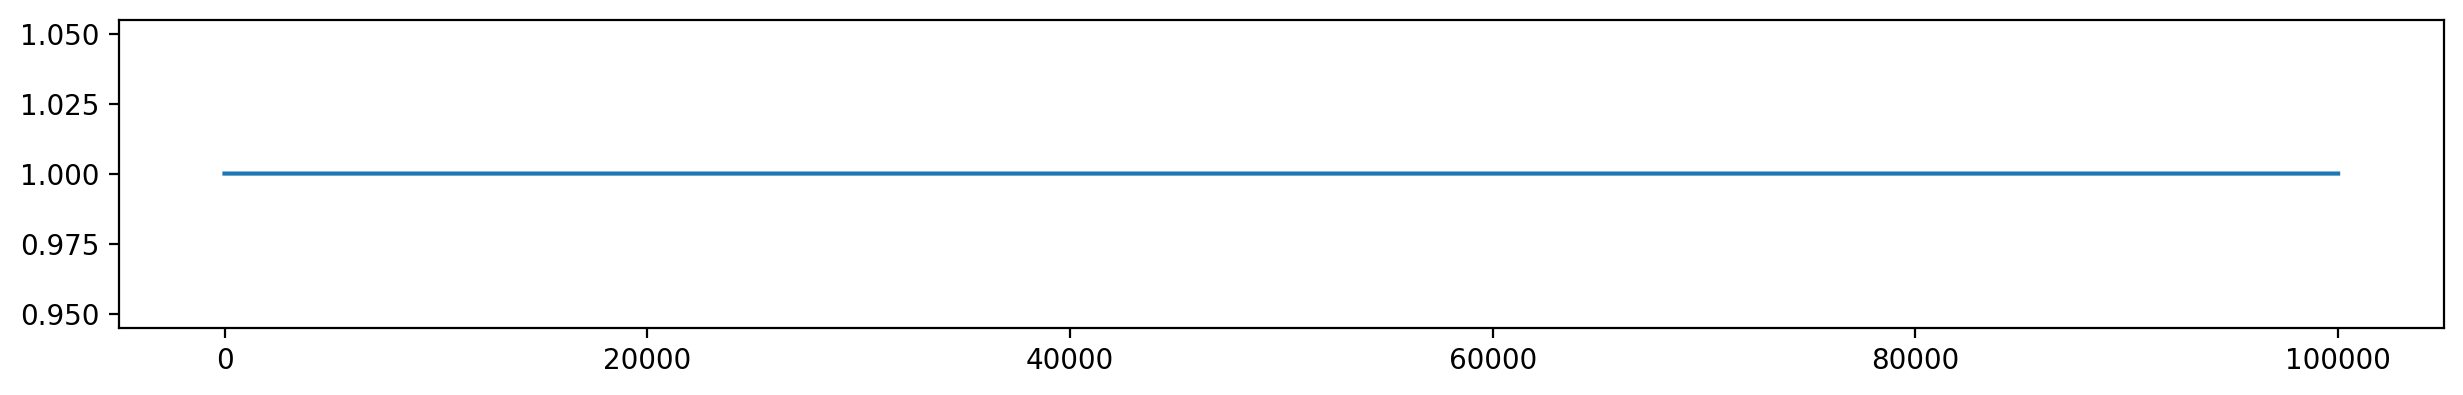

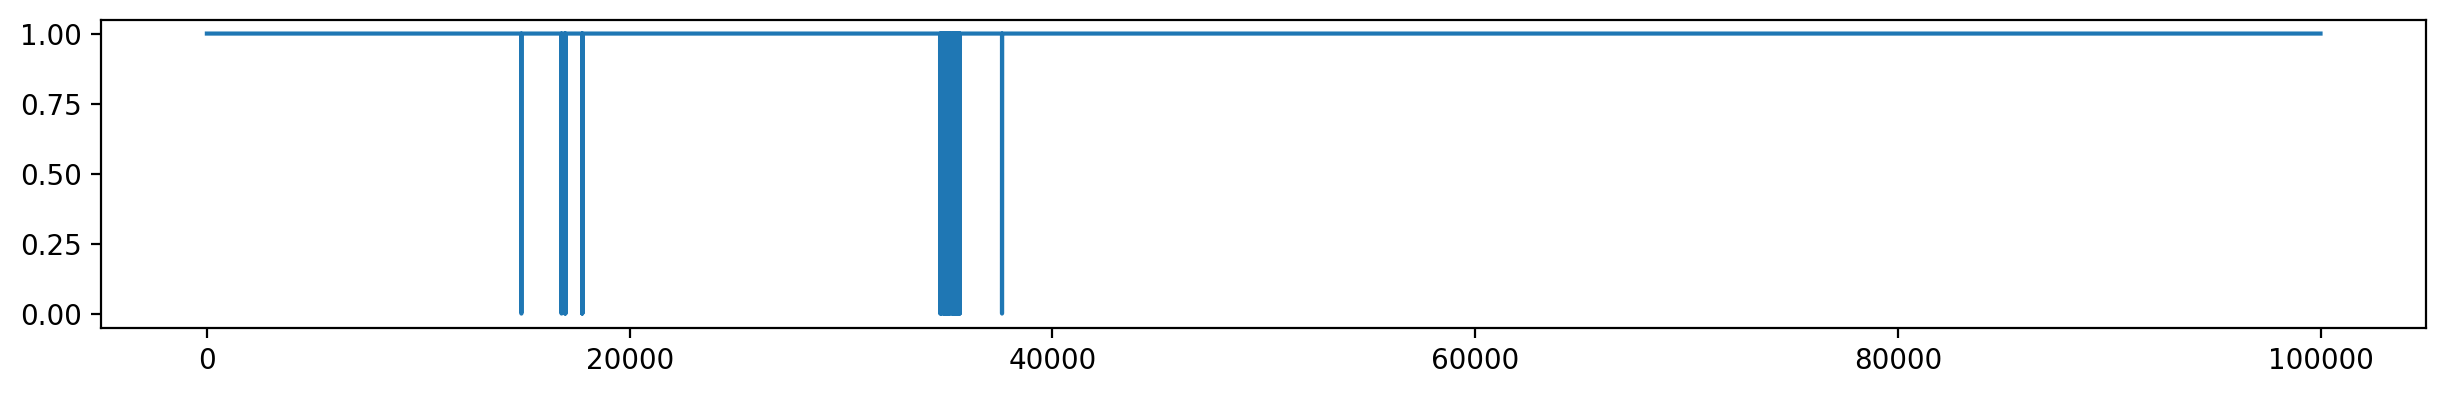

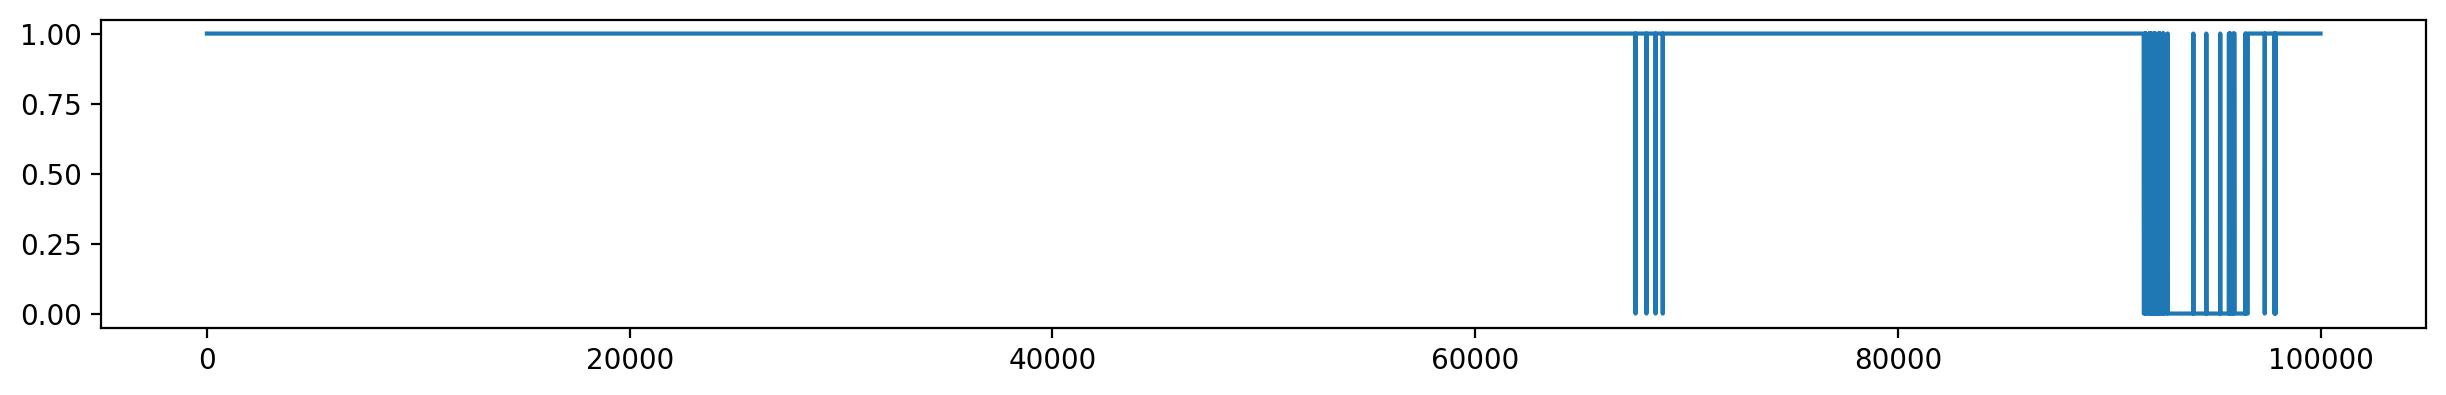

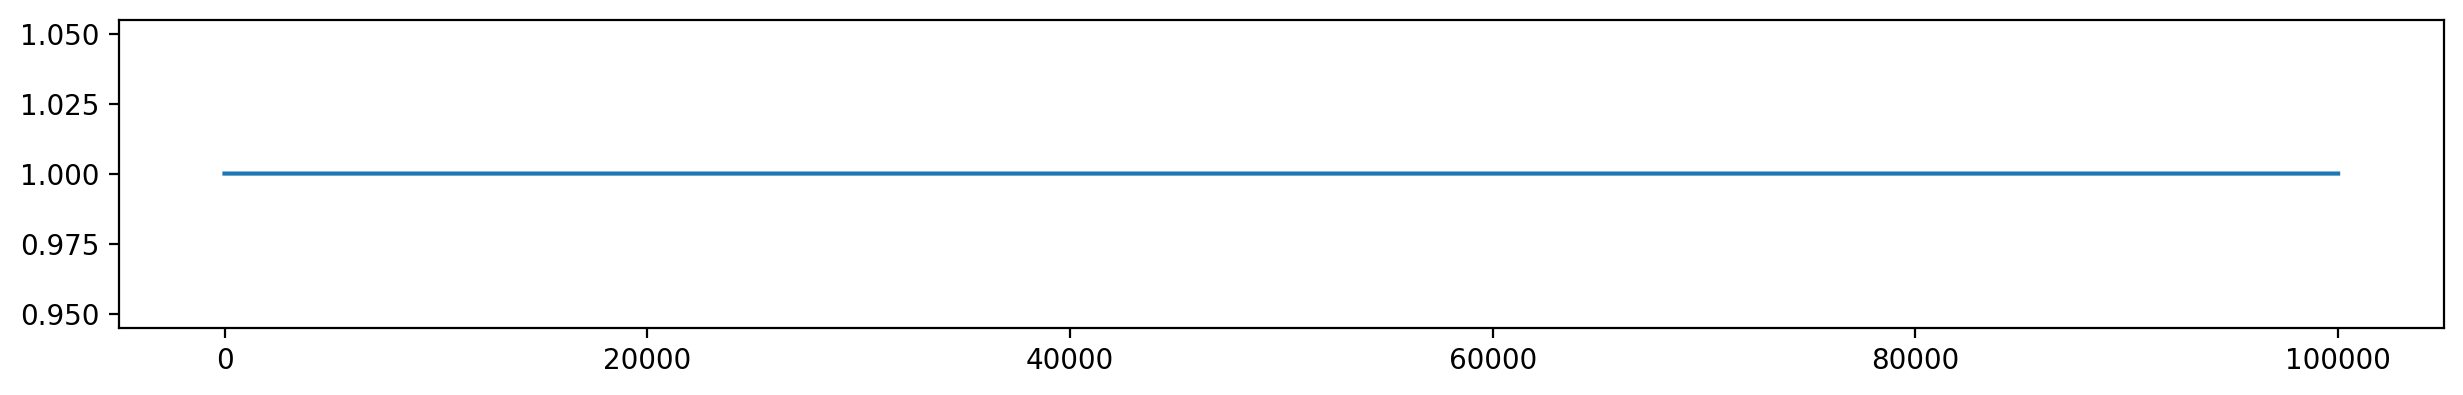

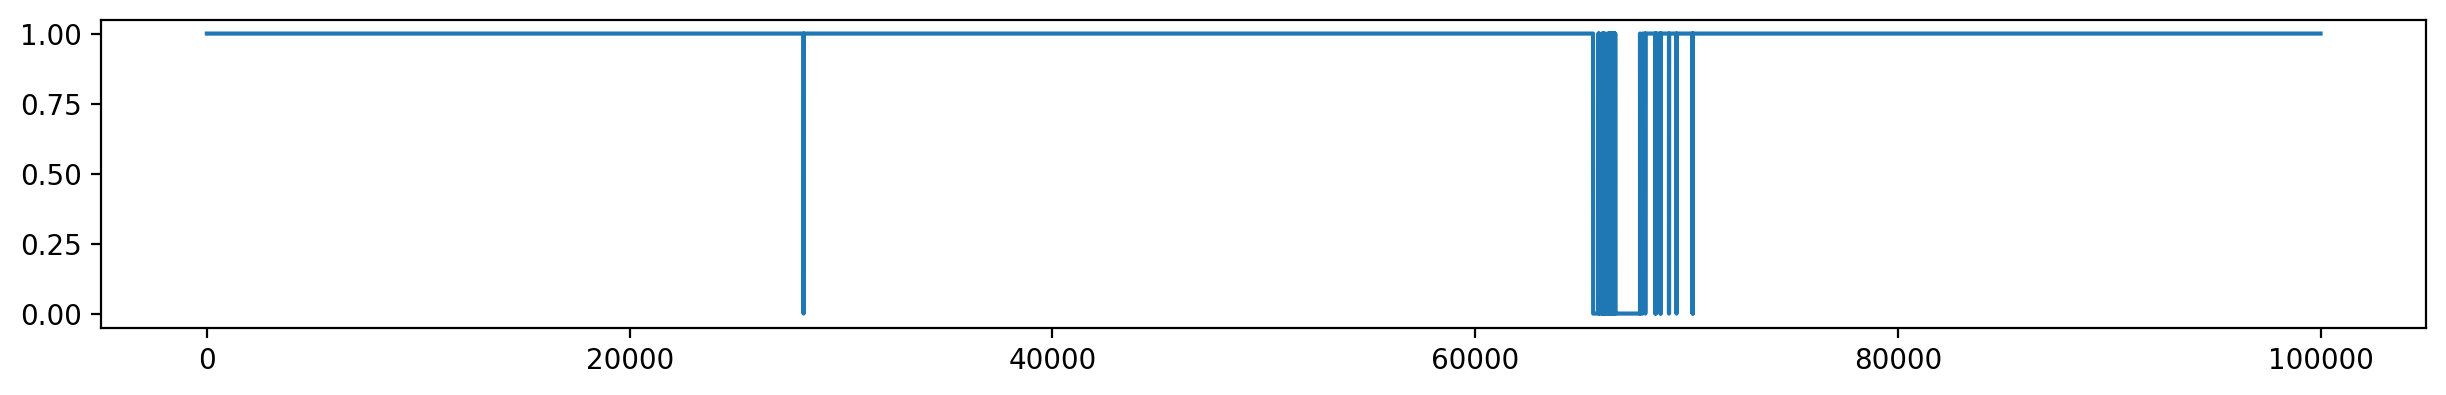

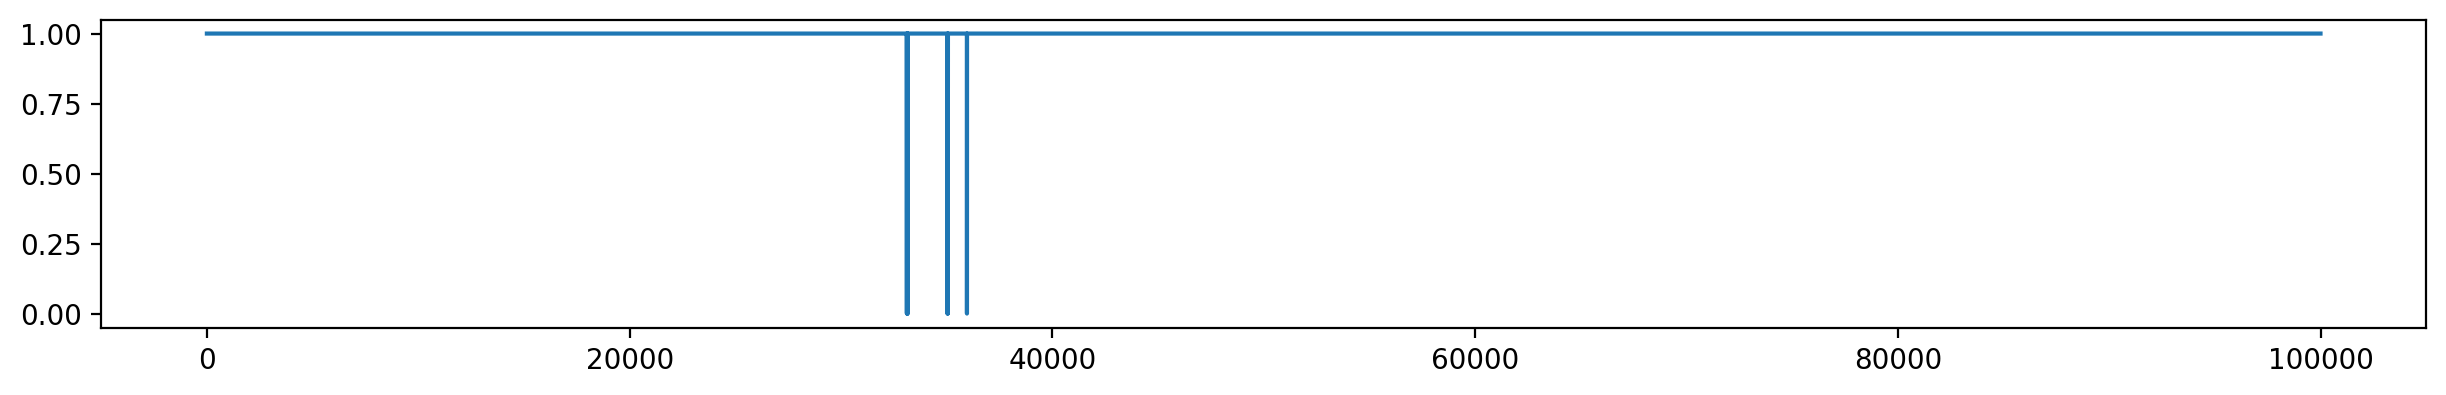

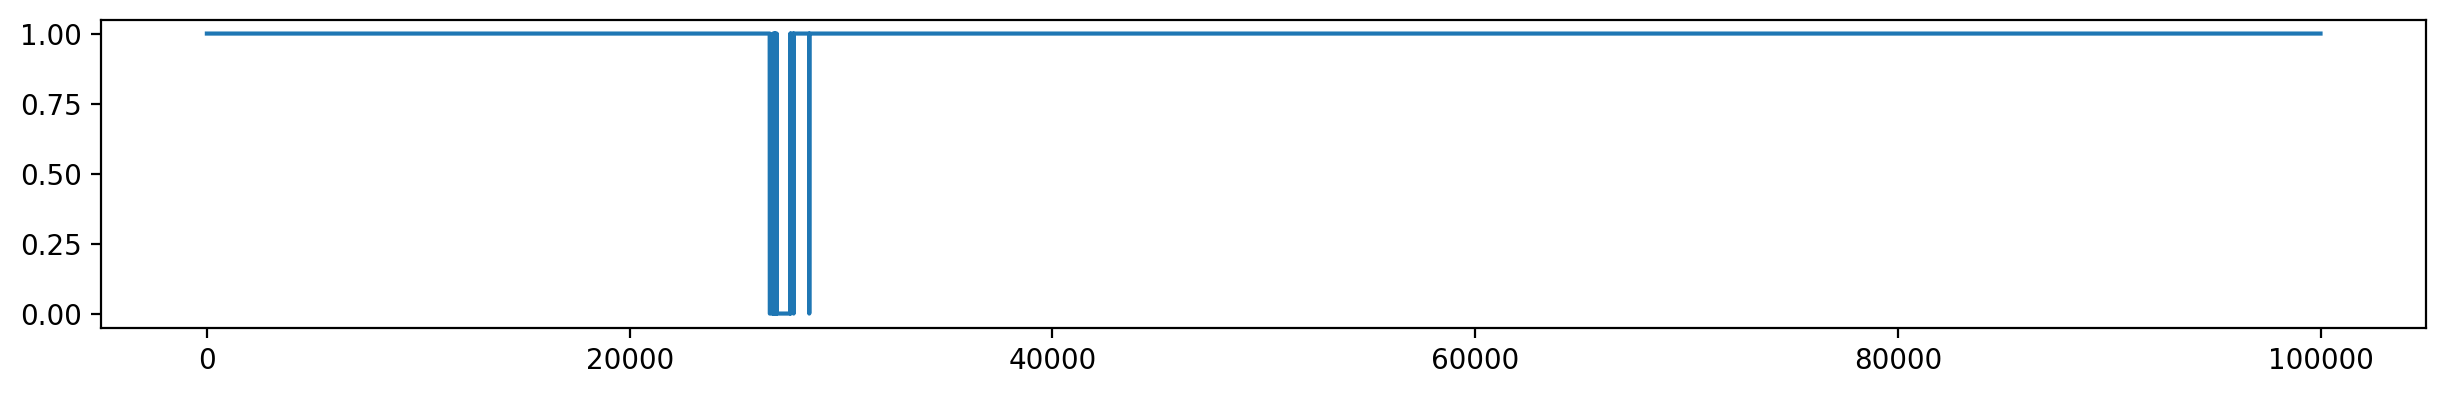

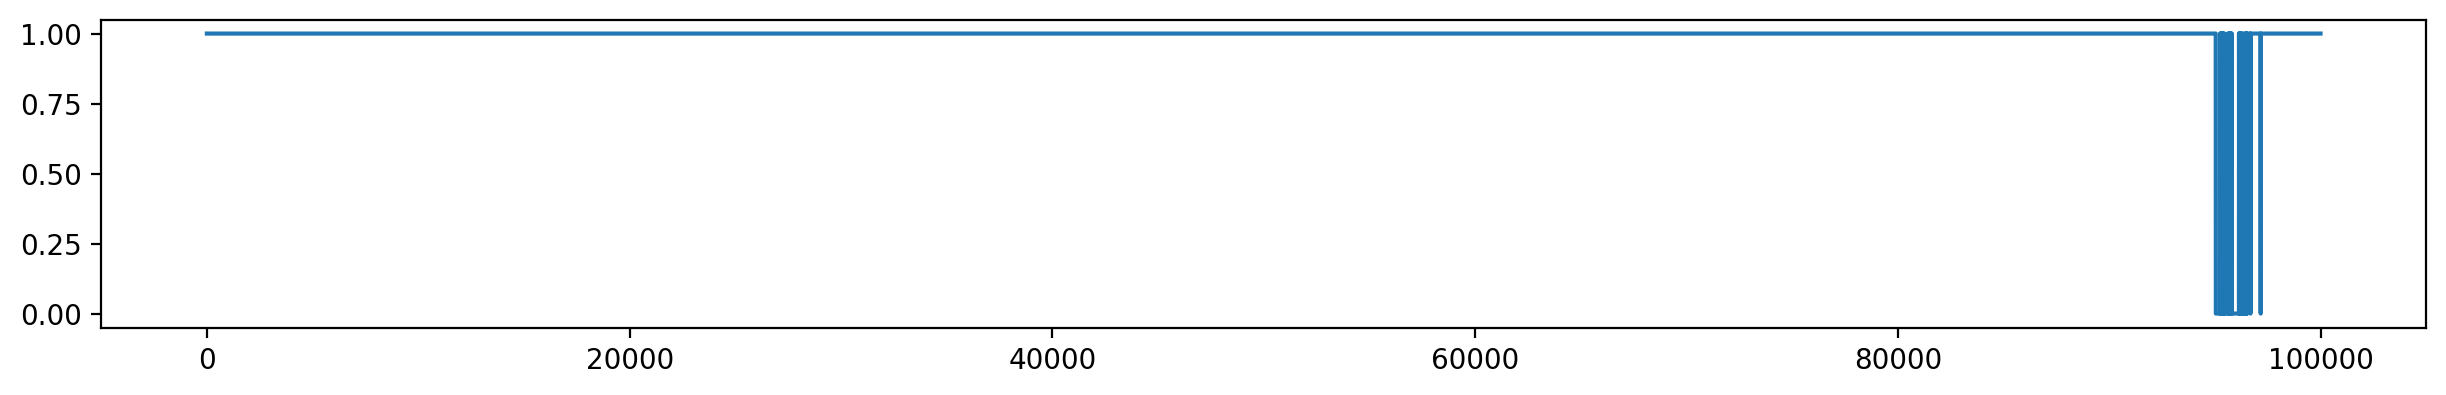

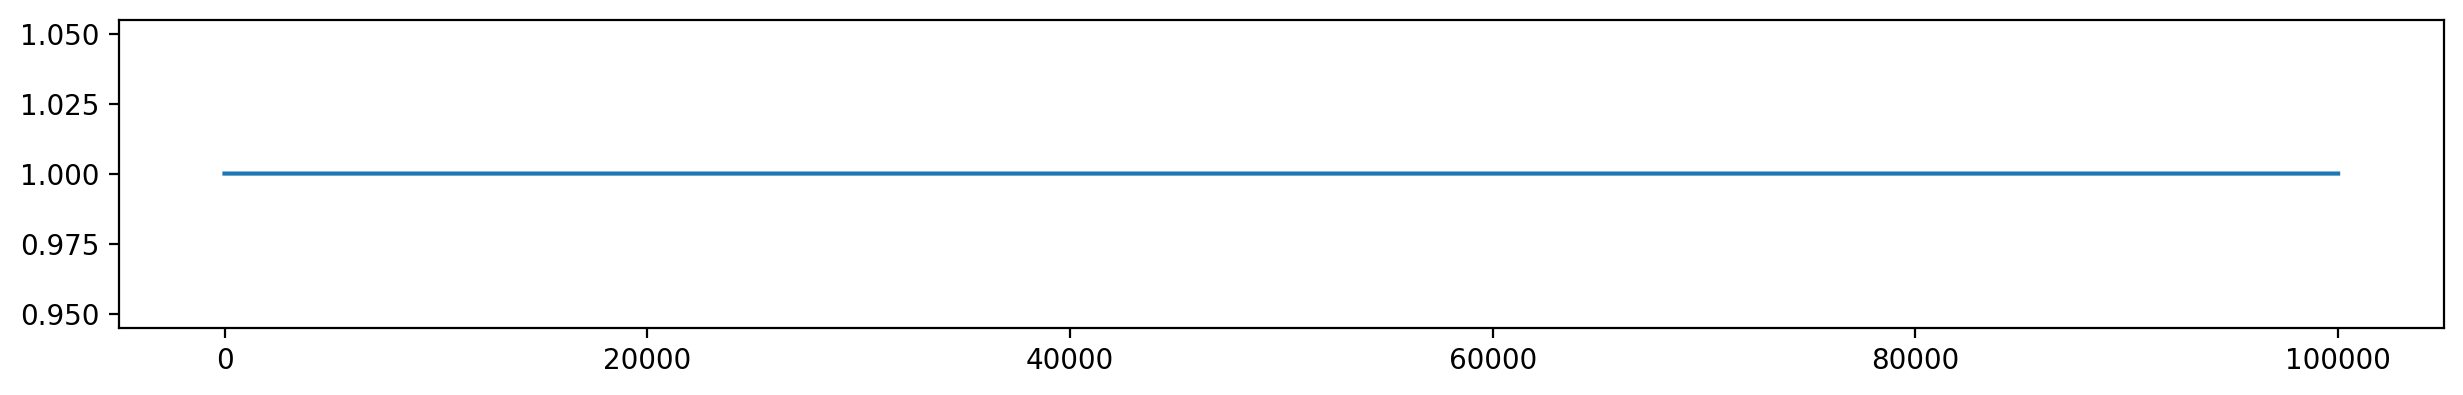

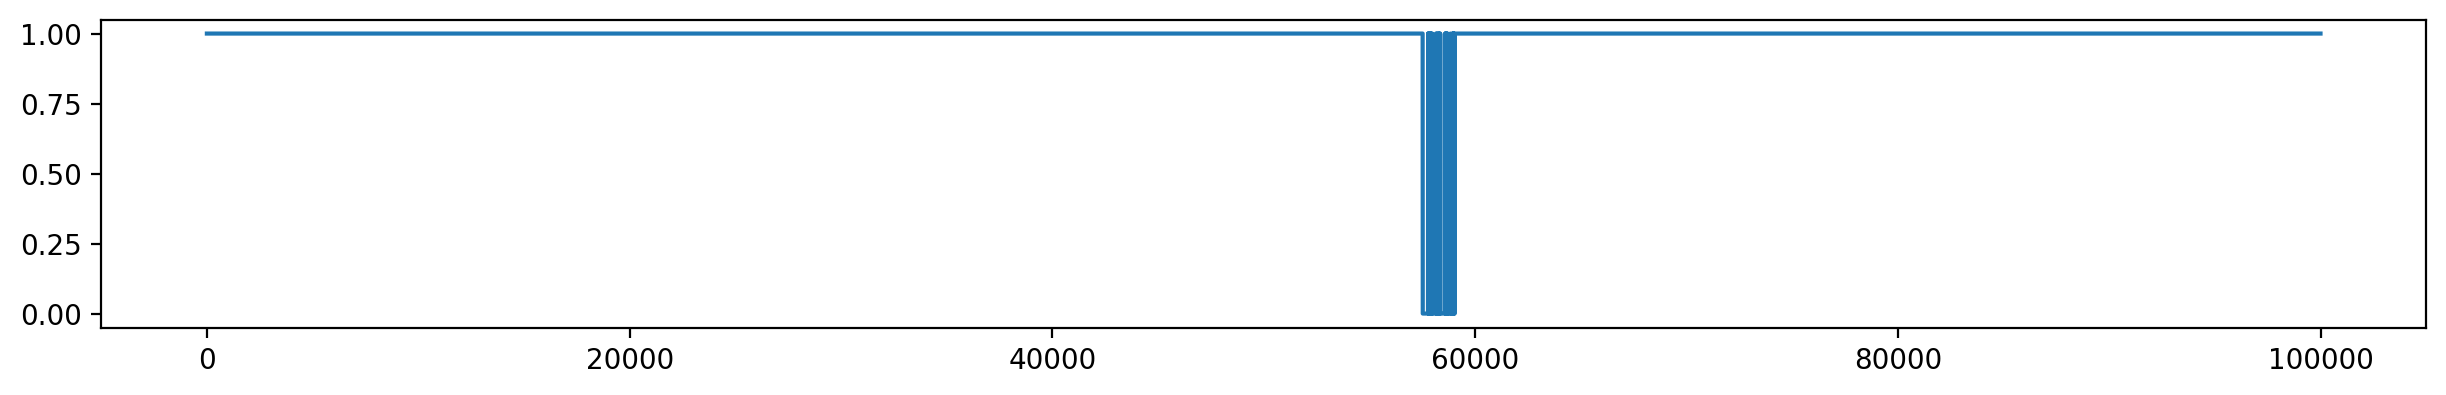

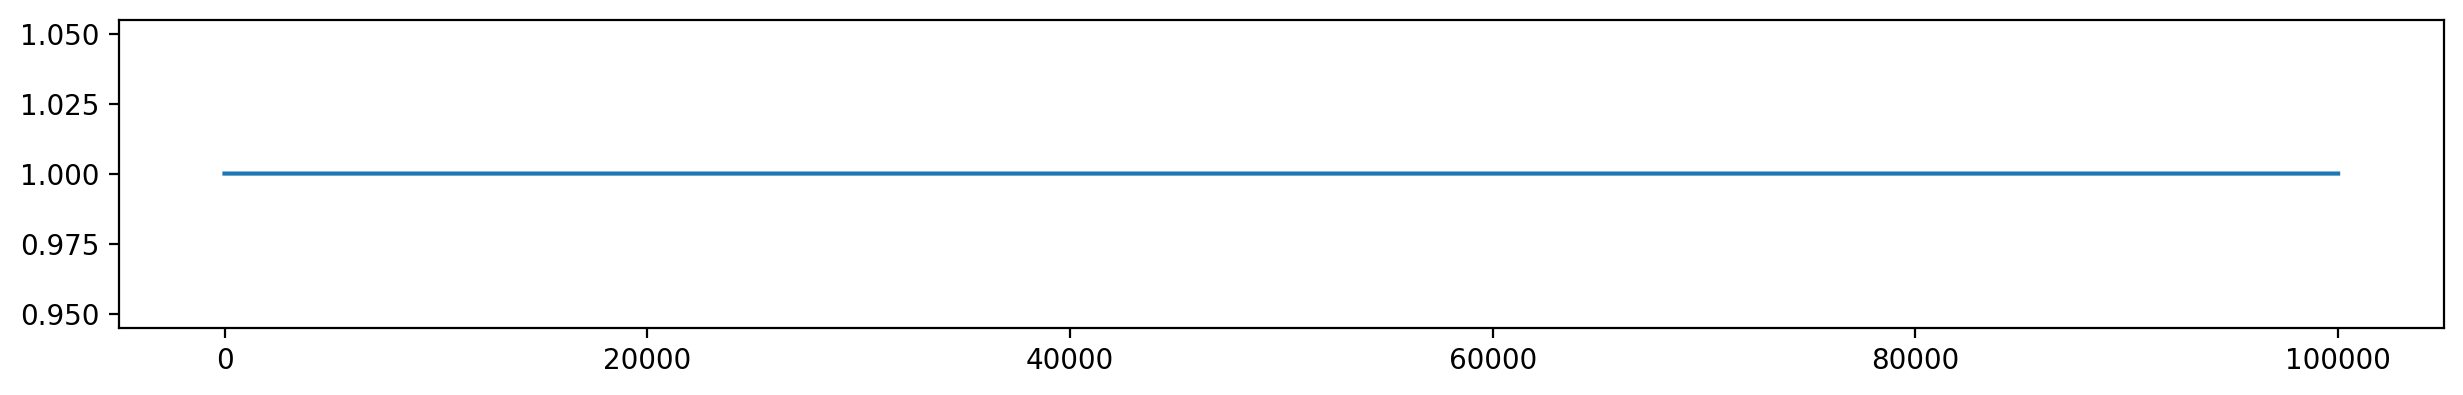

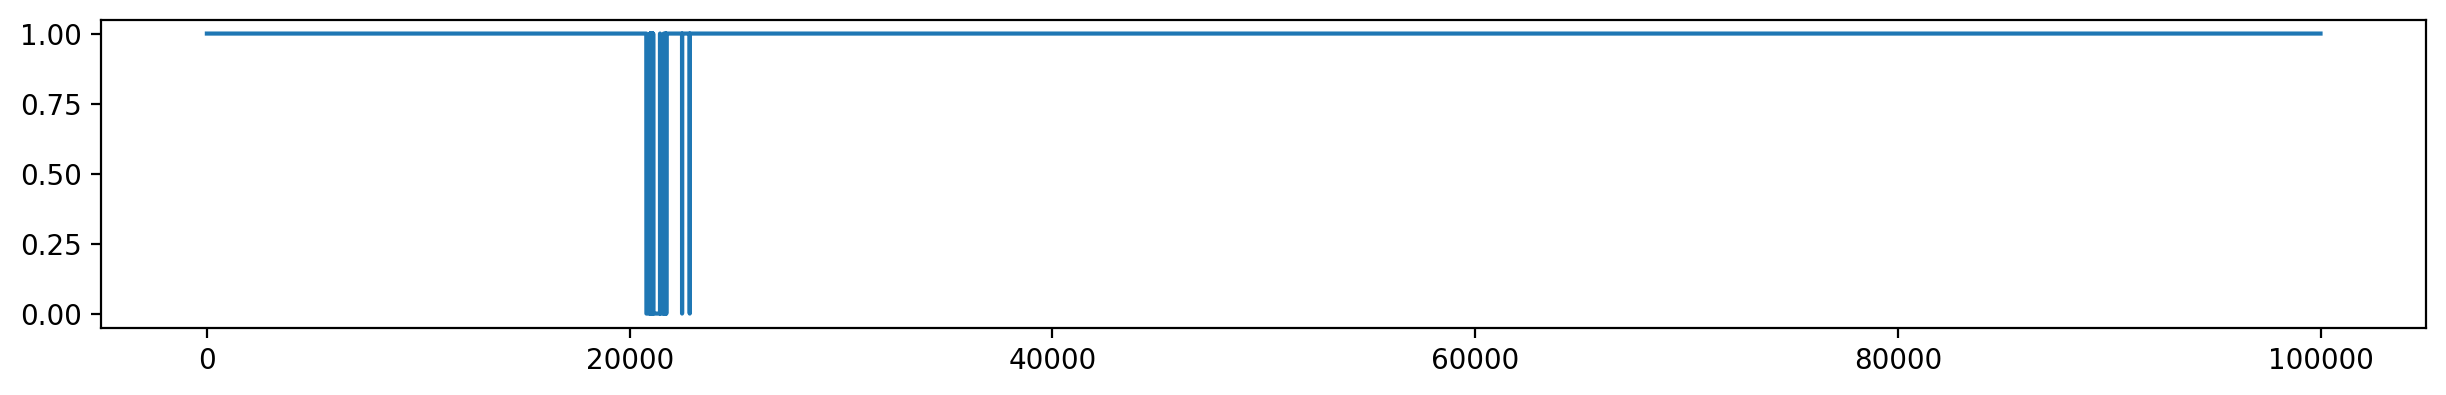

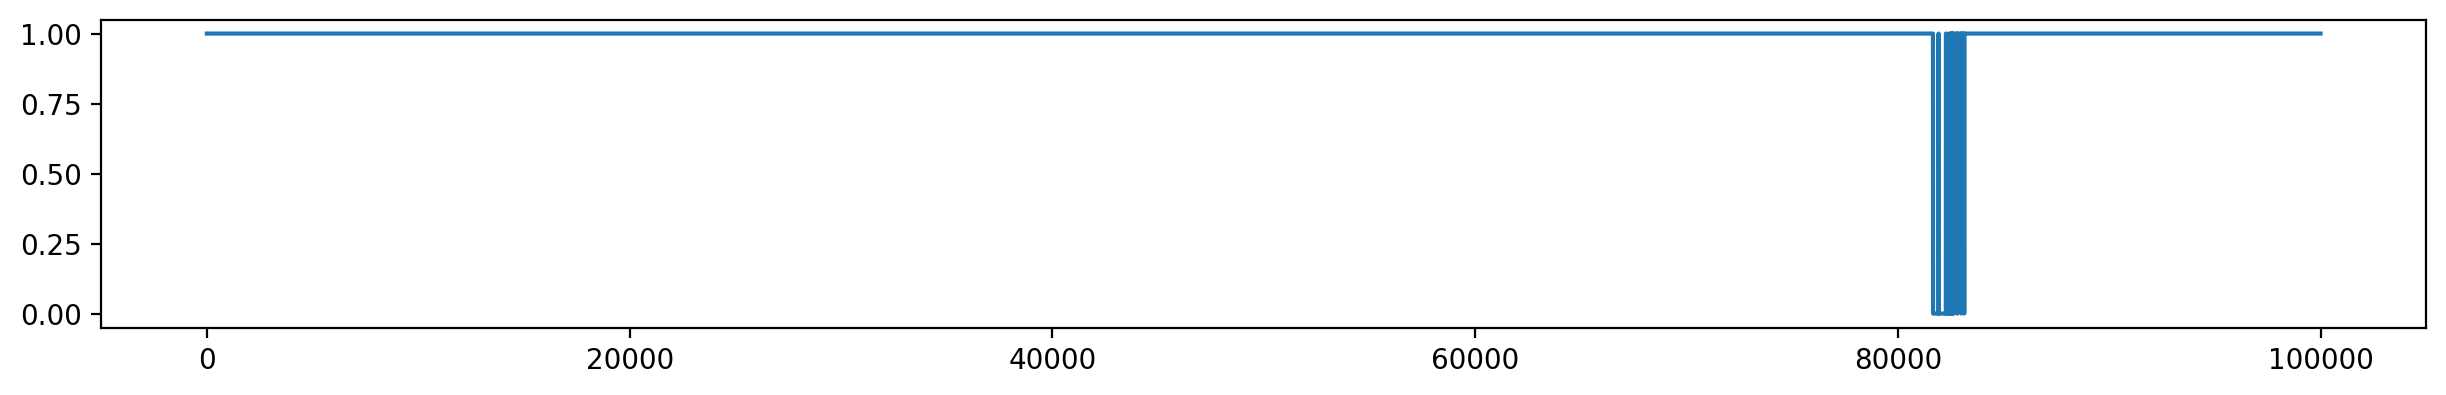

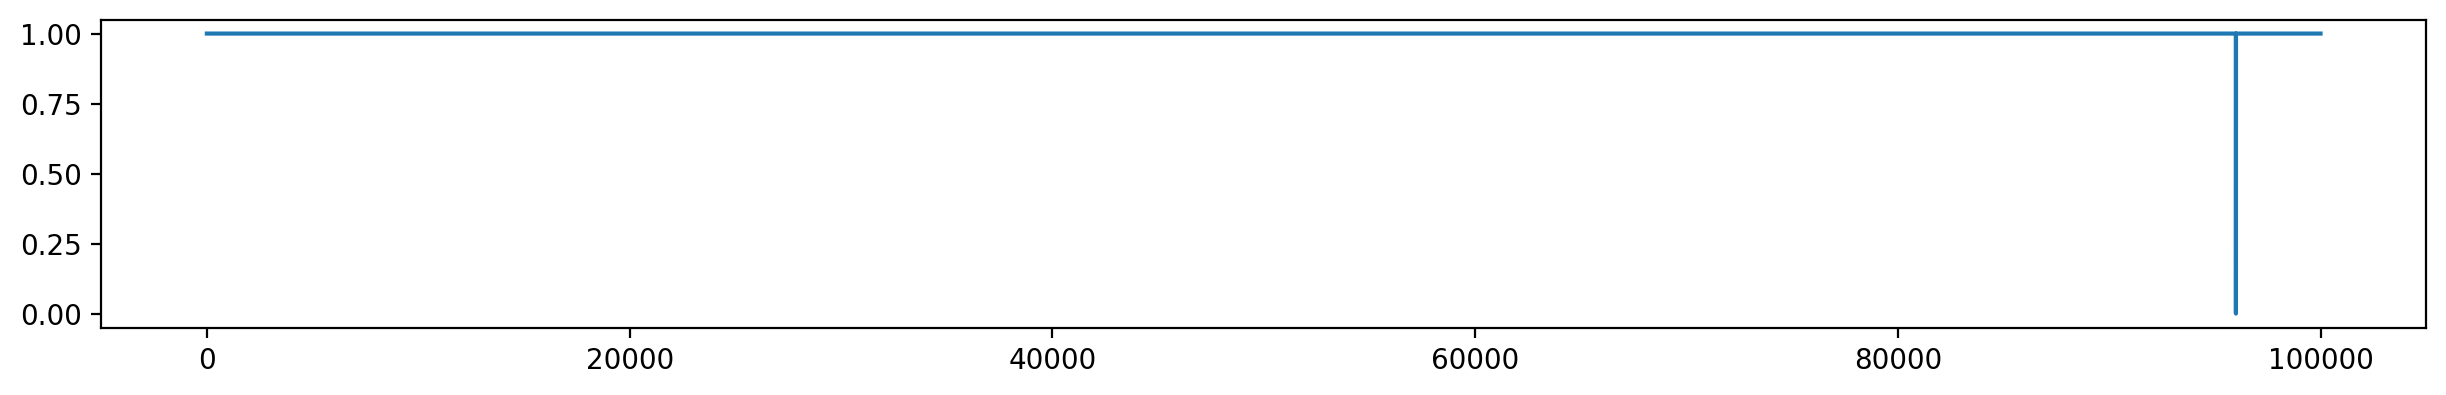

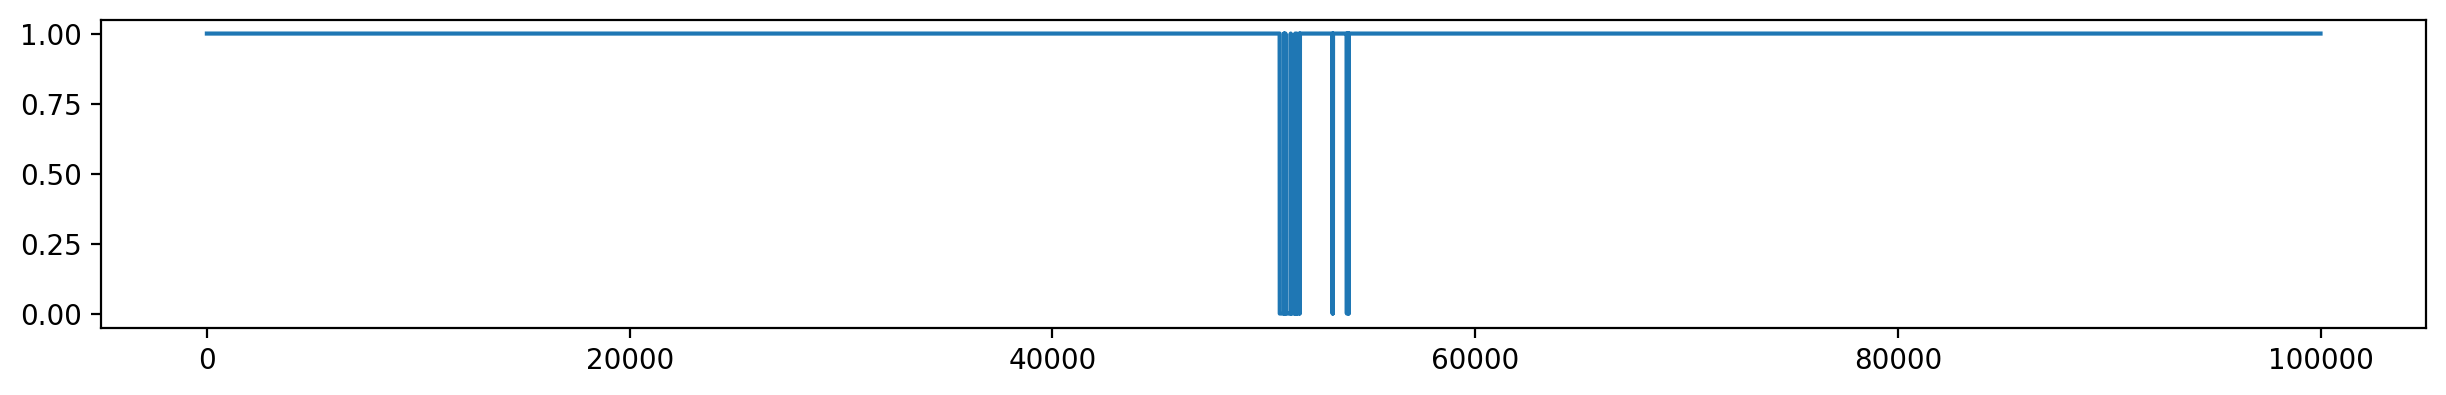

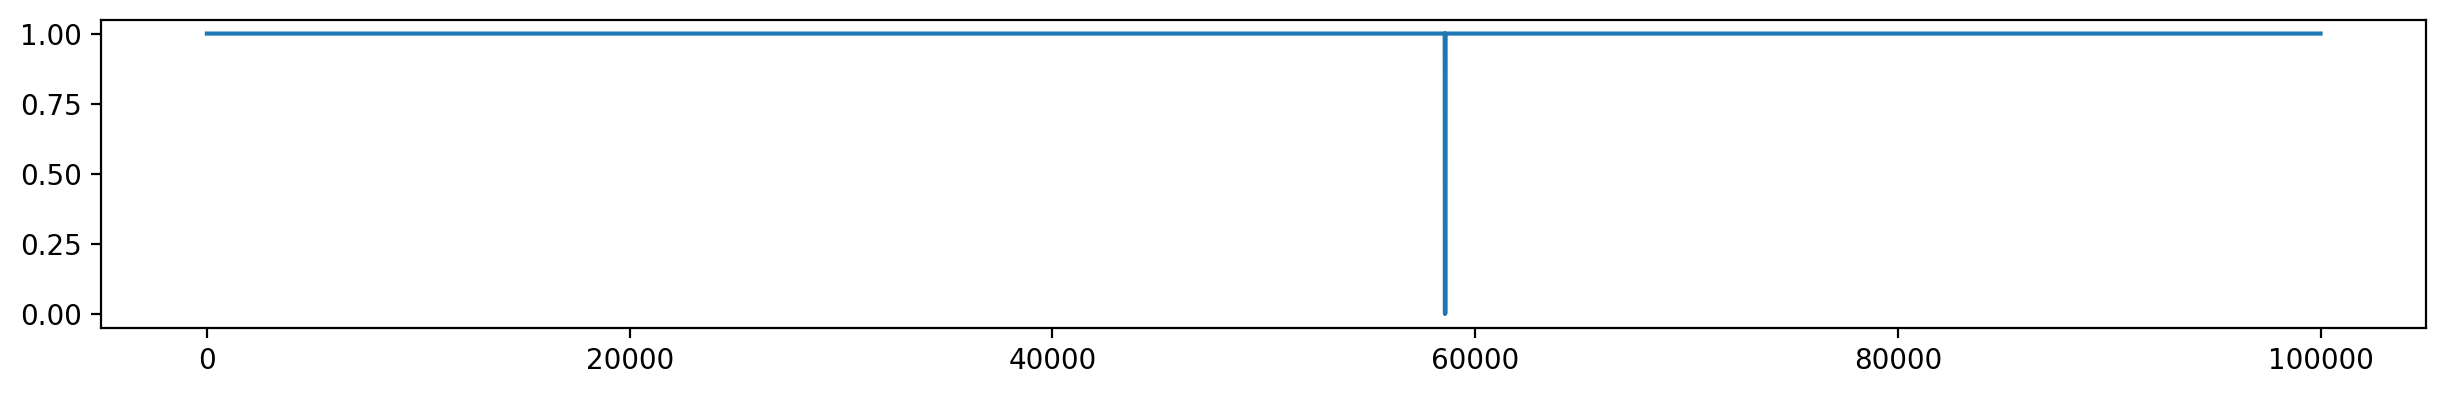

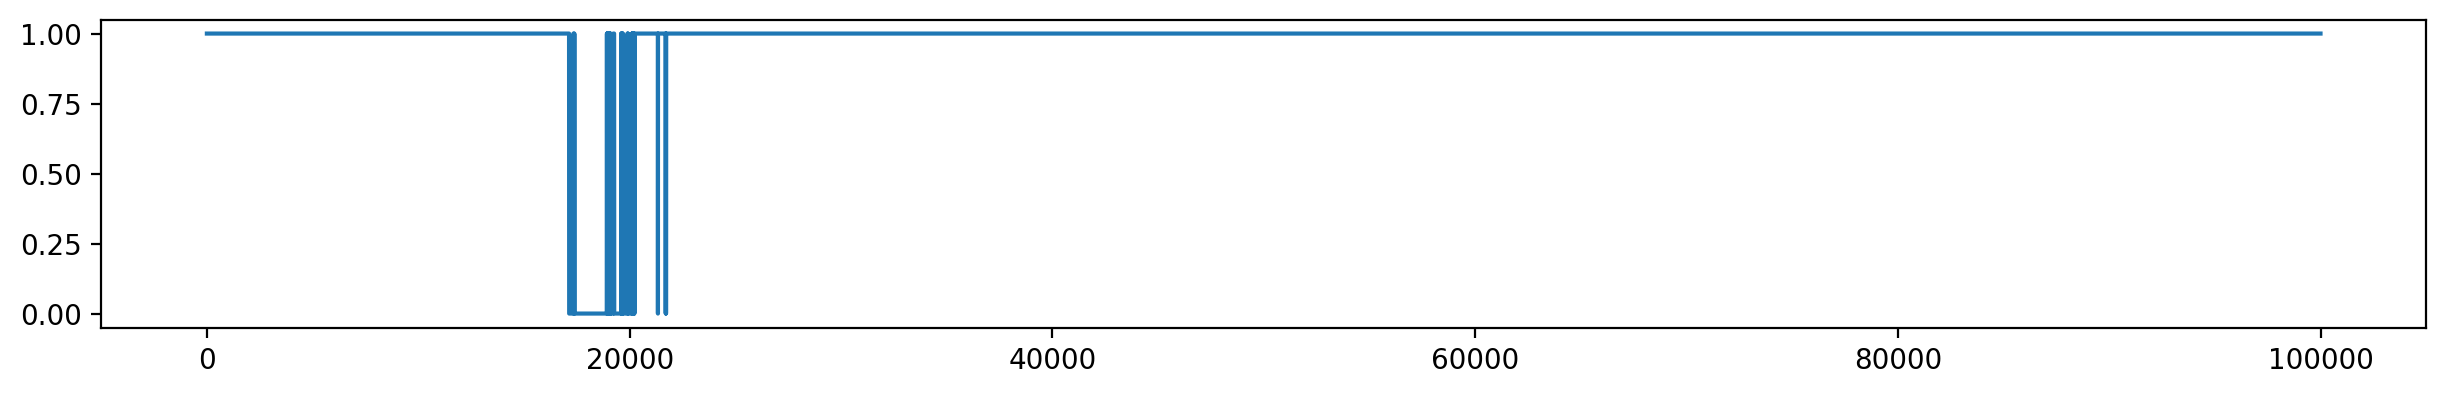

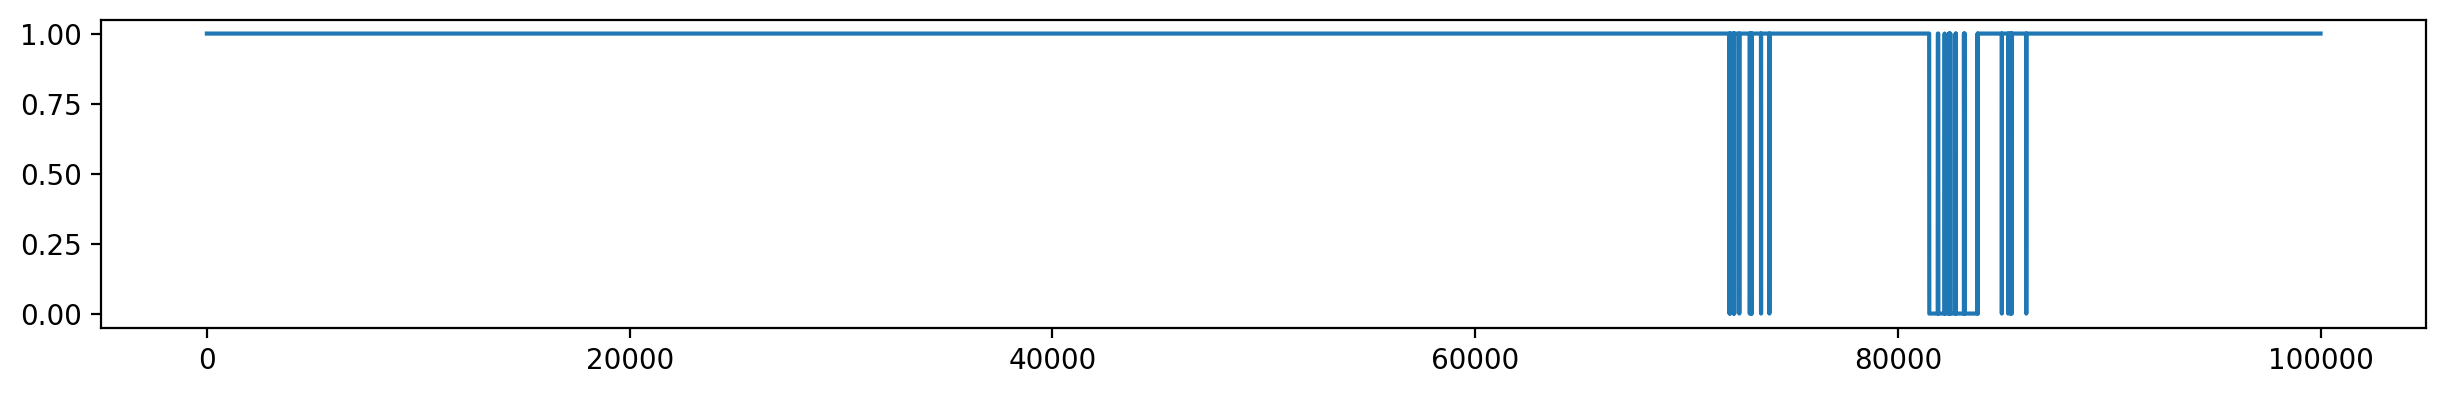

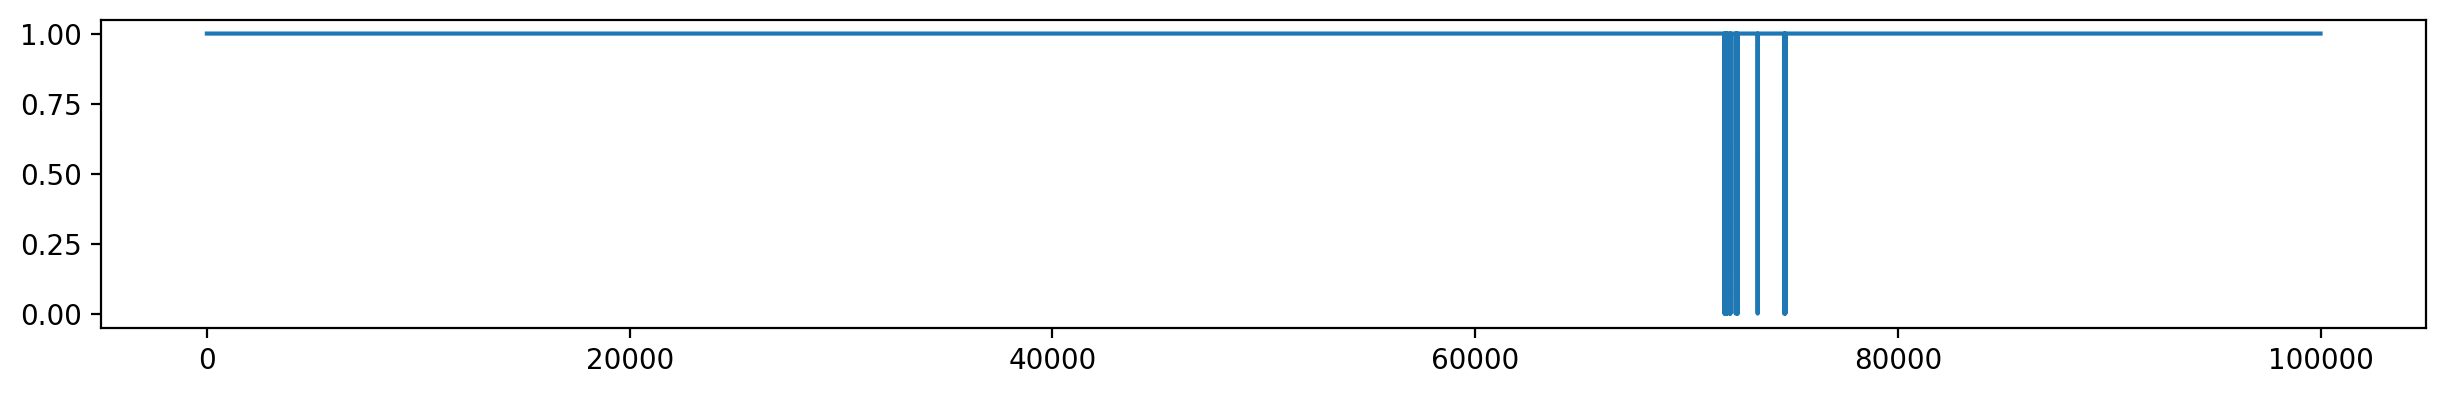

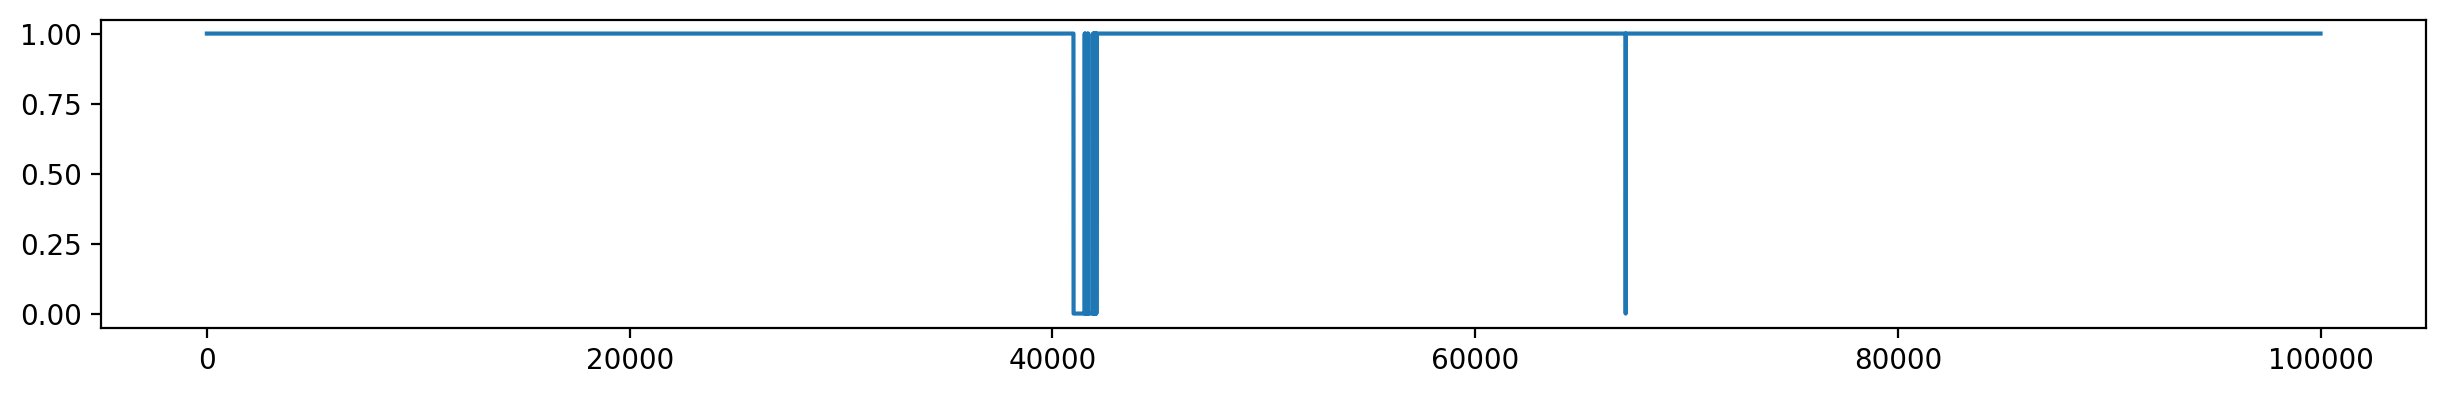

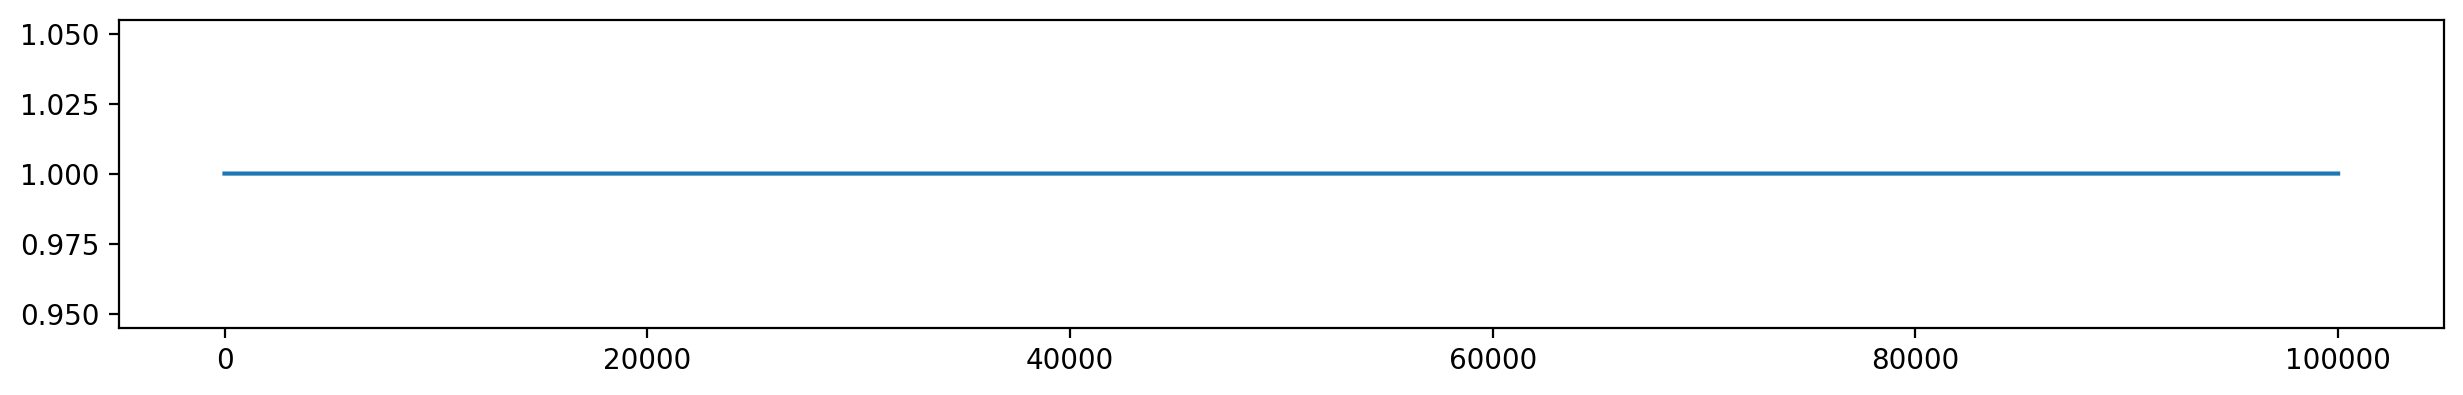

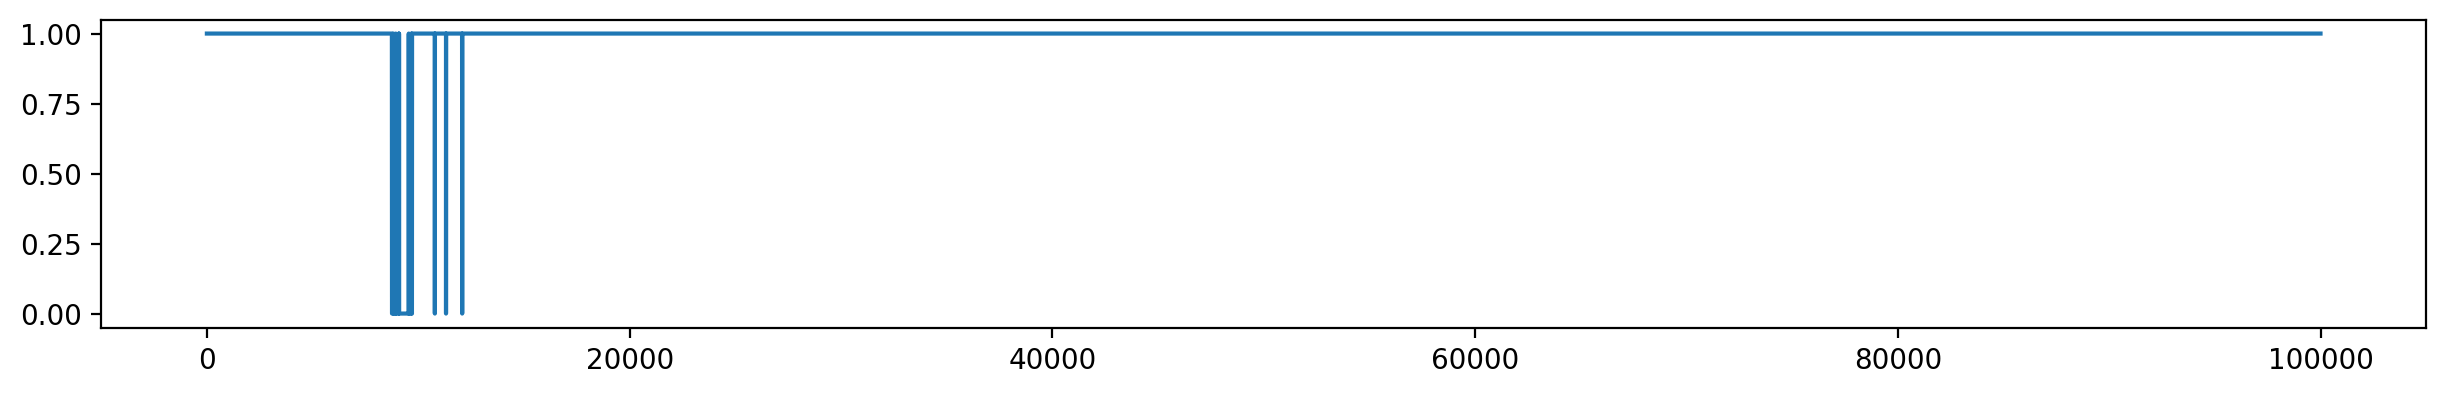

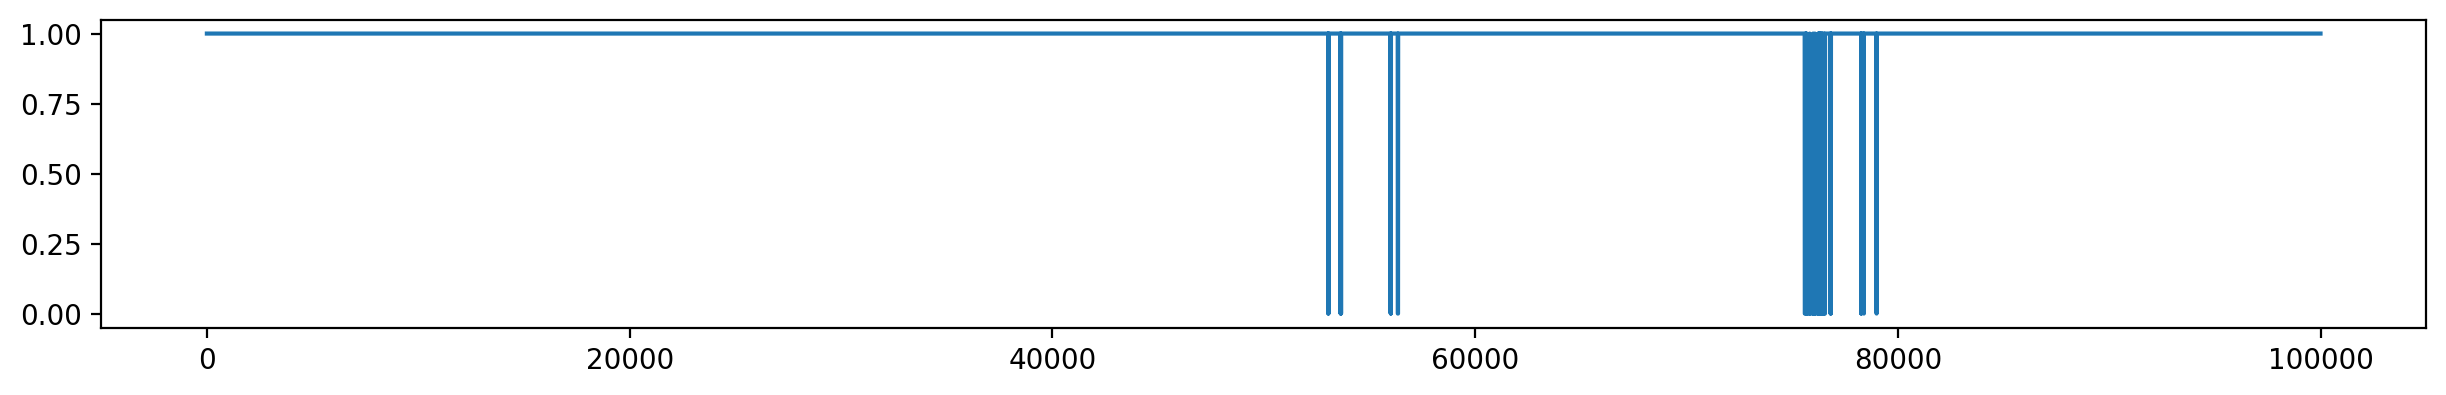

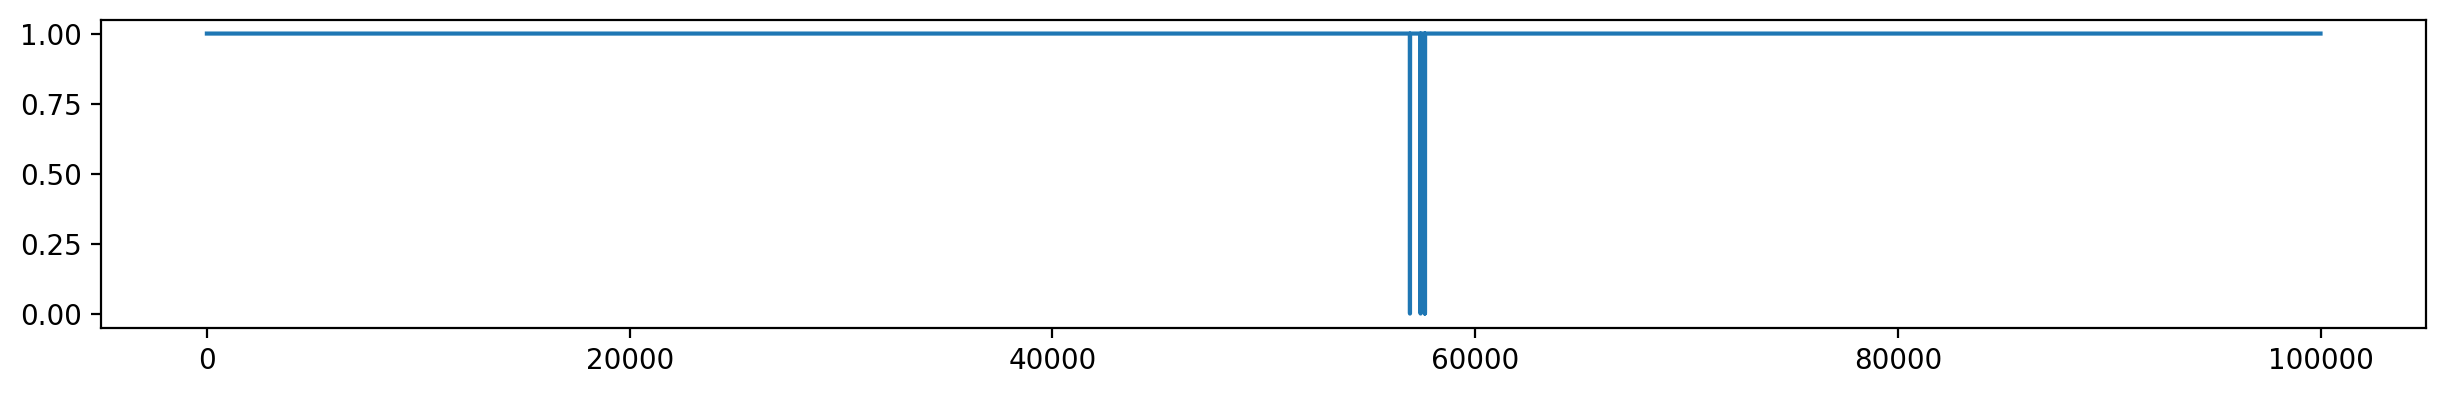

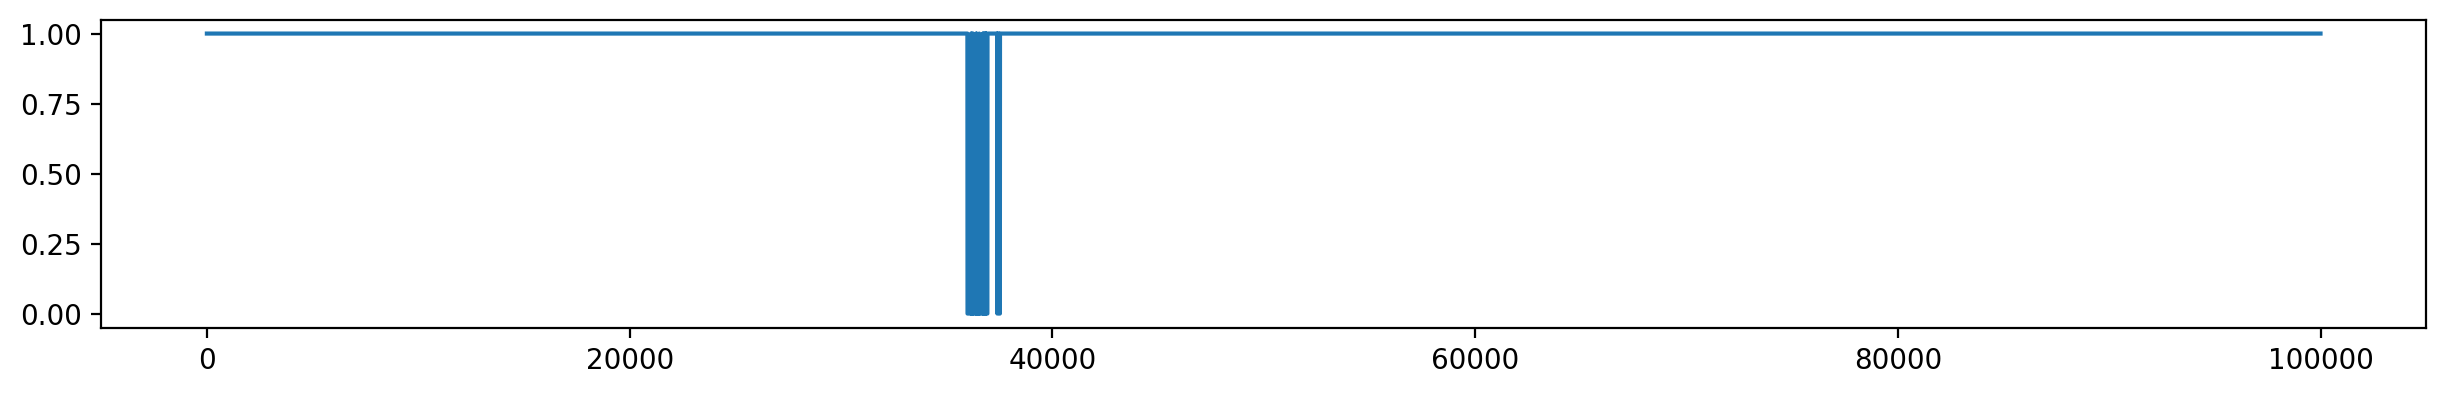

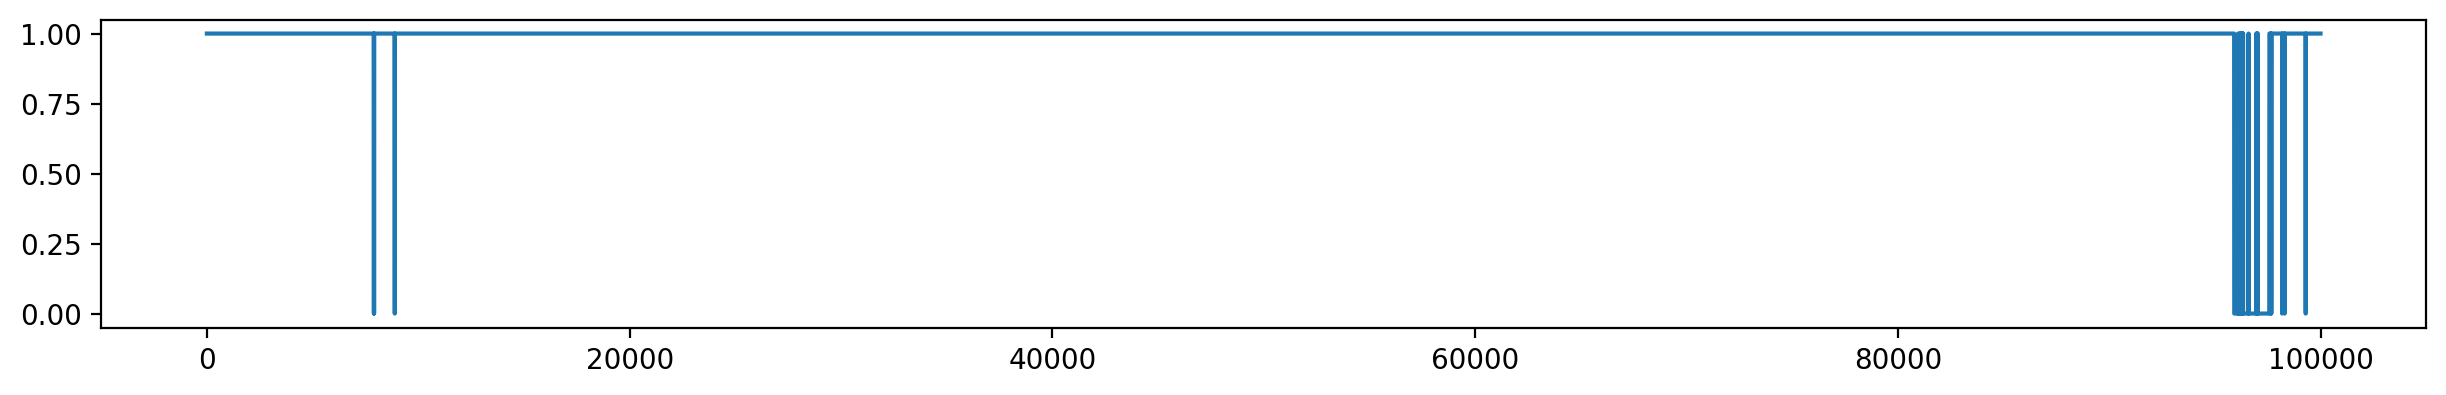

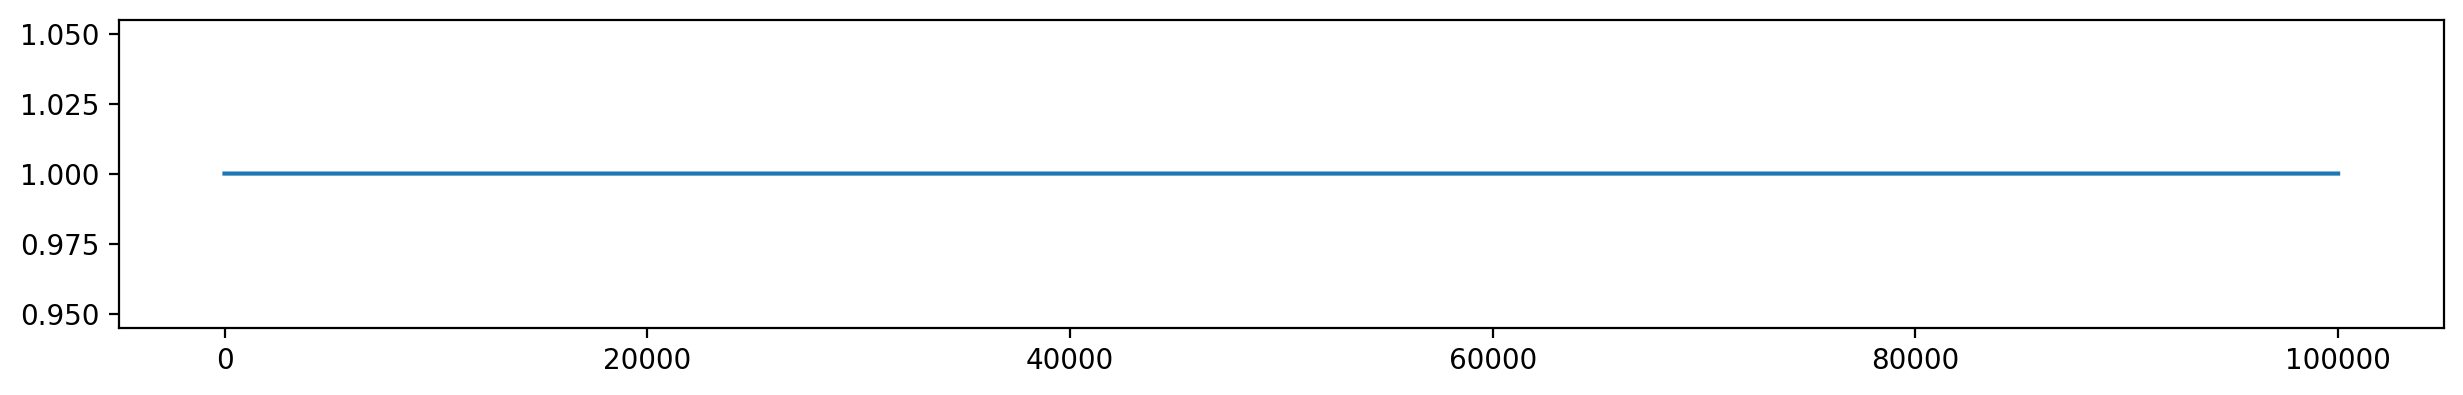

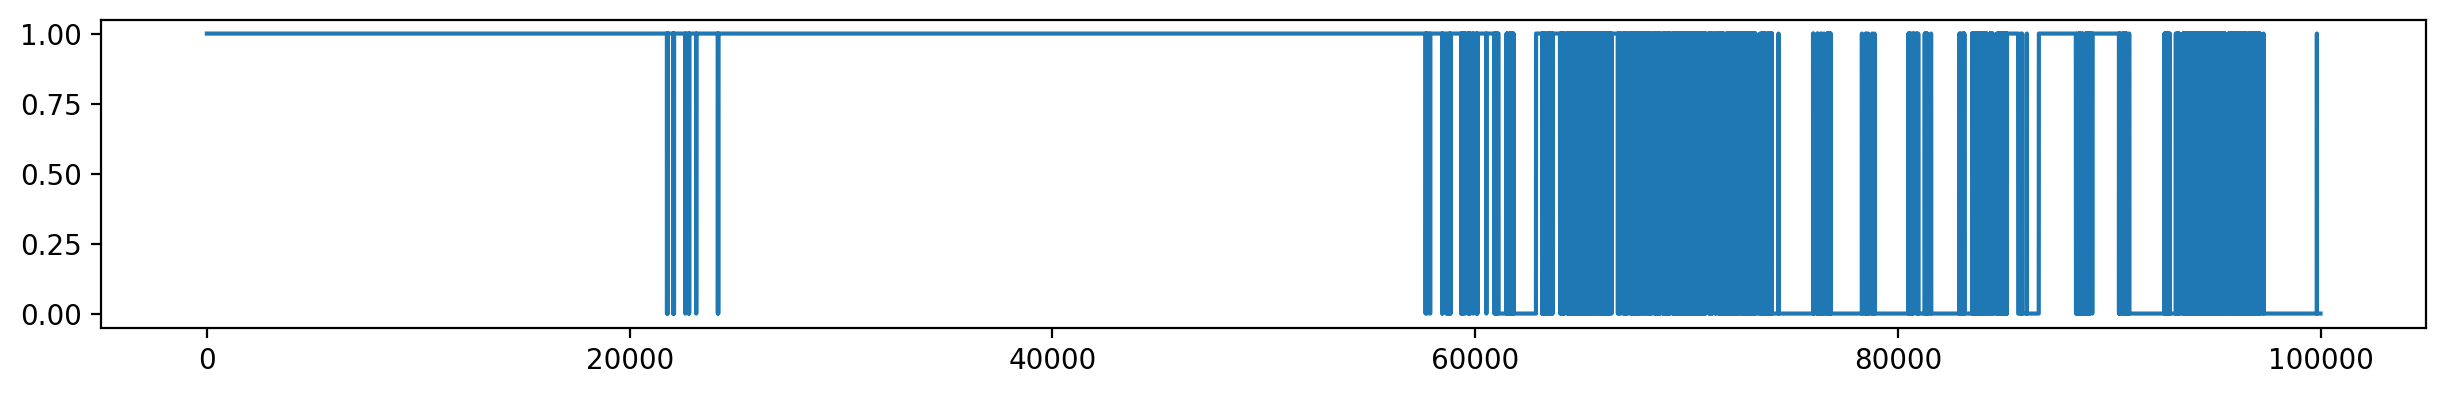

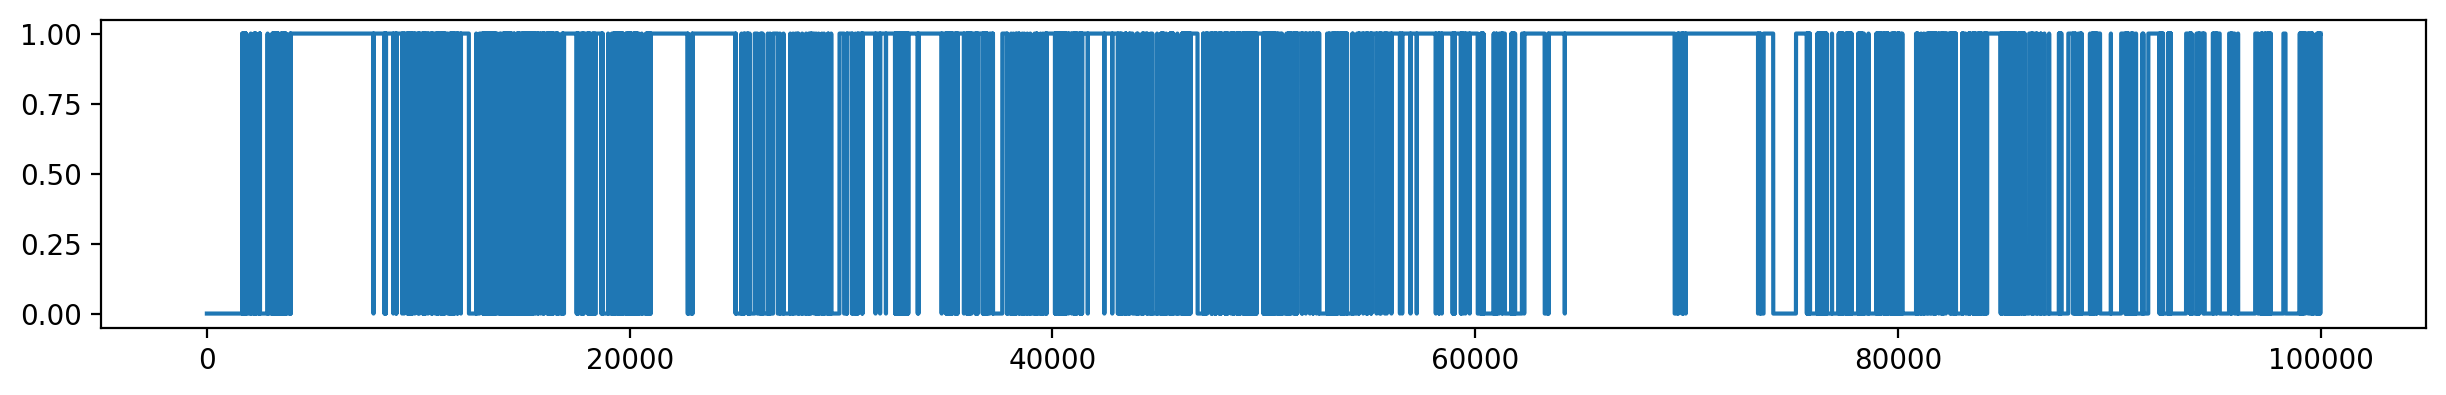

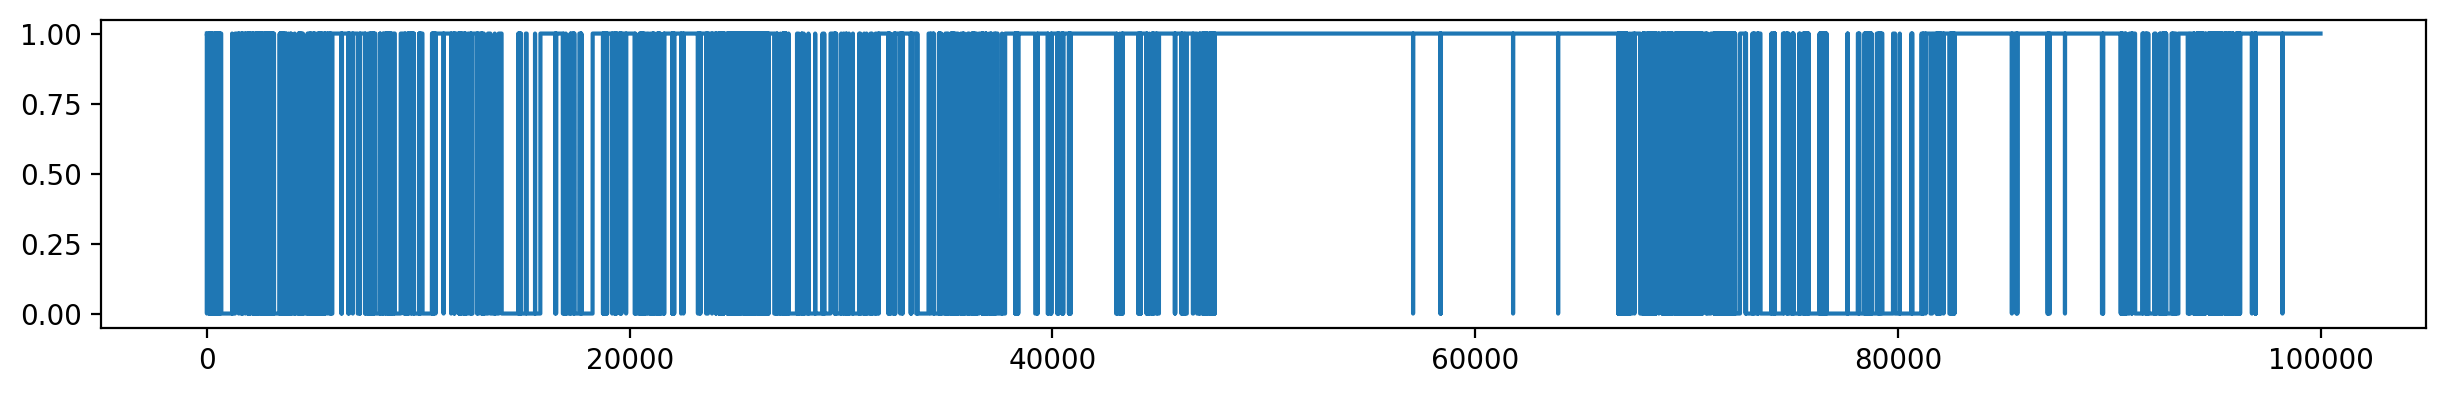

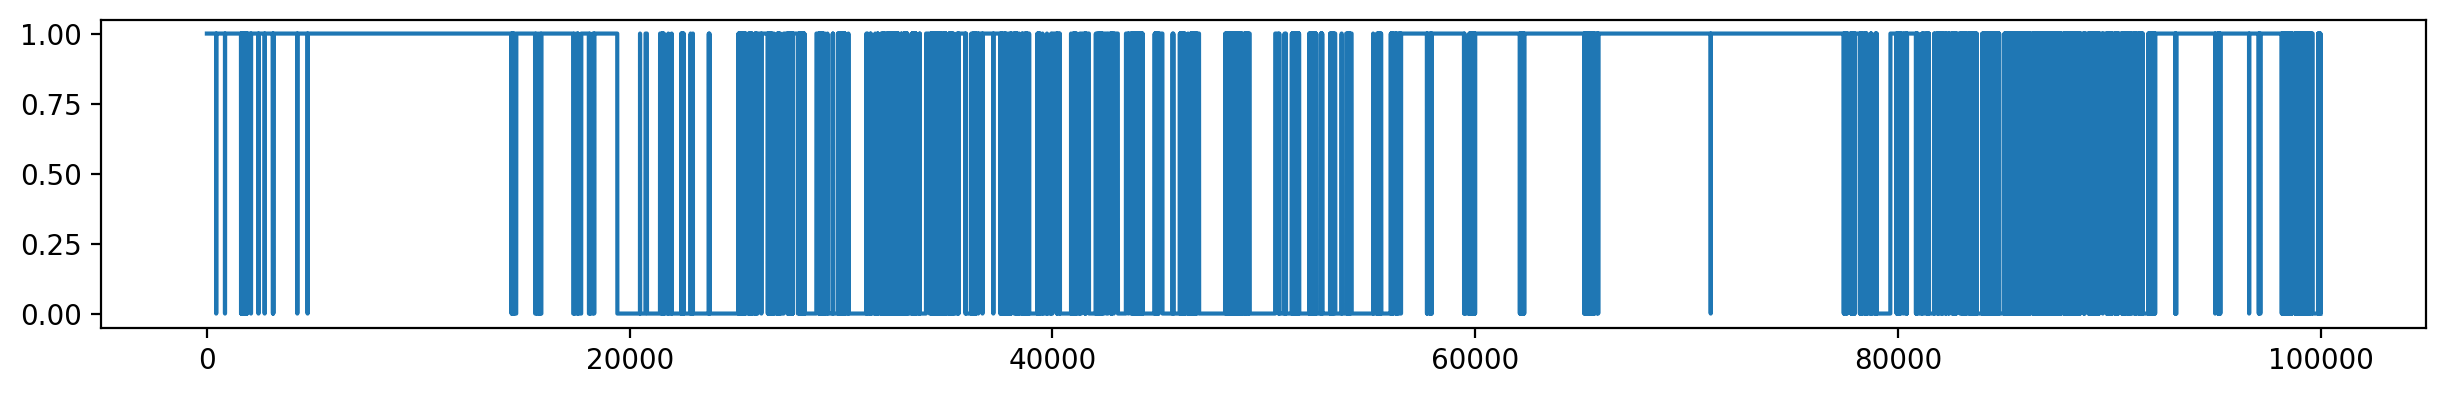

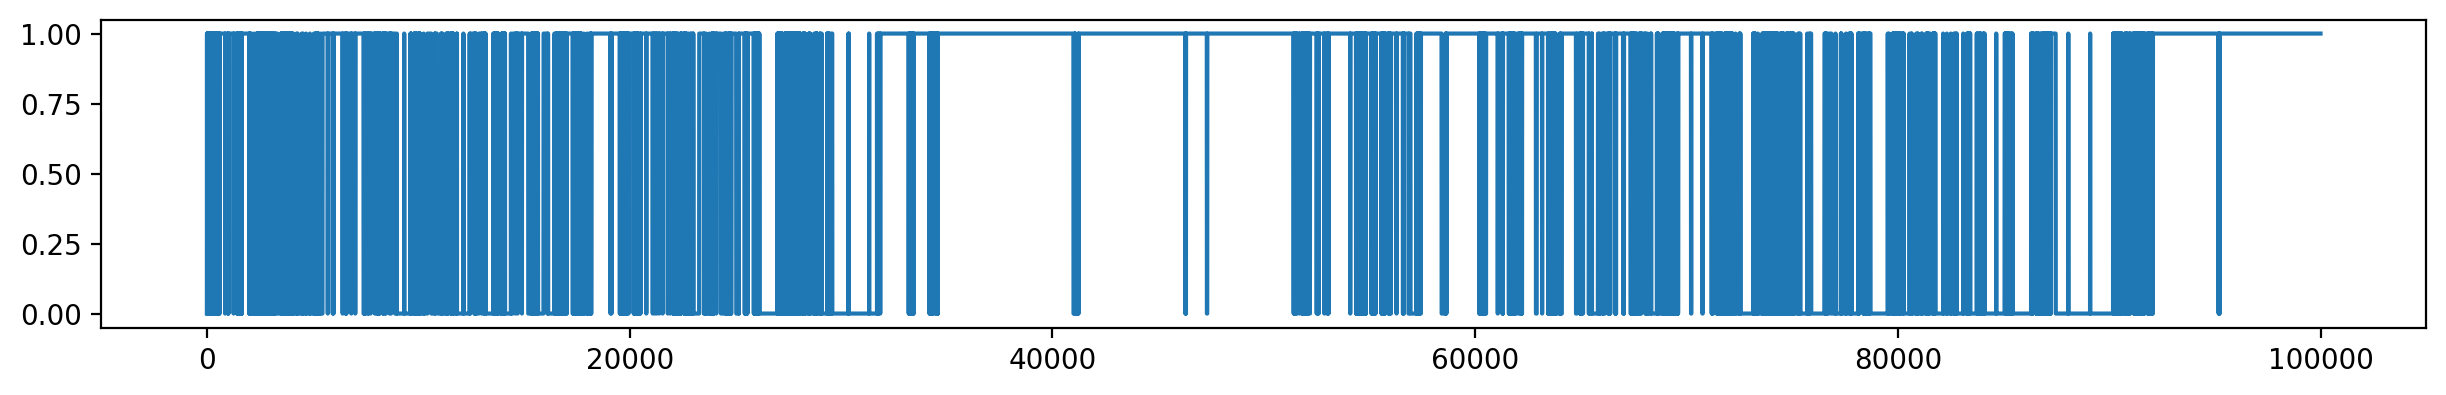

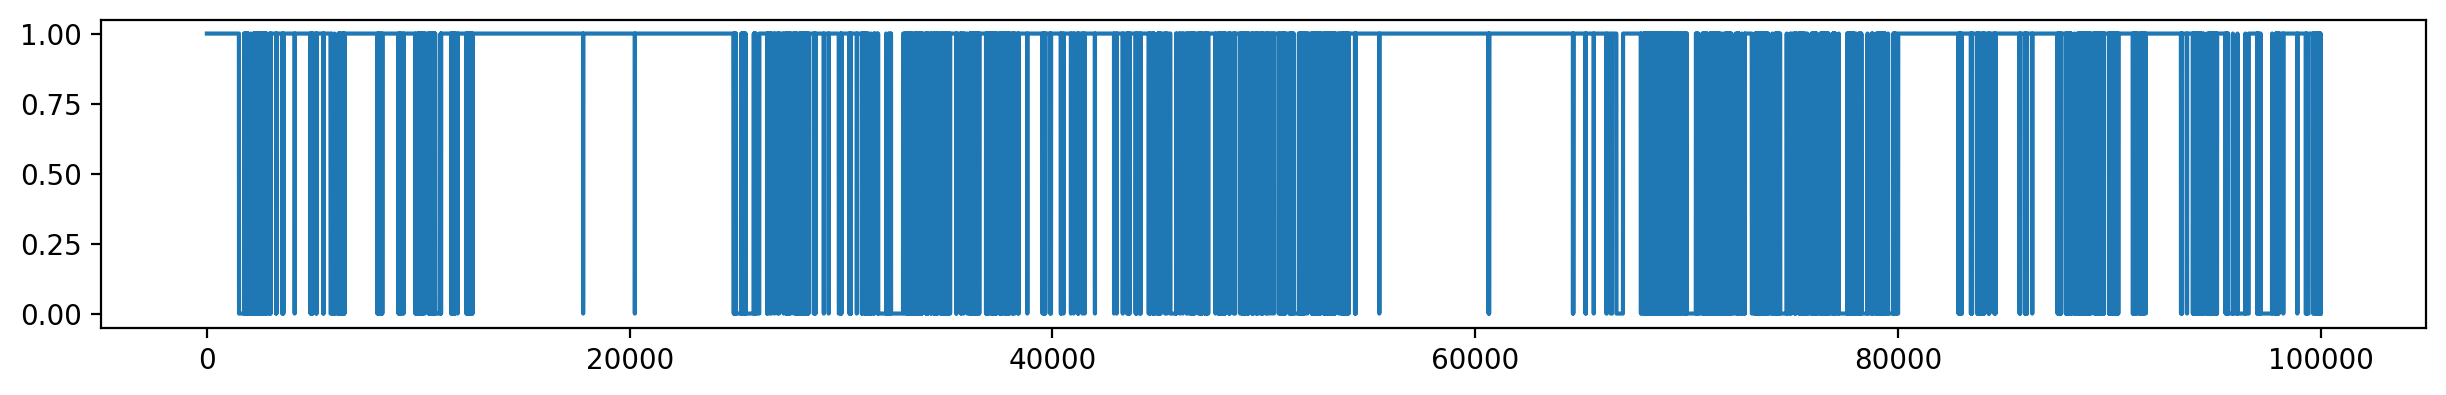

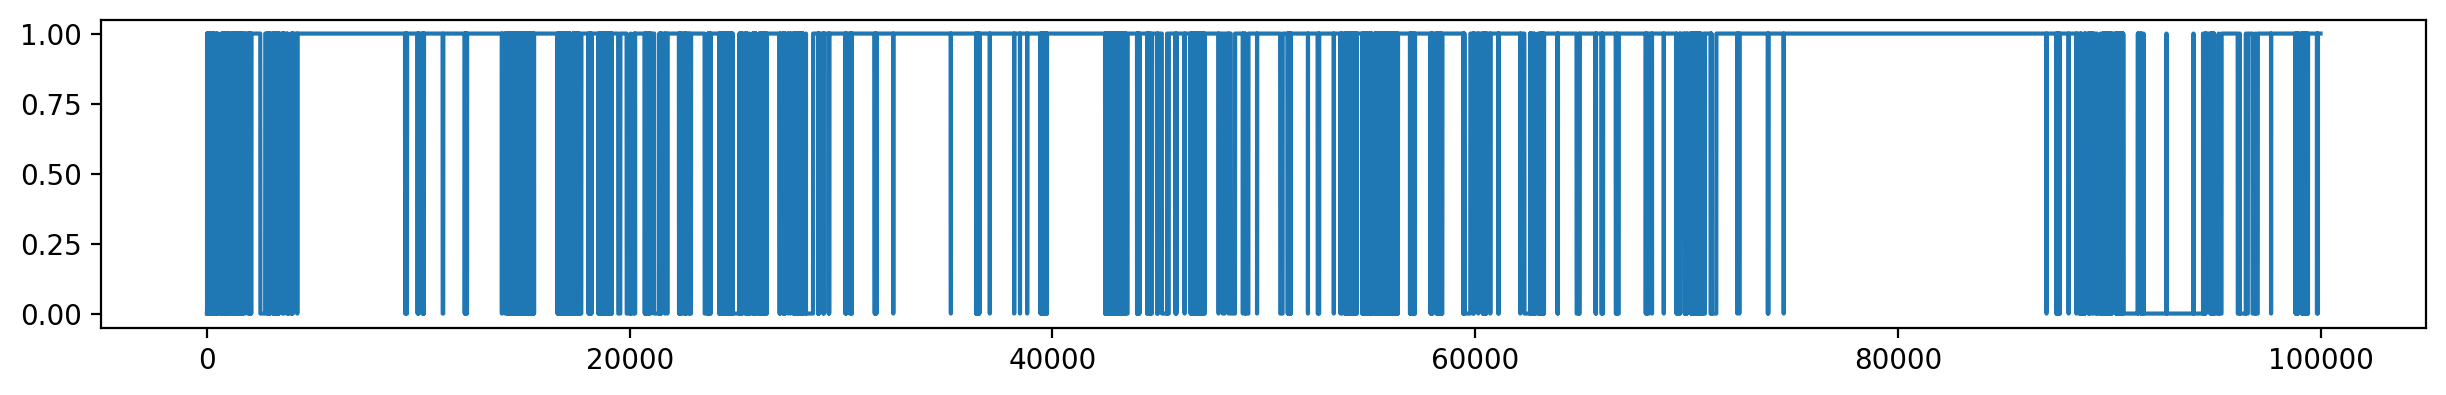

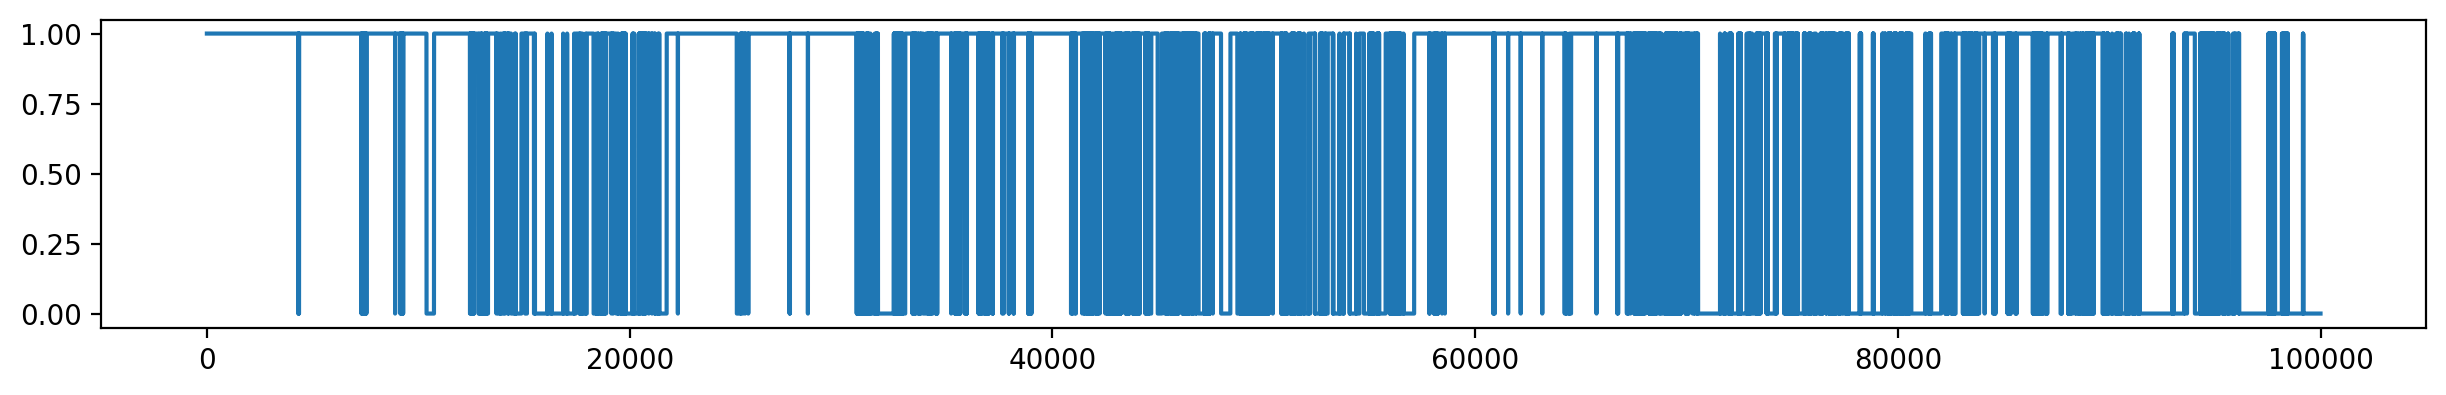

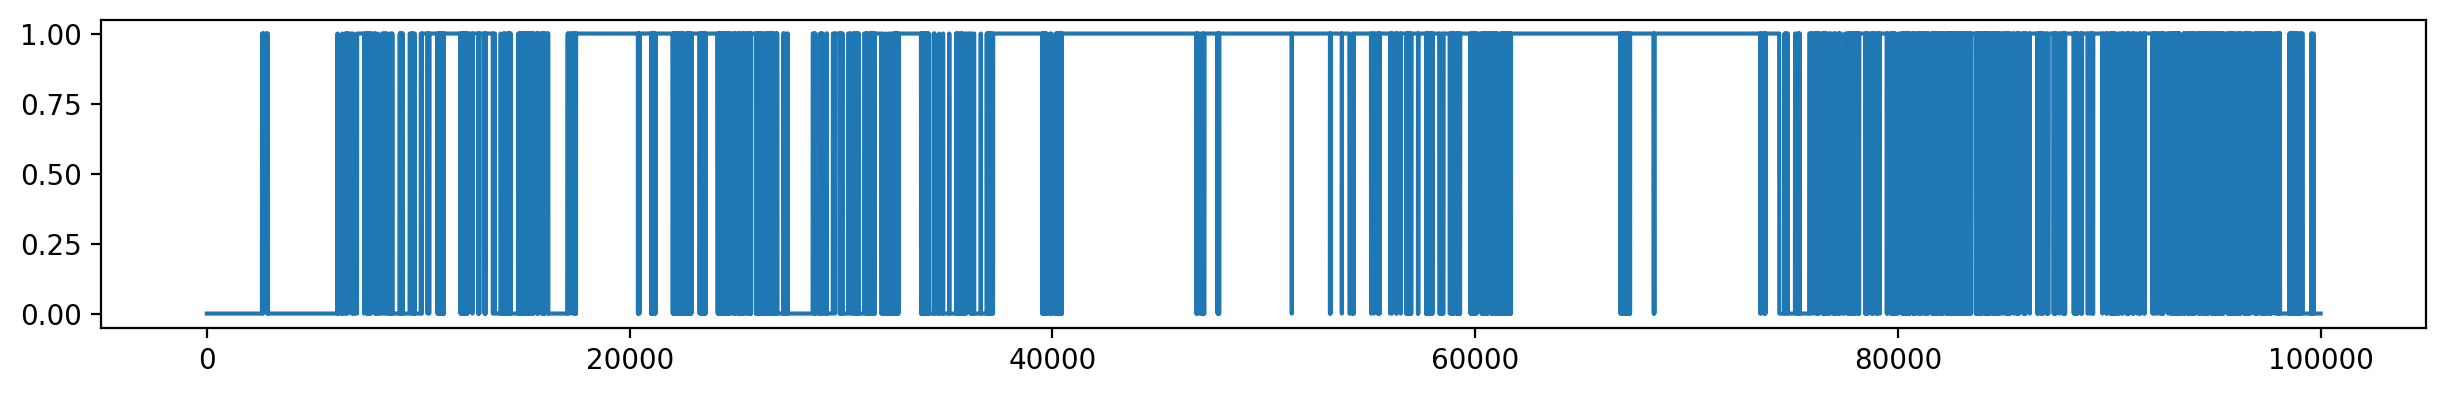

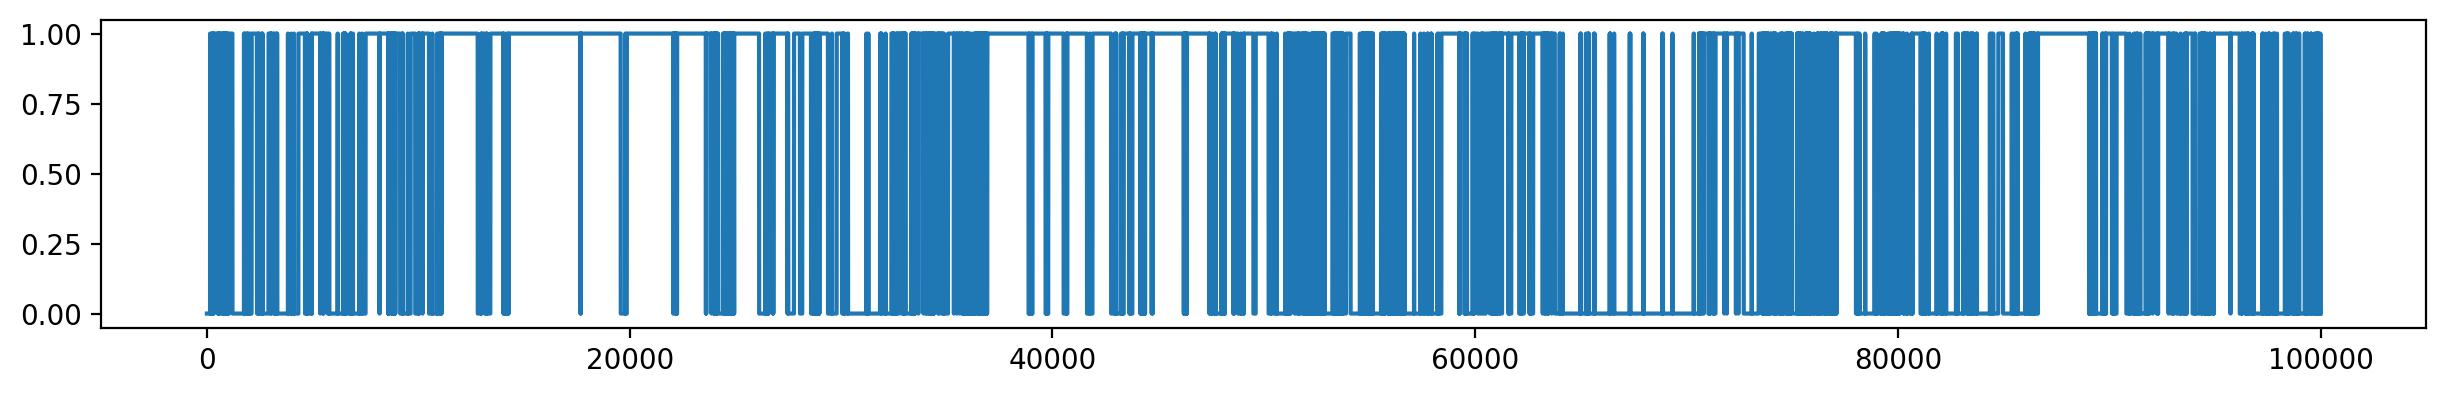

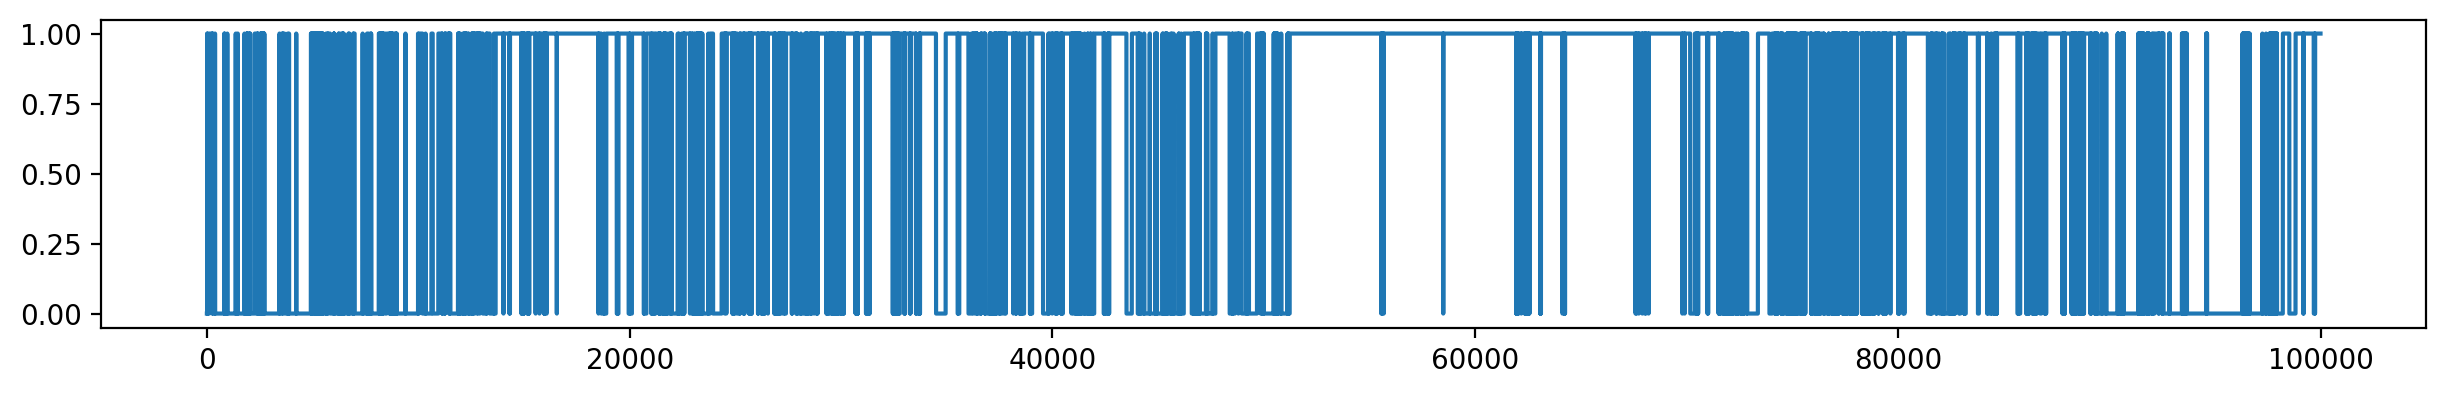

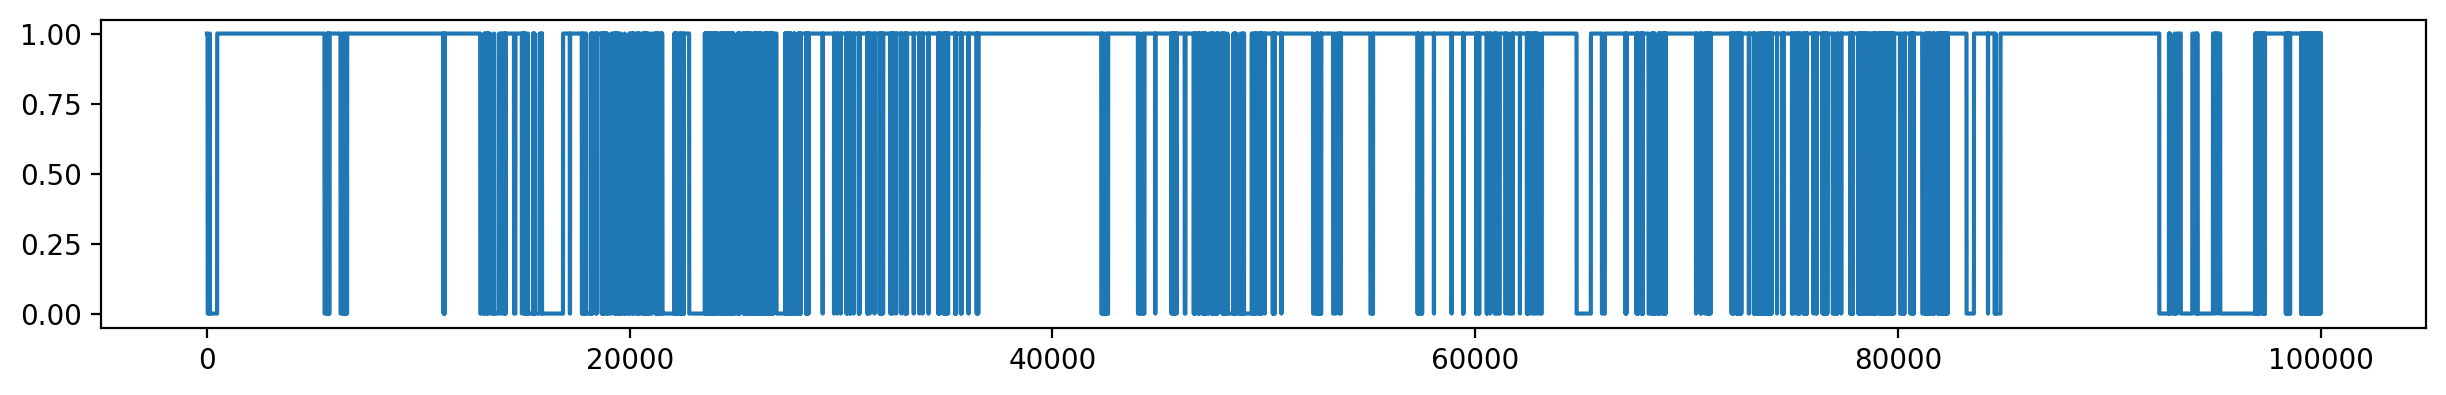

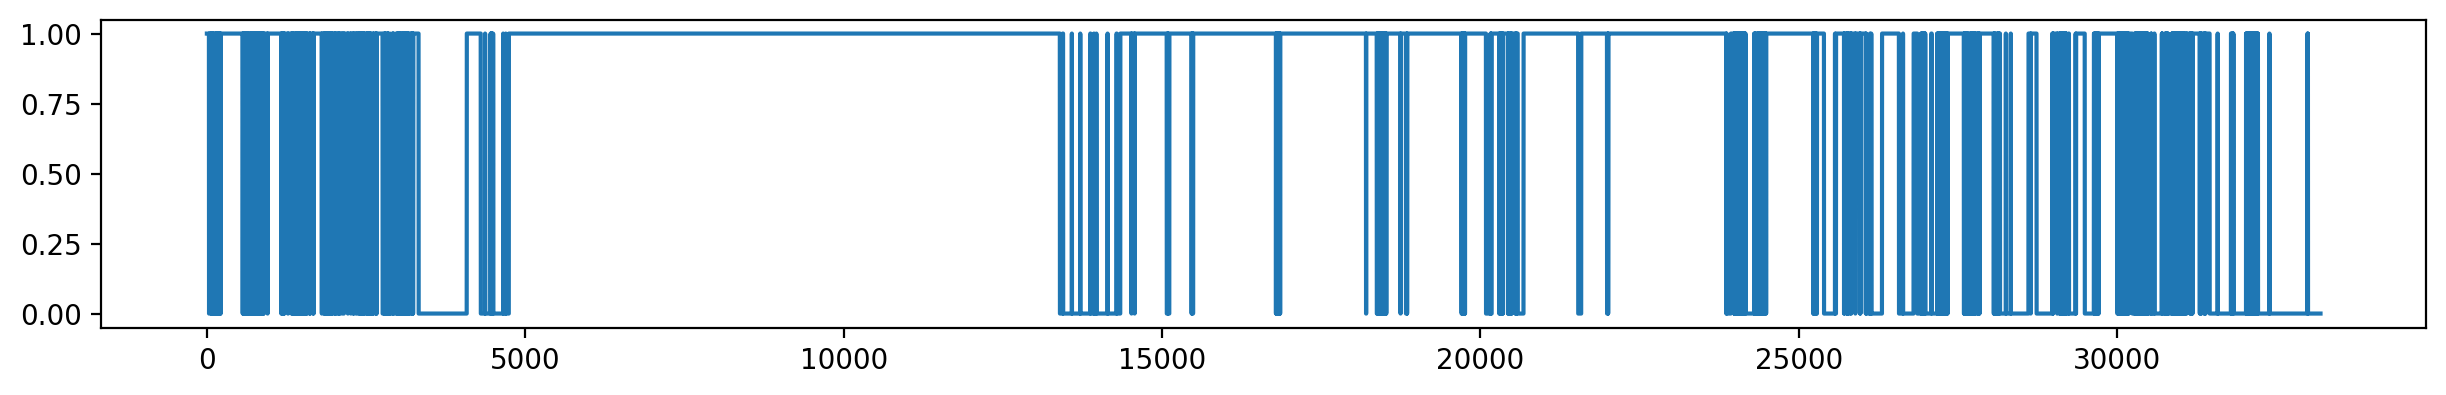

In [57]:
i=0
while(i < preds.shape[0]):
    figure(figsize=(15, 2), dpi=200)
    plt.plot(preds[i:i+100000])
    plt.show()
    i=i+100000

In [58]:
np.squeeze(y_test[0]).shape

(17590,)

In [59]:
len(multi_test)

469

In [60]:
multi_test[1][1]

array(['observe'], dtype=object)

In [102]:
TARGET_FPR=0.0001
from dateutil.parser import parse


df_out = pd.DataFrame(columns=['start_idx_attack', 'end_idx_attack', 'attack_duration', 'time_to_detect', 'idx_detection_abs',
                               'idx_detection_rel', 'attack_len', 'attack_type','fpr','tpr','pr','rec','tn', 'fp','fn','tp'])

for i in range(0, len(x_test)):
    
    preds=bst.predict(x_test[i])
    preds_proba=bst.predict_proba(x_test[i])
    
    y_test_atk= np.where(y_test[i] == 1)[0]
    y_test_norm= np.where(y_test[i] == 0)[0]
    
    fpr, tpr, thresholds = metrics.roc_curve(y_test[i],  preds_proba[:,1])    
    fpr_index=np.min(np.where(fpr >= TARGET_FPR))-1
    fpr_value=fpr[fpr_index]
    tpr_value=tpr[fpr_index]
    
    preds = np.array([1 if prob > thresholds[fpr_index] else 0 for prob in preds_proba[:, 1]])
    
    y_temp = y_test[i].reshape((y_test[i].shape[0],))
    time_temp = time_test[i].reshape((time_test[i].shape[0],))
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(np.squeeze(y_test[i]), preds).ravel()
    
    pr = sklearn.metrics.precision_score(y_test[i], preds)
    rec = sklearn.metrics.recall_score(y_test[i], preds)
    
    preds_1=preds[y_test_atk]
    
    date_time_0 = time_temp[y_test_atk[0]]
    date_time_last = time_temp[y_test_atk[y_test_atk.shape[0]-1]]
    
    date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
    date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
    attack_time = date_time_last - date_time_0
    
    if 1 in preds_1:
        index_rel=np.where(preds_1 == 1)[0][0]
        index= y_test_atk[index_rel]
        date_time_index = time_temp[index]
        date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
        detection_time = date_time_index - date_time_0
    else:
        index_rel = -1
        index = -1
        detection_time = -1
    
    df_out.loc[i] = pd.Series({'start_idx_attack': y_test_atk[0], 'end_idx_attack': y_test_atk[y_test_atk.shape[0]-1],
                               'attack_duration': attack_time , 'time_to_detect': detection_time, 'idx_detection_abs': index,
                               'idx_detection_rel':index_rel, 'attack_len': preds_1.shape[0],
                               'attack_type':multi_test[i][y_test_atk[0]][0],'fpr':fpr_value,'tpr': tpr_value, 'pr': pr, 'rec': rec,
                               'tn':tn, 'fp':fp, 'fn':fn, 'tp':tp})
    
    print("tpr {} , fpr {}".format(tpr_value, fpr_value))    
    print("the first detected 1 of a 1-series is at position: {}".format(index))

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.23085481179306508 , fpr 0.0
the first detected 1 of a 1-series is at position: 14126
tpr 0.11433074684772065 , fpr 0.0
the first detected 1 of a 1-series is at position: 15441
tpr 0.7683658170914542 , fpr 0.0
the first detected 1 of a 1-series is at position: 1159
tpr 0.6669310071371927 , fpr 0.0
the first detected 1 of a 1-series is at position: 1355
tpr 0.4004739336492891 , fpr 0.0
the first detected 1 of a 1-series is at position: 1253
tpr 0.31791044776119404 , fpr 0.0
the first detected 1 of a 1-series is at position: 1297
tpr 0.7122302158273381 , fpr 0.0
the first detected 1 of a 1-series is at position: 1341
tpr 0.66 , fpr 0.0
the first detected 1 of a 1-series is at position: 1352
tpr 0.17713004484304934 , fpr 0.0
the first detected 1 of a 1-series is at position: 1325
tpr 0.7821011673151751 , fpr 0.0
the first detected 1 of a 1-series is at position: 1085
tpr 0.15525375268048605 , fpr 0.0
the first detected 1 of a 1-series is at position: 12916
tpr 0.6996363636363636 , fp

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.2824675324675325 , fpr 0.0
the first detected 1 of a 1-series is at position: 1340
tpr 0.672093023255814 , fpr 0.0
the first detected 1 of a 1-series is at position: 1310
tpr 0.7476993865030674 , fpr 0.0
the first detected 1 of a 1-series is at position: 1140
tpr 0.7948316366483946 , fpr 0.0
the first detected 1 of a 1-series is at position: 1187
tpr 0.6623076923076923 , fpr 0.0
the first detected 1 of a 1-series is at position: 1257
tpr 0.776840490797546 , fpr 0.0
the first detected 1 of a 1-series is at position: 1149
tpr 0.7446975648075412 , fpr 0.0
the first detected 1 of a 1-series is at position: 1229
tpr 0.812111801242236 , fpr 0.0
the first detected 1 of a 1-series is at position: 1178
tpr 0.7878787878787878 , fpr 0.0
the first detected 1 of a 1-series is at position: 1291
tpr 0.7835703001579779 , fpr 0.0
the first detected 1 of a 1-series is at position: 1350
tpr 0.2545454545454545 , fpr 0.0
the first detected 1 of a 1-series is at position: 1220
tpr 0.8784665579119086 ,

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.8641975308641975 , fpr 0.0
the first detected 1 of a 1-series is at position: 1254
tpr 0.7764350453172205 , fpr 0.0
the first detected 1 of a 1-series is at position: 1358
tpr 0.6812260536398468 , fpr 0.0
the first detected 1 of a 1-series is at position: 1333
tpr 0.28169014084507044 , fpr 0.0
the first detected 1 of a 1-series is at position: 1232
tpr 0.8495370370370371 , fpr 0.0
the first detected 1 of a 1-series is at position: 1149
tpr 0.8084112149532711 , fpr 0.0
the first detected 1 of a 1-series is at position: 1142
tpr 0.8134270101483216 , fpr 0.0
the first detected 1 of a 1-series is at position: 1176
tpr 0.006632277081798084 , fpr 0.0
the first detected 1 of a 1-series is at position: 2174
tpr 0.805934242181235 , fpr 0.0
the first detected 1 of a 1-series is at position: 1257
tpr 0.8012924071082391 , fpr 0.0
the first detected 1 of a 1-series is at position: 1277
tpr 0.8241491085899514 , fpr 0.0
the first detected 1 of a 1-series is at position: 1163
tpr 0.7911585365853

/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_122

tpr 0.8266773162939297 , fpr 0.0
the first detected 1 of a 1-series is at position: 1246
tpr 0.809487375669472 , fpr 0.0
the first detected 1 of a 1-series is at position: 1305
tpr 0.7228434504792333 , fpr 0.0
the first detected 1 of a 1-series is at position: 1309
tpr 0.8243697478991596 , fpr 0.0
the first detected 1 of a 1-series is at position: 1271
tpr 0.8912869704236611 , fpr 0.0
the first detected 1 of a 1-series is at position: 1108
tpr 0.8476343223736968 , fpr 0.0
the first detected 1 of a 1-series is at position: 1064
tpr 0.8502092050209205 , fpr 0.0
the first detected 1 of a 1-series is at position: 1159
tpr 0.7540983606557377 , fpr 0.0
the first detected 1 of a 1-series is at position: 1231
tpr 0.791033434650456 , fpr 0.0
the first detected 1 of a 1-series is at position: 1104
tpr 0.8304832713754647 , fpr 0.0
the first detected 1 of a 1-series is at position: 1197
tpr 0.8290398126463701 , fpr 0.0
the first detected 1 of a 1-series is at position: 1082
tpr 0.7767220902612827 

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.7990654205607477 , fpr 0.0
the first detected 1 of a 1-series is at position: 1079
tpr 0.6061068702290077 , fpr 0.0
the first detected 1 of a 1-series is at position: 1235
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.058004640371229696 , fpr 0.0
the first detected 1 of a 1-series is at position: 2077
tpr 0.8424710424710424 , fpr 0.0
the first detected 1 of a 1-series is at position: 1270
tpr 0.7804107424960506 , fpr 0.0
the first detected 1 of a 1-series is at position: 1265
tpr 0.8215733982157339 , fpr 0.0
the first detected 1 of a 1-series is at position: 1247
tpr 0.7998472116119175 , fpr 0.0
the first detected 1 of a 1-series is at position: 1269
tpr 0.8396887159533074 , fpr 0.0
the first detected 1 of a 1-series is at position: 1073
tpr 0.6862589356632248 , fpr 0.0
the first detected 1 of a 1-series is at position: 1222
tpr 0.8284352660841938 , fpr 0.0
the first detected 1 of a 1-series is at position: 1176
tpr 0.810641627543036 , fpr 0.0
the 

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.902834008097166 , fpr 0.0
the first detected 1 of a 1-series is at position: 1087
tpr 0.8831951770911831 , fpr 0.0
the first detected 1 of a 1-series is at position: 1078
tpr 0.922283901665345 , fpr 0.0
the first detected 1 of a 1-series is at position: 1094
tpr 0.8077226162332545 , fpr 0.0
the first detected 1 of a 1-series is at position: 1194
tpr 0.8354525056095736 , fpr 0.0
the first detected 1 of a 1-series is at position: 1067
tpr 0.81875 , fpr 0.0
the first detected 1 of a 1-series is at position: 1277
tpr 0.8200155159038014 , fpr 0.0
the first detected 1 of a 1-series is at position: 1099
tpr 0.8455538221528861 , fpr 0.0
the first detected 1 of a 1-series is at position: 1057
tpr 0.8662079510703364 , fpr 0.0
the first detected 1 of a 1-series is at position: 1217
tpr 0.8084745762711865 , fpr 0.0
the first detected 1 of a 1-series is at position: 1247
tpr 0.8486739469578783 , fpr 0.0
the first detected 1 of a 1-series is at position: 1200
tpr 0.8328125 , fpr 0.0
the first 

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.8307210031347962 , fpr 0.0
the first detected 1 of a 1-series is at position: 1072
tpr 0.794392523364486 , fpr 0.0
the first detected 1 of a 1-series is at position: 1218
tpr 0.21140142517814728 , fpr 0.0
the first detected 1 of a 1-series is at position: 1088
tpr 0.73933281613654 , fpr 0.0
the first detected 1 of a 1-series is at position: 1212
tpr 0.6697530864197531 , fpr 0.0
the first detected 1 of a 1-series is at position: 1240
tpr 0.711523588553751 , fpr 0.0
the first detected 1 of a 1-series is at position: 1278
tpr 0.7725118483412322 , fpr 0.0
the first detected 1 of a 1-series is at position: 1062
tpr 0.036418816388467376 , fpr 0.0
the first detected 1 of a 1-series is at position: 2105
tpr 0.009174311926605505 , fpr 0.0
the first detected 1 of a 1-series is at position: 2096
tpr 0.75 , fpr 0.0
the first detected 1 of a 1-series is at position: 1169
tpr 0.8076923076923077 , fpr 0.0
the first detected 1 of a 1-series is at position: 1249
tpr 0.8010590015128594 , fpr 0.0
t

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.18784972022382093 , fpr 0.0
the first detected 1 of a 1-series is at position: 1254
tpr 0.8293269230769231 , fpr 0.0
the first detected 1 of a 1-series is at position: 1153
tpr 0.7695374800637959 , fpr 0.0
the first detected 1 of a 1-series is at position: 1230
tpr 0.7371744277821626 , fpr 0.0
the first detected 1 of a 1-series is at position: 1309
tpr 0.8729281767955801 , fpr 0.0
the first detected 1 of a 1-series is at position: 1068
tpr 0.0007739938080495357 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.29453125 , fpr 0.0
the first detected 1 of a 1-series is at position: 1279
tpr 0.8195004029008863 , fpr 0.0
the first detected 1 of a 1-series is at position: 1255
tpr 0.28917609046849757 , fpr 0.0
the first detected 1 of a 1-series is at position: 1085
tpr 0.7549467275494672 , fpr 0.0
the first detected 1 of a 1-series is at position: 1233
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0007127583749109052 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.002175489485134155 , fpr 0.0
the first detected 1 of a 1-series is at position: 5698
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.238728750923873e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0006879944960440316 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.008614976805831677 , fpr 0.0
the first detected 1 of a 1-series is at position: 5482
tpr 0.025552486187845305 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , 

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.13528591352859135 , fpr 0.0
the first detected 1 of a 1-series is at position: 5041
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0082855321861058 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.017580872011251757 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0015151515151515152 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 7.60225026607876e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.535615523982073e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

tpr 0.2413793103448276 , fpr 0.0
the first detected 1 of a 1-series is at position: 4356
tpr 0.01098901098901099 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.8571428571428571 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.142439202779301e-05
the first det

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at posit

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

tpr 0.20689655172413793 , fpr 0.0
the first detected 1 of a 1-series is at position: 4603
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.804882831650162e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.018518518518518517 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.015873015873015872 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.05555555555555555 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.029411764705882353 , fpr 0.0
the first detected 1 of a 1-series is at position: 14043
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.1 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.02631578947368421 , fpr 8.605111436193098e-05
the first detected 1 of a 1-series is at position: 11658
tpr 0.01639344262295082 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 5.492996429552321e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.659036028204386e-05
the first detected 1 of a 1-series is at position: -1


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 9.790483649892304e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.05263157894736842 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.06666666666666667 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 7.748634303204061e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 7.158964813687941e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 8.523695874531196e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 7.591861524445795e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.4 , fpr 0.0
the first detected 1 of a 1-series is at position: 27680


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 9.649715333397665e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 7.285443683520327e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 6.247657128576784e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 8.945744062262379e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 9.751816275781364e-05
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 du

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9980432133483315 , fpr 0.0
the first detected 1 of a 1-series is at position: 37259


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9998265688029393 , fpr 0.0
the first detected 1 of a 1-series is at position: 5800


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9999423480209757 , fpr 0.0
the first detected 1 of a 1-series is at position: 30617


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.999946431944605 , fpr 0.0
the first detected 1 of a 1-series is at position: 22592


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.999959610864139 , fpr 0.0
the first detected 1 of a 1-series is at position: 28322


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9999541811017408 , fpr 9.771350400625366e-05
the first detected 1 of a 1-series is at position: 20483


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9999834074467379 , fpr 7.334066740007334e-05
the first detected 1 of a 1-series is at position: 13638


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9985797356212783 , fpr 0.0
the first detected 1 of a 1-series is at position: 2435
tpr 0.9995041852597194 , fpr 0.0
the first detected 1 of a 1-series is at position: 2287
tpr 0.999631568174508 , fpr 0.0
the first detected 1 of a 1-series is at position: 486


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9981556438535903 , fpr 0.0
the first detected 1 of a 1-series is at position: 11398


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9977600707220338 , fpr 0.0
the first detected 1 of a 1-series is at position: 3029


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.998905137567985 , fpr 0.0
the first detected 1 of a 1-series is at position: 1676


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9995680156265652 , fpr 0.0
the first detected 1 of a 1-series is at position: 1014


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9993529374079057 , fpr 0.0
the first detected 1 of a 1-series is at position: 1019


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9986879122437883 , fpr 0.0
the first detected 1 of a 1-series is at position: 6761
tpr 0.9984831223761479 , fpr 0.0
the first detected 1 of a 1-series is at position: 2340


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9994268622499238 , fpr 0.0
the first detected 1 of a 1-series is at position: 974
tpr 0.9993172112424272 , fpr 0.0
the first detected 1 of a 1-series is at position: 1466


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9996168487665003 , fpr 0.0
the first detected 1 of a 1-series is at position: 1516
tpr 0.9995499606215544 , fpr 0.0
the first detected 1 of a 1-series is at position: 935


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9995777880852987 , fpr 0.0
the first detected 1 of a 1-series is at position: 980
tpr 0.9994562294953205 , fpr 0.0
the first detected 1 of a 1-series is at position: 923


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9986186390807446 , fpr 0.0
the first detected 1 of a 1-series is at position: 3079
tpr 0.9981765969072034 , fpr 0.0
the first detected 1 of a 1-series is at position: 5109


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.9995744706354771 , fpr 0.0
the first detected 1 of a 1-series is at position: 924


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.9993552585593946 , fpr 0.0
the first detected 1 of a 1-series is at position: 924
tpr 0.9993165844269027 , fpr 0.0
the first detected 1 of a 1-series is at position: 959


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')


tpr 0.999013044161559 , fpr 0.0
the first detected 1 of a 1-series is at position: 946


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

tpr 0.9984876512348765 , fpr 0.0
the first detected 1 of a 1-series is at position: 1664
tpr 0.0021482277121374865 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.019165727170236752 , fpr 0.0
the first detected 1 of a 1-series is at position: 729
tpr 0.011547344110854504 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0023446658851113715 , fpr 0.0
the first detected 1 of a 1-series is at position: 624
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.018538713195201745 , fpr 0.0
the first detected 1 of a 1-series is at position: 672
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0012315270935960591 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.04715

/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.05636435733303121 , fpr 0.0
the first detected 1 of a 1-series is at position: 6099
tpr 0.05743465846694487 , fpr 0.0
the first detected 1 of a 1-series is at position: 10918
tpr 0.014290499051021548 , fpr 0.0
the first detected 1 of a 1-series is at position: 9720
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.008659931164649717 , fpr 0.0
the first detected 1 of a 1-series is at position: 11185
tpr 0.16834549731588153 , fpr 0.0
the first detected 1 of a 1-series is at position: 6033
tpr 0.006855473140031468 , fpr 0.0
the first detected 1 of a 1-series is at position: 4923
tpr 0.06827263386231305 , fpr 0.0
the first detected 1 of a 1-series is at position: 4867
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.34285003421036264 , fpr 0.0
the first detected 1 of a 1-series is at position: 11063
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0007730535615681944 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.026476578411405296 , fpr 0.0
the first detected 1 of a 1-series is at position: 4963


/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime

tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.015387479059378296 , fpr 0.0
the first detected 1 of a 1-series is at position: 15366
tpr 0.0064444444444444445 , fpr 0.0
the first detected 1 of a 1-series is at position: 4669
tpr 0.00011398609369656902 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.5235801851388542 , fpr 0.0
the first detected 1 of a 1-series is at position: 6470
tpr 0.38217094237462934 , fpr 0.0
the first detected 1 of a 1-series is at position: 8202
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.01081282624906786 , fpr 0.0
the first detected 1 of a 1-series is at position: 20703
tpr 0.007292616226071103 , fpr 0.0
the first detected 1 of a 1-series is at position: 5320
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.3568454096995323 , fpr 0.0
the first detected 1 of a 1-series is at position: 11345
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.02509760178471835 , fpr 0.0
the first detected 1 of a 1-series is at position: 11211
tpr 0.06418647376277414 , fpr 0.0
the first detected 1 of a 1-series is at position: 4632
tpr 0.0007854578096947936 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.01728110599078341 , fpr 0.0
the first detected 1 of a 1-series is at position: 4550


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

tpr 0.08424257802588175 , fpr 0.0
the first detected 1 of a 1-series is at position: 14195
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.010149389896225339 , fpr 0.0
the first detected 1 of a 1-series is at position: 6724
tpr 0.0030959752321981426 , fpr 0.0
the first detected 1 of a 1-series is at position: 15511
tpr 0.003073070794445709 , fpr 0.0
the first detected 1 of a 1-series is at position: 11939
tpr 0.013159400389060534 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.02534453781512605 , fpr 0.0
the first detected 1 of a 1-series is at position: 15425
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/39434

tpr 0.7050922605463911 , fpr 0.0
the first detected 1 of a 1-series is at position: 7203
tpr 0.12436005443587583 , fpr 0.0
the first detected 1 of a 1-series is at position: 9569
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.00022535211267605634 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0003368893879842785 , fpr 0.0
the first detected 1 of a 1-series is at position: 4770
tpr 0.0038305543037404238 , fpr 0.0
the first detected 1 of a 1-series is at position: 8195
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1


/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

tpr 0.21575189647478804 , fpr 0.0
the first detected 1 of a 1-series is at position: 5562
tpr 0.00011364927832708262 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.0037162162162162164 , fpr 0.0
the first detected 1 of a 1-series is at position: 8637
tpr 0.02324770428920144 , fpr 0.0
the first detected 1 of a 1-series is at position: 7797
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.01679796107506951 , fpr 0.0
the first detected 1 of a 1-series is at position: 12774
tpr 0.37750479846449136 , fpr 0.0
the first detected 1 of a 1-series is at position: 9573
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.11752136752136752 , fpr 0.0
the first detected 1 of a 1-series is at position: 4210
tpr 0.030785306647375613 , fpr 0.0
the first detected 1 of a 1-series is at position: 11412
tpr 0.0 , fpr 0.0
the first detected 1 of a 1-series is at position: -1
tpr 0.01875258157786039 , fpr 0.0
the first detected 1 of 

/tmp/ipykernel_12277/3943480259.py:35: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_0 = (date_time_0 - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:36: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_last = (date_time_last - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/tmp/ipykernel_12277/3943480259.py:43: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  date_time_index = (date_time_index - np.datetime64('1970-01-01T00:00:00Z'))/ np.timedelta64(1, 's')
/home/puccetti/Downloads/yes/envs/space_paper/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behav

In [99]:
df_out

start_idx_attack end_idx_attack attack_duration time_to_detect  \
0              12197          17589       24.659022      11.374176   
1              11828          20075        22.08753       9.229331   
2               1130           2463        22.94353       0.870369   
3               1161           2421       22.809737      11.306374   
4               1183           2448       20.724747       4.420563   
..               ...            ...             ...            ...   
464             4280          12998       59.822423       7.505681   
465             4371          13322       60.015396             -1   
466             9495          21795       59.950414      12.662814   
467             9776          21685       60.066207             -1   
468             4517          13224       59.961395             -1   

    idx_detection_abs idx_detection_rel attack_len           attack_type  fpr  \
0               14126              1929       5393        nmap discovery  0.0   
1               15441              3613       8248        nmap discovery  0.0   
2                1159                29       1334        nmap discovery  0.0   
3                1355               194       1261        nmap discovery  0.0   
4                1253                70       1266        nmap discovery  0.0   
..                ...               ...        ...                   ...  ...   
464              5661              1381       8719  metasploit SYN flood  0.0   
465                -1                -1       8952  metasploit SYN flood  0.0   
466             14003              4508      12301  metasploit SYN flood  0.0   
467                -1                -1      11910  metasploit SYN flood  0.0   
468                -1                -1       8708  metasploit SYN flood  0.0   

          tpr   pr       rec     tn fp     fn    tp  
0    0.230855  1.0  0.230669  12197  0   4149  1244  
1    0.114331  1.0   0.11421  11828  0   7306   942  
2    0.768366  1.0  0.766117   1130  0    312  1022  
3    0.666931  1.0  0.665345   1161  0    422   839  
4    0.400474  1.0  0.399684   1183  0    760   506  
..        ...  ...       ...    ... ..    ...   ...  
464  0.073976  1.0  0.073403   4280  0   8079   640  
465       0.0  0.0       0.0   4371  0   8952     0  
466  0.031786  1.0  0.030404   9495  0  11927   374  
467       0.0  0.0       0.0   9776  0  11910     0  
468       0.0  0.0       0.0   4517  0   8708     0  

[469 rows x 16 columns]

In [98]:
df_out.to_csv('./results_time_2.csv')